In [1]:
!nvidia-smi

Wed Feb  1 16:23:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.78       Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   60C    P8     9W /  N/A |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#@markdown <h3>← 输入了代码后运行以防止断开</h>


import IPython
from google.colab import output

display(IPython.display.Javascript('''
 function ClickConnect(){
   btn = document.querySelector("colab-connect-button")
   if (btn != null){
     console.log("Click colab-connect-button"); 
     btn.click() 
     }
   
   btn = document.getElementById('ok')
   if (btn != null){
     console.log("Click reconnect"); 
     btn.click() 
     }
  }
  
setInterval(ClickConnect,60000)
'''))

print("Done.")

ModuleNotFoundError: No module named 'google.colab'

In [3]:
import torch
import os
import copy
import random
import csv
import json
import numpy as np
import pandas as pd
import seaborn as sns
import imageio
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.utils.fixes import linspace
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from torch.nn.utils import weight_norm
from torch import nn, optim
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

import torch.nn.functional as F

# !pip install wandb
!pip install optuna
# import wandb
import optuna
from optuna.trial import TrialState

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

# plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

CLASS_NORMAL = 1
CLASS_LEFT = 0

class_names=['left', 'normal']

id_to_class = {
  0.: "Left",
  1.: "Normal",
}

class_to_id = {
  "Left": 0.,
  "Normal": 1.,
}

sampling_frequency = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

RANDOM_SEED = 2022
def seed_everything(seed: int):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

seed_everything(RANDOM_SEED)

ModuleNotFoundError: No module named 'imageio'

In [4]:
class EarlyStopping:
  """Early stops the training if validation loss doesn't improve after a given patience."""
  def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
    """
    Args:
        patience (int): How long to wait after last time validation loss improved.
                        Default: 7
        verbose (bool): If True, prints a message for each validation loss improvement. 
                        Default: False
        delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                        Default: 0
        path (str): Path for the checkpoint to be saved to.
                        Default: 'checkpoint.pt'
        trace_func (function): trace print function.
                        Default: print            
    """
    self.patience = patience
    self.verbose = verbose
    self.counter = 0
    self.best_score = None
    self.early_stop = False
    self.val_loss_min = np.Inf
    self.delta = delta
    self.path = path
    self.trace_func = trace_func
  def __call__(self, val_loss, model):

    score = -val_loss

    if self.best_score is None:
      self.best_score = score
      self.save_checkpoint(val_loss, model)
    elif score < self.best_score + self.delta:
      self.counter += 1
      self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
      if self.counter >= self.patience:
          self.early_stop = True
    else:
      self.best_score = score
      self.save_checkpoint(val_loss, model)
      self.counter = 0

  def save_checkpoint(self, val_loss, model):
    '''Saves model when validation loss decrease.'''
    if self.verbose:
        self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
    torch.save(model.state_dict(), self.path)
    self.val_loss_min = val_loss

# load new data

In [6]:
# small misalignment
real_005_dir = 'drive/MyDrive/dataset/MA_1D/L005_400-500s100/'
real_010_dir = 'drive/MyDrive/dataset/MA_1D/L010_400-500s100/'
real_015_dir = 'drive/MyDrive/dataset/MA_1D/L015_400-500s100/'
real_020_dir = 'drive/MyDrive/dataset/MA_1D/L020_400-500s100/'
real_025_dir = 'drive/MyDrive/dataset/MA_1D/L025_400-500s100/'
real_N_dir = 'drive/MyDrive/dataset/MA_1D/N_400-500s100/'
# real_N_p005_dir = 'drive/MyDrive/dataset/MA_1D/N/N300-400s100p0.05/'
# real_N_p010_dir = 'drive/MyDrive/dataset/MA_1D/N/N300-400s100p0.10/'
real_N_p005_dir = 'drive/MyDrive/dataset/MA_1D/N_300-400s100p005/'
real_N_p010_dir = 'drive/MyDrive/dataset/MA_1D/N_300-400s100p010/'

raw_005_path = 'drive/MyDrive/dataset/MA_1D/raw_005.csv'
raw_010_path = 'drive/MyDrive/dataset/MA_1D/raw_010.csv'
raw_015_path = 'drive/MyDrive/dataset/MA_1D/raw_015.csv'
raw_020_path = 'drive/MyDrive/dataset/MA_1D/raw_020.csv'
raw_025_path = 'drive/MyDrive/dataset/MA_1D/raw_025.csv'
raw_N_path = 'drive/MyDrive/dataset/MA_1D/raw_N.csv'
raw_N_p005_path = 'drive/MyDrive/dataset/MA_1D/raw_N_p005.csv'
raw_N_p010_path = 'drive/MyDrive/dataset/MA_1D/raw_N_p010.csv'


real_005_path = 'drive/MyDrive/dataset/MA_1D/real_005.csv'
real_010_path = 'drive/MyDrive/dataset/MA_1D/real_010.csv'
real_015_path = 'drive/MyDrive/dataset/MA_1D/real_015.csv'
real_020_path = 'drive/MyDrive/dataset/MA_1D/real_020.csv'
real_025_path = 'drive/MyDrive/dataset/MA_1D/real_025.csv'
real_N_path = 'drive/MyDrive/dataset/MA_1D/real_N.csv'
real_N_p005_path = 'drive/MyDrive/dataset/MA_1D/real_N_p005.csv'
real_N_p010_path = 'drive/MyDrive/dataset/MA_1D/real_N_p010.csv'

fake_005_path = 'drive/MyDrive/dataset/MA_1D/fake_005.csv'
fake_010_path = 'drive/MyDrive/dataset/MA_1D/fake_010.csv'
fake_015_path = 'drive/MyDrive/dataset/MA_1D/fake_015.csv'
fake_020_path = 'drive/MyDrive/dataset/MA_1D/fake_020.csv'
fake_025_path = 'drive/MyDrive/dataset/MA_1D/fake_025.csv'
fake_N_path = 'drive/MyDrive/dataset/MA_1D/fake_N.csv'
fake_N_p005_path = 'drive/MyDrive/dataset/MA_1D/fake_N_p005.csv'
fake_N_p010_path = 'drive/MyDrive/dataset/MA_1D/fake_N_p010.csv'


real_cnc_005_path = 'drive/MyDrive/dataset/MA_1D/real_cnc_005.csv'
real_cnc_010_path = 'drive/MyDrive/dataset/MA_1D/real_cnc_010.csv'
real_cnc_015_path = 'drive/MyDrive/dataset/MA_1D/real_cnc_015.csv'
real_cnc_020_path = 'drive/MyDrive/dataset/MA_1D/real_cnc_020.csv'
real_cnc_025_path = 'drive/MyDrive/dataset/MA_1D/real_cnc_025.csv'
real_cnc_N_path = 'drive/MyDrive/dataset/MA_1D/real_cnc_N.csv'
real_cnc_N_p005_path = 'drive/MyDrive/dataset/MA_1D/real_cnc_N_p005.csv'
real_cnc_N_p010_path = 'drive/MyDrive/dataset/MA_1D/real_cnc_N_p010.csv'


fake_cnc_005_path = 'drive/MyDrive/dataset/MA_1D/fake_cnc_005.csv'
fake_cnc_010_path = 'drive/MyDrive/dataset/MA_1D/fake_cnc_010.csv'
fake_cnc_015_path = 'drive/MyDrive/dataset/MA_1D/fake_cnc_015.csv'
fake_cnc_020_path = 'drive/MyDrive/dataset/MA_1D/fake_cnc_020.csv'
fake_cnc_025_path = 'drive/MyDrive/dataset/MA_1D/fake_cnc_025.csv'
fake_cnc_N_path = 'drive/MyDrive/dataset/MA_1D/fake_cnc_N.csv'
fake_cnc_N_p005_path = 'drive/MyDrive/dataset/MA_1D/fake_cnc_N_p005.csv'
fake_cnc_N_p010_path = 'drive/MyDrive/dataset/MA_1D/fake_cnc_N_p010.csv'

In [7]:
def findDataLength(dir_path):
  min_num = 9999
  max_num = 0

  for csvFilename in os.listdir(dir_path):
    if not csvFilename.endswith('.csv'):
      continue  # skip non-csv files
    # print('opening ' + csvFilename + '...')

    # Read the CSV file in (skipping first row).
    csvRows = []
    csvFileObj = open(dir_path + csvFilename)
    readerObj = csv.reader(csvFileObj)

    row_count = sum(1 for row in readerObj)
    # print("current{}, max{}".format(row_count, max_num))
    if row_count > max_num:
      max_num = row_count
    if row_count < min_num:
      min_num = row_count

  print("min{}, max{}".format(min_num, max_num))

In [8]:
findDataLength(real_005_dir)  # min1383, max1393
findDataLength(real_010_dir)  # min1381, max1393
findDataLength(real_015_dir)  # min1377, max1402
findDataLength(real_020_dir)  # min1379, max1391
findDataLength(real_025_dir)  # min1380, max1394
findDataLength(real_N_dir)   # min1381, max1426
findDataLength(real_N_p005_dir)  # min365, max541
findDataLength(real_N_p010_dir)  # min359, max382

In [8]:
def write2csv(data_name):
  if data_name=='N':
    dir_path = real_N_dir
    save_path = raw_N_path
    label = class_to_id['Normal']
  elif data_name=='N_p005':
    dir_path = real_N_p005_dir
    save_path = raw_N_p005_path
    label = class_to_id['Normal']
  elif data_name=='N_p010':
    dir_path = real_N_p010_dir
    save_path = raw_N_p010_path
    label = class_to_id['Normal']
  elif data_name=='025':
    dir_path = real_025_dir
    save_path = raw_025_path
    label = class_to_id['Left']
  elif data_name=='020':
    dir_path = real_020_dir
    save_path = raw_020_path
    label = class_to_id['Left']
  elif data_name=='015':
    dir_path = real_015_dir
    save_path = raw_015_path
    label = class_to_id['Left']
  elif data_name=='010':
    dir_path = real_010_dir
    save_path = raw_010_path
    label = class_to_id['Left']
  elif data_name=='005':
    dir_path = real_005_dir
    save_path = raw_005_path
    label = class_to_id['Left']

  if data_name.startswith('N_p'):
    start_id = 25
    end_id = 359
  else:
    start_id = 25
    end_id = 1377

  if(os.path.exists(save_path) and os.path.isfile(save_path)):
    os.remove(save_path)

  for csvFilename in os.listdir(dir_path):
    if not csvFilename.endswith('.csv'):
      continue  # skip non-csv files
      
    csvRows = []
    csvFileObj = open(dir_path + csvFilename)
    readerObj = csv.reader(csvFileObj)
    
    # Read the CSV file in (skipping first row).
    for row in readerObj:
      if readerObj.line_num <= start_id:
          continue  # skip rows
      if readerObj.line_num >= end_id:
          continue  # skip rows

      value = row[0].split("\t")
      csvRows.append(value[1])
    csvFileObj.close()
    csvRows.append(label)

    # Write out the CSV file.
    with open(save_path, 'a') as csvFileObj:  
      csvWriter = csv.writer(csvFileObj)
      csvWriter.writerow(csvRows)
      csvFileObj.close()

In [ ]:
write2csv('025')
write2csv('020')
write2csv('015')
write2csv('010')
write2csv('005')
write2csv('N')
write2csv('N_p005')
write2csv('N_p010')

In [9]:
raw_025_df = pd.read_csv(raw_025_path, header=None)
raw_020_df = pd.read_csv(raw_020_path, header=None)
raw_015_df = pd.read_csv(raw_015_path, header=None)
raw_010_df = pd.read_csv(raw_010_path, header=None)
raw_005_df = pd.read_csv(raw_005_path, header=None)
raw_N_df = pd.read_csv(raw_N_path, header=None)
raw_N_p005_df = pd.read_csv(raw_N_p005_path, header=None)
raw_N_p010_df = pd.read_csv(raw_N_p010_path, header=None)

In [10]:
print('len_df: '+str(len(raw_025_df))+' len_data: '+str(len(raw_025_df.iloc[0])))
print('len_df: '+str(len(raw_020_df))+' len_data: '+str(len(raw_020_df.iloc[0])))
print('len_df: '+str(len(raw_015_df))+' len_data: '+str(len(raw_015_df.iloc[0])))
print('len_df: '+str(len(raw_010_df))+' len_data: '+str(len(raw_010_df.iloc[0])))
print('len_df: '+str(len(raw_005_df))+' len_data: '+str(len(raw_005_df.iloc[0])))
print('len_df: '+str(len(raw_N_df))+' len_data: '+str(len(raw_N_df.iloc[0])))
print('len_df: '+str(len(raw_N_p005_df))+' len_data: '+str(len(raw_N_p005_df.iloc[0])))
print('len_df: '+str(len(raw_N_p010_df))+' len_data: '+str(len(raw_N_p010_df.iloc[0])))

len_df: 20 len_data: 1352
len_df: 20 len_data: 1352
len_df: 20 len_data: 1352
len_df: 20 len_data: 1352
len_df: 20 len_data: 1352
len_df: 30 len_data: 1352
len_df: 50 len_data: 334
len_df: 50 len_data: 334


In [11]:
def readRawData(data_name='N', normalized=True):
  if data_name=='N':
    df_path = raw_N_path
  elif data_name=='N_p005':
    df_path = raw_N_p005_path
  elif data_name=='N_p010':
    df_path = raw_N_p010_path
  elif data_name=='025':
    df_path = raw_025_path
  elif data_name=='020':
    df_path = raw_020_path
  elif data_name=='015':
    df_path = raw_015_path
  elif data_name=='010':
    df_path = raw_010_path
  elif data_name=='005':
    df_path = raw_005_path

  if data_name.startswith('N_p'):
    target_id = 333
  else:
    target_id = 1306

  df = pd.read_csv(df_path, header=None)
  df.rename(columns={target_id: 'target'}, inplace=True)

  if normalized == True:
    scaler_real = preprocessing.MinMaxScaler()
    # if data_name.startswith('N_p'):
    tmp_df = df.iloc[:, :-1].T
    max = pd.DataFrame(data=2.9848000000000003, index=range(len(df)), columns=range(1))  # 2.2768666666666673
    min = pd.DataFrame(data=-2.6978, index=range(len(df)), columns=range(1))  #  -2.2921733333333325
    tmp_df = pd.concat([tmp_df,max.T],ignore_index= True)
    tmp_df = pd.concat([tmp_df,min.T],ignore_index= True)
    
    scaler_real.fit(tmp_df)
    df.iloc[:, :-1] = scaler_real.transform(tmp_df)[:-2,:].T
    
    # else:
    #   scaler_real.fit(df.iloc[:, :-1].T)
    #   df.iloc[:, :-1] = scaler_real.transform(df.iloc[:, :-1].T).T


  df.reset_index(drop=True, inplace=True)
  return df

def prepare_axies(signal, sampling_frequency):
  indexes = []
  values = []
  for index,value in enumerate(signal):
    indexes.append(index/sampling_frequency)
    values.append(value)
  return indexes, values

In [ ]:
# # 把N_p用N的最大最小值normalization
# # data = raw_N_df.iloc[0,:-1]
# # print(data.max())
# # print(data.min())

# list_max = []
# list_min = []

# cal_df = [raw_N_df, raw_025_df,raw_020_df,raw_015_df,raw_010_df,raw_005_df,raw_N_p005_df,raw_N_p010_df]
# for df in cal_df:
#   for i in range(len(df)):
#     data = df.iloc[i,:-1]
#     tmp_max = data.max()
#     tmp_min = data.min()
#     list_max.append(tmp_max)
#     list_min.append(tmp_min)
#     # if tmp_max>max :
#     #   max = tmp_max
#     # if tmp_min<min :
#     #   min = tmp_min
# # print(sum(list_max)/len(list_max))
# # print(sum(list_min)/len(list_min))

# # max_value = max(list_max)
# list_min.sort(reverse = True)
# list_min  

# print(list_max)  # 2.9848000000000003
# # print(list_min) # -2.6978

In [12]:
# raw_025_df = readRawData('025', normalized=False)
# raw_020_df = readRawData('020', normalized=False)
# raw_015_df = readRawData('015', normalized=False)
# raw_010_df = readRawData('010', normalized=False)
# raw_005_df = readRawData('005', normalized=False)
# raw_N_df = readRawData('N', normalized=False)
# raw_N_p005_df = readRawData('N_p005', normalized=False)
# raw_N_p010_df = readRawData('N_p010', normalized=False)

raw_025_df = readRawData('025', normalized=True)
raw_020_df = readRawData('020', normalized=True)
raw_015_df = readRawData('015', normalized=True)
raw_010_df = readRawData('010', normalized=True)
raw_005_df = readRawData('005', normalized=True)
raw_N_df = readRawData('N', normalized=True)
raw_N_p005_df = readRawData('N_p005', normalized=True)
raw_N_p010_df = readRawData('N_p010', normalized=True)

<Figure size 960x720 with 0 Axes>

Text(0.5, 0, 'time steps (s)')

Text(0, 0.5, 'normalized current values (A)')

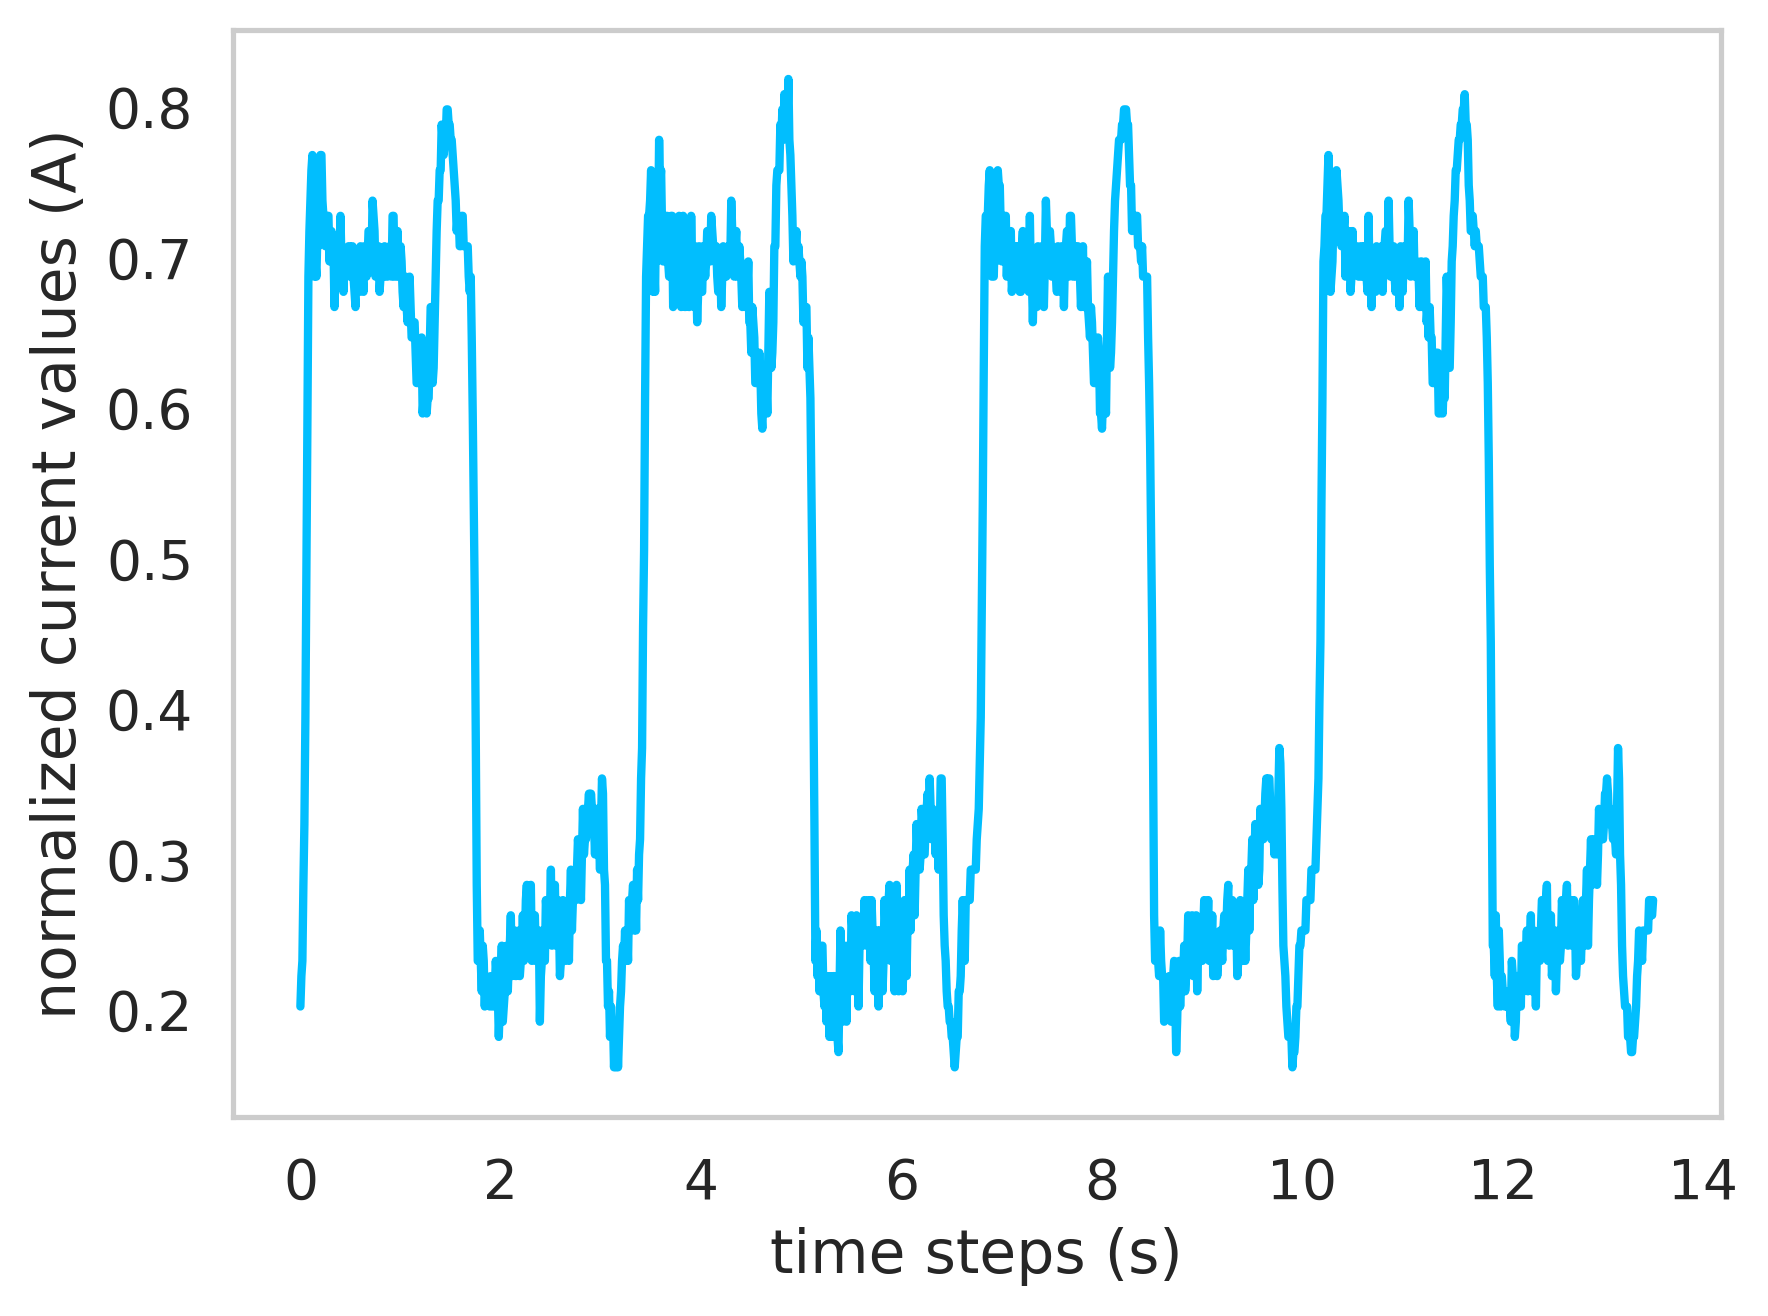

In [28]:
plt.figure(dpi=150)
lineWidth = 2

indexes, values = prepare_axies(raw_N_df.iloc[0,:-1].values, sampling_frequency)
plt.plot(indexes, values, label='N', lw=lineWidth)

# indexes, values = prepare_axies(raw_025_df.iloc[0,:-1].values[4:344], sampling_frequency)
# plt.plot(indexes, values, label='L025', lw=lineWidth)

# indexes, values = prepare_axies(raw_020_df.iloc[0,:-1].values[0:340], sampling_frequency)
# plt.plot(indexes, values, label='L020', lw=lineWidth)

# indexes, values = prepare_axies(raw_015_df.iloc[0,:-1].values[0:340], sampling_frequency)
# plt.plot(indexes, values, label='L015', lw=lineWidth)

# indexes, values = prepare_axies(raw_010_df.iloc[0,:-1].values[0:340], sampling_frequency)
# plt.plot(indexes, values, label='L010', lw=lineWidth)

# indexes, values = prepare_axies(raw_005_df.iloc[0,:-1].values[0:340], sampling_frequency)
# plt.plot(indexes, values, label='L005', lw=lineWidth)

# # indexes, values = prepare_axies(raw_N_p005_df.iloc[0,:-1], sampling_frequency)
# # plt.plot(indexes, values, label='N_p005', lw=lineWidth)

# # indexes, values = prepare_axies(raw_N_p010_df.iloc[0,:-1], sampling_frequency)
# # plt.plot(indexes, values, label='N_p010', lw=lineWidth)


plt.grid(b=None) 
# plt.legend()
plt.xlabel("time steps (s)")
plt.ylabel("normalized current values (A)")
plt.show()

In [13]:
# small misalignment

intervall = 160*2+18
fore_interval = 160
back_interval = 160

start1 = 160

start_pos_base = [start1, start1+intervall, start1+intervall*2, start1+intervall*3]

start_pos_deviation = {
  '025': [3,2,5,-2,-2,
      -2,0,2,-2,0,
      0,9999,1,3,2,
      5,5,6,4,3,],
  '020': [0,-2,-1,0,-1,
      1,2,4,2,6,
      3,1,2,-3,2,
      -1,1,4,2,4,],
  '015': [2,1,2,9,4,
      3,2,-1,1,4,
      1,1,-3,-3,6,
      4,6,-1,4,-3,],
  '010': [0,0,4,5,6,
      4,3,3,0,8,
      5,2,1,2,5,
      8,3,3,2,6,],
  '005': [5,8,3,6,3,
      3,8,5,3,4,
      3,2,1,8,3,
      6,4,1,11,8,],
  'N': [0,0,-6,3,2,
      0,1,2,1,-7,
      2,1,0,4,2,
      0,-2,2,6,9999,
      1,2,1,3,9999,
      1,5,-1,9999,9999,],
  'N_p005': [4,-2,-2,-2,0,
        5,-2,0,0,-1, 
        1,-2,-2,-2,0, 
        0,-2,-2,-2,-2,  
        0,-2,-2,-2,0, 
        0,0,-2,0,-2,   
        -2,-2,-2,0,0,
        0,-2,-2,-2,0,  
        -2,-2,0,-2,-2,  
        -2,0,-2,0,0],
  'N_p010': [2,-2,-2,1,-2, 
        -2,-2,0,0,-2, 
        0,-2,-2,0,2,
        -2,-2,0,-2,-2,
        -2,-2,-2,4,4, 
        -2,-2,-2,-2,-2,
        0,7,0,-2,5, 
        3,-2,1,0,-2,
        3,-2,-2,1,0, 
        -2,-2,-2,0,-2,],
}

<Figure size 960x720 with 0 Axes>

Text(0.5, 0, 'time steps (s)')

Text(0, 0.5, 'normalized current values (A)')

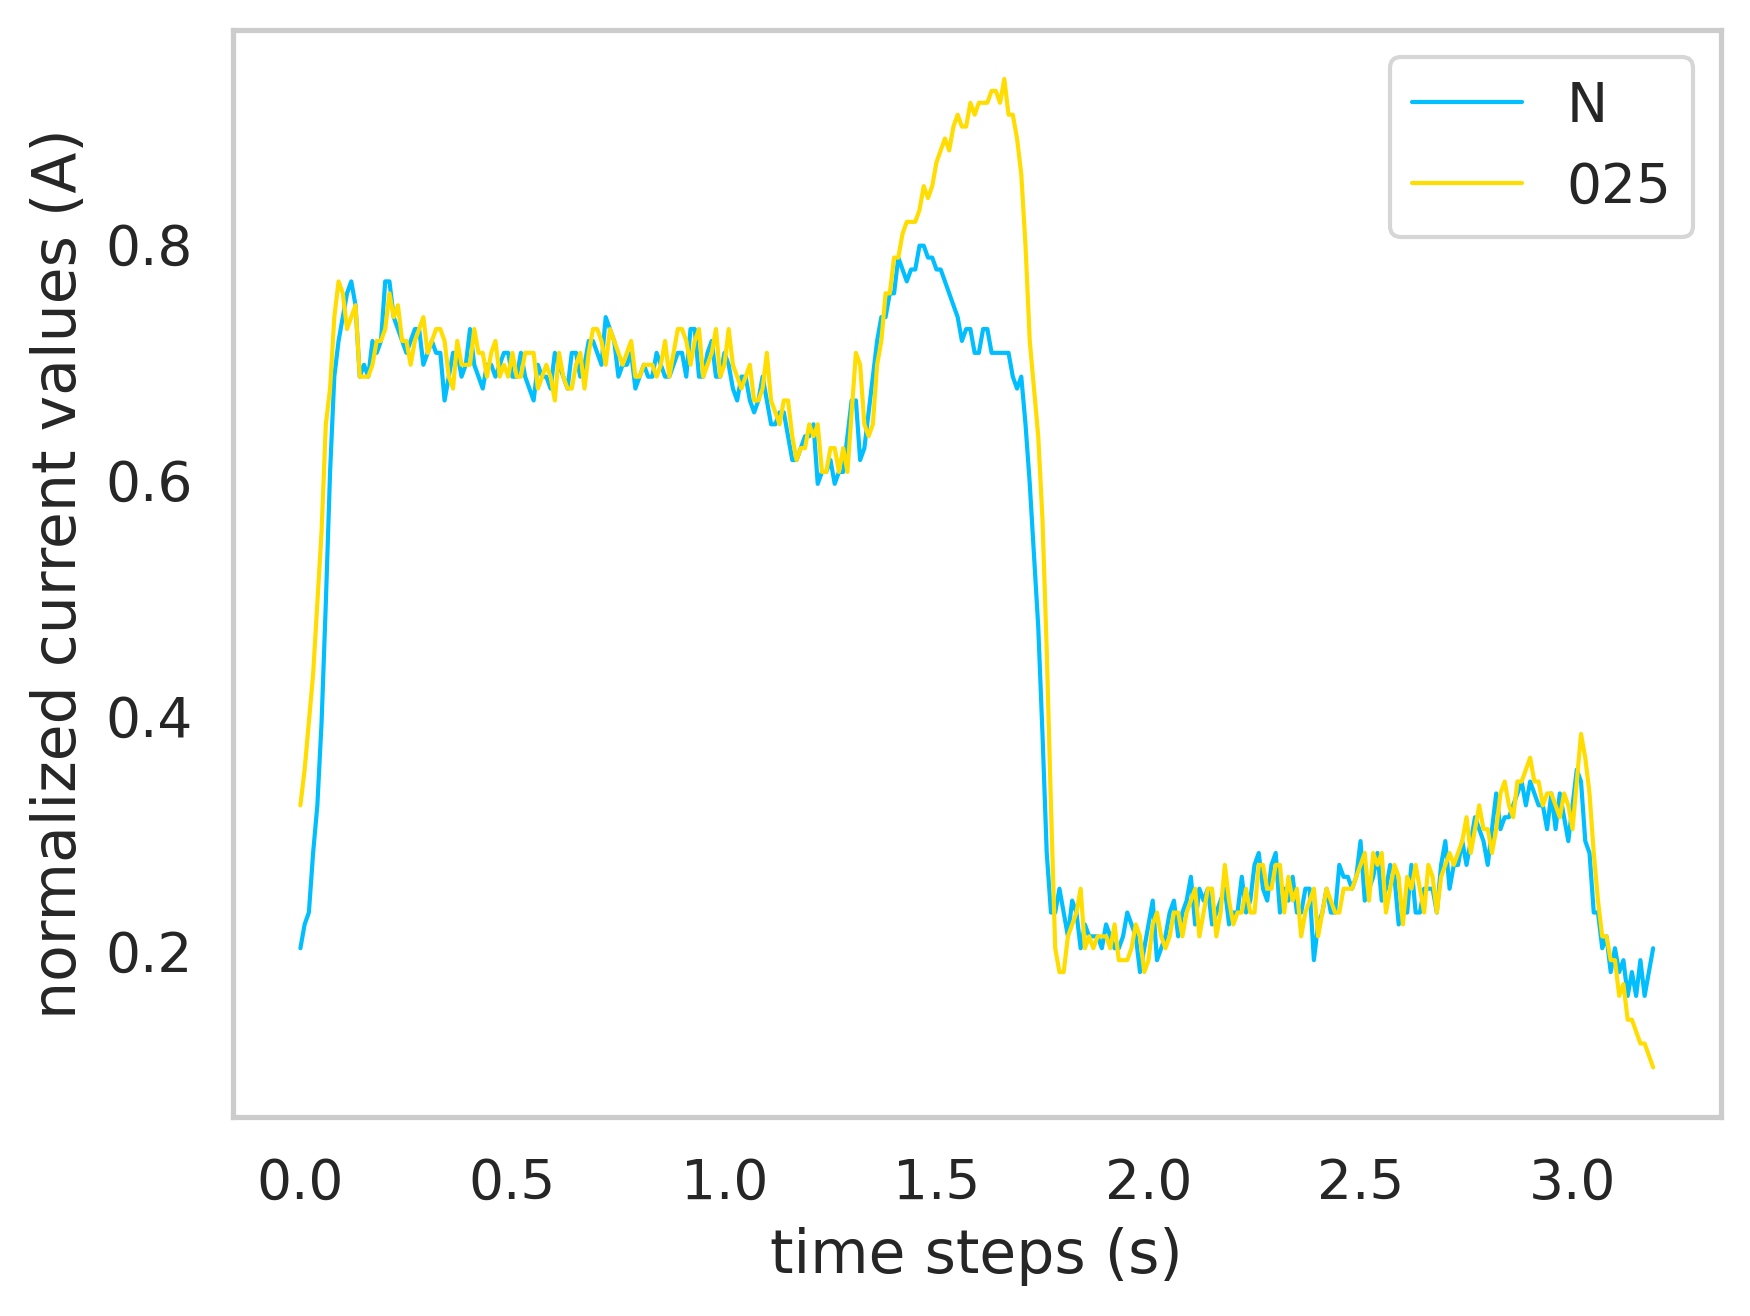

In [14]:
# 四周期信号与另外四周期信号比较
plt.figure(dpi=150)
lineWidth = 1

data_name1 = 'N'
i1 = 0
j1 = 0
test_df1 = raw_N_df.iloc[:,:-1]

base_start = start_pos_base[j1]+start_pos_deviation[data_name1][i1]-fore_interval
base_end = start_pos_base[j1]+start_pos_deviation[data_name1][i1]+back_interval
base = test_df1.iloc[i1, base_start : base_end]
indexes, values = prepare_axies(base, sampling_frequency)
plt.plot(indexes, values, label = data_name1, lw=lineWidth)

i2 = 19
j2 = 3
data_name2 = '025'
test_df2 = raw_025_df.iloc[:,:-1]

compare_start = start_pos_base[j2]+start_pos_deviation[data_name2][i2]-fore_interval
compare_end = start_pos_base[j2]+start_pos_deviation[data_name2][i2]+back_interval
comapre = test_df2.iloc[i2, compare_start : compare_end]
indexes, values = prepare_axies(comapre, sampling_frequency)
plt.plot(indexes, values, label = data_name2, lw=lineWidth)

plt.grid(b=None) 
plt.legend()
plt.xlabel("time steps (s)")
plt.ylabel("normalized current values (A)")
plt.show() 

<Figure size 960x720 with 0 Axes>

Text(0.5, 0, 'time steps (s)')

Text(0, 0.5, 'normalized current values (A)')

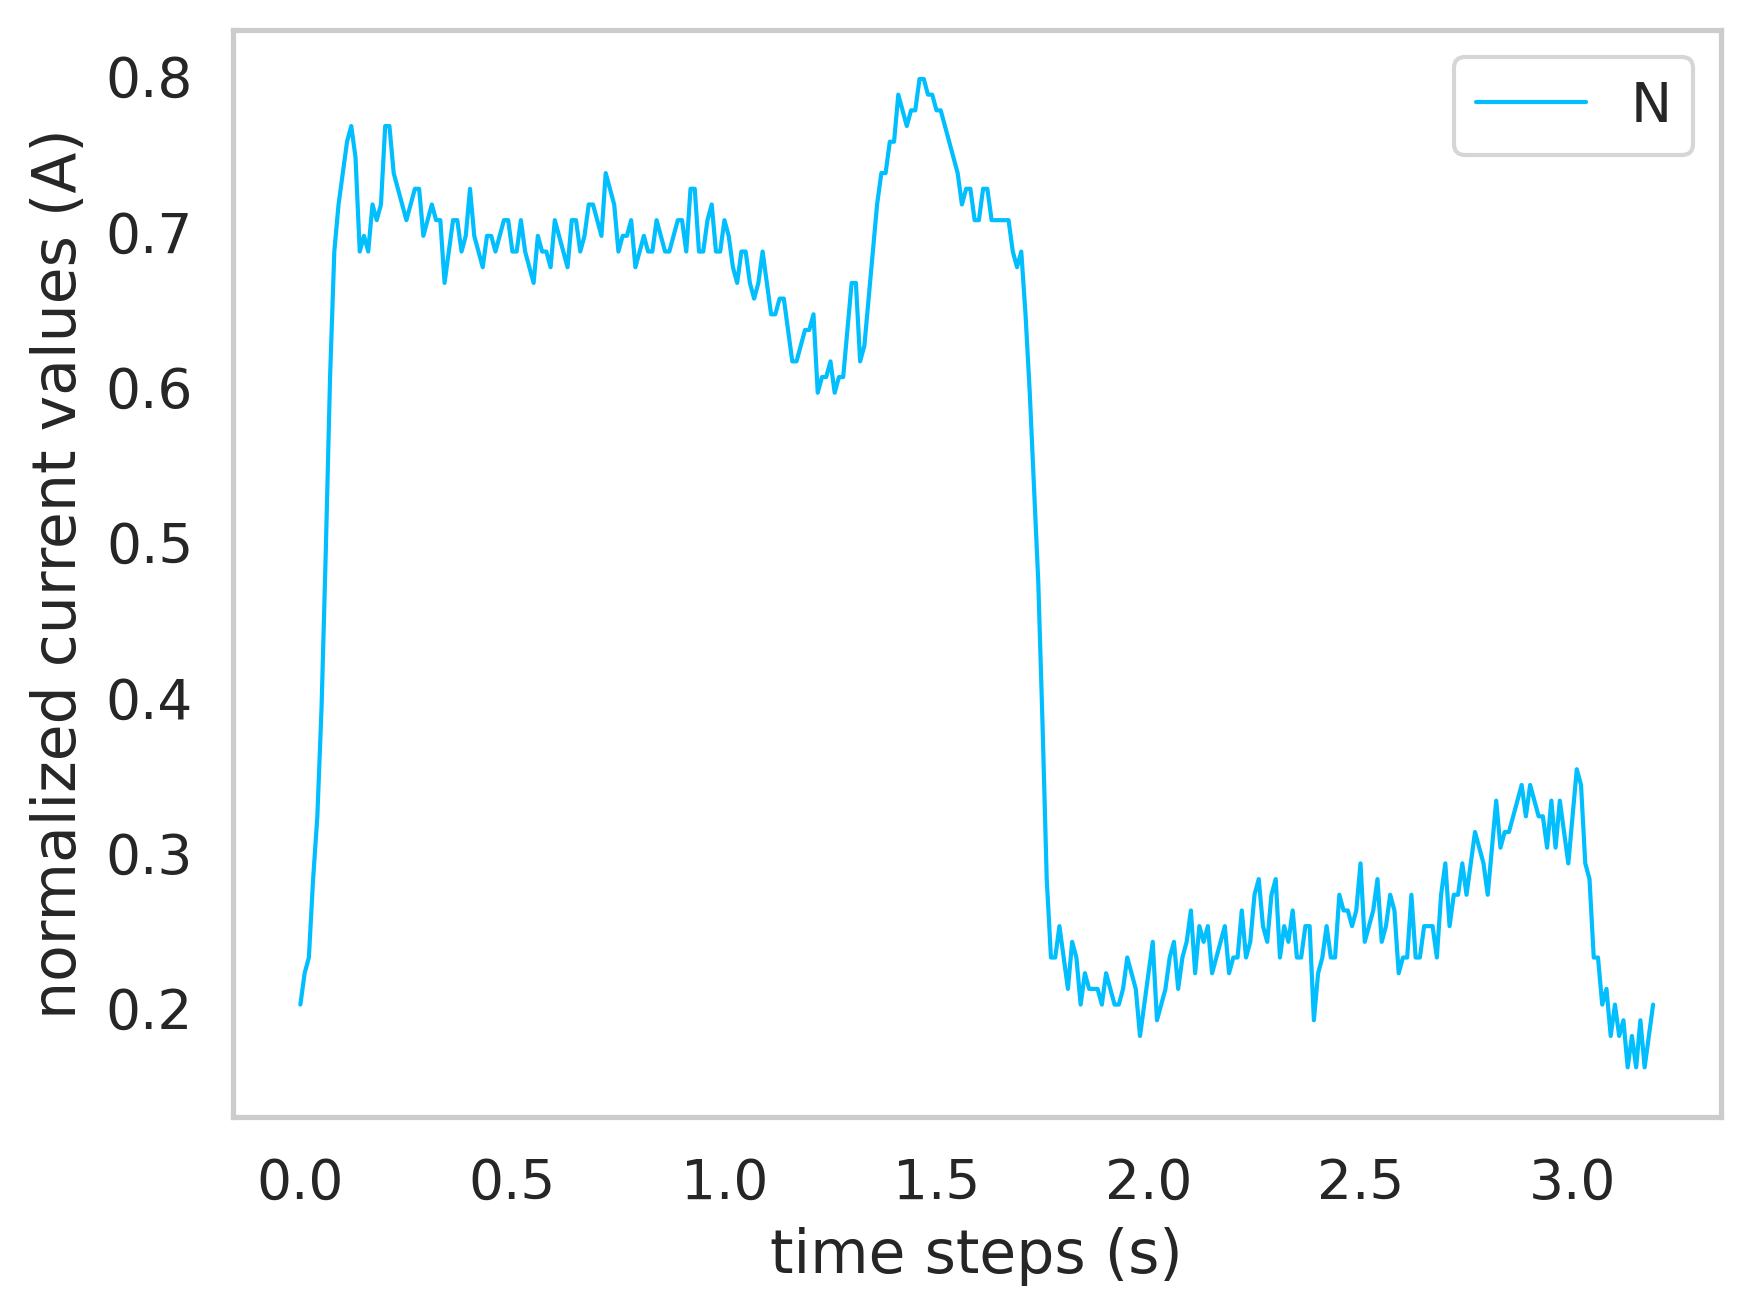

In [15]:
# 四周期信号的单周期与单周期N_p信号比较
plt.figure(dpi=150)
lineWidth = 1

data_name1 = 'N'
i1 = 0
j1 = 0
test_df1 = raw_N_df.iloc[:,:-1]

base_start = start_pos_base[j1]+start_pos_deviation[data_name1][i1]-fore_interval
base_end = start_pos_base[j1]+start_pos_deviation[data_name1][i1]+back_interval
base = test_df1.iloc[i1, base_start : base_end]
if len(base) == 320:
  indexes, values = prepare_axies(base, sampling_frequency)
  plt.plot(indexes, values, label = data_name1, lw=lineWidth)

i2 = 49
j2 = 0
data_name2 = 'N_p010'
test_df2 = raw_N_p010_df.iloc[:,:-1]

compare_start = start_pos_base[j2]+start_pos_deviation[data_name2][i2]-fore_interval
compare_end = start_pos_base[j2]+start_pos_deviation[data_name2][i2]+back_interval
comapre = test_df2.iloc[i2, compare_start : compare_end]
if len(comapre) == 320:
  indexes, values = prepare_axies(comapre, sampling_frequency)
  plt.plot(indexes, values, label = data_name2, lw=lineWidth)


plt.grid(b=None) 
plt.legend()
plt.xlabel("time steps (s)")
plt.ylabel("normalized current values (A)")
plt.show() 

In [16]:
def create_circle(data_name, normalized=True):
  raw_df = readRawData(data_name, normalized)
  targets = raw_df.iloc[:,-1]
  raw_df = raw_df.iloc[:,:-1]
  res_df = pd.DataFrame()

  fore_interval = 160
  back_interval = 160

  for i in range(len(start_pos_deviation[data_name])):
    for j in range(len(start_pos_base)):
      start = start_pos_base[j]+start_pos_deviation[data_name][i]-fore_interval
      end = start_pos_base[j]+start_pos_deviation[data_name][i]+back_interval
      if end >= len(raw_df.iloc[0,:-1]) or start < 0:
        continue
      else :
        cycle = raw_df.iloc[i, start : end].reset_index(drop=True).T
        res_df = res_df.append(cycle, ignore_index=True)
  target = pd.DataFrame(data=targets[0], index=range(len(res_df)), columns=range(1))
  res_df = pd.concat([res_df,target],axis = 1, ignore_index= True)
  # res_df = res_df.sample(frac=1.0)
  res_df.reset_index(drop=True, inplace=True)
  return res_df

In [17]:
real_005_df = create_circle('005', normalized=True)
real_010_df = create_circle('010', normalized=True)
real_015_df = create_circle('015', normalized=True)
real_020_df = create_circle('020', normalized=True)
real_025_df = create_circle('025', normalized=True)
real_N_df = create_circle('N', normalized=True)
real_N_p005_df = create_circle('N_p005', normalized=True)
real_N_p010_df = create_circle('N_p010', normalized=True)


real_005_df.to_csv(real_005_path, index=False, header=False)
real_010_df.to_csv(real_010_path, index=False, header=False)
real_015_df.to_csv(real_015_path, index=False, header=False)
real_020_df.to_csv(real_020_path, index=False, header=False)
real_025_df.to_csv(real_025_path, index=False, header=False)
real_N_df.to_csv(real_N_path, index=False, header=False)
real_N_p005_df.to_csv(real_N_p005_path, index=False, header=False)
real_N_p010_df.to_csv(real_N_p010_path, index=False, header=False)

<Figure size 960x720 with 0 Axes>

Text(0.5, 0, 'time steps (s)')

Text(0, 0.5, 'normalized current values (A)')

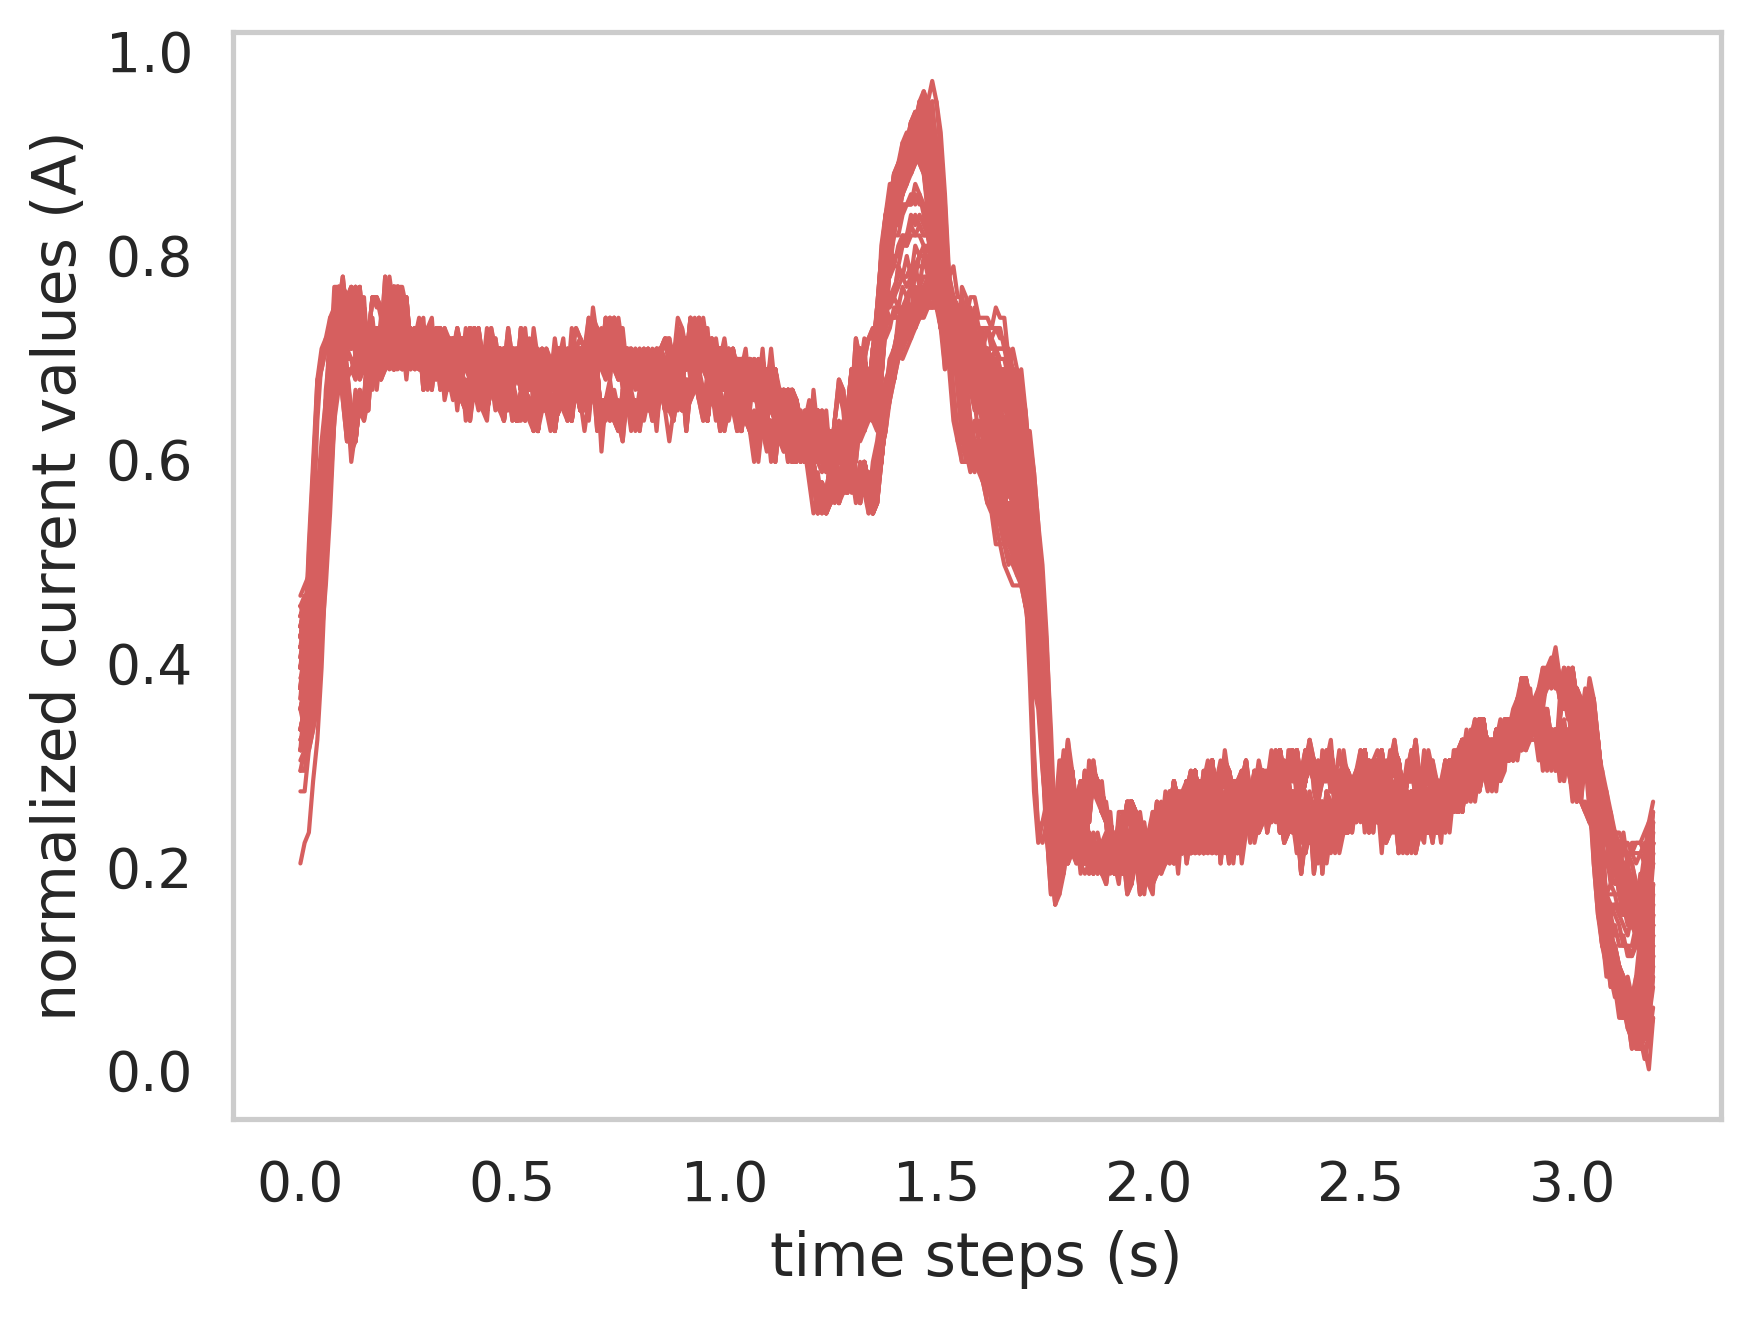

In [18]:
# 分割之后展示一下
show_df = real_N_df

plt.figure(dpi=150)
lineWidth = 1

for i in range(len(show_df)):
  indexes, values = prepare_axies(show_df.iloc[i,:-1], sampling_frequency)
  plt.plot(indexes, values, c = 'r', lw=lineWidth)

plt.grid(b=None)
plt.xlabel("time steps (s)")
plt.ylabel("normalized current values (A)")
plt.show() 

<Figure size 960x720 with 0 Axes>

Text(0.5, 0, 'time steps (s)')

Text(0, 0.5, 'normalized current values (A)')

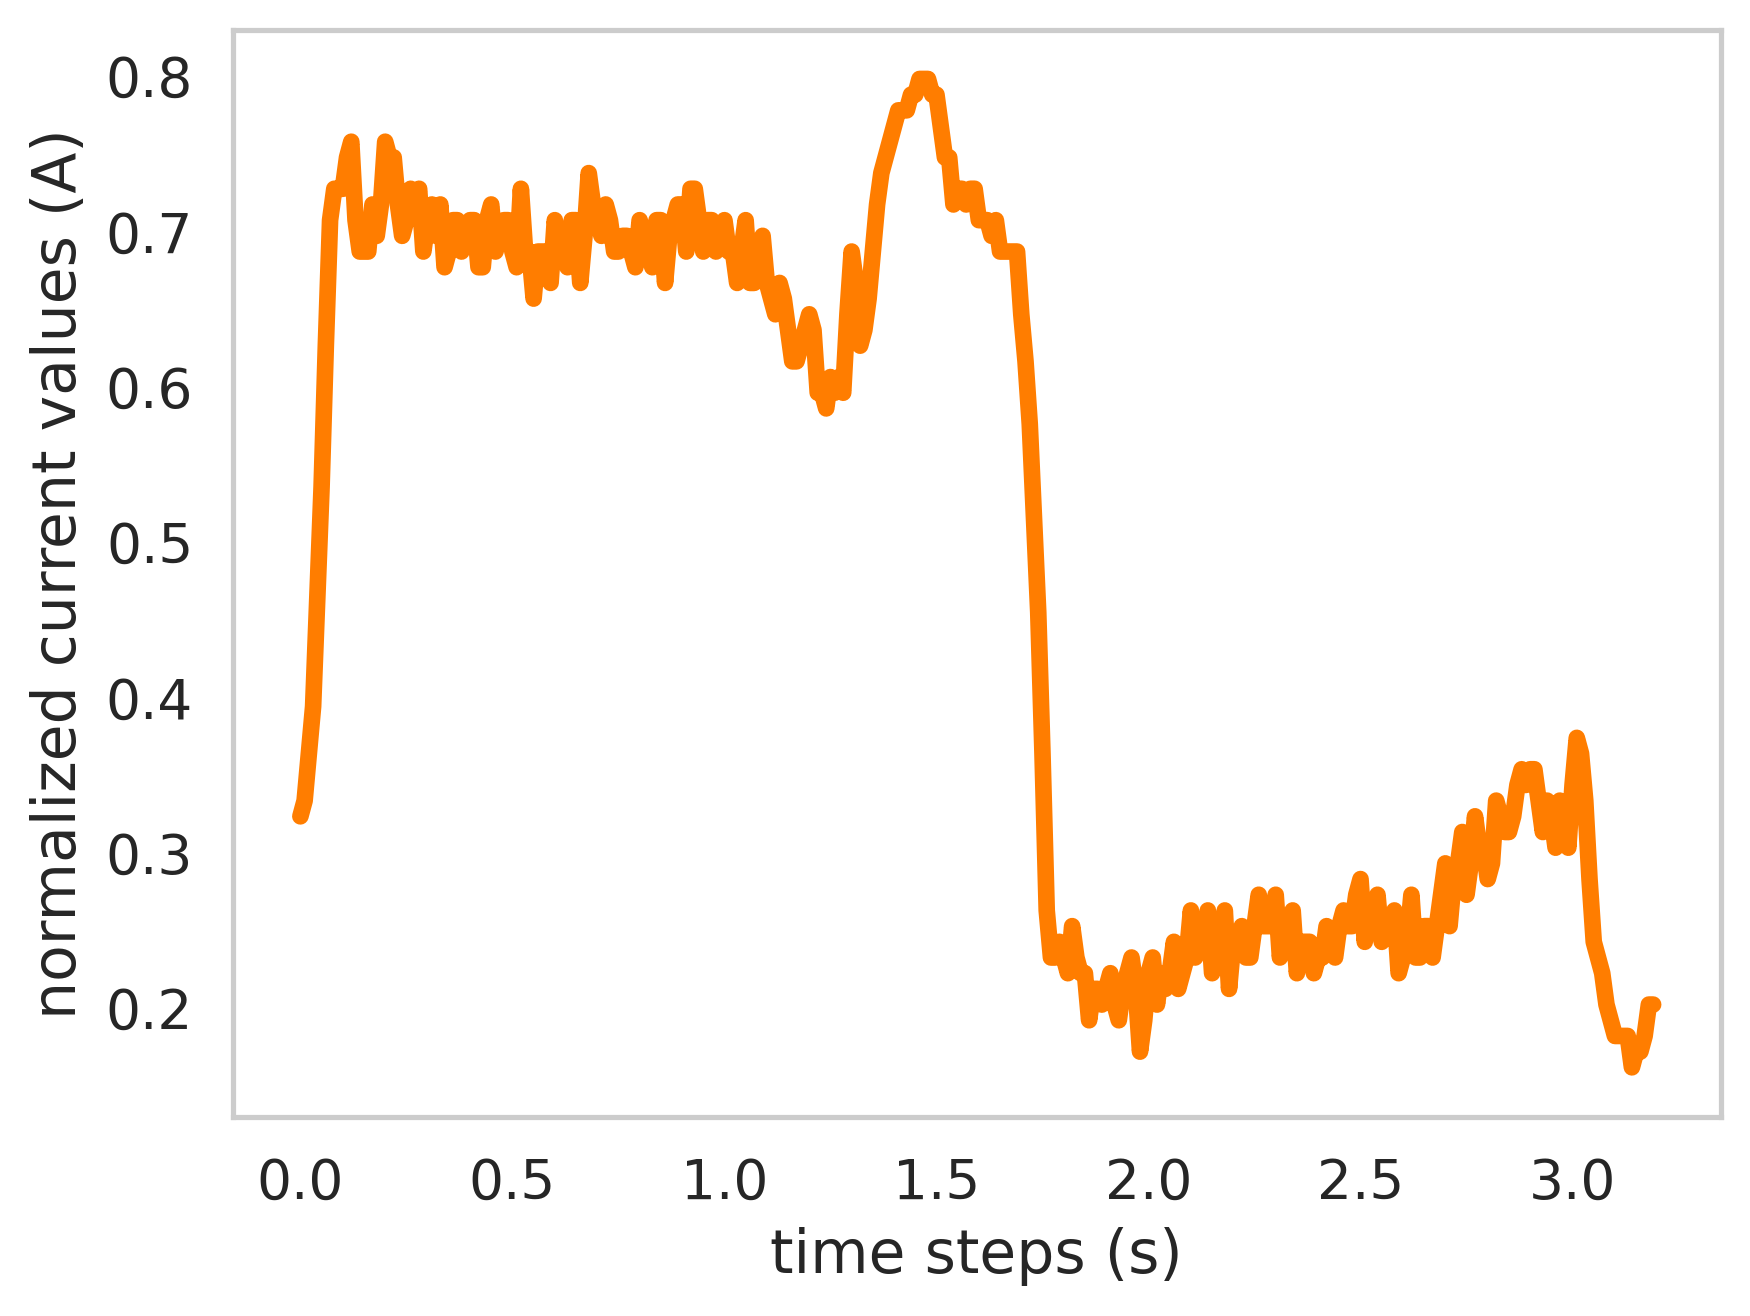

In [124]:
plt.figure(dpi=150)
lineWidth = 4

indexes, values = prepare_axies(real_N_df.iloc[2,:-1], sampling_frequency)
# plt.plot(indexes, values, label='Normal', lw=lineWidth)
# plt.plot(indexes, values, c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], label='Normal', lw=lineWidth)
plt.plot(indexes, values, c=plt.rcParams['axes.prop_cycle'].by_key()['color'][2], label='Normal', lw=lineWidth)



# indexes, values = prepare_axies(real_N_p005_df.iloc[0,:-1], sampling_frequency)
# plt.plot(indexes, values, label='Normal with 10N', lw=lineWidth)

# indexes, values = prepare_axies(real_N_p010_df.iloc[0,:-1], sampling_frequency)
# plt.plot(indexes, values, label='Normal with 25N', lw=lineWidth)

# indexes, values = prepare_axies(real_005_df.iloc[0,:-1], sampling_frequency)
# plt.plot(indexes, values, label = 'Left 0.05mm', lw = lineWidth)

# indexes, values = prepare_axies(real_010_df.iloc[0,:-1], sampling_frequency)
# plt.plot(indexes, values, label = 'Left 0.10mm', lw = lineWidth)

# indexes, values = prepare_axies(real_015_df.iloc[0,:-1], sampling_frequency)
# plt.plot(indexes, values, label = 'Left 0.15mm', lw = lineWidth)

# indexes, values = prepare_axies(real_020_df.iloc[0,:-1], sampling_frequency)
# plt.plot(indexes, values, label = 'Left 0.20mm', lw = lineWidth)

indexes, values = prepare_axies(real_025_df.iloc[0,:-1], sampling_frequency)
# plt.plot(indexes, values, c=plt.rcParams['axes.prop_cycle'].by_key()['color'][3], label = 'Left 0.25mm', lw = lineWidth)


plt.grid(b=None) 
# plt.legend()
# plt.title(' real data')
plt.xlabel("time steps (s)")
plt.ylabel("normalized current values (A)")
plt.show()

# GAN

In [42]:
def create_cycle_dataset(df):
  x_values = []
  y_values = []
  for i in range(len(df)):
      x = df.iloc[i,:-1].values
      y = df.iloc[i,-1]
      x_values.append(x)
      y_values.append(y)

  x = [torch.tensor(x).unsqueeze(1).float() for x in x_values]
  y = [torch.tensor(y).unsqueeze(0).float() for y in y_values]
  x = torch.stack(x)
  y = torch.stack(y)

  n_seq, seq_len, n_features = x.shape
  return x, y, seq_len, n_features

def get_dataloader(path, label_name, batch_size):
  df = pd.read_csv(path, header=None)
  df.rename(columns={320: 'target'}, inplace=True)
  if label_name == 'N' or label_name == 'N_p005' or label_name == 'N_p010':
    df = df[df.target==class_to_id['Normal']]
  elif label_name == '025' or label_name == '020' or label_name == '015' or label_name == '010' or label_name == '005':
    df = df[df.target==class_to_id['Left']]
  elif label_name == 'cnc_N' or label_name == 'cnc_N_p005' or label_name == 'cnc_N_p010':
    df = df[df.target==class_to_id['Normal']]
  elif label_name == 'cnc_025' or label_name == 'cnc_020' or label_name == 'cnc_015' or label_name == 'cnc_010' or label_name == 'cnc_005':
    df = df[df.target==class_to_id['Left']]
  X, Y, seq_len, n_features = create_cycle_dataset(df)

  dataset = TensorDataset(X, Y)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  return dataloader


def get_single_dataloader(path, label_name, id):
  df = pd.read_csv(path, header=None)
  df.rename(columns={320: 'target'}, inplace=True)
  if label_name == 'Normal':
    df = df[df.target==class_to_id['Normal']]
  elif label_name == 'Left':
    df = df[df.target==class_to_id['Left']]


  X, Y, seq_len, n_features = create_cycle_dataset(df.iloc[id:id+1,:])

  dataset = TensorDataset(X, Y)
  dataloader = DataLoader(dataset)
  return dataloader

In [43]:
dataloader = get_dataloader(path=real_N_path, label_name='N', batch_size=32)
# dataloader = get_dataloader(path=real_N_p005_path, label_name='N_p005', batch_size=32)
# dataloader = get_dataloader(path=real_025_path, label_name='025', batch_size=32)

# dataloader = get_dataloader(path=real_cnc_N_path, label_name='cnc_N', batch_size=32)
# dataloader = get_dataloader(path=real_cnc_N_p005_path, label_name='cnc_N_p005', batch_size=32)
# dataloader = get_dataloader(path=real_cnc_025_path, label_name='cnc_025', batch_size=32)

# dataloader = get_single_dataloader(path=real_N_path, label_name='normal', id = 0)


print(len(dataloader))
x, y = next(iter(dataloader))
print(x.shape, y.shape)

4
torch.Size([32, 320, 1]) torch.Size([32, 1])


In [44]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = self._block(1, 32, 4, 2, 1)
        self.conv_2 = self._block(32, 64, 4, 2, 1)
        self.conv_3 = self._block(64, 128, 4, 2, 1)
        self.conv_4 = self._block(128, 256, 4, 2, 1)
        self.conv_5 = self._block(256, 512, 4, 2, 1)
        self.conv_6 = nn.Conv1d(512, 1, kernel_size=10, stride=1, padding=0, bias=False)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv1d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )
    def forward(self, x, y=None):
        output = x.permute(0, 2, 1)
        output = self.conv_1(output)
        # print(output.shape)
        output = self.conv_2(output)
        # print(output.shape)
        output = self.conv_3(output)
        # print(output.shape)
        output = self.conv_4(output)
        # print(output.shape)
        output = self.conv_5(output)
        # print(output.shape)
        output = self.conv_6(output)
        # print(output.shape)
        return output

class Generator(nn.Module):
    def __init__(self, nz=100):
        self.nz = nz
        super().__init__()
        self.conv_1 = self._block(self.nz, 512, 10, 1, 0)
        self.conv_2 = self._block(512, 256, 4, 2, 1)
        self.conv_3 = self._block(256, 128, 4, 2, 1)
        self.conv_4 = self._block(128, 64, 4, 2, 1)
        self.conv_5 = self._block(64, 32, 4, 2, 1)
        self.conv_6 = nn.ConvTranspose1d(32, 1, kernel_size=4, stride=2, padding=1, bias=False)
        self.sigmoid =  nn.Sigmoid()

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose1d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        output = self.conv_1(x)
        # print(output.shape)
        output = self.conv_2(output)
        # print(output.shape)
        output = self.conv_3(output)
        # print(output.shape)
        output = self.conv_4(output)
        # print(output.shape)
        output = self.conv_5(output)
        # print(output.shape)
        output = self.conv_6(output)
        # print(output.shape)
        output = self.sigmoid(output)
        output = output.permute(0, 2, 1)
        return output

In [45]:
class Trainer:
  def __init__(
    self,
    generator,
    discriminator,
    batch_size,
    num_epochs,
    n_critic,
    clip_value,
    nz,
    data_path,
    lr,
    label,
    id,
    patience,
    makeGIF
  ):
    self.n_critic = n_critic
    self.clip_value = clip_value
    self.lr = lr
    self.num_epochs = num_epochs
    self.batch_size = batch_size
    self.nz = nz
    self.data_path = data_path
    self.label = label
    self.id = id
    self.patience = patience
    self.makeGIF = makeGIF
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.netD = discriminator.to(self.device)
    self.netD.apply(weights_init)
    self.netG = generator.to(self.device)
    self.netG.apply(weights_init)

    self.fixed_noise = torch.randn(self.batch_size, self.nz, 1, device=self.device)
    self.dataloader = get_dataloader(path=self.data_path, label_name=self.label, batch_size=self.batch_size)
    # self.dataloader = get_single_dataloader(path=self.data_path, label_name=self.label, id = self.id)
    
    self.optimizerD = optim.RMSprop(self.netD.parameters(), lr=self.lr)
    self.optimizerG = optim.RMSprop(self.netG.parameters(), lr=self.lr)

    # self.optimizerD = optim.AdamW(self.netD.parameters(), lr=self.lr)
    # self.optimizerG = optim.AdamW(self.netG.parameters(), lr=self.lr)
    
    self.early_stopping = EarlyStopping(verbose = True, patience = self.patience)
    
    self.lossD = []
    self.lossG = []
    self.best_diff = 10000.0
    self.netD_best_state = None
    self.netG_best_state = None

  def _one_epoch(self):
    for step, (data, labels) in enumerate(self.dataloader):
      # training netD
      real = data.to(self.device)
      b_size = real.size(0)
      self.netD.zero_grad()

      noise = torch.randn(b_size, self.nz, 1, device=self.device)
      fake = self.netG(noise)

      loss_disc = -torch.mean(self.netD(real)) + torch.mean(self.netD(fake))
      loss_disc.backward()
      self.optimizerD.step()

      for p in self.netD.parameters():
        p.data.clamp_(-self.clip_value, self.clip_value)

      if step % self.n_critic == 0:
        # training netG
        noise = torch.randn(b_size, self.nz, 1, device=self.device)
        self.netG.zero_grad()
        fake = self.netG(noise)
        loss_gen = -torch.mean(self.netD(fake))

        self.netD.zero_grad()
        self.netG.zero_grad()
        loss_gen.backward()
        self.optimizerG.step()
    return step, loss_disc.item(), loss_gen.item()

  def run(self):
    for epoch in range(self.num_epochs + 1):
      step, loss_disc, loss_gen = self._one_epoch()
      self.lossG.append(loss_gen)
      self.lossD.append(loss_disc)

      fake = self.netG(self.fixed_noise).detach().cpu()
      real = next(iter(self.dataloader))[0]

      diff = np.array(fake.view(-1)) - np.array(real.view(-1))
      diff = np.sum(diff ** 2) / self.batch_size
      print('[%d/%d][%d/%d]\tloss_netD: %.4f\tloss_netG: %.4f\tdiff: %.4f\tbest_diff: %.4f'
        % (epoch, self.num_epochs, step, len(self.dataloader), loss_disc, loss_gen, diff, self.best_diff))
      
      # early_stopping needs the diff to check if it has decresed, 
      # and if it has, it will make a checkpoint of the current model
      self.early_stopping(diff, self.netG)
      if self.early_stopping.early_stop:
        print("Early stopping")
        break

      if diff <= self.best_diff:
        self.best_diff = diff
        with torch.no_grad():
          if self.makeGIF == True:
            fig, ax = plt.subplots()
            line_width = 2

            indexes = []
            values = []
            for index,value in enumerate(fake[self.id].view(-1)):
              indexes.append(index/sampling_frequency)
              values.append(value)
            ax.plot(indexes, values, label='fake', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][3], linewidth=line_width)
            
            indexes = []
            values = []
            for index,value in enumerate(real[self.id].view(-1)):
              indexes.append(index/sampling_frequency)
              values.append(value)
            ax.plot(indexes, values, label='real', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], linewidth=line_width)
            ax.set_title(f'{" mean square error"} (loss: {np.around(diff, 2)})')
            ax.set_xlabel("time steps (S)")
            ax.set_ylabel("normalized current value (A)")
            plt.legend()
            plt.savefig('drive/MyDrive/dataset/checkpoint/WGAN_OLD/GIF/%d.png' % epoch)
            plt.close()
      
          if diff < 1:
            # fake = self.netG(self.fixed_noise).detach().cpu()
            # real = next(iter(self.dataloader))[0]
            # fig, ax = plt.subplots()
            # ax.set_title(f'{self.label}{" mean square error"} (loss: {np.around(diff, 2)})')
            # line_width = 0.5
            # ax.plot(fake[0].view(-1), label='fake', c='blue', linewidth=line_width)
            # ax.plot(real[0].view(-1), label='real', c='red', linewidth=line_width)
            # ax.legend()
            # plt.show()

            self.netD_best_state = self.netD.state_dict()
            self.netG_best_state = self.netG.state_dict()

            if self.label.startswith('N'):
              netD_path = 'drive/MyDrive/dataset/checkpoint/WGAN_OLD/LinearFeedAxis_Normal/'+ self.label + '/netD/'
              netG_path = 'drive/MyDrive/dataset/checkpoint/WGAN_OLD/LinearFeedAxis_Normal/'+ self.label + '/netG/'
            else:
              netD_path = 'drive/MyDrive/dataset/checkpoint/WGAN_OLD/LinearFeedAxis_Anomaly/'+ self.label + '/netD/'
              netG_path = 'drive/MyDrive/dataset/checkpoint/WGAN_OLD/LinearFeedAxis_Anomaly/'+ self.label + '/netG/'
              
            netD_path = os.path.join(netD_path, 'netD_{}_{}.pt'.format(self.label, round(diff*10)))
            netG_path = os.path.join(netG_path, 'netG_{}_{}.pt'.format(self.label, round(diff*10)))
            torch.save(self.netD_best_state, netD_path)
            torch.save(self.netG_best_state, netG_path)

    # netD_path = os.path.join(netD_path, 'netD_{}.pt'.format(self.label))
    # netG_path = os.path.join(netG_path, 'netG_{}.pt'.format(self.label))

    # torch.save(self.netD_best_state, netD_path)
    # torch.save(self.netG_best_state, netG_path)

    # print(self.best_diff)
    # plot the loss
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(self.lossG, label="G")
    plt.plot(self.lossD, label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [ ]:
# import shutil  
# shutil.rmtree('drive/MyDrive/dataset/checkpoint/WGAN_OLD/GIF')  
# os.mkdir('drive/MyDrive/dataset/checkpoint/WGAN_OLD/GIF')  

In [ ]:
print(len(real_005_df))
print(len(real_010_df))
print(len(real_015_df))
print(len(real_020_df))
print(len(real_025_df))
print(len(real_N_df))
print(len(real_N_p005_df))
print(len(real_N_p010_df))

80
80
75
75
72
100
21
21


In [ ]:
# nz = 100

# # early stopping patience; how long to wait after last time validation loss improved.
# patience = 500

# trainer = Trainer(
#     generator=Generator(nz),
#     discriminator=Discriminator(),
#     batch_size=21,
#     num_epochs=5000,
#     n_critic=5,
#     clip_value=0.01, # 0.005,0.01
#     nz = nz,
#     data_path = real_N_p010_path, # real_005_path, real_N_path real_N_p005_path
#     lr=1e-4,
#     label='N_p010', # 'N', '005', 'N_p005
#     id=0,
#     patience = patience,
#     makeGIF = False
# )
# trainer.run()

In [ ]:
# png_dir = 'drive/MyDrive/dataset/checkpoint/WGAN_OLD/GIF/'
# gif_path = 'drive/MyDrive/dataset/checkpoint/WGAN_OLD/GIF/movie.gif'
# images = []

# for file_name in sorted(os.listdir(png_dir), key=len):
#   if file_name.endswith('.png'):
#     file_path = os.path.join(png_dir, file_name)
#     images.append(imageio.imread(file_path))
# imageio.mimsave(gif_path, images, format='GIF', duration=0.001)

In [ ]:
# # test generation performances with the best mse
# def generation_perform(label_name, label_class):
#   nz = 100
#   line_width = 2
#   plt.figure(dpi=150)

#   if label_class == 'N':
#     real_data_path = real_N_path
#   elif label_class == '025':
#     real_data_path = real_025_path
#   elif label_class == '050':
#     real_data_path = real_050_path
#   elif label_class == '075':
#     real_data_path = real_075_path
#   elif label_class == '100':
#     real_data_path = real_100_path
#   real_dataloader = get_dataloader(path=real_data_path, label_name=label_name, batch_size=32)
#   real = next(iter(real_dataloader))[0]

#   if label_class =='N':
#     generator_path = '/content/drive/MyDrive/dataset/checkpoint/WGAN_OLD/LinearFeedAxis_Normal/' + label_class + '/netG/netG_'+label_class+'_1.pt'
#   else:
#     generator_path = '/content/drive/MyDrive/dataset/checkpoint/WGAN_OLD/LinearFeedAxis_Anomaly/' + label_class + '/netG/netG_'+label_class+'_2.pt'

#   g = Generator(nz)
#   g.load_state_dict(torch.load(generator_path))

#   diff_sum = 999
#   while diff_sum > 0.5:
#     diff_sum = 0
#     fixed_noise = torch.randn(1, nz, 1)
#     fake = g(fixed_noise).detach().cpu()

#     for i in range(real.shape[0]):
#       diff = np.array(fake.detach().cpu().view(-1)) - np.array(real[i].detach().cpu().view(-1))
#       diff = diff ** 2
#       diff_sum += diff
#     diff_sum = np.sum(diff_sum) / real.shape[0]
#     print(diff_sum)
#   print(diff_sum)

#   fig, ax = plt.subplots()
#   indexes, values = prepare_axies(fake[0].view(-1), sampling_frequency)
#   ax.plot(indexes, values, label='fake', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][3], linewidth=line_width)

#   indexes, values = prepare_axies(real[0].view(-1), sampling_frequency)
#   ax.plot(indexes, values, label='real', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], linewidth=line_width)
  
#   ax.set_xlabel("time steps (S)")
#   ax.set_ylabel("normalized current values (A)")
#   ax.set_title(label_class)
#   plt.grid(b=None)
#   plt.legend()
#   plt.show()

In [ ]:
# generation_perform('Normal', 'N')
# generation_perform('Left', '025')
# generation_perform('Left', '025')
# generation_perform('Left', '025')
# generation_perform('Left', '025')

In [ ]:
# # compare different mse levels of generation performances
# def generation_compare(label_name, label_class):
#   nz = 100
#   line_width = 1
#   fig, ax = plt.subplots(dpi=150)

#   if label_class == 'N':
#     real_data_path = real_N_path
#   elif label_class == '025':
#     real_data_path = real_025_path
#   elif label_class == '050':
#     real_data_path = real_050_path
#   elif label_class == '075':
#     real_data_path = real_075_path
#   elif label_class == '100':
#     real_data_path = real_100_path

#   real_dataloader = get_dataloader(path=real_data_path, label_name=label_name, batch_size=32)
#   real = next(iter(real_dataloader))[0]

#   if label_name =='Normal':
#     generator_dir = '/content/drive/MyDrive/dataset/checkpoint/WGAN_OLD/LinearFeedAxis_Normal/' + label_class + '/netG/'

#   elif label_name =='Left':
#     generator_dir = '/content/drive/MyDrive/dataset/checkpoint/WGAN_OLD/LinearFeedAxis_Anomaly/' + label_class + '/netG/'

#   generator_paths = os.listdir(generator_dir)

#   indexes, values = prepare_axies(real[0].view(-1), sampling_frequency)
#   ax.plot(indexes, values, label='real', linewidth=line_width)
 
#   for generator_path in generator_paths:
#     if not generator_path.endswith('.pt'):
#       continue
#     if generator_path.endswith('1.pt'):
#       level = 1
#     elif generator_path.endswith('2.pt'):
#       level = 2
#     elif generator_path.endswith('3.pt'):
#       level = 3
#     elif generator_path.endswith('4.pt'):
#       level = 4
#     elif generator_path.endswith('5.pt'):
#       level = 5
#     # elif generator_path.endswith('6.pt'):
#     #   level = 6
#     # elif generator_path.endswith('7.pt'):
#     #   level = 7
#     # elif generator_path.endswith('8.pt'):
#     #   level = 8
#     # elif generator_path.endswith('9.pt'):
#     #   level = 9
#     # elif generator_path.endswith('10.pt'):
#     #   level = 10
#     else:
#       continue
  
#     g = Generator(nz)
#     g.load_state_dict(torch.load(generator_dir+generator_path))
#     fixed_noise = torch.randn(1, nz, 1)
#     fake = g(fixed_noise).detach().cpu()

#     indexes, values = prepare_axies(fake[0].view(-1), sampling_frequency)
#     ax.plot(indexes, values, label='fake'+str(level), c=plt.rcParams['axes.prop_cycle'].by_key()['color'][3], linewidth=line_width)
#     # ax.plot(indexes, values, label='fake'+str(level), linewidth=line_width)

   
#   ax.set_xlabel("time steps (S)")
#   ax.set_ylabel("normalized current values (A)")
#   ax.set_title(label_class)
#   plt.grid(b=None)
#   plt.legend()
#   plt.show()

In [ ]:
# generation_compare('Normal', 'N')
# generation_compare('Left', '005')
# generation_compare('Left', '010')
# generation_compare('Left', '015') 
# generation_compare('Left', '020')
# generation_compare('Left', '025')

In [ ]:
# compare different mse levels of generation performances

import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)
    
def generation_compare(label_name, label_class):
  nz = 100
  # line_width = 1
  # fig, ax = plt.subplots(dpi=150)

  num_x = 3
  num_y = 2
  line_width = 2
  
  fig, axs = plt.subplots(nrows=num_x, ncols=num_y, sharey=True, sharex=True, constrained_layout=True, figsize=(12,12))

  if label_class == 'N':
    real_data_path = real_N_path
    # fig.suptitle('The training process of the GAN model on normal condition data', fontsize='large')
  elif label_class == 'N_p005':
    real_data_path = real_N_p005_path
    # fig.suptitle('The training process of the GAN model on left side 0.05mm misalignment data', fontsize='large')
  elif label_class == 'N_p010':
    real_data_path = real_N_p010_path
    # fig.suptitle('The training process of the GAN model on left side 0.05mm misalignment data', fontsize='large')
  elif label_class == '025':
    real_data_path = real_025_path
    # fig.suptitle('The training process of the GAN model on left side 0.05mm misalignment data', fontsize='large')
  elif label_class == '020':
    real_data_path = real_020_path
    # fig.suptitle('The training process of the GAN model on left side 0.10mm misalignment data', fontsize='large')
  elif label_class == '015':
    real_data_path = real_015_path
    # fig.suptitle('The training process of the GAN model on left side 0.15mm misalignment data', fontsize='large')
  elif label_class == '010':
    real_data_path = real_010_path
    # fig.suptitle('The training process of the GAN model on left side 0.20mm misalignment data', fontsize='large')
  elif label_class == '005':
    real_data_path = real_005_path
    # fig.suptitle('The training process of the GAN model on left side 0.20mm misalignment data', fontsize='large')

  real_dataloader = get_dataloader(path=real_data_path, label_name=label_class, batch_size=32)
  real = next(iter(real_dataloader))[0]

  if label_name =='Normal':
    generator_dir = '/content/drive/MyDrive/dataset/checkpoint/WGAN_OLD/LinearFeedAxis_Normal/' + label_class + '/netG/'

  elif label_name =='Left':
    generator_dir = '/content/drive/MyDrive/dataset/checkpoint/WGAN_OLD/LinearFeedAxis_Anomaly/' + label_class + '/netG/'
  generator_paths = sorted_alphanumeric(os.listdir(generator_dir))
 
  x = 2
  y = 1
  titles = ['The 300th epoch', 'The 280th epoch', 'The 260th epoch', 
        'The 240th epoch', 'The 220th epoch', 'The 200th epoch']
  for generator_path, title in zip(generator_paths, titles):
    if y < 0:
      x -= 1
      y = 1
    if x < 0:
      break

    if not generator_path.endswith('.pt'):
      continue
    # if generator_path.endswith('1.pt'):
    #   title = 'The 300th epoch'
    # elif generator_path.endswith('2.pt'):
    #   title = 'The 280th epoch'
    # elif generator_path.endswith('3.pt'):
    #   title = 'The 260th epoch'
    # elif generator_path.endswith('4.pt'):
    #   title = 'The 240th epoch'
    # elif generator_path.endswith('5.pt'):
    #   title = 'The 220th epoch'
    # elif generator_path.endswith('6.pt'):
    #   title = 'The 200th epoch'
    # else:
    #   continue

    g = Generator(nz)
    g.load_state_dict(torch.load(generator_dir+generator_path))
    fixed_noise = torch.randn(1, nz, 1)
    fake = g(fixed_noise).detach().cpu()

    indexes, values = prepare_axies(fake[0].view(-1), sampling_frequency)
    axs[x][y].plot(indexes, values, label='fake', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][3], linewidth=line_width)
    indexes, values = prepare_axies(real[0].view(-1), sampling_frequency)
    axs[x][y].plot(indexes, values, label='real', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], linewidth=line_width)
    axs[x][y].set_title(title)
    axs[x][y].grid(None) 

    y -= 1

  fig.text(0.5,-0.02, "time steps (s)", ha="center", va="center", fontsize='large')
  fig.text(-0.02,0.5, "normalized current values (A)", ha="center", va="center", rotation=90, fontsize='large')
  plt.legend()
  plt.show()

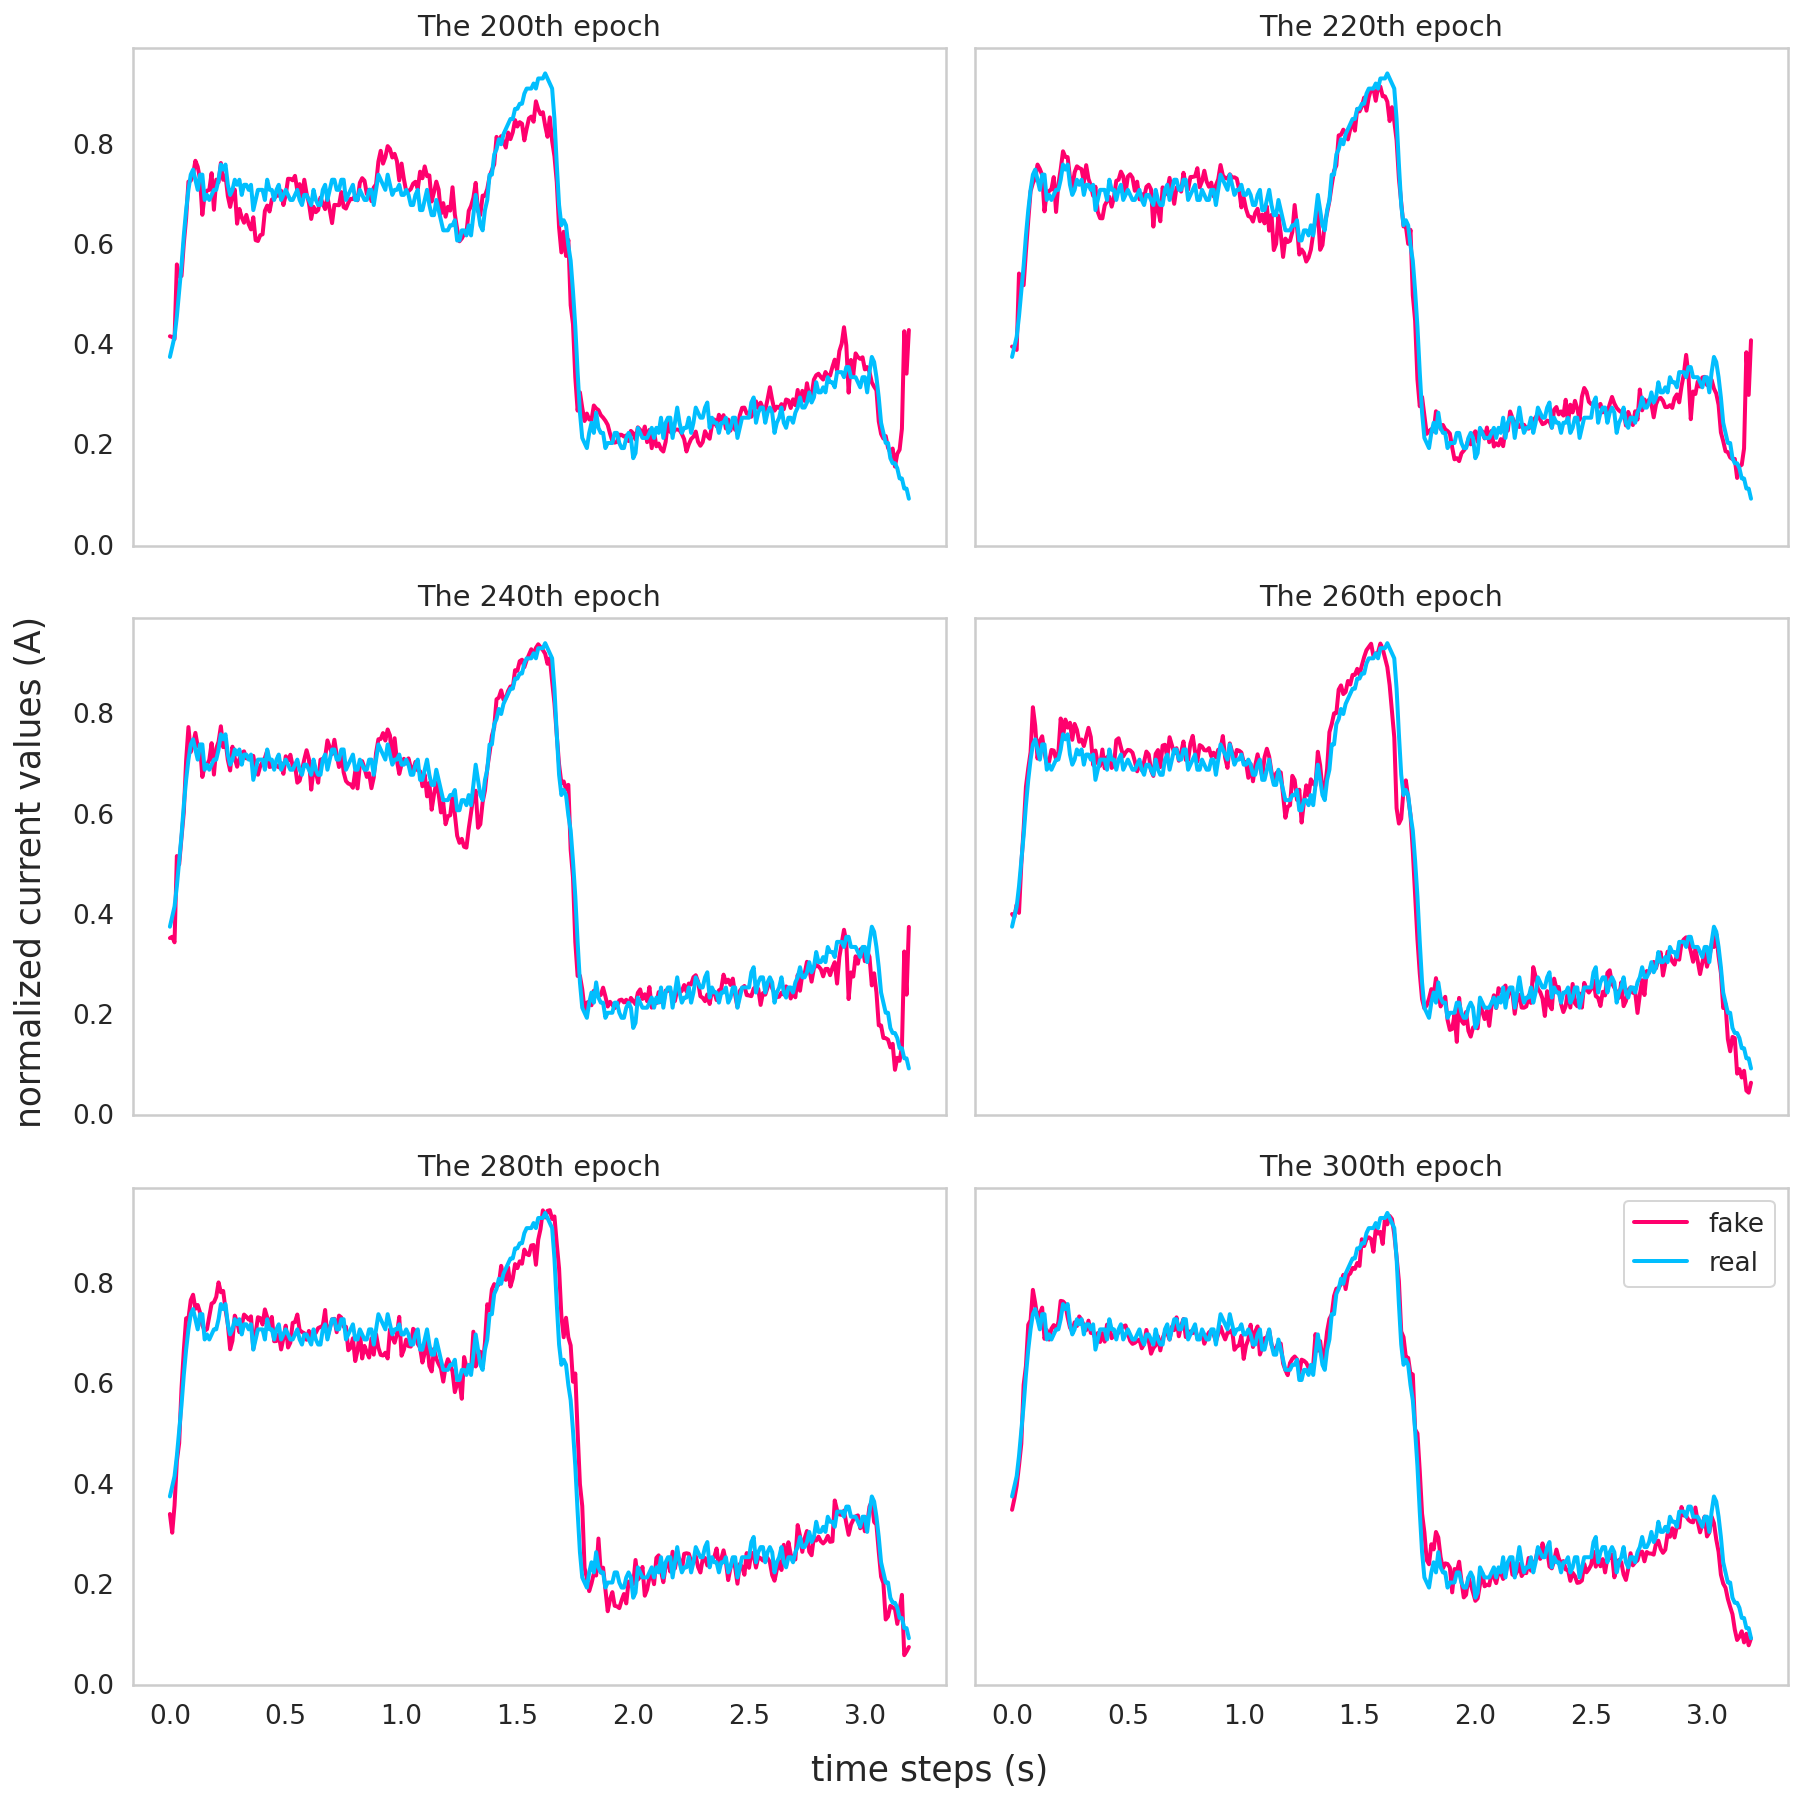

In [ ]:
generation_compare('Left', '025')
# generation_compare('Left', '020')
# generation_compare('Left', '015') 
# generation_compare('Left', '010')
# generation_compare('Left', '005')
# generation_compare('Normal', 'N')
# generation_compare('Normal', 'N_p005')
# generation_compare('Normal', 'N_p010')

In [ ]:
print(len(real_005_df))
print(len(real_010_df))
print(len(real_015_df))
print(len(real_020_df))
print(len(real_025_df))
print(len(real_N_df))
print(len(real_N_p005_df))
print(len(real_N_p010_df))

80
80
75
75
72
100
21
21


In [ ]:
# generate fake data and save to csv
def generate_data(label_name):
  nz = 100
  if label_name == 'N':
    real_data_path = real_N_path
    fake_data_path = fake_N_path
    num2generate = len(real_005_df) * 5
  elif label_name == 'N_p005':
    real_data_path = real_N_p005_path
    fake_data_path = fake_N_p005_path
    num2generate = len(real_005_df) * 5
  elif label_name == 'N_p010':
    real_data_path = real_N_p010_path
    fake_data_path = fake_N_p010_path
    num2generate = len(real_005_df) * 5
  elif label_name == '025':
    real_data_path = real_025_path
    fake_data_path = fake_025_path
    num2generate = len(real_005_df) * 5
  elif label_name == '020':
    real_data_path = real_020_path
    fake_data_path = fake_020_path
    num2generate = len(real_005_df) * 5
  elif label_name == '015':
    real_data_path = real_015_path
    fake_data_path = fake_015_path
    num2generate = len(real_005_df) * 5
  elif label_name == '010':
    real_data_path = real_010_path
    fake_data_path = fake_010_path
    num2generate = len(real_005_df) * 5
  elif label_name == '005':
    real_data_path = real_005_path
    fake_data_path = fake_005_path
    num2generate = len(real_005_df) * 5

  real_dataloader = get_dataloader(path=real_data_path, label_name=label_name, batch_size=32)
  real = next(iter(real_dataloader))[0]  # 12

  if label_name.startswith('N'):
    generator_dir = '/content/drive/MyDrive/dataset/checkpoint/WGAN_OLD/LinearFeedAxis_Normal/' + label_name + '/netG/'
  else:
    generator_dir = '/content/drive/MyDrive/dataset/checkpoint/WGAN_OLD/LinearFeedAxis_Anomaly/' + label_name + '/netG/'
  generator_paths = sorted_alphanumeric(os.listdir(generator_dir))

  res_df = pd.DataFrame()

  for generator_path in generator_paths[0:5]:
    if not generator_path.endswith('.pt'):
      continue
    # if generator_path.endswith('1.pt'):
    #   level = 1
    # elif generator_path.endswith('2.pt'):
    #   level = 2
    # elif generator_path.endswith('3.pt'):
    #   level = 3
    # elif generator_path.endswith('4.pt'):
    #   level = 4
    # elif generator_path.endswith('5.pt'):
    #   level = 5
    # else:
    #   continue

    g = Generator(nz)
    g.load_state_dict(torch.load(generator_dir+generator_path))
    tmp_df = pd.DataFrame()

    for i in range(num2generate):
      diff_sum = 999
      while diff_sum > 1.0:
        diff_sum = 0
        fixed_noise = torch.randn(1, 100, 1)
        fake = g(fixed_noise).detach().cpu()

        for i in range(real.shape[0]):
          diff = np.array(fake.detach().cpu().view(-1)) - np.array(real[i].detach().cpu().view(-1))
          diff = diff ** 2
          diff_sum += diff
        diff_sum = np.sum(diff_sum) / real.shape[0]

      tmp_df = tmp_df.append(pd.DataFrame(fake.detach().cpu().view(-1)).T, ignore_index=True)

    target = pd.DataFrame(data=int(next(iter(real_dataloader))[1][0]), index=range(num2generate), columns=range(1))
    tmp_df = pd.concat([tmp_df,target],axis = 1, ignore_index= True)
    res_df = pd.concat([res_df,tmp_df],axis = 0, ignore_index= True)
  res_df.reset_index(drop=True, inplace=True)
  res_df.to_csv(fake_data_path, index=False, header=False)

  return res_df

In [ ]:
# generate_data('N')
# generate_data('N_p005')
# generate_data('N_p010')
# generate_data('025')
# generate_data('020')
# generate_data('015')
# generate_data('010')
# generate_data('005')

# combine real and fake

In [46]:
real_025_df = pd.read_csv(real_025_path, header=None)
real_020_df = pd.read_csv(real_020_path, header=None)
real_015_df = pd.read_csv(real_015_path, header=None)
real_010_df = pd.read_csv(real_010_path, header=None)
real_005_df = pd.read_csv(real_005_path, header=None)
real_N_df = pd.read_csv(real_N_path, header=None)
real_N_p005_df = pd.read_csv(real_N_p005_path, header=None)
real_N_p010_df = pd.read_csv(real_N_p010_path, header=None)

In [47]:
real_df = pd.concat([real_025_df, real_020_df, real_015_df, real_010_df, real_005_df, real_N_df, real_N_p005_df, real_N_p010_df],axis = 0, ignore_index= True)
real_df.rename(columns={320: 'target'}, inplace=True)

# scaler_real = preprocessing.MinMaxScaler()
# scaler_real.fit(real_df.iloc[:,:-1].T)
# real_df.iloc[:,:-1] = scaler_real.transform(real_df.iloc[:,:-1].T).T

real_df.reset_index(drop=True)
# plt.plot(real_df.iloc[0,:-1])
# real_df = real_df.sample(frac=1.0)

0         1         2         3         4         5         6  \
0    0.383838  0.404040  0.444444  0.464646  0.525253  0.565657  0.646465   
1    0.373737  0.393939  0.414141  0.454545  0.505051  0.555556  0.616162   
2    0.363636  0.383838  0.414141  0.464646  0.494949  0.555556  0.616162   
3    0.373737  0.393939  0.434343  0.454545  0.505051  0.565657  0.616162   
4    0.535354  0.595960  0.656566  0.696970  0.737374  0.747475  0.717172   
..        ...       ...       ...       ...       ...       ...       ...   
519  0.404040  0.424242  0.434343  0.454545  0.474747  0.545455  0.606061   
520  0.565657  0.575758  0.606061  0.636364  0.696970  0.767677  0.858586   
521  0.565657  0.565657  0.585859  0.626263  0.676768  0.696970  0.696970   
522  0.252525  0.262626  0.282828  0.323232  0.373737  0.454545  0.535354   
523  0.484848  0.484848  0.515152  0.565657  0.606061  0.676768  0.727273   

            7         8         9  ...       311       312       313  \
0    0.676768  0.707071  0.747475  ...  0.181818  0.161616  0.151515   
1    0.666667  0.707071  0.737374  ...  0.171717  0.161616  0.161616   
2    0.676768  0.696970  0.747475  ...  0.181818  0.151515  0.171717   
3    0.656566  0.707071  0.757576  ...  0.171717  0.161616  0.151515   
4    0.686869  0.727273  0.747475  ...  0.111111  0.101010  0.101010   
..        ...       ...       ...  ...       ...       ...       ...   
519  0.686869  0.727273  0.737374  ...  0.292929  0.292929  0.282828   
520  0.858586  0.787879  0.707071  ...  0.292929  0.292929  0.292929   
521  0.707071  0.707071  0.686869  ...  0.292929  0.292929  0.272727   
522  0.646465  0.727273  0.757576  ...  0.292929  0.282828  0.282828   
523  0.727273  0.717172  0.707071  ...  0.292929  0.292929  0.292929   

          314       315       316       317       318       319  target  
0    0.161616  0.141414  0.131313  0.111111  0.111111  0.101010     0.0  
1    0.151515  0.131313  0.131313  0.111111  0.111111  0.090909     0.0  
2    0.151515  0.141414  0.131313  0.121212  0.111111  0.111111     0.0  
3    0.141414  0.141414  0.121212  0.111111  0.111111  0.090909     0.0  
4    0.090909  0.080808  0.070707  0.060606  0.060606  0.050505     0.0  
..        ...       ...       ...       ...       ...       ...     ...  
519  0.282828  0.272727  0.272727  0.262626  0.262626  0.262626     1.0  
520  0.282828  0.272727  0.272727  0.262626  0.262626  0.262626     1.0  
521  0.272727  0.272727  0.272727  0.262626  0.252525  0.252525     1.0  
522  0.282828  0.272727  0.272727  0.272727  0.262626  0.252525     1.0  
523  0.292929  0.272727  0.272727  0.272727  0.272727  0.262626     1.0  

[524 rows x 321 columns]

In [48]:
# real_normal_df = real_df[real_df.target==class_to_id['Normal']].drop(labels='target', axis=1)
# real_anomaly_df = real_df[real_df.target==class_to_id['Left']].drop(labels='target', axis=1)
real_normal_df = real_df[real_df.target==class_to_id['Normal']]
real_anomaly_df = real_df[real_df.target==class_to_id['Left']]

In [49]:
fake_025_df = pd.read_csv(fake_025_path, header=None)
fake_020_df = pd.read_csv(fake_020_path, header=None)
fake_015_df = pd.read_csv(fake_015_path, header=None)
fake_010_df = pd.read_csv(fake_010_path, header=None)
fake_005_df = pd.read_csv(fake_005_path, header=None)
fake_N_df = pd.read_csv(fake_N_path, header=None)
fake_N_p005_df = pd.read_csv(fake_N_p005_path, header=None)
fake_N_p010_df = pd.read_csv(fake_N_p010_path, header=None)

In [50]:
# lineWidth = 0.5
# plt.figure(dpi=150)

# indexes, values = prepare_axies(fake_005_df.iloc[0,:-1], sampling_frequency)
# plt.plot(indexes, values, label = 'left 0.05mm', lw = lineWidth)

# indexes, values = prepare_axies(fake_010_df.iloc[0,:-1], sampling_frequency)
# plt.plot(indexes, values, label = 'left 0.10mm', lw = lineWidth)

# indexes, values = prepare_axies(fake_015_df.iloc[0,:-1], sampling_frequency)
# plt.plot(indexes, values, label = 'left 0.15mm', lw = lineWidth)

# indexes, values = prepare_axies(fake_020_df.iloc[0,:-1], sampling_frequency)
# plt.plot(indexes, values, label = 'left 0.20mm', lw = lineWidth)

# indexes, values = prepare_axies(fake_025_df.iloc[0,:-1], sampling_frequency)
# plt.plot(indexes, values, label = 'left 0.25mm', lw = lineWidth)

# indexes, values = prepare_axies(fake_N_df.iloc[0,:-1], sampling_frequency)
# plt.plot(indexes, values, label = 'Normal', lw = lineWidth)

# plt.grid(b=None)
# plt.legend()
# plt.xlabel("time steps (s)")
# plt.ylabel("normalized current values (A)")
# plt.title(' fake data')
# plt.show()

In [51]:
fake_df = pd.concat([fake_025_df, fake_020_df, fake_015_df, fake_010_df, fake_005_df, fake_N_df, fake_N_p005_df, fake_N_p010_df],axis = 0, ignore_index= True)
fake_df.rename(columns={320: 'target'}, inplace=True)

# scaler_fake = preprocessing.MinMaxScaler()
# scaler_fake.fit(fake_df.iloc[:,:-1].T)
# fake_df.iloc[:,:-1] = scaler_fake.transform(fake_df.iloc[:,:-1].T).T

fake_df.reset_index(drop=True)
# plt.plot(test_df.iloc[0,:-1])
# fake_df = fake_df.sample(frac=1.0)

0         1         2         3         4         5         6  \
0      0.330971  0.329647  0.354574  0.375091  0.426550  0.535392  0.578719   
1      0.341303  0.361075  0.380809  0.459521  0.503175  0.578205  0.615467   
2      0.336205  0.354567  0.373861  0.418764  0.472593  0.580817  0.615041   
3      0.350262  0.384901  0.410095  0.496680  0.536534  0.631994  0.672319   
4      0.343145  0.366329  0.396680  0.424643  0.469521  0.571101  0.608225   
...         ...       ...       ...       ...       ...       ...       ...   
15995  0.528659  0.545130  0.587304  0.683772  0.700192  0.713444  0.706730   
15996  0.471029  0.456098  0.514500  0.584796  0.626365  0.670811  0.685796   
15997  0.495451  0.498013  0.552863  0.637192  0.662460  0.684076  0.682364   
15998  0.469715  0.460369  0.512906  0.587906  0.612102  0.675820  0.678505   
15999  0.514481  0.514602  0.556192  0.629570  0.653367  0.699417  0.689878   

              7         8         9  ...       311       312       313  \
0      0.668522  0.694603  0.777600  ...  0.134482  0.110039  0.092459   
1      0.676750  0.712440  0.773559  ...  0.136212  0.106266  0.090947   
2      0.692522  0.706880  0.770022  ...  0.138002  0.110859  0.088631   
3      0.731778  0.753536  0.792278  ...  0.136273  0.107276  0.089202   
4      0.696513  0.712797  0.764722  ...  0.148718  0.124153  0.096307   
...         ...       ...       ...  ...       ...       ...       ...   
15995  0.694336  0.707373  0.695330  ...  0.250268  0.229789  0.250742   
15996  0.714380  0.702315  0.705069  ...  0.234994  0.210069  0.227875   
15997  0.671487  0.670186  0.687458  ...  0.254048  0.230654  0.250538   
15998  0.686990  0.692027  0.697142  ...  0.256019  0.229094  0.255702   
15999  0.681278  0.671993  0.671638  ...  0.245829  0.221603  0.238880   

            314       315       316       317       318       319  target  
0      0.103261  0.113133  0.087904  0.104651  0.078479  0.090424       0  
1      0.085810  0.107109  0.088247  0.105433  0.084613  0.095373       0  
2      0.094906  0.108145  0.088416  0.104553  0.082304  0.099503       0  
3      0.087625  0.112434  0.094137  0.112727  0.085002  0.100560       0  
4      0.103726  0.113672  0.090967  0.108320  0.084493  0.101515       0  
...         ...       ...       ...       ...       ...       ...     ...  
15995  0.231595  0.242487  0.228298  0.218948  0.213235  0.194574       1  
15996  0.231982  0.227368  0.207746  0.207516  0.202536  0.191480       1  
15997  0.238030  0.246856  0.236942  0.218860  0.213988  0.197887       1  
15998  0.245518  0.250512  0.234185  0.223488  0.211988  0.196270       1  
15999  0.232642  0.232951  0.221769  0.212496  0.205744  0.190452       1  

[16000 rows x 321 columns]

In [52]:
fake_normal_df = fake_df[fake_df.target==class_to_id['Normal']]
fake_anomaly_df = fake_df[fake_df.target==class_to_id['Left']]

In [53]:
all_df = pd.concat([real_df, fake_df],axis = 0, ignore_index= True)

In [54]:
real_df.target.value_counts()

0.0    382
1.0    142
Name: target, dtype: int64

In [55]:
fake_df.target.value_counts()

0    10000
1     6000
Name: target, dtype: int64

In [56]:
all_df.target.value_counts()

0.0    10382
1.0     6142
Name: target, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'left'), Text(0, 0, 'normal')]

Text(-0.050000000000000044, 382.05, '382.0')

Text(0.95, 142.05, '142.0')

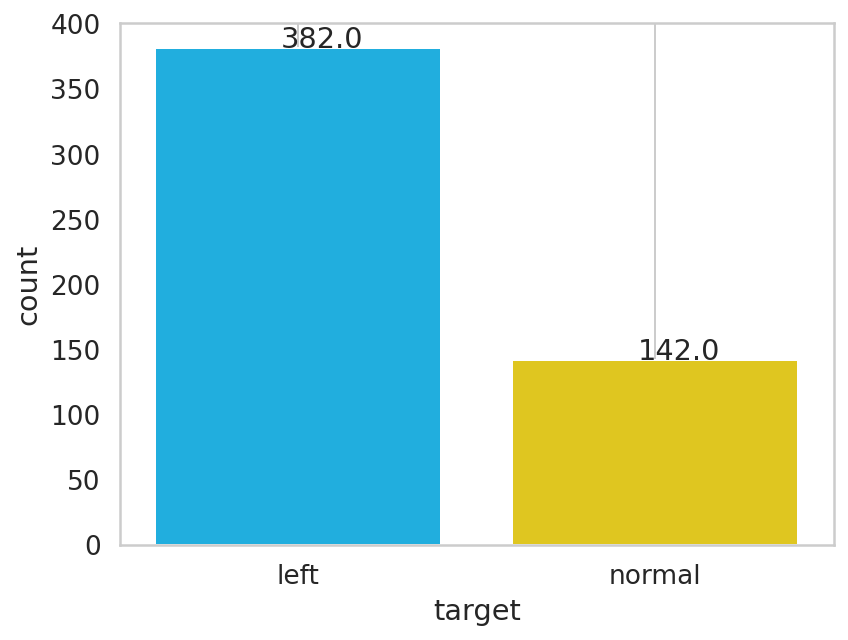

In [57]:
ax = sns.countplot(real_df.target)
ax.set_xticklabels(class_names)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.05))
plt.grid(None)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'left'), Text(0, 0, 'normal')]

Text(-0.050000000000000044, 10000.05, '10000.0')

Text(0.95, 6000.05, '6000.0')

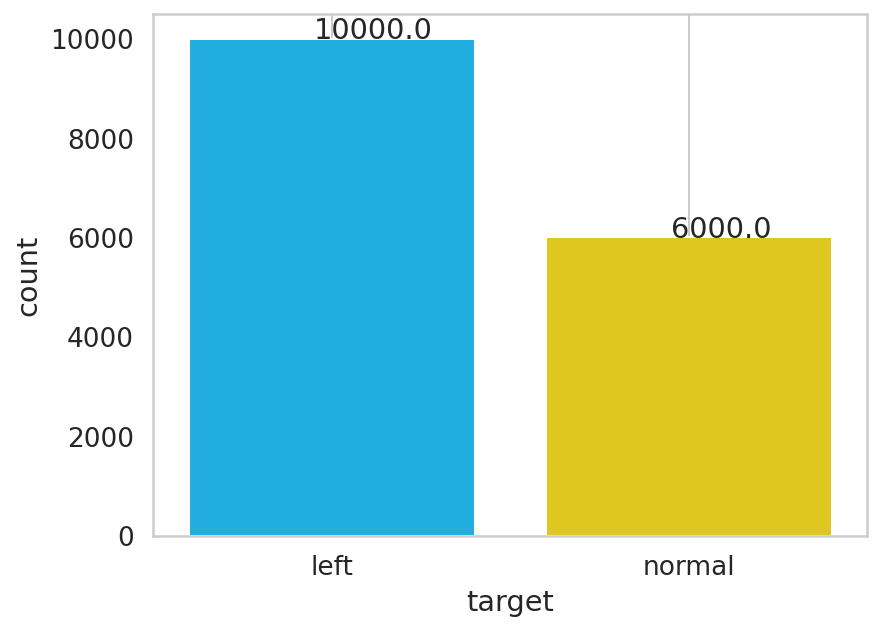

In [58]:
ax = sns.countplot(fake_df.target)
ax.set_xticklabels(class_names)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.05))
plt.grid(None)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'left'), Text(0, 0, 'normal')]

Text(-0.050000000000000044, 10382.05, '10382.0')

Text(0.95, 6142.05, '6142.0')

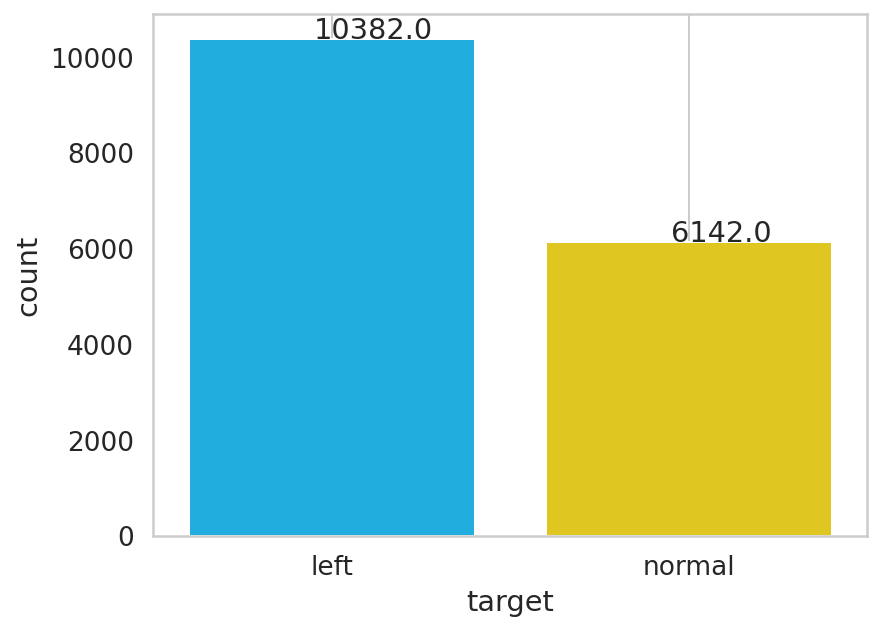

In [59]:
ax = sns.countplot(all_df.target)
ax.set_xticklabels(class_names)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.05))
plt.grid(None)
plt.show()

# compare and generate

In [ ]:
# compare real and fake
def data_compare(label_class):
  line_width = 2
  plt.figure(dpi=150)

  if label_class == 'N':
    real_data_path = real_N_path
    fake_data_path = fake_N_path
  elif label_class == 'N_p005':
    real_data_path = real_N_p005_path
    fake_data_path = fake_N_p005_path
  elif label_class == 'N_p010':
    real_data_path = real_N_p010_path
    fake_data_path = fake_N_p010_path
  elif label_class == '025':
    real_data_path = real_025_path
    fake_data_path = fake_025_path
  elif label_class == '020':
    real_data_path = real_020_path
    fake_data_path = fake_020_path
  elif label_class == '015':
    real_data_path = real_015_path
    fake_data_path = fake_015_path
  elif label_class == '010':
    real_data_path = real_010_path
    fake_data_path = fake_010_path
  elif label_class == '005':
    real_data_path = real_005_path
    fake_data_path = fake_005_path

  real_dataloader = get_dataloader(path=real_data_path, label_name=label_class, batch_size=32)
  fake_dataloader = get_dataloader(path=fake_data_path, label_name=label_class, batch_size=32)

  real = next(iter(real_dataloader))[0]
  fake = next(iter(fake_dataloader))[0]

  fig, ax = plt.subplots()
  indexes, values = prepare_axies(fake[0].view(-1), sampling_frequency)
  ax.plot(indexes, values, label='fake', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][3], linewidth=line_width)

  indexes, values = prepare_axies(real[0].view(-1), sampling_frequency)
  ax.plot(indexes, values, label='real', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], linewidth=line_width)
  ax.set_xlabel("time steps (S)")
  ax.set_ylabel("normalized current value (A)")
  ax.set_title(label_class)
  plt.grid(b=None)
  plt.legend()
  plt.show()

In [ ]:
# data_compare('N')
# data_compare('N_p005')
# data_compare('N_p010')
# data_compare('025')
# data_compare('020')
# data_compare('015')
# data_compare('010')
# data_compare('005')

In [ ]:
# # compare all real and fake data in one figure
# def data_compare_all():
#   real_N_dataloader = get_dataloader(path=real_N_path, label_name='N', batch_size=32)
#   fake_N_dataloader = get_dataloader(path=fake_N_path, label_name='N', batch_size=32)

#   real_005_dataloader = get_dataloader(path=real_005_path, label_name='005', batch_size=32)
#   fake_005_dataloader = get_dataloader(path=fake_005_path, label_name='005', batch_size=32)

#   real_010_dataloader = get_dataloader(path=real_010_path, label_name='010', batch_size=32)
#   fake_010_dataloader = get_dataloader(path=fake_010_path, label_name='010', batch_size=32)

#   real_015_dataloader = get_dataloader(path=real_015_path, label_name='015', batch_size=32)
#   fake_015_dataloader = get_dataloader(path=fake_015_path, label_name='015', batch_size=32)

#   real_020_dataloader = get_dataloader(path=real_020_path, label_name='020', batch_size=32)
#   fake_020_dataloader = get_dataloader(path=fake_020_path, label_name='020', batch_size=32)

#   real_025_dataloader = get_dataloader(path=real_025_path, label_name='025', batch_size=32)
#   fake_025_dataloader = get_dataloader(path=fake_025_path, label_name='025', batch_size=32)

#   num_x = 3
#   num_y = 2
#   line_width = 2
  
#   fig, axs = plt.subplots(nrows=num_x, ncols=num_y, sharey=True, sharex=True, constrained_layout=True, figsize=(12,12))

#   fig.suptitle('Generation performances', fontsize='large')

#   real = next(iter(real_N_dataloader))[0]
#   fake = next(iter(fake_N_dataloader))[0]
#   indexes, values = prepare_axies(real[0], sampling_frequency)
#   axs[0][0].plot(indexes, values, label='fake', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][3], linewidth=line_width)
#   indexes, values = prepare_axies(fake[0], sampling_frequency)
#   axs[0][0].plot(indexes, values, label='real', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], linewidth=line_width)
#   axs[0][0].grid(None)
#   axs[0][0].set_title('N')

#   real = next(iter(real_005_dataloader))[0]
#   fake = next(iter(fake_005_dataloader))[0]
#   indexes, values = prepare_axies(real[0], sampling_frequency)
#   axs[0][1].plot(indexes, values, label='fake', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][3], linewidth=line_width)
#   indexes, values = prepare_axies(fake[0], sampling_frequency)
#   axs[0][1].plot(indexes, values, label='real', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], linewidth=line_width)
#   axs[0][1].grid(None)
#   axs[0][1].set_title('005')

#   real = next(iter(real_010_dataloader))[0]
#   fake = next(iter(fake_010_dataloader))[0]
#   indexes, values = prepare_axies(real[0], sampling_frequency)
#   axs[1][0].plot(indexes, values, label='fake', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][3], linewidth=line_width)
#   indexes, values = prepare_axies(fake[0], sampling_frequency)
#   axs[1][0].plot(indexes, values, label='real', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], linewidth=line_width)
#   axs[1][0].grid(None)
#   axs[1][0].set_title('010')

#   real = next(iter(real_015_dataloader))[0]
#   fake = next(iter(fake_015_dataloader))[0]
#   indexes, values = prepare_axies(real[0], sampling_frequency)
#   axs[1][1].plot(indexes, values, label='fake', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][3], linewidth=line_width)
#   indexes, values = prepare_axies(fake[0], sampling_frequency)
#   axs[1][1].plot(indexes, values, label='real', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], linewidth=line_width)
#   axs[1][1].grid(None)
#   axs[1][1].set_title('015')

#   real = next(iter(real_020_dataloader))[0]
#   fake = next(iter(fake_020_dataloader))[0]
#   indexes, values = prepare_axies(real[0], sampling_frequency)
#   axs[2][0].plot(indexes, values, label='fake', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][3], linewidth=line_width)
#   indexes, values = prepare_axies(fake[0], sampling_frequency)
#   axs[2][0].plot(indexes, values, label='real', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], linewidth=line_width)
#   axs[2][0].grid(None)
#   axs[2][0].set_title('020')

#   real = next(iter(real_025_dataloader))[0]
#   fake = next(iter(fake_025_dataloader))[0]
#   indexes, values = prepare_axies(real[0], sampling_frequency)
#   axs[2][1].plot(indexes, values, label='fake', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][3], linewidth=line_width)
#   indexes, values = prepare_axies(fake[0], sampling_frequency)
#   axs[2][1].plot(indexes, values, label='real', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], linewidth=line_width)
#   axs[2][1].grid(None)
#   axs[2][1].set_title('025')


#   fig.text(0.5,-0.02, "time steps (s)", ha="center", va="center")
#   fig.text(-0.02,0.5, "normalized current values (A)", ha="center", va="center", rotation=90)
#   plt.legend()
#   plt.show()

In [ ]:
# data_compare_all()

In [ ]:
def visualization_one_kind(label_name, analysis_type, ax):
  batch_size = 42
  if label_name == 'N':
    real_df = real_N_df
    fake_df = fake_N_df
    show_label = 'Normal'
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
  elif label_name == 'N_p005':
    real_df = real_N_p005_df
    fake_df = fake_N_p005_df
    show_label = 'Normal with 10N'
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
  elif label_name == 'N_p010':
    real_df = real_N_p010_df
    fake_df = fake_N_p010_df
    show_label = 'Normal with 25N'
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
  elif label_name == '005':
    real_df = real_005_df
    fake_df = fake_005_df
    show_label = 'left 0.05mm'
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
  elif label_name == '010':
    real_df = real_010_df
    fake_df = fake_010_df
    show_label = 'left 0.10mm'
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
  elif label_name == '015':
    real_df = real_015_df
    fake_df = fake_015_df
    show_label = 'left 0.15mm'
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
  elif label_name == '020':
    real_df = real_020_df
    fake_df = fake_020_df
    show_label = 'left 0.20mm'
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][4]
  elif label_name == '025':
    real_df = real_025_df
    fake_df = fake_025_df
    show_label = 'left 0.25mm'
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][5]

  df = pd.concat([real_df, fake_df],axis = 0, ignore_index= True)
  df.rename(columns={320: 'target'}, inplace=True)
  df = df.drop(labels='target', axis=1).iloc[:batch_size,:]

  rgb = (random.random(), random.random(), random.random())
  rgb = np.array([rgb])

  if analysis_type == 'pca':
      pca = PCA(n_components=2, random_state=RANDOM_SEED)
      pca_results = pca.fit_transform(df)

      ax.scatter(pca_results[:, 0],
            pca_results[:, 1],
            c=color,
            label=show_label)

  elif analysis_type == 'tsne':
      tsne = TSNE(n_components=2, random_state=RANDOM_SEED, n_jobs=-1,
                  init='random', learning_rate='auto')
      tsne_results = tsne.fit_transform(df)

      ax.scatter(tsne_results[:, 0],
            tsne_results[:, 1],
            c=color,
            label=show_label)
        
def visualization_compare_all_kinds(analysis_type, visualization_type):
    if visualization_type == '3d':
      plt.figure(dpi=150)
      ax = plt.axes(projection='3d')
    elif visualization_type == '2d':
      fig, ax = plt.subplots(dpi = 150)
    visualization_one_kind('N', analysis_type, ax)
    visualization_one_kind('N_p005', analysis_type, ax)
    visualization_one_kind('N_p010', analysis_type, ax)
    visualization_one_kind('005', analysis_type, ax)
    visualization_one_kind('010', analysis_type, ax)
    visualization_one_kind('015', analysis_type, ax)
    visualization_one_kind('020', analysis_type, ax)
    visualization_one_kind('025', analysis_type, ax)
    plt.title(analysis_type)
    # plt.axis('off')
    plt.grid(None)
    plt.legend(loc=2,prop={'size': 8})
    plt.show()

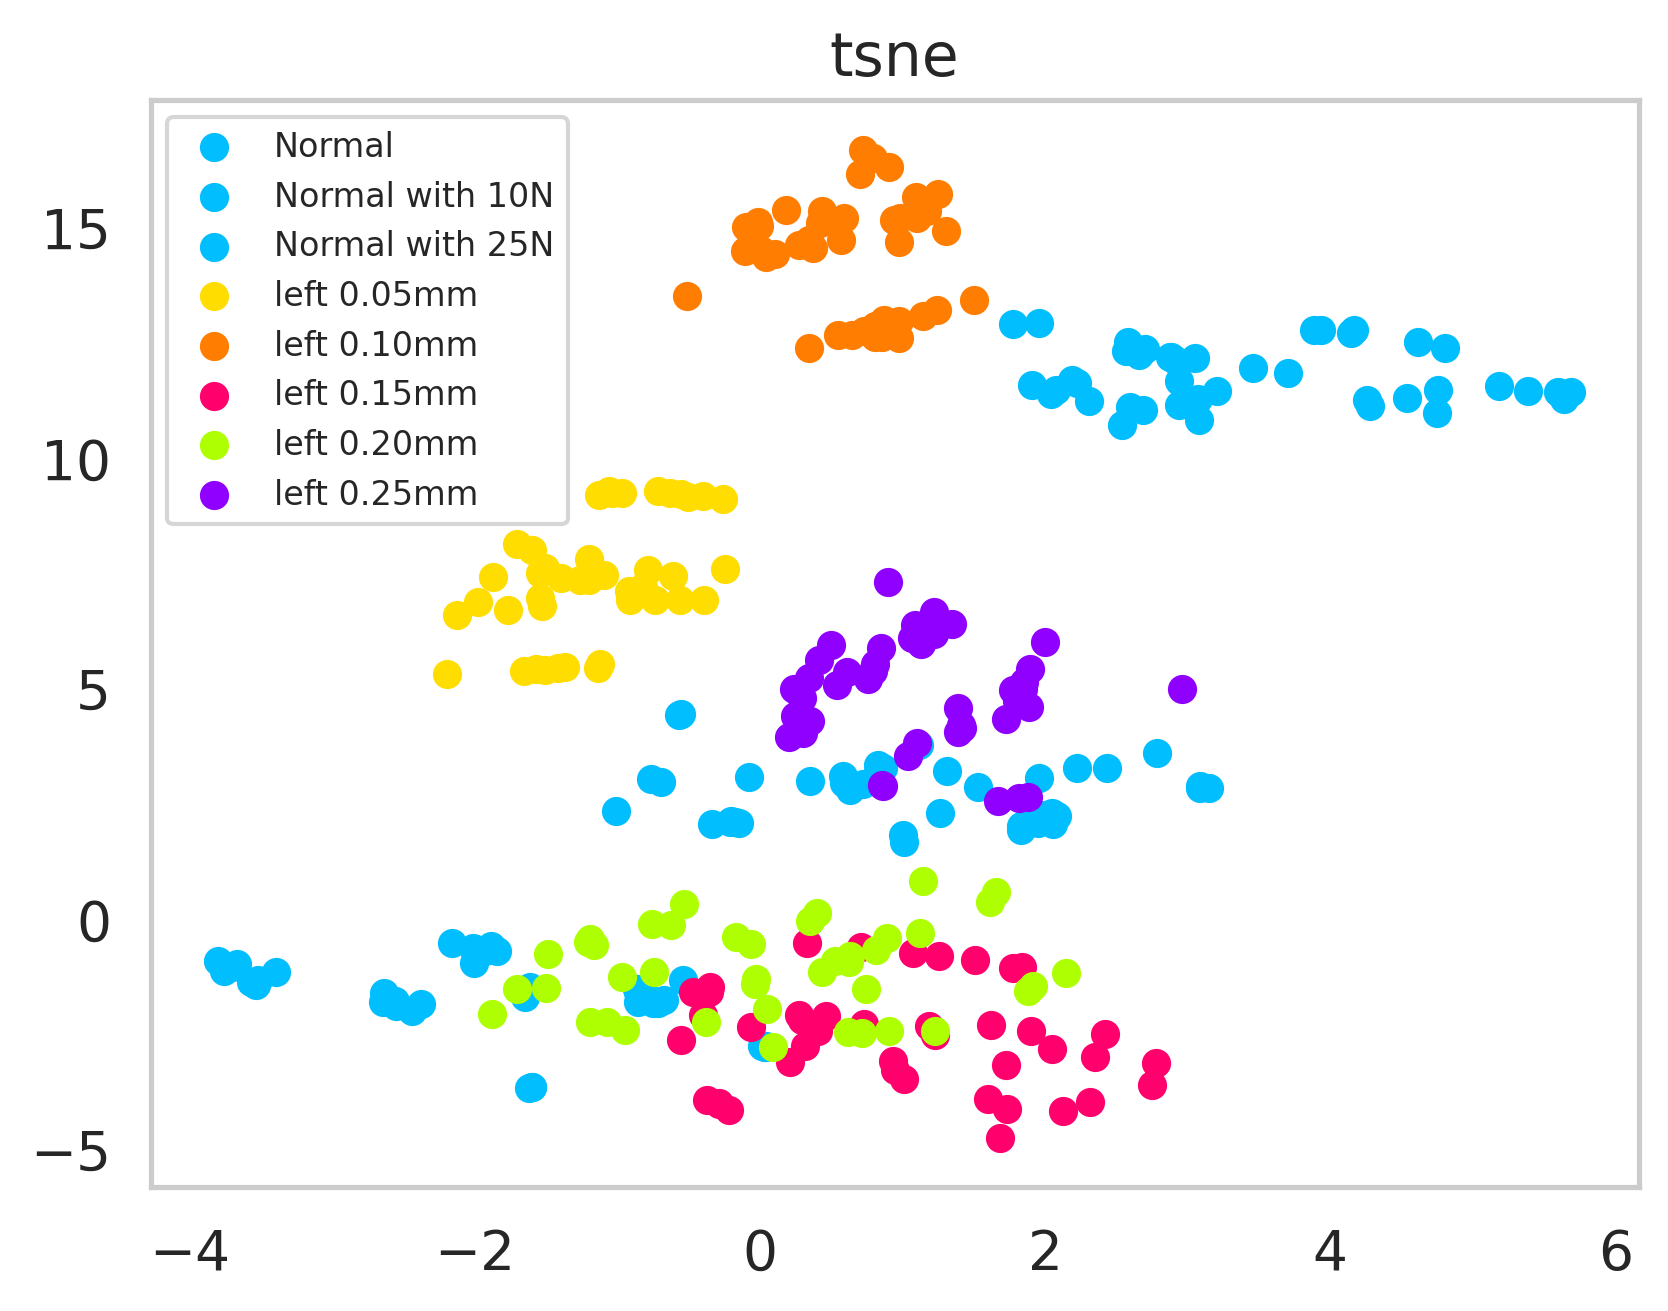

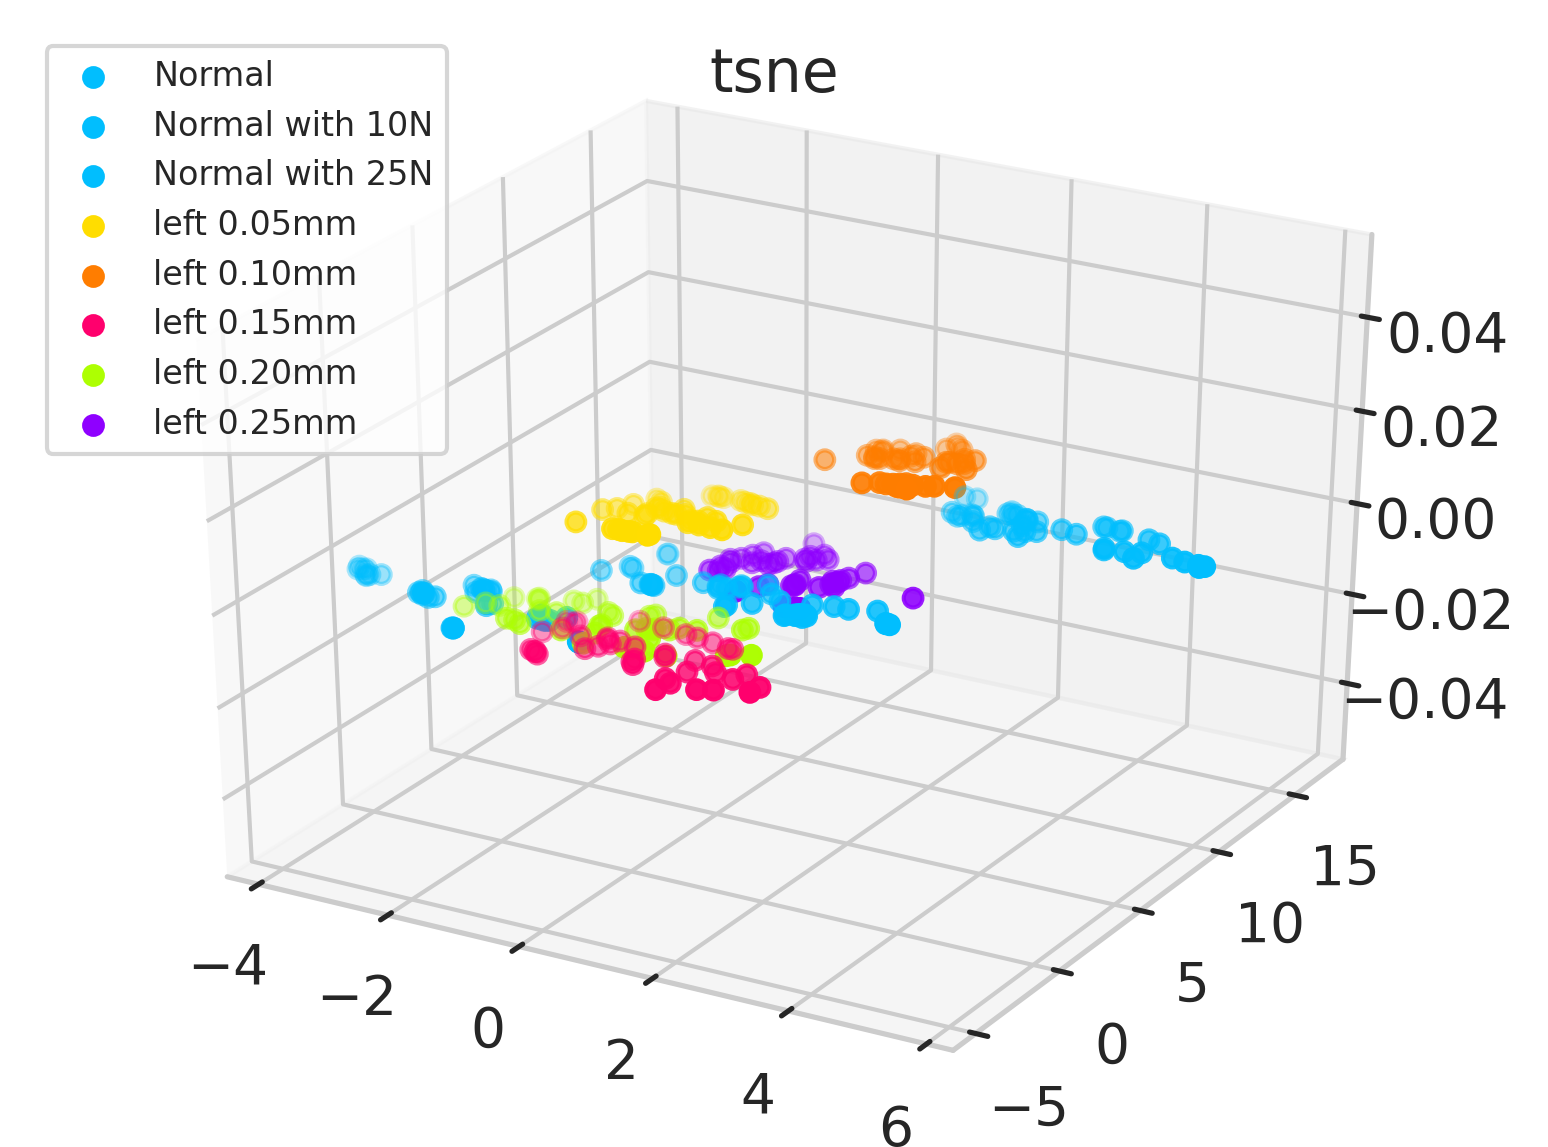

In [ ]:
# visualization_compare_all_kinds('pca', '2d')
# visualization_compare_all_kinds('pca', '3d')

visualization_compare_all_kinds('tsne', '2d')
visualization_compare_all_kinds('tsne', '3d')

In [ ]:
def visualization_compare_normal_anomaly(df_type, analysis_type, visualization_type):
    if visualization_type == '3d':
      plt.figure(dpi=150)
      ax = plt.axes(projection='3d')
    elif visualization_type == '2d':
      fig, ax = plt.subplots(dpi = 150)
    if df_type == 'all':
      df = all_df
    elif df_type == 'real':
      df = real_df
    else:
      df = fake_df
    normal_data = df[df.target==class_to_id['Normal']].drop(labels='target', axis=1)
    anomaly_data = df[df.target==class_to_id['Left']].drop(labels='target', axis=1)

    normal_no = len(normal_data)
    anomaly_no = len(anomaly_data)
    colors = [plt.rcParams['axes.prop_cycle'].by_key()['color'][0] for i in range(normal_no)] + [plt.rcParams['axes.prop_cycle'].by_key()['color'][3] for i in range(anomaly_no)]

    if analysis_type == 'pca':       
        all = np.concatenate((normal_data, anomaly_data), axis=0)
        pca = PCA(n_components=2, random_state=RANDOM_SEED)

        pca_results = pca.fit_transform(all)

        ax.scatter(pca_results[:normal_no, 0],
              pca_results[:normal_no, 1],
              c=colors[:normal_no],
              label='normal')
        ax.scatter(pca_results[normal_no:, 0],
              pca_results[normal_no:, 1],
              c=colors[normal_no:],
              label="anomaly")
        
        # pca_normal_results = pca.fit_transform(normal_data)
        # pca_anomaly_results = pca.transform(anomaly_data)
        
        # ax.scatter(pca_normal_results[:, 0],
        #       pca_normal_results[:, 1],
        #       c=colors[:normal_no],
        #       label="normal")
        # ax.scatter(pca_anomaly_results[:, 0],
        #       pca_anomaly_results[:, 1],
        #       c=colors[normal_no:],
        #       label="anomaly")

    elif analysis_type == 'tsne':
        all = np.concatenate((normal_data, anomaly_data), axis=0)
        tsne = TSNE(n_components=2, random_state=RANDOM_SEED, n_jobs=-1,
               init='random', learning_rate='auto')
        tsne_results = tsne.fit_transform(all)

        ax.scatter(tsne_results[:normal_no, 0],
              tsne_results[:normal_no, 1],
              c=colors[:normal_no],
              label='normal')
        ax.scatter(tsne_results[normal_no:, 0],
              tsne_results[normal_no:, 1],
              c=colors[normal_no:],
              label="anomaly")

    plt.title(analysis_type)
    # plt.axis('off')
    plt.grid(None)
    plt.legend(loc=2,prop={'size': 8})
    plt.show()

In [ ]:
# visualization_compare_normal_anomaly('all', 'pca', '2d')
# visualization_compare_normal_anomaly('all', 'pca', '3d')

# visualization_compare_normal_anomaly('all', 'tsne', '3d')
# visualization_compare_normal_anomaly('all', 'tsne', '2d')

In [ ]:
######################################################
train_process = 'TSTR'

# TATA
if train_process == 'TATA':
  train_normal_df = all_df[all_df.target == CLASS_NORMAL]

  test_normal_df = all_df[all_df.target == CLASS_NORMAL]
  test_anomaly_df = all_df[all_df.target == CLASS_LEFT]

# TRTR
elif train_process == 'TRTR':
  train_normal_df = real_df[real_df.target == CLASS_NORMAL]

  test_normal_df = real_df[real_df.target == CLASS_NORMAL]
  test_anomaly_df = real_df[real_df.target == CLASS_LEFT]

# TSTS
elif train_process == 'TSTS':
  train_normal_df = fake_df[fake_df.target == CLASS_NORMAL]

  test_normal_df = fake_df[fake_df.target == CLASS_NORMAL]
  test_anomaly_df = fake_df[fake_df.target == CLASS_LEFT]

# TRTS
elif train_process == 'TRTS':
  train_normal_df = real_df[real_df.target == CLASS_NORMAL]

  test_normal_df = fake_df[fake_df.target == CLASS_NORMAL]
  test_anomaly_df = fake_df[fake_df.target == CLASS_LEFT]

# TSTR
elif train_process == 'TSTR':
  train_normal_df = fake_df[fake_df.target == CLASS_NORMAL]

  test_normal_df = real_df[real_df.target == CLASS_NORMAL]
  test_anomaly_df = real_df[real_df.target == CLASS_LEFT]

##############################################

train_normal_df, val_normal_df = train_test_split(
  train_normal_df,
  test_size=0.33,       #0.15
  random_state=RANDOM_SEED
)

# _, test_df = train_test_split(
#   val_df,
#   test_size=0.33,
#   random_state=RANDOM_SEED
# )

print(train_normal_df.shape)
print(val_normal_df.shape)

print(test_normal_df.shape)
print(test_anomaly_df.shape)

def create_cycle_dataset(df):
  x_values = []
  y_values = []
  for i in range(len(df)):
    x = df.iloc[i,:-1].values
    y = df.iloc[i,-1]
    x_values.append(x)
    y_values.append(y)

  x = [torch.tensor(x).unsqueeze(1).float() for x in x_values]
  y = [torch.tensor(y).unsqueeze(0).float() for y in y_values]
  x = torch.stack(x)
  y = torch.stack(y)

  n_seq, seq_len, n_features = x.shape
  return x, y, seq_len, n_features


trainX, trainY, seq_len, n_features = create_cycle_dataset(train_normal_df)
print(trainX.shape)
valX, valY, _, _ = create_cycle_dataset(val_normal_df)
print(valX.shape)

test_normal_X, test_normal_Y, _, _ = create_cycle_dataset(test_normal_df)
print(test_normal_X.shape)
test_left_X, test_left_Y, _, _ = create_cycle_dataset(test_anomaly_df)
print(test_left_X.shape)





batch_size = 128

# Dataset = TensorDataset(X, Y)
# Dataloader = DataLoader(Dataset, batch_size=batch_size, shuffle=True)

trainDataset = TensorDataset(trainX, trainY)
trainDataloader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)

valDataset = TensorDataset(valX, valY)
valDataloader = DataLoader(valDataset, batch_size=batch_size, shuffle=True)

# testDataset = TensorDataset(testX, testY)
# testDataloader = DataLoader(testDataset, batch_size=batch_size, shuffle=True)

testLeftDataset = TensorDataset(test_left_X, test_left_Y)
testLeftDataloader = DataLoader(testLeftDataset, batch_size=batch_size, shuffle=True)

testNormalDataset = TensorDataset(test_normal_X, test_normal_Y)
testNormalDataloader = DataLoader(testNormalDataset, batch_size=batch_size, shuffle=True)

(4020, 321)
(1980, 321)
(142, 321)
(382, 321)
torch.Size([4020, 320, 1])
torch.Size([1980, 320, 1])
torch.Size([142, 320, 1])
torch.Size([382, 320, 1])


# hypertuning of AE

the class below is designed for hyperparameter tuning of cnn-autoencoder 

In [60]:
class CnnAutoencoderTest(nn.Module):
  def __init__(
    self,
    trial,
    seq_len=320,
    input_size=1,
    num_kernal=8,
    kernel_size=3,
  ):
    self.num_kernal = trial.suggest_int("num_kernal", 16, 256, step=16)
    # self.kernel_size = trial.suggest_int("kernel_size", 4, 12, step=2)
    self.kernel_size = 4
    
    super().__init__()
    self.enc_layer1 = self.Conv1d_block(in_channels = 1, out_channels = self.num_kernal, kernel_size = self.kernel_size)
    self.enc_layer2 = self.Conv1d_block(in_channels = self.num_kernal, out_channels = self.num_kernal*2, kernel_size = self.kernel_size)
    self.enc_layer3 = self.Conv1d_block(in_channels = self.num_kernal*2, out_channels = self.num_kernal*4, kernel_size = self.kernel_size)
    
    self.dec_layer4 = self.ConvTranspose1d(in_channels = self.num_kernal*4, out_channels = self.num_kernal*2, kernel_size = self.kernel_size)
    self.dec_layer5 = self.ConvTranspose1d(in_channels = self.num_kernal*2, out_channels = self.num_kernal, kernel_size = self.kernel_size)
    self.dec_layer6 = self.ConvTranspose1d(in_channels = self.num_kernal, out_channels = 1, kernel_size = self.kernel_size+2)

    self.relu = torch.nn.ReLU()
    self.leakyRelu = nn.LeakyReLU(0.2, inplace=True)

  def Conv1d_block(self, in_channels, out_channels, kernel_size, stride=2, padding=0):
    return nn.Sequential(
      nn.Conv1d(
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        bias=False,
      ),
      nn.BatchNorm1d(out_channels),
      nn.LeakyReLU(0.2, inplace=True),
    )
  def ConvTranspose1d(self, in_channels, out_channels, kernel_size, stride=2, padding=0):
    return nn.Sequential(
      nn.ConvTranspose1d(
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        bias=False,
      ),
      nn.BatchNorm1d(out_channels),
      nn.LeakyReLU(0.2, inplace=True),
    )      
  def forward(self, x):
    output = x.permute(0,2,1)
    output = self.enc_layer1(output)
    # print(output.shape)
    output = self.enc_layer2(output)
    # print(output.shape)
    output = self.enc_layer3(output)
    # print(output.shape)
    output = self.dec_layer4(output)
    # print(output.shape)
    output = self.dec_layer5(output)
    # print(output.shape)
    output = self.dec_layer6(output)
    # print(output.shape)
    output = output.permute(0,2,1)
    return output

the class below is designed for hyperparameter tuning of tcn-autoencoder 

In [61]:
class TcnAutoencoderTest(nn.Module):
  def __init__(
    self,
    trial,
    seq_len=320,
  ):
    super().__init__()

    self.num_kernal = trial.suggest_int("num_kernal", 20, 100, step=5)
    self.num_layel = trial.suggest_int("num_layel", 3, 6, step=1)
    self.num_channels = [self.num_kernal for i in range(self.num_layel)]

    self.kernal_size = trial.suggest_int("kernal_size", 10, 30, step=5)
    self.dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.3, step=0.1)

    self.out_channels = trial.suggest_int("out_channels", 8, 32, step=4)
    self.pool_size = trial.suggest_int("pool_size", 2, 38, step=4)


    self.en_tcn = TemporalConvNet(num_inputs=1,
                    num_channels=self.num_channels, 
                    kernel_size=self.kernal_size, 
                    dropout=self.dropout_rate)
    self.en_conv = self.Conv1d_block(in_channels=self.num_kernal,
                    out_channels=self.out_channels, 
                    kernel_size=1)

    self.de_tcn = TemporalConvNet(num_inputs=self.out_channels, 
                    num_channels=self.num_channels, 
                    kernel_size=self.kernal_size, 
                    dropout=self.dropout_rate)
    self.de_conv = self.Conv1d_block(in_channels=self.num_kernal, 
                    out_channels=1, 
                    kernel_size=1)

    self.pool = nn.AvgPool1d(self.pool_size)
    self.upsample = nn.Upsample(size = seq_len, mode='nearest')

  def Conv1d_block(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
    return nn.Sequential(
      nn.Conv1d(
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        bias=False,
      ),
      nn.BatchNorm1d(out_channels),
    )
      
  def forward(self, x):
    output = x.permute(0,2,1)
    # print(output.shape)
    output = self.en_tcn(output)
    # print(output.shape)
    output = self.en_conv(output)
    # print(output.shape)
    output = self.pool(output)
    # print(output.shape)
    output = self.upsample(output)
    # print(output.shape)
    output = self.de_tcn(output)
    # print(output.shape)
    output = self.de_conv(output)
    # print(output.shape)
    output = output.permute(0,2,1)
    return output

the class below is designed for hyperparameter tuning of linear-lstm-autoencoder

In [62]:
# class LinearLstmAutoencoderTest(nn.Module):
#   def __init__(
#     self,
#     trial,
#     input_size=1,
#     seq_len=320
#   ):
#     super().__init__()
#     self.sequence_length = seq_len
#     self.input_dim = input_size  # 1
#     self.embedding_dim = trial.suggest_int("embedding_dim", 20, 88, step=4)

#     self.linear1 = nn.Linear(self.sequence_length, round(self.sequence_length/2))
#     self.bn1 = nn.BatchNorm1d(round(self.sequence_length/2))
#     self.linear2 = nn.Linear(round(self.sequence_length/2), round(self.sequence_length/4))
#     self.bn2 = nn.BatchNorm1d(round(self.sequence_length/4))

#     self.bn3 = nn.BatchNorm1d(self.embedding_dim)
#     self.relu = torch.nn.ReLU()
    

#     self.lstm1 = nn.LSTM(
#       input_size = self.embedding_dim,
#       hidden_size = self.embedding_dim,
#       num_layers = 1,
#       batch_first = True
#     )
#     self.bn4 = nn.BatchNorm1d(self.embedding_dim)

#     self.lstm2 = nn.LSTM(
#       input_size = self.embedding_dim,
#       hidden_size = self.input_dim,
#       num_layers = 1,
#       batch_first = True
#     )
#     self.bn5 = nn.BatchNorm1d(self.input_dim)

#     self.linear3 = nn.Linear(round(self.sequence_length/4), round(self.sequence_length/2))
#     self.bn6 = nn.BatchNorm1d(round(self.sequence_length/2))
#     self.linear4 = nn.Linear(round(self.sequence_length/2), self.sequence_length)
#     self.bn7 = nn.BatchNorm1d(self.sequence_length)
        
#   def forward(self, x):
#     output = self.relu(self.bn1(self.linear1(x.squeeze(2))))
#     # print(output.shape)
#     output = self.bn2(self.linear2(output))
#     # print(output.shape)
#     output = self.bn3(output.unsqueeze(2).repeat(1, 1, self.embedding_dim).permute(0,2,1)).permute(0,2,1)
#     # print(output.shape)

#     output, (_, _) = self.lstm1(output)
#     output = self.bn4(output.permute(0,2,1)).permute(0,2,1)
#     # print(output.shape)
#     output, (_, _) = self.lstm2(output)
#     output = self.relu(self.bn5(output.permute(0,2,1)).permute(0,2,1))
#     # print(output.shape)
#     output = self.relu(self.bn6(self.linear3(output.squeeze(2))))
#     # print(output.shape)
#     output = self.linear4(output)
#     # print(output.shape)
#     return output.unsqueeze(2)

the class below is designed for hyperparameter tuning of lstm-autoencoder

In [63]:
# class Encoder(nn.Module):
#   def __init__(self, seq_len, embedding_dim = 175, dropout = 0):
#     super(Encoder, self).__init__()

#     self.sequence_length = seq_len
#     self.embedding_dim = embedding_dim
#     self.hidden_dim = 2 * embedding_dim

#     self.rnn1 = nn.LSTM(
#       input_size = 1, 
#       hidden_size = self.hidden_dim,
#       num_layers = 1,
#       batch_first = True
#     )
#     self.bn1 = nn.BatchNorm1d(self.hidden_dim)
    
#     self.rnn2 = nn.LSTM(
#       input_size = self.hidden_dim,
#       hidden_size = self.embedding_dim,
#       num_layers = 1,
#       batch_first = True
#     )
#     self.bn2 = nn.BatchNorm1d(self.embedding_dim)

#     self.rnn3 = nn.LSTM(
#       input_size = self.embedding_dim,
#       hidden_size = round(self.embedding_dim/2),
#       num_layers = 1,
#       batch_first = True
#     )
#     self.bn3 = nn.BatchNorm1d(round(self.embedding_dim/2))

#     self.dropout = nn.Dropout(dropout)

#   def forward(self, x):
#     output, (_, _) = self.rnn1(x)
#     output = self.dropout(self.bn1(output.permute(0,2,1)).permute(0,2,1))
#     output, (_, _) = self.rnn2(output)
#     output = self.dropout(self.bn2(output.permute(0,2,1)).permute(0,2,1))
#     output, (hidden_n, _) = self.rnn3(output)
#     hidden_n = hidden_n.reshape((output.shape[0], 1, round(self.embedding_dim/2)))
#     # print(hidden_n.shape)
#     # output = self.dropout(self.bn3(hidden_n.permute(0,2,1)).permute(0,2,1))
#     output = self.bn3(hidden_n.permute(0,2,1)).permute(0,2,1)
#     return hidden_n

# class Decoder(nn.Module):
#   def __init__(self, seq_len, input_dim = 175, dropout = 0):
#     super(Decoder, self).__init__()

#     self.sequence_length = seq_len 
#     self.input_dim = input_dim 
#     self.hidden_dim = 2 * input_dim 

#     self.bn0 = nn.BatchNorm1d(round(self.input_dim / 2))
#     self.rnn1 = nn.LSTM(
#       input_size = round(self.input_dim / 2),
#       hidden_size = self.input_dim,
#       num_layers = 1,
#       batch_first = True
#     )
#     self.bn1 = nn.BatchNorm1d(self.input_dim)
        
#     self.rnn2 = nn.LSTM(
#       input_size = self.input_dim,
#       hidden_size = self.input_dim,
#       num_layers = 1,
#       batch_first = True
#     )
#     self.bn2 = nn.BatchNorm1d(self.input_dim)

#     self.rnn3 = nn.LSTM(
#       input_size = self.input_dim,
#       hidden_size = self.hidden_dim,
#       num_layers = 1,
#       batch_first = True
#     )
#     self.bn3 = nn.BatchNorm1d(self.hidden_dim)

#     self.output_layer = nn.Linear(self.hidden_dim, 1)
#     self.dropout = nn.Dropout(dropout)

#   def forward(self, x):
#     # print(x.shape)
#     output = x.repeat(1, self.sequence_length, 1)
#     output = self.dropout(self.bn0(output.permute(0,2,1)).permute(0,2,1))
#     # print(output.shape)

#     output, (hidden_n, cell_n) = self.rnn1(output)
#     output = self.dropout(self.bn1(output.permute(0,2,1)).permute(0,2,1))
#     # print(output.shape)

#     output, (hidden_n, cell_n) = self.rnn2(output)
#     output = self.dropout(self.bn2(output.permute(0,2,1)).permute(0,2,1))
#     # print(output.shape)

#     output, (hidden_n, cell_n) = self.rnn3(output)
#     output = self.dropout(self.bn3(output.permute(0,2,1)).permute(0,2,1))
#     # print(output.shape)

#     output = self.output_layer(output)
#     # print(output.shape)
#     return output


# class RecurrentAutoencoderTest(nn.Module):
#   def __init__(self, trial, seq_len=350, embedding_dim=64, dropout=0):
#     super().__init__()

#     self.embedding_dim = trial.suggest_int("embedding_dim", 8, 128, step=8)
#     self.dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.3, step=0.1)

#     self.encoder = Encoder(seq_len, self.embedding_dim, self.dropout_rate).to(device)
#     self.decoder = Decoder(seq_len, self.embedding_dim, self.dropout_rate).to(device)

#   def forward(self, x):
#     x = self.encoder(x)
#     x = self.decoder(x)

#     return x

the class below is designed for hyperparameter tuning of lstm2-autoencoder

In [64]:
class LstmAutoencoder1Test(nn.Module):
  def __init__(
    self,
    trial,
    input_size=1,
    seq_len=320,
    dropout=0.2
  ):
    super().__init__()
    self.sequence_length = seq_len
    self.input_dim = input_size  # 1
    self.embedding_dim = trial.suggest_int("embedding_dim", 4, 32, step=4)
    self.dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.3, step=0.1)

    self.lstm1 = nn.LSTM(
      input_size = self.input_dim,
      hidden_size = self.embedding_dim,
      num_layers = 1,
      batch_first = True
    )
    self.bn1 = nn.BatchNorm1d(self.embedding_dim)

    
    self.linear1 = nn.Linear(self.embedding_dim * self.sequence_length, self.input_dim * self.sequence_length)
    self.bn4 = nn.BatchNorm1d(self.input_dim * self.sequence_length)

    self.relu = torch.nn.ReLU()
    self.dropout = nn.Dropout(self.dropout_rate)
        
  def forward(self, x):
    output, (_, _) = self.lstm1(x)
    output = self.dropout(self.bn1(output.permute(0,2,1)).permute(0,2,1))
    output = self.bn4(self.linear1(output.reshape(output.shape[0],-1)))
    return output.unsqueeze(2)

the class below is designed for hyperparameter tuning of cnn-lstm-autoencoder

In [65]:
class CnnLstmAutoencoderTest(nn.Module):
  def __init__(
    self,
    trial,
    input_size=1,
    seq_len=320,
    num_kernal=8,
    kernel_size=3,
    dropout=0.2
  ):
    super().__init__()
    self.sequence_len = seq_len
    self.input_dim = input_size  # 1


    self.num_kernal = trial.suggest_int("num_kernal", 8, 64, step=8)
    self.kernel_size = trial.suggest_int("kernel_size", 3, 10, step=1)
    self.dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.3, step=0.1)
    self.embedding_dim = trial.suggest_int("embedding_dim", 12, 64, step=4)

    self.relu = torch.nn.ReLU()
    self.leakyRelu = nn.LeakyReLU(0.2, inplace=True)
    self.dropout = nn.Dropout(self.dropout_rate) 

    self.enc_layer1 = self.Conv1d_block(in_channels = 1, out_channels = self.num_kernal, kernel_size = self.kernel_size)
    self.enc_layer2 = self.Conv1d_block(in_channels = self.num_kernal, out_channels = self.num_kernal*2, kernel_size = self.kernel_size)

    self.out_features = int((self.sequence_len - self.kernel_size + 1)/1+0.5)
    self.out_features = int((self.out_features - 2 + 1)/2+0.5)
    self.out_features = int((self.out_features - self.kernel_size + 1)/1+0.5)
    self.out_features = int((self.out_features - 2 + 1)/2+0.5)
    

    self.lstm1 = nn.LSTM(   # (batch, seq, input_size)
      input_size = self.out_features,
      hidden_size = self.embedding_dim,
      num_layers = 1,
      batch_first = True
    )
    self.bn1 = nn.BatchNorm1d(self.embedding_dim)

    self.lstm2 = nn.LSTM(  
      input_size = self.embedding_dim,
      hidden_size = self.out_features,
      num_layers = 1,
      batch_first = True
    )
    self.bn2 = nn.BatchNorm1d(self.out_features)

    self.linear3 = nn.Linear(self.num_kernal*2*self.out_features, self.sequence_len)
    self.bn3 = nn.BatchNorm1d(self.sequence_len)

  def Conv1d_block(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
    return nn.Sequential(
      nn.Conv1d(
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        bias=False,
      ),
      nn.BatchNorm1d(out_channels),
      nn.LeakyReLU(0.2, inplace=True),
      nn.MaxPool1d(2)
    )
  def ConvTranspose1d(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
    return nn.Sequential(
      nn.ConvTranspose1d(
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        bias=False,
      ),
      nn.BatchNorm1d(out_channels),
      nn.LeakyReLU(0.2, inplace=True),
      nn.MaxPool1d(2)
    )
        
  def forward(self, x):
    output = x.permute(0,2,1)
    # print(output.shape)
    output = self.dropout(self.enc_layer1(output))
    # print(output.shape)
    output = self.dropout(self.enc_layer2(output))
    # print(output.shape)

    output, (_, _) = self.lstm1(output)  #torch.Size([B, Num_K, Emb])
    output = self.bn1(output.permute(0,2,1)).permute(0,2,1)
    # print(output.shape)

    output, (_, _) = self.lstm2(output)  
    output = self.bn2(output.permute(0,2,1)).permute(0,2,1)
    # print(output.shape)

    output = self.bn3(self.linear3(output.reshape(output.shape[0],-1)))
    # print(output.shape)
    # output = self.bn4(self.linear4(output))

    return output.unsqueeze(2)
    # return output

In [66]:
def objective(trial):
  model = CnnAutoencoderTest(trial).to(device).apply(weights_init)

  # model = TcnAutoencoderTest(trial).to(device)
  
  # model = LstmAutoencoder1Test(trial).to(device)

  # model = CnnLstmAutoencoderTest(trial).to(device)
  
  
  # Generate the optimizers.
  optimizer_name = trial.suggest_categorical("optimizer", ["AdamW", "RMSprop", "SGD", "Adam", "Adadelta", "Adagrad"])
  lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
  optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

  n_epochs = 5000
  criterion = nn.MSELoss(reduction='sum').to(device)

  # to save the current best model states
  best_model_wts = copy.deepcopy(model.state_dict())
  best_correct = 0

  for epoch in range(1, n_epochs + 1): 
    model.train()
    for id_batch, (x_batch, y_batch) in enumerate(trainDataloader):
      # clear the gradients of all optimized variables
      optimizer.zero_grad()
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      seq_pred = model(x_batch)
      # calculate the loss
      loss = criterion(seq_pred, x_batch)
      loss = loss / x_batch.shape[0]
      # backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      # perform a single optimization step (parameter update)
      optimizer.step()

    model.eval()
    correct = 0
            
    with torch.no_grad():       
      originals_normal, predictions_normal, pred_losses_normal = predict(model, testNormalDataloader)
      originals_left, predictions_left, pred_losses_left = predict(model, testLeftDataloader)

      # THRESHOLD = max(pred_losses_normal)
      # correct = sum(i > THRESHOLD for i in pred_losses_left)
      # correct = correct / len(pred_losses_left)

      if epoch > 400:
        num_all_sammples = len(pred_losses_left) + len(pred_losses_normal)
        THRESHOLD = linspace(0.0,0.5,50)
        for threshold in THRESHOLD:
          correct = sum(i > threshold for i in pred_losses_left) + sum(i <= threshold for i in pred_losses_normal)
          correct = correct / num_all_sammples

          if correct >= best_correct:
            best_correct = correct
            best_model_wts = copy.deepcopy(model.state_dict())

      # Handle pruning based on the intermediate value.
      trial.report(correct, epoch)
      if trial.should_prune():
        raise optuna.TrialPruned()

  model.load_state_dict(best_model_wts)
  print(f'Correct left side anomaly predictions rate: {best_correct}')
  return best_correct

In [67]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
# complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

# print("Study statistics: ")
# print("  Number of finished trials: ", len(study.trials))
# print("  Number of pruned trials: ", len(pruned_trials))
# print("  Number of complete trials: ", len(complete_trials))

# print("Best trial:")
# trial = study.best_trial

# print("  Value: ", trial.value)

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

In [68]:
# df = study.trials_dataframe().drop(['state','datetime_start','datetime_complete','duration','number'], axis=1)
# df.sort_values(by=['value'], ascending=False)

In [69]:
# optuna.visualization.plot_optimization_history(study)

In [70]:
# optuna.visualization.plot_contour(study, params=['lr', 'optimizer'])

In [71]:
# optuna.visualization.plot_parallel_coordinate(study)

In [72]:
# optuna.visualization.plot_param_importances(study)

# AE

In [73]:
# class Encoder(nn.Module):
#   def __init__(self, seq_len, embedding_dim=175, dropout=0):
#     super(Encoder, self).__init__()
#     self.sequence_length = seq_len
#     self.embedding_dim = embedding_dim
#     self.hidden_dim = 2 * embedding_dim

#     self.rnn1 = nn.LSTM(
#       input_size=1, 
#       hidden_size=self.hidden_dim,
#       num_layers=1,
#       batch_first=True
#     )
    
#     self.rnn2 = nn.LSTM(
#       input_size=self.hidden_dim,
#       hidden_size=self.embedding_dim,
#       num_layers=1,
#       batch_first=True
#     )

#   def forward(self, x):
#     batch_size = x.shape[0]
#     x = x.reshape((batch_size, self.sequence_length, 1))
#     x, (_, _) = self.rnn1(x)
#     x, (hidden_n, _) = self.rnn2(x)
#     hidden_n = hidden_n.reshape((batch_size, 1, self.embedding_dim))
#     return hidden_n

# class Decoder(nn.Module):
#   def __init__(self, seq_len, input_dim=64, dropout=0):
#     super(Decoder, self).__init__()

#     self.sequence_length = seq_len 
#     self.input_dim = input_dim 
#     self.hidden_dim = 2 * input_dim 

#     self.rnn1 = nn.LSTM(
#       input_size=input_dim,
#       hidden_size=input_dim,
#       num_layers=1,
#       batch_first=True
#     )

#     self.rnn2 = nn.LSTM(
#       input_size=input_dim,
#       hidden_size=self.hidden_dim,
#       num_layers=1,
#       batch_first=True
#     )

#     self.output_layer = nn.Linear(self.hidden_dim, 1)

#   def forward(self, x):
#     x = x.repeat(1, self.sequence_length, 1)
#     x, (hidden_n, cell_n) = self.rnn1(x)
#     x, (hidden_n, cell_n) = self.rnn2(x)
#     x = self.output_layer(x)
#     return x


# class RecurrentAutoencoder(nn.Module):
#   def __init__(self, seq_len, embedding_dim, dropout=0):
#     super(RecurrentAutoencoder, self).__init__()

#     self.encoder = Encoder(seq_len, embedding_dim, dropout).to(device)
#     self.decoder = Decoder(seq_len, embedding_dim, dropout).to(device)

#   def forward(self, x):
#     x = self.encoder(x)
#     x = self.decoder(x)

#     return x

In [74]:
# class Encoder(nn.Module):
#   def __init__(self, seq_len, embedding_dim = 175, dropout = 0):
#     super(Encoder, self).__init__()

#     self.sequence_length = seq_len
#     self.embedding_dim = embedding_dim
#     self.hidden_dim = 2 * embedding_dim

#     self.rnn1 = nn.LSTM(
#       input_size = 1, 
#       hidden_size = self.hidden_dim,
#       num_layers = 1,
#       batch_first = True
#     )
#     self.bn1 = nn.BatchNorm1d(self.hidden_dim)
    
#     self.rnn2 = nn.LSTM(
#       input_size = self.hidden_dim,
#       hidden_size = self.embedding_dim,
#       num_layers = 1,
#       batch_first = True
#     )
#     self.bn2 = nn.BatchNorm1d(self.embedding_dim)

#     self.rnn3 = nn.LSTM(
#       input_size = self.embedding_dim,
#       hidden_size = round(self.embedding_dim/2),
#       num_layers = 1,
#       batch_first = True
#     )
#     self.bn3 = nn.BatchNorm1d(round(self.embedding_dim/2))

#     self.dropout = nn.Dropout(dropout)

#   def forward(self, x):
#     output, (_, _) = self.rnn1(x)
#     output = self.dropout(self.bn1(output.permute(0,2,1)).permute(0,2,1))
#     output, (_, _) = self.rnn2(output)
#     output = self.dropout(self.bn2(output.permute(0,2,1)).permute(0,2,1))
#     output, (hidden_n, _) = self.rnn3(output)
#     hidden_n = hidden_n.reshape((output.shape[0], 1, round(self.embedding_dim/2)))
#     # print(hidden_n.shape)
#     # output = self.dropout(self.bn3(hidden_n.permute(0,2,1)).permute(0,2,1))
#     output = self.bn3(hidden_n.permute(0,2,1)).permute(0,2,1)
#     return hidden_n

# class Decoder(nn.Module):
#   def __init__(self, seq_len, input_dim = 175, dropout = 0):
#     super(Decoder, self).__init__()

#     self.sequence_length = seq_len 
#     self.input_dim = input_dim 
#     self.hidden_dim = 2 * input_dim 

#     self.bn0 = nn.BatchNorm1d(round(self.input_dim / 2))
#     self.rnn1 = nn.LSTM(
#       input_size = round(self.input_dim / 2),
#       hidden_size = self.input_dim,
#       num_layers = 1,
#       batch_first = True
#     )
#     self.bn1 = nn.BatchNorm1d(self.input_dim)
        
#     self.rnn2 = nn.LSTM(
#       input_size = self.input_dim,
#       hidden_size = self.input_dim,
#       num_layers = 1,
#       batch_first = True
#     )
#     self.bn2 = nn.BatchNorm1d(self.input_dim)

#     self.rnn3 = nn.LSTM(
#       input_size = self.input_dim,
#       hidden_size = self.hidden_dim,
#       num_layers = 1,
#       batch_first = True
#     )
#     self.bn3 = nn.BatchNorm1d(self.hidden_dim)

#     self.output_layer = nn.Linear(self.hidden_dim, 1)
#     self.dropout = nn.Dropout(dropout)

#   def forward(self, x):
#     # print(x.shape)
#     output = x.repeat(1, self.sequence_length, 1)
#     output = self.dropout(self.bn0(output.permute(0,2,1)).permute(0,2,1))
#     # print(output.shape)

#     output, (hidden_n, cell_n) = self.rnn1(output)
#     output = self.dropout(self.bn1(output.permute(0,2,1)).permute(0,2,1))
#     # print(output.shape)

#     output, (hidden_n, cell_n) = self.rnn2(output)
#     output = self.dropout(self.bn2(output.permute(0,2,1)).permute(0,2,1))
#     # print(output.shape)

#     output, (hidden_n, cell_n) = self.rnn3(output)
#     output = self.dropout(self.bn3(output.permute(0,2,1)).permute(0,2,1))
#     # print(output.shape)

#     output = self.output_layer(output)
#     # print(output.shape)
#     return output


# class RecurrentAutoencoder(nn.Module):
#   def __init__(self, seq_len, embedding_dim=64, dropout=0):
#     super(RecurrentAutoencoder, self).__init__()

#     self.encoder = Encoder(seq_len, embedding_dim, dropout).to(device)
#     self.decoder = Decoder(seq_len, embedding_dim, dropout).to(device)

#   def forward(self, x):
#     x = self.encoder(x)
#     x = self.decoder(x)

#     return x

In [75]:
class LstmAutoencoder1(nn.Module):
  def __init__(
    self,
    input_size=1,
    seq_len=320,
    dropout=0.2,
    embedding_dim=8
  ):
    super().__init__()
    self.sequence_length = seq_len
    self.input_dim = input_size  # 1
    self.embedding_dim = embedding_dim
    self.dropout = dropout

    # self.linear1 = nn.Linear(self.sequence_length, round(self.sequence_length/2))
    # self.bn1 = nn.BatchNorm1d(round(self.sequence_length/2))
    # self.linear2 = nn.Linear(round(self.sequence_length/2), round(self.sequence_length/4))
    # self.bn2 = nn.BatchNorm1d(round(self.sequence_length/4))

    # self.bn3 = nn.BatchNorm1d(self.embedding_dim)
    # self.relu = torch.nn.ReLU()
    

    self.lstm1 = nn.LSTM(
      input_size = self.input_dim,
      hidden_size = self.embedding_dim,
      num_layers = 1,
      batch_first = True
    )
    self.bn1 = nn.BatchNorm1d(self.embedding_dim)

    # self.lstm2 = nn.LSTM(
    #   input_size = self.embedding_dim,
    #   hidden_size = self.embedding_dim*2,
    #   num_layers = 1,
    #   batch_first = True
    # )
    # self.bn2 = nn.BatchNorm1d(self.embedding_dim*2)

    # self.lstm3 = nn.LSTM(
    #   input_size = self.embedding_dim*2,
    #   hidden_size = self.embedding_dim*4,
    #   num_layers = 1,
    #   batch_first = True
    # )
    # self.bn3 = nn.BatchNorm1d(self.embedding_dim*4)

    


    self.linear1 = nn.Linear(self.embedding_dim*self.sequence_length, self.input_dim*self.sequence_length)
    self.bn4 = nn.BatchNorm1d(self.input_dim*self.sequence_length)

    self.dropout = nn.Dropout(self.dropout)
        
  def forward(self, x):
    output, (_, _) = self.lstm1(x)
    output = self.dropout(self.bn1(output.permute(0,2,1)).permute(0,2,1))
    # print(output.shape)
    # output, (_, _) = self.lstm2(output)
    # # output = self.relu(self.bn5(output.permute(0,2,1)).permute(0,2,1))  # 不确定是不是要加relu
    # output = self.dropout(self.bn2(output.permute(0,2,1)).permute(0,2,1))
    # print(output.shape)
    # output, (_, _) = self.lstm3(x)
    # output = self.dropout(self.bn3(output.permute(0,2,1)).permute(0,2,1))
    # print(output.shape)

    # output = self.relu(self.bn6(self.linear3(output.squeeze(2))))
    # # print(output.shape)
    # output = self.linear4(output)
    # # print(output.shape)

    output = self.bn4(self.linear1(output.reshape(output.shape[0],-1)))
    return output.unsqueeze(2)

In [76]:
# class LstmAutoencoder2(nn.Module):
#   def __init__(
#     self,
#     input_size=1,
#     seq_len=320,
#     dropout=0.2,
#     embedding_dim=8
#   ):
#     super().__init__()
#     self.sequence_length = seq_len
#     self.input_dim = input_size  # 1
#     self.embedding_dim = embedding_dim
#     self.dropout = dropout

#     self.lstm1 = nn.LSTM(
#       input_size = self.input_dim,
#       hidden_size = self.embedding_dim,
#       num_layers = 1,
#       batch_first = True
#     )
#     self.bn1 = nn.BatchNorm1d(self.embedding_dim)

#     self.lstm2 = nn.LSTM(
#       input_size = self.embedding_dim,
#       hidden_size = self.embedding_dim*2,
#       num_layers = 1,
#       batch_first = True
#     )
#     self.bn2 = nn.BatchNorm1d(self.embedding_dim*2)

    
#     self.linear1 = nn.Linear(self.embedding_dim*2 * self.sequence_length, self.input_dim * self.sequence_length)
#     self.bn4 = nn.BatchNorm1d(self.input_dim * self.sequence_length)

#     self.relu = torch.nn.ReLU()
#     self.dropout = nn.Dropout(self.dropout)
        
#   def forward(self, x):
#     output, (_, _) = self.lstm1(x)
#     output = self.dropout(self.bn1(output.permute(0,2,1)).permute(0,2,1))
#     # print(output.shape)
#     output, (_, _) = self.lstm2(output)
#     output = self.dropout(self.bn2(output.permute(0,2,1)).permute(0,2,1))
#     # print(output.shape)
#     output = self.bn4(self.linear1(output.reshape(output.shape[0],-1)))
#     # print(output.shape)
#     return output.unsqueeze(2)

In [77]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
      nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
      nn.init.normal_(m.weight.data, 1.0, 0.02)
      nn.init.constant_(m.bias.data, 0)

class CnnAutoencoder(nn.Module):
  def __init__(
    self,
    seq_len=320,
    input_size=1,
    num_kernal=176,
    kernel_size=4,
  ):
    super().__init__()

    self.num_kernal = num_kernal
    self.kernel_size = kernel_size
    
    super().__init__()
    self.enc_layer1 = self.Conv1d_block(in_channels = 1, out_channels = self.num_kernal, kernel_size = self.kernel_size)
    self.enc_layer2 = self.Conv1d_block(in_channels = self.num_kernal, out_channels = self.num_kernal*2, kernel_size = self.kernel_size)
    self.enc_layer3 = self.Conv1d_block(in_channels = self.num_kernal*2, out_channels = self.num_kernal*4, kernel_size = self.kernel_size)
    
    self.dec_layer4 = self.ConvTranspose1d(in_channels = self.num_kernal*4, out_channels = self.num_kernal*2, kernel_size = self.kernel_size)
    self.dec_layer5 = self.ConvTranspose1d(in_channels = self.num_kernal*2, out_channels = self.num_kernal, kernel_size = self.kernel_size)
    self.dec_layer6 = self.ConvTranspose1d(in_channels = self.num_kernal, out_channels = 1, kernel_size = self.kernel_size+2)

    self.relu = torch.nn.ReLU()
    self.leakyRelu = nn.LeakyReLU(0.2, inplace=True)

  def Conv1d_block(self, in_channels, out_channels, kernel_size, stride=2, padding=0):
    return nn.Sequential(
      nn.Conv1d(
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        bias=False,
      ),
      nn.BatchNorm1d(out_channels),
      nn.LeakyReLU(0.2, inplace=True),
    )
  def ConvTranspose1d(self, in_channels, out_channels, kernel_size, stride=2, padding=0):
    return nn.Sequential(
      nn.ConvTranspose1d(
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        bias=False,
      ),
      nn.BatchNorm1d(out_channels),
      nn.LeakyReLU(0.2, inplace=True),
    )      
  def forward(self, x):
    output = x.permute(0,2,1)
    # print(output.shape)
    output = self.enc_layer1(output)
    # print(output.shape)
    output = self.enc_layer2(output)
    # print(output.shape)
    output = self.enc_layer3(output)
    # print(output.shape)
    output = self.dec_layer4(output)
    # print(output.shape)
    output = self.dec_layer5(output)
    # print(output.shape)
    output = self.dec_layer6(output)
    # print(output.shape)
    output = output.permute(0,2,1)
    return output    

In [78]:
# class LinearLstmAutoencoder(nn.Module):
#   def __init__(
#     self,
#     input_size=1,
#     seq_len=320
#   ):
#     super().__init__()
#     self.sequence_length = seq_len
#     self.input_dim = input_size  # 1
#     self.embedding_dim = 52

#     self.linear1 = nn.Linear(self.sequence_length, round(self.sequence_length/2))
#     self.bn1 = nn.BatchNorm1d(round(self.sequence_length/2))
#     self.linear2 = nn.Linear(round(self.sequence_length/2), round(self.sequence_length/4))
#     self.bn2 = nn.BatchNorm1d(round(self.sequence_length/4))

#     self.bn3 = nn.BatchNorm1d(self.embedding_dim)
#     self.relu = torch.nn.ReLU()
    

#     self.lstm1 = nn.LSTM(
#       input_size = self.embedding_dim,
#       hidden_size = self.embedding_dim,
#       num_layers = 1,
#       batch_first = True
#     )
#     self.bn4 = nn.BatchNorm1d(self.embedding_dim)

#     self.lstm2 = nn.LSTM(
#       input_size = self.embedding_dim,
#       hidden_size = self.input_dim,
#       num_layers = 1,
#       batch_first = True
#     )
#     self.bn5 = nn.BatchNorm1d(self.input_dim)

#     self.linear3 = nn.Linear(round(self.sequence_length/4), round(self.sequence_length/2))
#     self.bn6 = nn.BatchNorm1d(round(self.sequence_length/2))
#     self.linear4 = nn.Linear(round(self.sequence_length/2), self.sequence_length)
#     self.bn7 = nn.BatchNorm1d(self.sequence_length)
        
#   def forward(self, x):
#     output = self.relu(self.bn1(self.linear1(x.squeeze(2))))
#     # print(output.shape)
#     output = self.bn2(self.linear2(output))
#     # print(output.shape)
#     output = self.bn3(output.unsqueeze(2).repeat(1, 1, self.embedding_dim).permute(0,2,1)).permute(0,2,1)
#     # print(output.shape)

#     output, (_, _) = self.lstm1(output)
#     output = self.bn4(output.permute(0,2,1)).permute(0,2,1)
#     # print(output.shape)
#     output, (_, _) = self.lstm2(output)
#     output = self.relu(self.bn5(output.permute(0,2,1)).permute(0,2,1))
#     # print(output.shape)
#     output = self.relu(self.bn6(self.linear3(output.squeeze(2))))
#     # print(output.shape)
#     output = self.linear4(output)
#     # print(output.shape)
#     return output.unsqueeze(2)

In [79]:
class Chomp1d(nn.Module):
  def __init__(self, chomp_size):
    super(Chomp1d, self).__init__()
    self.chomp_size = chomp_size

  def forward(self, x):
    """
    其实这就是一个裁剪的模块，裁剪多出来的padding
    """
    return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
  def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
    """
    相当于一个Residual block

    :param n_inputs: int, 输入通道数
    :param n_outputs: int, 输出通道数
    :param kernel_size: int, 卷积核尺寸
    :param stride: int, 步长，一般为1
    :param dilation: int, 膨胀系数
    :param padding: int, 填充系数
    :param dropout: float, dropout比率
    """
    super(TemporalBlock, self).__init__()
    self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                stride=stride, padding=padding, dilation=dilation))
    # 经过conv1，输出的size其实是(Batch, input_channel, seq_len + padding)
    self.chomp1 = Chomp1d(padding)  # 裁剪掉多出来的padding部分，维持输出时间步为seq_len
    self.relu1 = nn.ReLU()
    self.dropout1 = nn.Dropout(dropout)

    self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                 stride=stride, padding=padding, dilation=dilation))
    self.chomp2 = Chomp1d(padding)  #  裁剪掉多出来的padding部分，维持输出时间步为seq_len
    self.relu2 = nn.ReLU()
    self.dropout2 = nn.Dropout(dropout)

    self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                              self.conv2, self.chomp2, self.relu2, self.dropout2)
    self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
    self.relu = nn.ReLU()
    self.init_weights()

  def init_weights(self):
    """
    参数初始化

    :return:
    """
    self.conv1.weight.data.normal_(0, 0.01)
    self.conv2.weight.data.normal_(0, 0.01)
    if self.downsample is not None:
      self.downsample.weight.data.normal_(0, 0.01)

  def forward(self, x):
    """
    :param x: size of (Batch, input_channel, seq_len)
    :return:
    """
    out = self.net(x)
    res = x if self.downsample is None else self.downsample(x)
    return self.relu(out + res)


class TemporalConvNet(nn.Module):
  def __init__(self, num_inputs=1, num_channels=[20,20,20,20], kernel_size=20, dropout=0.2):
    """
    TCN，目前paper给出的TCN结构很好的支持每个时刻为一个数的情况，即sequence结构，
    对于每个时刻为一个向量这种一维结构，勉强可以把向量拆成若干该时刻的输入通道，
    对于每个时刻为一个矩阵或更高维图像的情况，就不太好办。

    :param num_inputs: int， 输入通道数
    :param num_channels: list，每层的hidden_channel数，例如[25,25,25,25]表示有4个隐层，每层hidden_channel数为25
    :param kernel_size: int, 卷积核尺寸
    :param dropout: float, drop_out比率
    """
    super(TemporalConvNet, self).__init__()
    layers = []
    num_levels = len(num_channels)
    for i in range(num_levels):
        dilation_size = 2 ** i   # 膨胀系数：1，2，4，8……
        in_channels = num_inputs if i == 0 else num_channels[i-1]  # 确定每一层的输入通道数
        out_channels = num_channels[i]  # 确定每一层的输出通道数
        layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                  padding=(kernel_size-1) * dilation_size, dropout=dropout)]

    self.network = nn.Sequential(*layers)

  def forward(self, x):
    """
    输入x的结构不同于RNN，一般RNN的size为(Batch, seq_len, channels)或者(seq_len, Batch, channels)，
    这里把seq_len放在channels后面，把所有时间步的数据拼起来，当做Conv1d的输入尺寸，实现卷积跨时间步的操作，
    很巧妙的设计。
    
    :param x: size of (Batch, input_channel, seq_len)
    :return: size of (Batch, output_channel, seq_len)
    """
    return self.network(x)


class TcnAutoencoder(nn.Module):
  def __init__(
    self,
    seq_len=320,
  ):
    super().__init__()


    self.num_kernal = 30
    self.num_layel = 4
    # self.num_channels = [20,20,20,20]
    self.num_channels = [self.num_kernal for i in range(self.num_layel)]

    # self.kernal_size = 20
    self.kernal_size = 30
    self.dropout_rate = 0.2

    # self.out_channels = 8
    self.out_channels = 24
    # self.pool_size = 42
    self.pool_size = 22



    self.en_tcn = TemporalConvNet(num_inputs=1, 
                    num_channels = self.num_channels, 
                    kernel_size = self.kernal_size, 
                    dropout = self.dropout_rate)
    self.en_conv = self.Conv1d_block(in_channels = self.num_kernal, 
                    out_channels = self.out_channels, 
                    kernel_size = 1)

    self.de_tcn = TemporalConvNet(num_inputs = self.out_channels, 
                    num_channels = self.num_channels, 
                    kernel_size = self.kernal_size, 
                    dropout = self.dropout_rate)
    self.de_conv = self.Conv1d_block(in_channels = self.num_kernal, 
                    out_channels = 1, 
                    kernel_size = 1)

    self.pool = nn.AvgPool1d(self.pool_size)
    self.upsample = nn.Upsample(size = seq_len, mode='nearest')

  def Conv1d_block(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
    return nn.Sequential(
      nn.Conv1d(
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        bias=False,
      ),
      nn.BatchNorm1d(out_channels),
    )      
  def forward(self, x):
    output = x.permute(0,2,1)
    # print(output.shape)
    output = self.en_tcn(output)
    # print(output.shape)
    output = self.en_conv(output)
    # print(output.shape)
    output = self.pool(output)
    # print(output.shape)
    output = self.upsample(output)
    # print(output.shape)
    output = self.de_tcn(output)
    # print(output.shape)
    output = self.de_conv(output)
    # print(output.shape)
    output = output.permute(0,2,1)
    return output 

In [80]:
class CnnLstmAutoencoder(nn.Module):
  def __init__(
    self,
    input_size=1,
    seq_len=320,
    num_kernal=8,
    kernel_size=3,
    dropout=0.2
  ):
    super().__init__()
    self.sequence_len = seq_len
    self.input_dim = input_size  # 1
    self.num_kernal = num_kernal
    self.kernel_size = kernel_size
    self.dropout = dropout
    self.relu = torch.nn.ReLU()
    self.leakyRelu = nn.LeakyReLU(0.2, inplace=True)
    self.dropout = nn.Dropout(self.dropout) 

    self.enc_layer1 = self.Conv1d_block(in_channels = 1, out_channels = self.num_kernal, kernel_size = self.kernel_size)
    self.enc_layer2 = self.Conv1d_block(in_channels = self.num_kernal, out_channels = self.num_kernal*2, kernel_size = self.kernel_size)

    # out_features = int((self.sequence_len - self.kernel_size + 1)/2+0.5)
    # out_features = int((out_features - self.kernel_size + 1)/2+0.5)
    self.out_features = int((self.sequence_len - self.kernel_size + 1)/1+0.5)
    self.out_features = int((self.out_features - 2 + 1)/2+0.5)
    self.out_features = int((self.out_features - self.kernel_size + 1)/1+0.5)
    self.out_features = int((self.out_features - 2 + 1)/2+0.5)
    self.embedding_dim = int(self.out_features/2+0.5)

    # self.lstm1 = nn.LSTM(   # (batch, seq, input_size)
    #   input_size = self.embedding_dim,
    #   hidden_size = round(self.embedding_dim/2),
    #   num_layers = 1,
    #   batch_first = True
    # )
    # self.bn1 = nn.BatchNorm1d(round(self.embedding_dim/2))

    # self.lstm2 = nn.LSTM(  
    #   input_size = round(self.embedding_dim/2),
    #   hidden_size = self.embedding_dim,
    #   num_layers = 1,
    #   batch_first = True
    # )
    

    self.lstm1 = nn.LSTM(   # (batch, seq, input_size)
      input_size = self.out_features,
      hidden_size = self.embedding_dim,
      num_layers = 1,
      batch_first = True
    )
    self.bn1 = nn.BatchNorm1d(self.embedding_dim)

    self.lstm2 = nn.LSTM(  
      input_size = self.embedding_dim,
      hidden_size = self.out_features,
      num_layers = 1,
      batch_first = True
    )


    self.bn2 = nn.BatchNorm1d(self.out_features)

    self.linear3 = nn.Linear(self.num_kernal*2*self.out_features, self.sequence_len)
    self.bn3 = nn.BatchNorm1d(self.sequence_len)


  def Conv1d_block(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
    return nn.Sequential(
      nn.Conv1d(
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        bias=False,
      ),
      nn.BatchNorm1d(out_channels),
      nn.LeakyReLU(0.2, inplace=True),
      nn.MaxPool1d(2),
    )
  def ConvTranspose1d(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
    return nn.Sequential(
      nn.ConvTranspose1d(
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        bias=False,
      ),
      nn.BatchNorm1d(out_channels),
      nn.LeakyReLU(0.2, inplace=True),
      nn.MaxPool1d(2),
    )
        
  def forward(self, x):
    output = x.permute(0,2,1)
    output = self.dropout(self.enc_layer1(output))
    output = self.dropout(self.enc_layer2(output))
    # print(output.shape)

    output, (_, _) = self.lstm1(output)  #torch.Size([6, 64, 52])
    output = self.bn1(output.permute(0,2,1)).permute(0,2,1)
    # print(output.shape)

    output, (_, _) = self.lstm2(output)  #torch.Size([6, 64, 52])
    output = self.bn2(output.permute(0,2,1)).permute(0,2,1)
    # print(output.shape)

    output = self.bn3(self.linear3(output.reshape(output.shape[0],-1)))
    # output = self.bn4(self.linear4(output))

    return output.unsqueeze(2)
    # return output

# train and test

In [ ]:
def train_model(model, train_dataset, val_dataset, n_epochs, patience):
  # to track the average training loss and validation loss per epoch as the model trains
  history = dict(train=[], val=[])
  # to save the current best model states
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  best_correct = 0
  best_threshold = 0

  # initialize the early_stopping object
  early_stopping = EarlyStopping(verbose = True, patience = patience)

  for epoch in range(1, n_epochs + 1):
    ###################
    # train the model #
    ###################
    model = model.train()
    train_losses = []
    for id_batch, (x_batch, y_batch) in enumerate(trainDataloader):
      # clear the gradients of all optimized variables
      optimizer.zero_grad()
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      seq_pred = model(x_batch)
      # calculate the loss
      loss = criterion(seq_pred, x_batch)
      loss = loss / x_batch.shape[0]
      # backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      # perform a single optimization step (parameter update)
      optimizer.step()
      # record training loss
      loss = loss.item()
      train_losses.append(loss)

    train_loss = np.mean(train_losses)
    if epoch >= 100 and train_loss < best_loss:
    # if train_loss < 1 and train_loss < best_loss:
    # if train_loss < best_loss:
      best_loss = train_loss

      correct = 0
      originals_normal, predictions_normal, pred_losses_normal = predict(model, testNormalDataloader)
      originals_left, predictions_left, pred_losses_left = predict(model, testLeftDataloader)
      num_all_sammples = len(pred_losses_left) + len(pred_losses_normal)
      THRESHOLD = linspace(0.0,1.0,500)
      for threshold in THRESHOLD:
        correct = sum(i > threshold for i in pred_losses_left) + sum(i <= threshold for i in pred_losses_normal)
        correct = correct / num_all_sammples

        if correct >= best_correct:
          best_correct = correct
          best_threshold = threshold
          best_model_wts = copy.deepcopy(model.state_dict())

    ######################    
    # validate the model #
    ######################
    model = model.eval()
    val_losses = []
    with torch.no_grad():
      for id_batch, (x_batch, y_batch) in enumerate(valDataloader):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        seq_pred = model(x_batch)
        #  calculate the loss
        loss = criterion(seq_pred, x_batch)
        # record validation loss
        loss = loss / x_batch.shape[0]
        loss = loss.item()
        val_losses.append(loss)
      val_loss = np.mean(val_losses)
  
    # calculate average loss over an epoch
    history['train'].append(train_loss)
    history['val'].append(val_loss)

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
      print("Early stopping")
      break

    # if val_loss < best_loss:
    #   best_loss = val_loss
    #   best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch: {epoch} train loss {train_loss} val loss {val_loss} best_correct {best_correct}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history, best_threshold

In [ ]:
def predict(model, dataloader):
  losses = []
  with torch.no_grad():
    model = model.eval()
    for id_batch, (x_batch, _) in enumerate(dataloader):
      x_batch = x_batch.to(device)
      x_pred = model(x_batch)
      diff = ((x_pred - x_batch)**2).sum(1)
      losses.append(diff.squeeze().tolist())

      if id_batch == 0 :
        predictions = x_pred
        originals = x_batch
      else:
        predictions = torch.cat((predictions,x_pred), 0)
        originals = torch.cat((originals,x_batch), 0)

  losses = [x for xs in losses for x in xs]
  return originals, predictions, losses

In [ ]:
# model = CnnAutoencoder(num_kernal=96).to(device).apply(weights_init) # with hyperparameter-tuning

# model = TcnAutoencoder().to(device) # without hyperparameter-tuning

# model = LstmAutoencoder1(embedding_dim=16).to(device) 

model = CnnLstmAutoencoder(num_kernal=16, kernel_size=5, dropout=0.2).to(device) # without hyperparameter-tuning
# model = CnnLstmAutoencoder(num_kernal=48, kernel_size=3, dropout=0.0).to(device)  # with hyperparameter-tuning




# optimizer = torch.optim.AdamW(model.parameters(), lr=0.060046	) # cnn-ae
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.059346) # tcn-ae
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.004684)  # cnn-lstm-ae

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
# optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3)

# criterion = nn.L1Loss(reduction='sum').to(device)
criterion = nn.MSELoss(reduction='sum').to(device)

In [ ]:
# # number of epochs.
# n_epochs=1000

# # early stopping patience; how long to wait after last time validation loss improved.
# patience = 500

# model, history, best_threshold = train_model(
#   model, 
#   trainX,
#   valX,
#   n_epochs=n_epochs,
#   patience=patience
# )

In [ ]:
# ax = plt.figure().gca()

# ax.plot(history['train'])
# ax.plot(history['val'])

# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['train', 'validation'])
# plt.title('Loss over training epochs')
# plt.show()

In [ ]:
# MODEL_PATH = '/content/drive/MyDrive/dataset/checkpoint/cnn_ae_all.pth'
# MODEL_PATH = '/content/drive/MyDrive/dataset/checkpoint/tcn_ae_all.pth'
# MODEL_PATH = '/content/drive/MyDrive/dataset/checkpoint/lstm1_ae_all.pth'
MODEL_PATH = '/content/drive/MyDrive/dataset/checkpoint/cnn_lstm_ae_all.pth'

model.eval()
# model = torch.load(MODEL_PATH)
# torch.save(model, MODEL_PATH)

CnnLstmAutoencoder(
  (relu): ReLU()
  (leakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (enc_layer1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(5,), stride=(1,), bias=False)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc_layer2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(5,), stride=(1,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm1): LSTM(77, 39, batch_first=True)
  (bn1): BatchNorm1d(39, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm2): LSTM(39, 77, batch_first=True)
  (bn2): BatchNorm1d(77, eps=1e-05, mom

In [ ]:
def plot_prediction(dataloader, model, title, ax):
  originals, predictions, pred_losses = predict(model, dataloader)
  
  id = 0
  line_width = 2
  if title == 'normal':
    color1 = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
    color2 = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
  else:
    color1 = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
    color2 = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]

  # indexes = []
  # values = []
  # for index,value in enumerate(originals.squeeze().cpu()[id]):
  #   values.append(value)
  #   indexes.append(index*64/sampling_frequency)
  indexes, values = prepare_axies(originals.squeeze().cpu()[id], sampling_frequency)
  ax.plot(indexes,
      values, 
      label='true',
      linewidth = line_width,
      color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
      )
  
  indexes = []
  values = []
  for index,value in enumerate(predictions.squeeze().cpu()[id]):
    values.append(value)
    indexes.append(index*64/sampling_frequency)
  indexes, values = prepare_axies(predictions.squeeze().cpu()[id], sampling_frequency)  
  ax.plot(indexes,
      values,
      label='reconstructed',
      linewidth = line_width,
      color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
      )

  # ax.set_title(f'{title} (loss: {np.around(pred_losses[id], 3)})',fontsize = 15)
  # ax.legend(prop={"size":15})
  ax.set_title(f'{title} (loss: {np.around(pred_losses[id], 3)})')
  ax.grid(None)
  ax.legend()

Text(0.5, 0.06, 'time steps (s)')

Text(0.06, 0.5, 'normalized current value (A)')

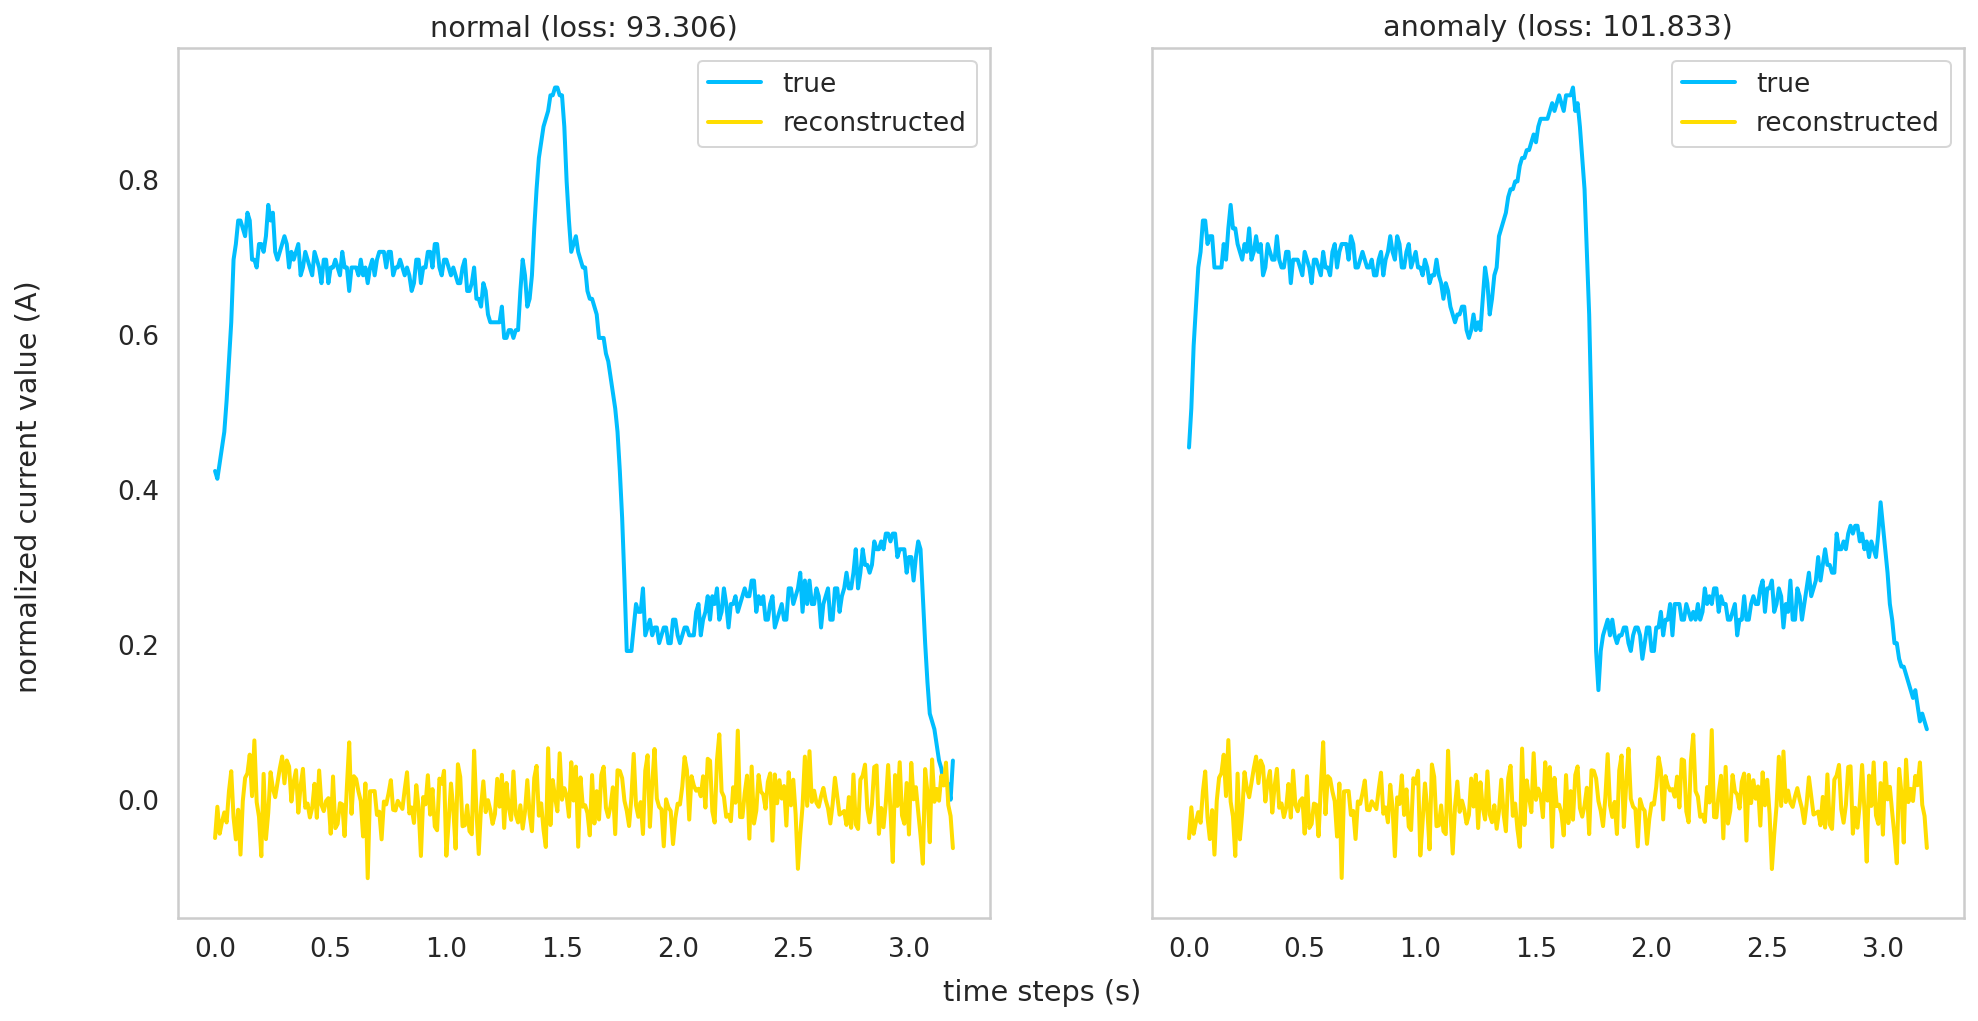

In [ ]:
fig, axs = plt.subplots(
  nrows=1,
  ncols=2,
  sharey=True,
  sharex=True,
  figsize=(16, 8)
  )

plot_prediction(testNormalDataloader, model, title='normal', ax=axs[0])
plot_prediction(testLeftDataloader, model, title='anomaly', ax=axs[1])

# fig.suptitle('(a)reconstruction performance of CNN-AE')
# fig.suptitle('(b)reconstruction performance of TCN-AE')
# fig.suptitle('(c)reconstruction performance of LSTM-AE')
# fig.suptitle('(d)reconstruction performance of CNN-LSTM-AE')

fig.text(0.5,0.06, "time steps (s)", ha="center", va="center")
fig.text(0.06,0.5, "normalized current value (A)", ha="center", va="center", rotation=90)

In [ ]:
class Meter:
  def __init__(self, n_classes=2):
    self.targets = []
    self.predictions = []
    self.metrics = {}
    self.confusion = np.zeros((n_classes, n_classes))

  def init_metrics(self):
    self.metrics['accuracy'] = 0
    self.metrics['f1'] = 0
    self.metrics['precision'] = 0
    self.metrics['recall'] = 0

  def update(self, x, y):
    self._compute_cm(x, y)

    self.targets = np.hstack((self.targets, x))
    self.predictions = np.hstack((self.predictions, y)) 

  def _compute_cm(self, x, y):
    for prob, target in zip(x, y):
      self.confusion[int(target)][int(prob)] += 1
  
  def _compute_metric(self):
    self.metrics['accuracy'] += round(accuracy_score(self.targets, self.predictions),5)
    self.metrics['f1'] += round(f1_score(self.targets, self.predictions,average='macro'),5)
    self.metrics['precision'] += round(precision_score(self.targets, self.predictions, average='macro', zero_division=1),5)
    self.metrics['recall'] += round(recall_score(self.targets, self.predictions, average='macro', zero_division=1),5)
      
  def get_metrics(self):
    return self.metrics
  
  def get_accuracy(self):
    return self.metrics['accuracy']
  
  def get_f1(self):
    return self.metrics['f1']

  def get_precision(self):
    return self.metrics['precision']

  def get_recall(self):
    return self.metrics['recall']
    
  def get_confusion_matrix(self):
    return self.confusion

  def plot_confusion_matrix(self, classes=class_names, title='Confusion matrix', color_map='Blues'):
    plt.figure(dpi=150)
    disp = ConfusionMatrixDisplay(confusion_matrix=self.confusion, display_labels=class_names)
    disp.plot(cmap=color_map, values_format='')
    plt.grid(False)
    # plt.title(title)
    plt.show()

meter = Meter()
meter.init_metrics()

Correct threshold: 0.0
Correct predictions rate: 0.7290076335877863


Text(0.5, 0, 'values')

Text(0, 0.5, 'counts')

Text(0.5, 1.0, 'reconstruction loss of normal data')

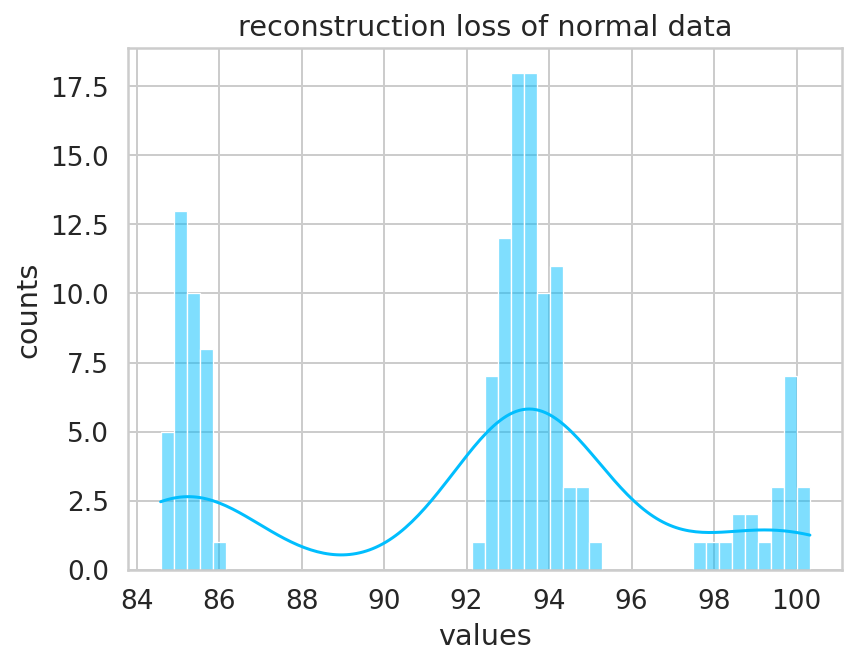

Correct normal predictions: 0/142
84.58065795898438
100.32373046875


Text(0.5, 0, 'values')

Text(0, 0.5, 'counts')

Text(0.5, 1.0, 'reconstruction loss of anomaly data')

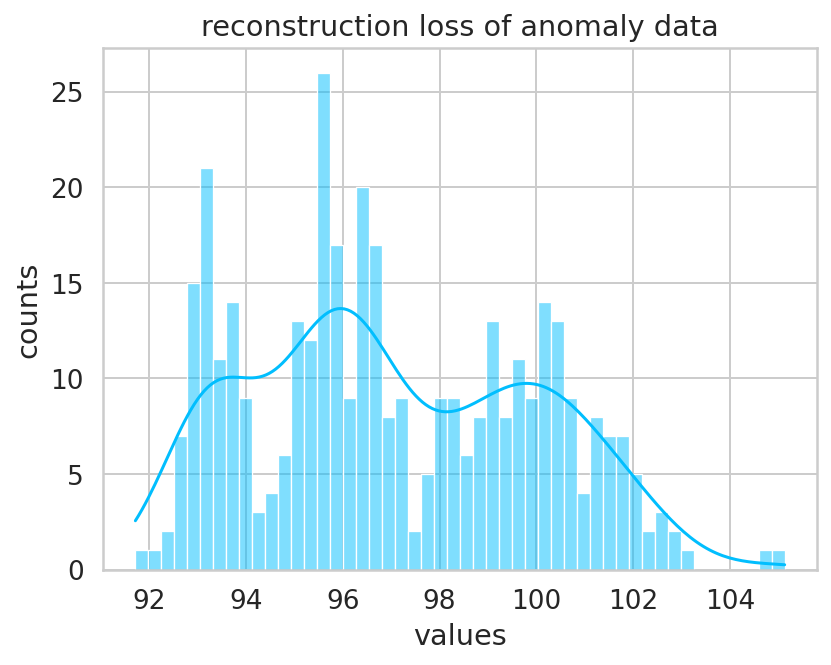

Correct left side anomaly predictions: 382/382
91.71113586425781
105.13232421875


In [ ]:
originals_normal, predictions_normal, pred_losses_normal = predict(model, testNormalDataloader)
originals_left, predictions_left, pred_losses_left = predict(model, testLeftDataloader)

num_all_sammples = len(pred_losses_left) + len(pred_losses_normal)
THRESHOLD = linspace(0.0,1.0,500)
best_threshold = 0
best_accuracy = 0
for threshold in THRESHOLD:
  correct = sum(i > threshold for i in pred_losses_left) + sum(i <= threshold for i in pred_losses_normal)
  correct = correct / num_all_sammples
  if correct > best_accuracy:
    best_accuracy = correct
    best_threshold = threshold

print(f'Correct threshold: {best_threshold}')
print(f'Correct predictions rate: {best_accuracy}')




fig = sns.histplot(pred_losses_normal, bins=50, kde=True);
plt.xlabel("values")
plt.ylabel("counts")
plt.title("reconstruction loss of normal data")
plt.show(fig)

correct = sum(l <= best_threshold for l in pred_losses_normal)
print(f'Correct normal predictions: {correct}/{len(test_normal_X)}')
print(min(pred_losses_normal))
print(max(pred_losses_normal))

target_normal = np.full_like(pred_losses_normal, CLASS_NORMAL)
pred_normal = np.full_like(pred_losses_normal, CLASS_NORMAL)
for id, i in enumerate(pred_losses_normal):
  if i > best_threshold:
    pred_normal[id] = CLASS_LEFT
meter.update(target_normal, pred_normal)





originals_left, predictions_left, pred_losses_left = predict(model, testLeftDataloader)
fig = sns.histplot(pred_losses_left, bins=50, kde=True)
plt.xlabel("values")
plt.ylabel("counts")
plt.title("reconstruction loss of anomaly data")
plt.show(fig)

correct = sum(l > best_threshold for l in pred_losses_left)
print(f'Correct left side anomaly predictions: {correct}/{len(test_left_X)}')
print(min(pred_losses_left))
print(max(pred_losses_left))

target_left = np.full_like(pred_losses_left, CLASS_LEFT)
pred_left = np.full_like(pred_losses_left, CLASS_LEFT)
for id, i in enumerate(pred_losses_left):
  if i <= best_threshold:
    pred_left[id] = CLASS_NORMAL
meter.update(target_left, pred_left)

<Figure size 960x720 with 0 Axes>

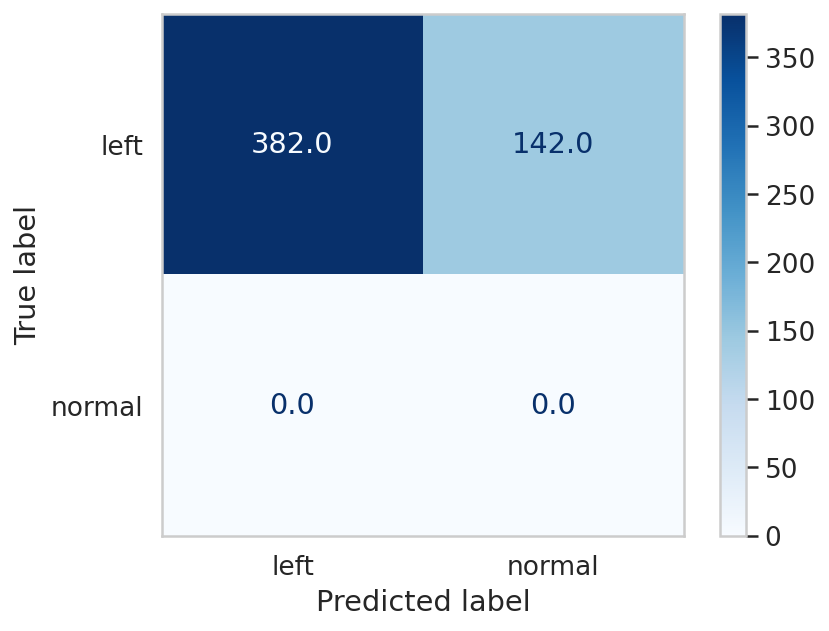

{'accuracy': 0.72901, 'f1': 0.42163, 'precision': 0.8645, 'recall': 0.5}


In [ ]:
meter._compute_metric()

meter.plot_confusion_matrix(title='(a) CNN-AE')
# meter.plot_confusion_matrix(title='(b) TCN-AE')
# meter.plot_confusion_matrix(title='(c) LSTM-AE')
# meter.plot_confusion_matrix(title='(d) CNN-LSTM-AE')

print(meter.get_metrics())

<Figure size 960x720 with 0 Axes>

Text(0.5, 0, 'counts')

Text(0, 0.5, 'reconstruction loss')

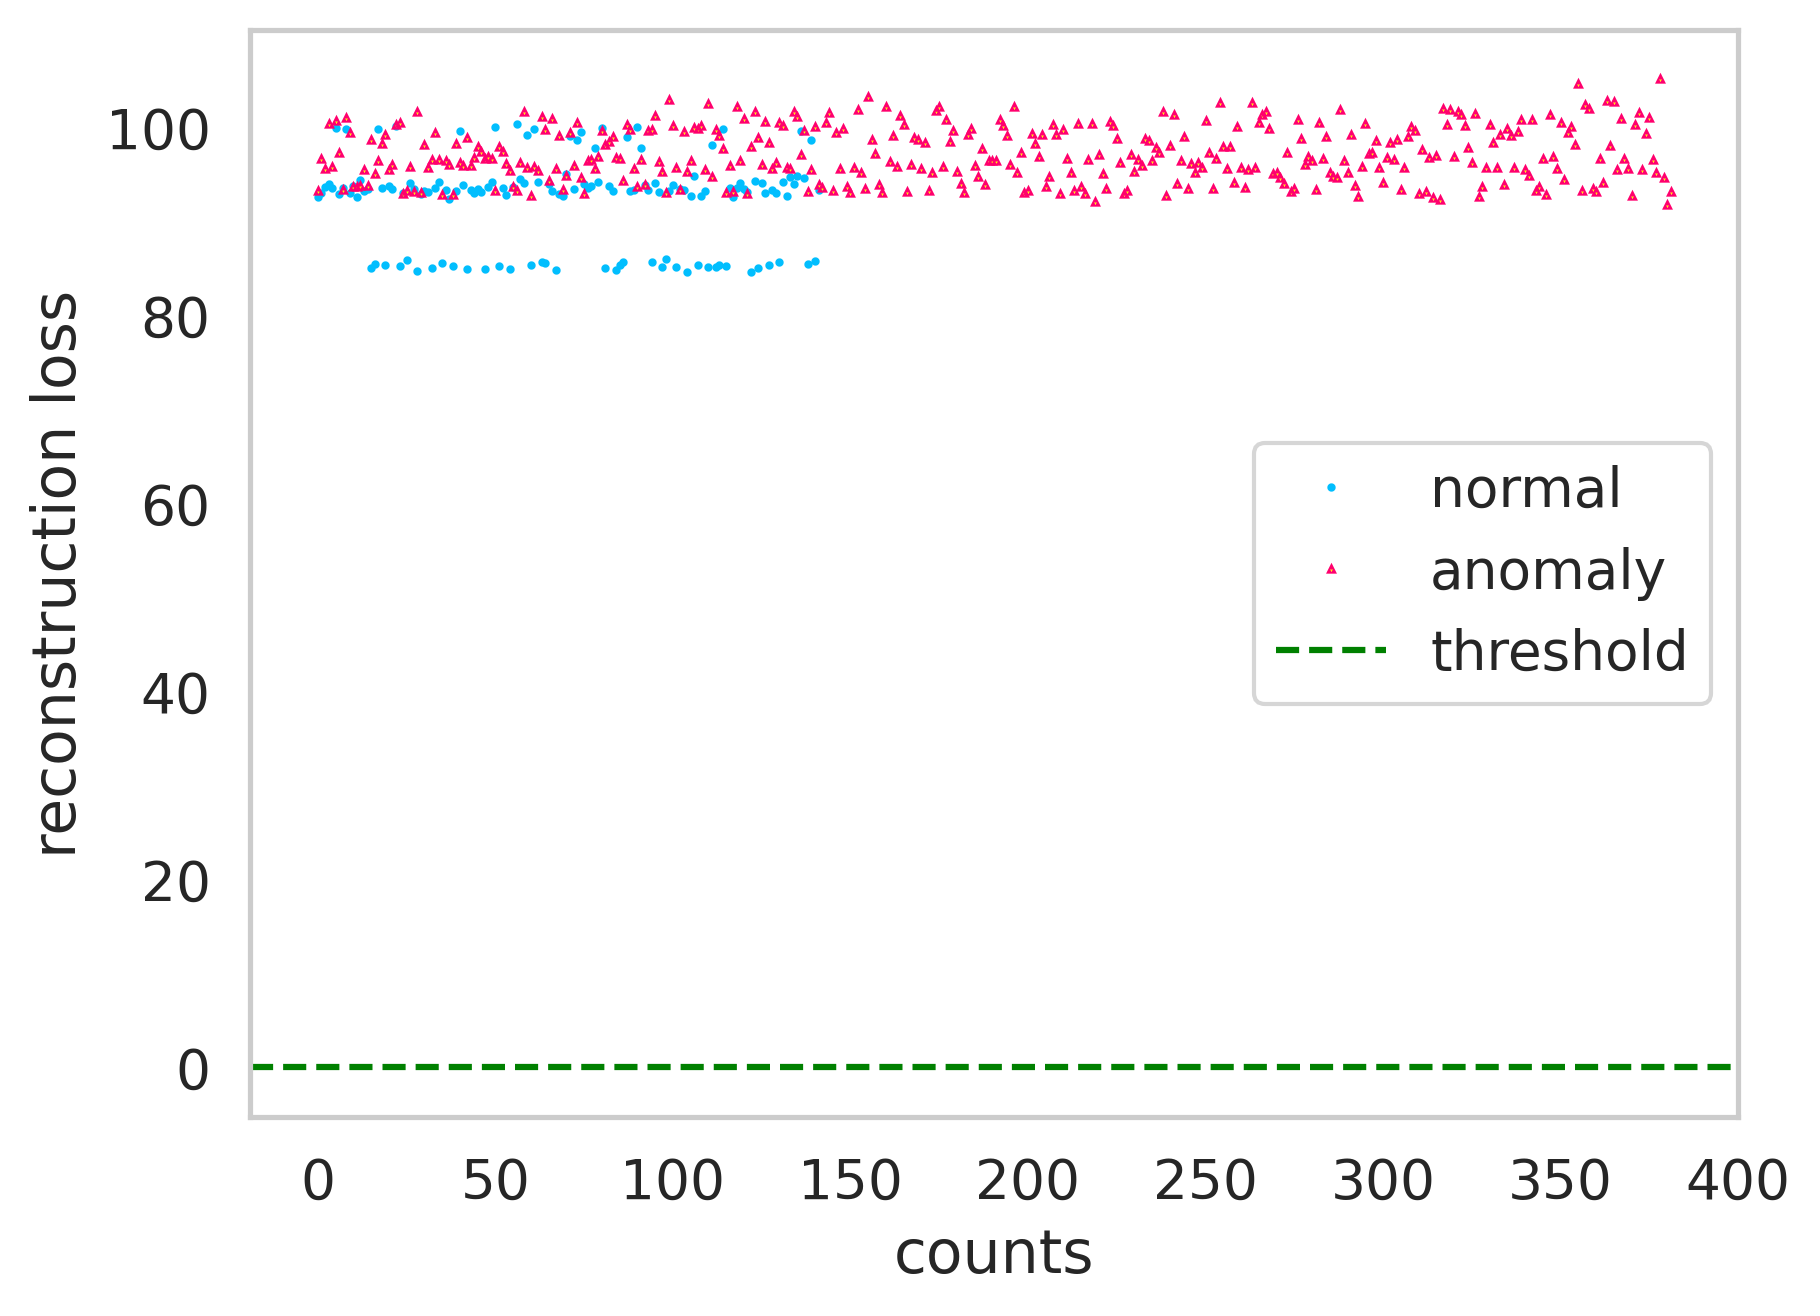

In [ ]:
plt.figure(dpi=150)
plt.plot(pred_losses_normal,
    color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0],
    label='normal',
    marker='o',
    markerfacecolor='blue',
    linestyle='dashed',
    linewidth=0.0,
    markersize=1)
plt.plot(pred_losses_left,
    color=plt.rcParams['axes.prop_cycle'].by_key()['color'][3],
    label='anomaly',
    marker='^',
    markerfacecolor='yellow',
    linestyle='dashed',
    linewidth=0.0,
    markersize=1)
plt.axhline(y = best_threshold, color='green', ls='--', label='threshold')


plt.xlabel('counts')
plt.ylabel('reconstruction loss')
# plt.title(f'distribution of reconstruction loss')

# plt.annotate(f'best threshold: {round(best_threshold,4)}\n Correct predictions rate: {round(best_accuracy*100,2)}%', 
#   xy = (175, best_threshold), 
#   xytext = (175, -0.5),
#   arrowprops = {
#     'headwidth': 10, # 箭头头部的宽度
#     'headlength': 5, # 箭头头部的长度
#     'width': 2, # 箭头尾部的宽度
#     'facecolor': 'green', # 箭头的颜色
#     'shrink': 0.05, # 从箭尾到标注文本内容开始两端空隙长度
#   },
#   family='Times New Roman',  # 标注文本字体为Times New Roman
#   fontsize=12,  # 文本大小
#   fontweight='bold',  # 文本为粗体
#   color='green',  # 文本颜色
#   ha = 'center' # 水平居中
# )

# plt.title(f'(a)distribution of reconstruction loss of CNN-AE')
# plt.title(f'(b)distribution of reconstruction loss of TCN-AE')
# plt.title(f'(c)distribution of reconstruction loss of LSTM-AE')
# plt.title(f'(d)distribution of reconstruction loss of CNN-LSTM-AE')
plt.grid(None)
plt.legend()


# prepare cnc dataset for transfer learning 

In [81]:
def openFile(path):
  with open(path) as file:
      data = json.load(file)
  file.close()
  return data

def getDataPayload(data):
  # Removes the header, footer, and the Block Events in the Payload and returns cleaned payload data into a np array
  payload_list = data['Payload']
  paydata = []
  for HFData in payload_list:
      if 'HFData' in HFData:
          tupel = HFData['HFData']
          for j in tupel:
              paydata.append(j)
  pdata = np.array(paydata)
  return pdata

def getSamplingRate(data):
  # Returns the sampling rate of the data
  sampling_rate = data['Header']['CycleTimeMs']
  return sampling_rate

def getSignalList(data):
  signal_list = []
  for index in range(0, len(data['Header']['SignalListHFData'])):
      signal_list.append((data['Header']['SignalListHFData'][index]['Name']) + ': ' + (
          data['Header']['SignalListHFData'][index]['Address']))
  return signal_list

def read_file(json_path, signal_name):
  if os.path.exists(json_path) == True: 			
    file1 = openFile(json_path)
    data1= getDataPayload(file1)
    data=data1
    
  #get sampling rate in milliseconds
  sampling_rate = getSamplingRate(file1)/1000 
  print('sampling_rate(ms): '+str(sampling_rate))                                  

  index=getSignalList(file1).index(signal_name)                                						 
  t = np.arange(0, (data[:, index].shape[0])*sampling_rate, sampling_rate) 
  df = pd.DataFrame({'time': t, 'values': data[:, index] }, columns=['time', 'values'])

  return df

In [82]:
# only current 1 or current 2
df1 = read_file("/content/drive/MyDrive/dataset/CNC/085240.json", 'Current: CURRENT|1') #0.002
df2 = read_file("/content/drive/MyDrive/dataset/CNC/085843.json", 'Current: CURRENT|1') #0.002
df3 = read_file("/content/drive/MyDrive/dataset/CNC/090400.json", 'Current: CURRENT|1') #0.002
df4 = read_file("/content/drive/MyDrive/dataset/CNC/092449.json", 'Current: CURRENT|1') #0.002
df5 = read_file("/content/drive/MyDrive/dataset/CNC/093105.json", 'Current: CURRENT|1') #0.002
df6 = read_file("/content/drive/MyDrive/dataset/CNC/093826.json", 'Current: CURRENT|1') #0.002

sampling_rate(ms): 0.002
sampling_rate(ms): 0.002
sampling_rate(ms): 0.002
sampling_rate(ms): 0.002
sampling_rate(ms): 0.002
sampling_rate(ms): 0.002


In [83]:
df = {
  0:df1,
  1:df2,
  2:df3,
  3:df4,
  4:df5,
  5:df6  
}

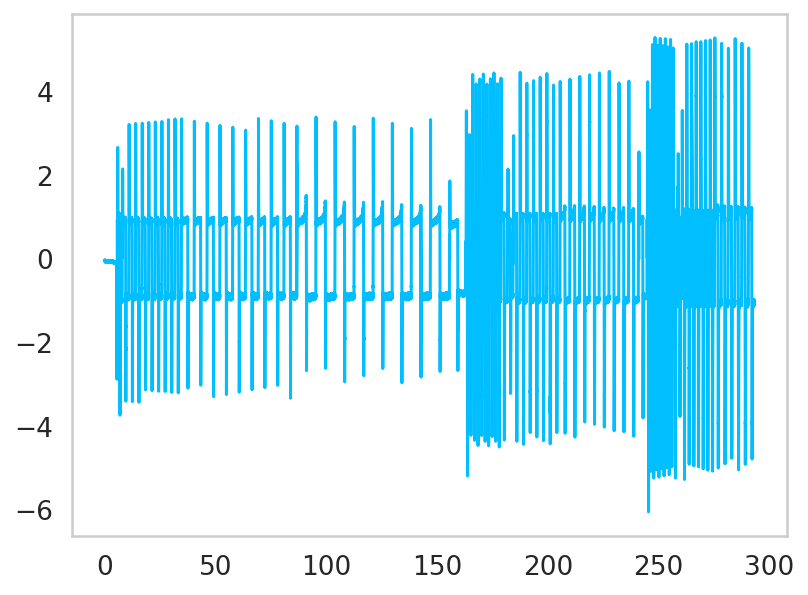

In [84]:
plt.plot(df[0]['time'].values, df[0]['values'].values, label='normal 1')
# plt.plot(df[1]['time'].values, df[1]['values'].values, label='normal 2')
# plt.plot(df[2]['time'].values, df[2]['values'].values, label='normal 3')
# plt.plot(df[3]['time'].values, df[3]['values'].values, label='mass 1')
# plt.plot(df[4]['time'].values, df[4]['values'].values, label='mass 2')
# plt.plot(df[5]['time'].values, df[5]['values'].values, label='mass 3')
plt.grid(None)
# plt.legend()
plt.show()

<Figure size 960x720 with 0 Axes>

Text(0.5, 0, 'time steps (s)')

Text(0, 0.5, 'current values (A)')

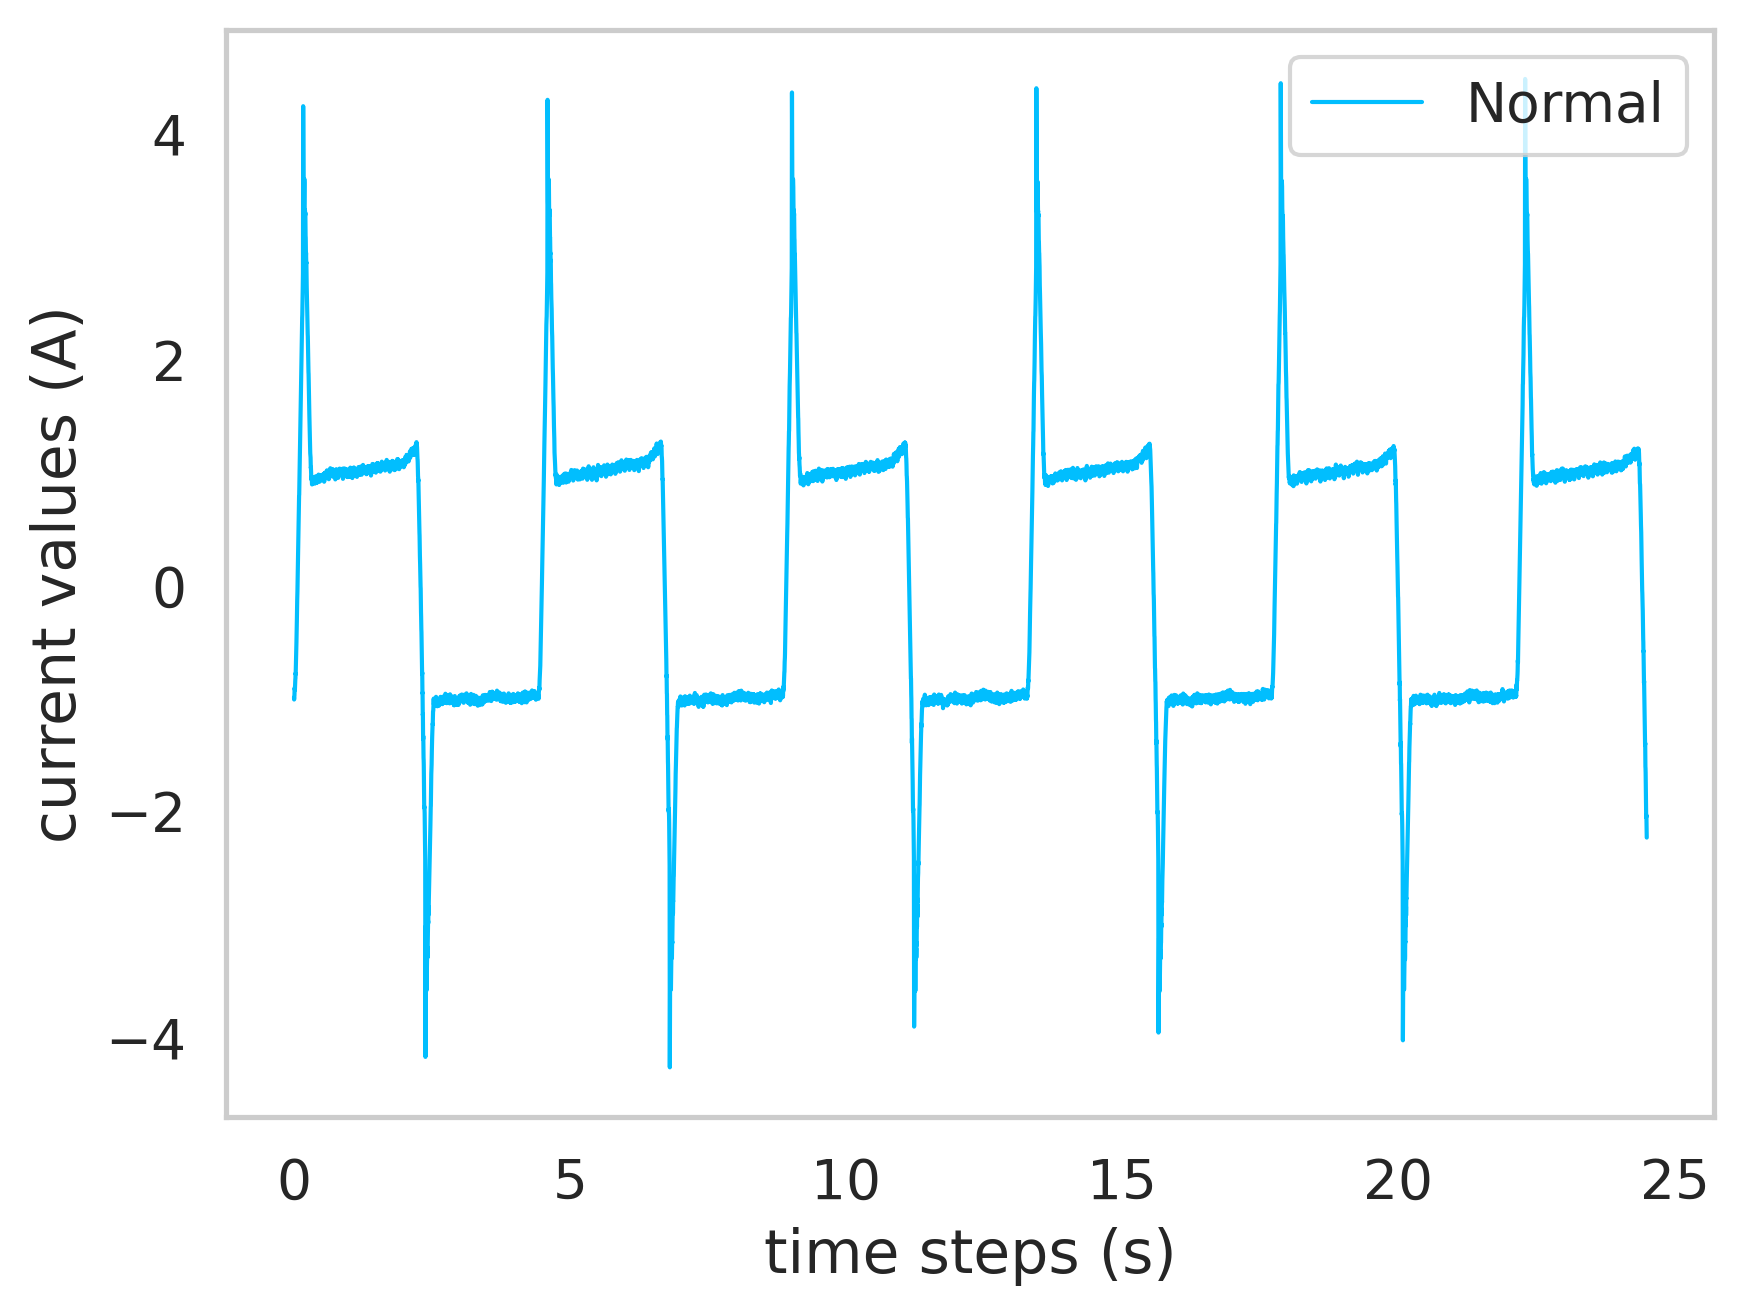

In [85]:
lineWidth = 1
plt.figure(dpi=150)

plt.plot(df[0]['time'].values[102700:102700+7*350*5]-df[0]['time'].values[102700], df[0]['values'].values[102700:102700+7*350*5], label='Normal', lw = lineWidth)

# plt.plot(df[1]['time'].values, df[1]['values'].values, label='normal 2')
# plt.plot(df[2]['time'].values, df[2]['values'].values, label='normal 3')
# plt.plot(df[3]['time'].values, df[3]['values'].values, label='mass 1')
# plt.plot(df[4]['time'].values, df[4]['values'].values, label='mass 2')
# plt.plot(df[5]['time'].values, df[5]['values'].values, label='mass 3')


plt.grid(b=None)
plt.legend()
plt.xlabel("time steps (s)")
plt.ylabel("current values (A)")
# plt.title(' fake data')
plt.show()

In [86]:
# help function used to plot example data to compare
def match_signal(df, speed, stroke):
  if speed == 100 and stroke == 100:
    start = 5400
  elif speed == 100 and stroke == 200:
    start = 17300
  elif speed == 100 and stroke == 300:
    start = 50000
  elif speed == 200 and stroke == 100:
    start = 82900
  elif speed == 200 and stroke == 200:
    start = 93650
  elif speed == 200 and stroke == 300:
    start = 102700
  elif speed == 300 and stroke == 100:
    start = 125200
  elif speed == 300 and stroke == 200:
    start = 128000
  elif speed == 300 and stroke == 300:
    start = 137500

  lineWidth = 2
  # plt.figure(dpi=150, figsize=plt.rcParamsDefault["figure.figsize"])

  indexes, values = prepare_axies(real_N_df.iloc[0,:-1], sampling_frequency)
  plt.plot(indexes, values, label = 'Normal misalignment', lw = lineWidth)

  print(start)
  end = start + 350*5
  indexes = df['time'].values[start:end]-df['time'].values[start]
  values = preprocessing.MinMaxScaler().fit_transform(df['values'].values[start:end].reshape(-1, 1)).reshape(-1)
  plt.plot(indexes, values, label="speed: {} mm/s, stroke: {} mm".format(speed, stroke))
  plt.grid(None)
  plt.legend()
  plt.xlabel("time steps (s)")
  plt.ylabel("normalized current values (A)")
  plt.title(' compare data')
  plt.show()

102700


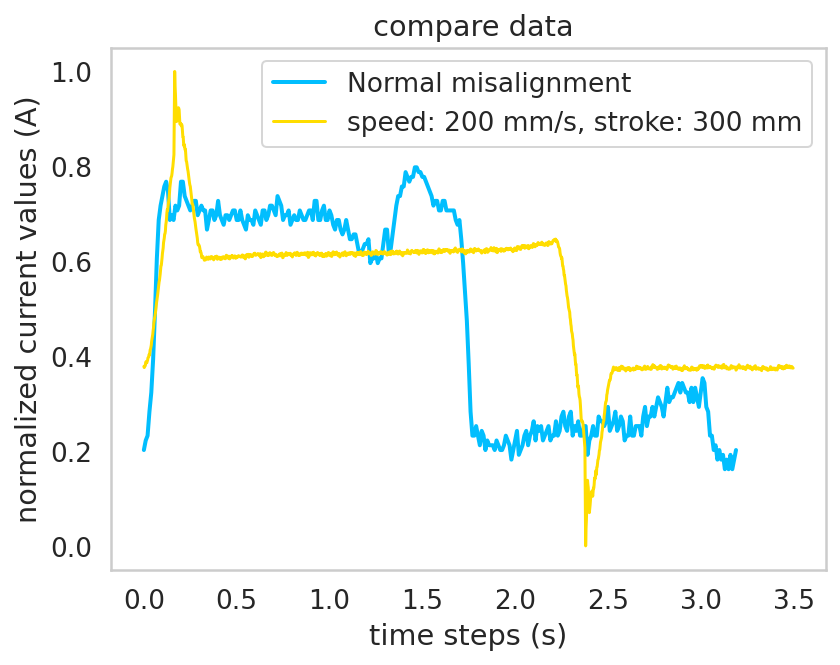

In [87]:
# match_signal(df[0], speed=100, stroke = 100) # 有点小
# match_signal(df[0], speed=100, stroke = 200)
# match_signal(df[0], speed=100, stroke = 300) # no

# match_signal(df[0], speed=200, stroke = 100) # 快两个周期了
# match_signal(df[0], speed=200, stroke = 200) # 稍微多一点点
match_signal(df[0], speed=200, stroke = 300) # good

# match_signal(df[0], speed=300, stroke = 100) # 快三个周期了
# match_signal(df[0], speed=300, stroke = 200) # 快三个周期了
# match_signal(df[0], speed=300, stroke = 300) # 不如上面

# find

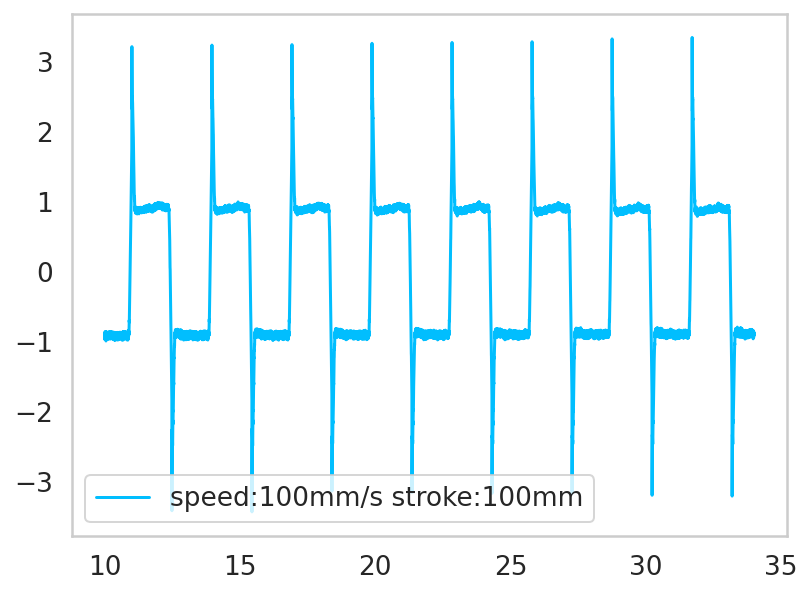

In [88]:
# speed:100mm/s stroke:100mm
start = 5000
end = 17000
plt.plot(df[0]['time'].values[start:end], df[0]['values'].values[start:end], label='speed:100mm/s stroke:100mm')
plt.grid(None)
plt.legend()
plt.show()

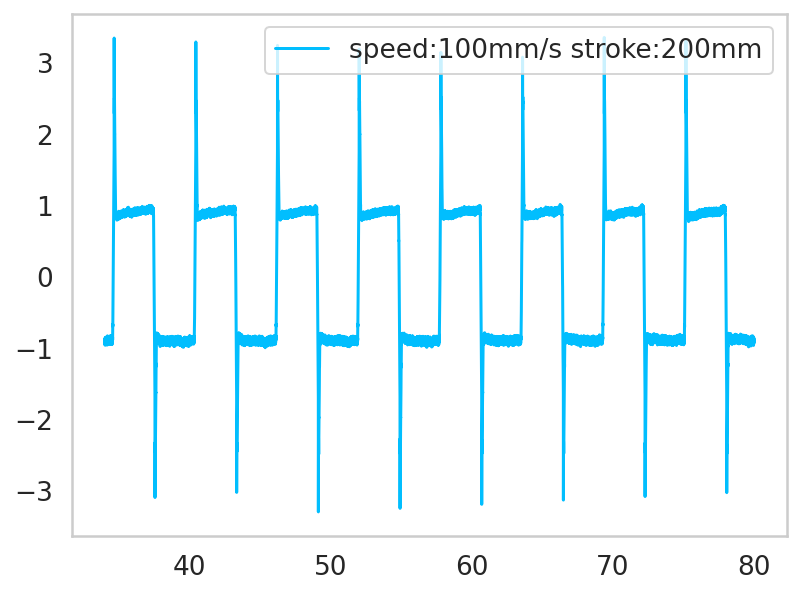

In [89]:
# speed:100mm/s stroke:200mm
start = 17000
end = 40000
plt.plot(df1['time'].values[start:end], df1['values'].values[start:end], label='speed:100mm/s stroke:200mm')
plt.grid(None)
plt.legend()
plt.show()

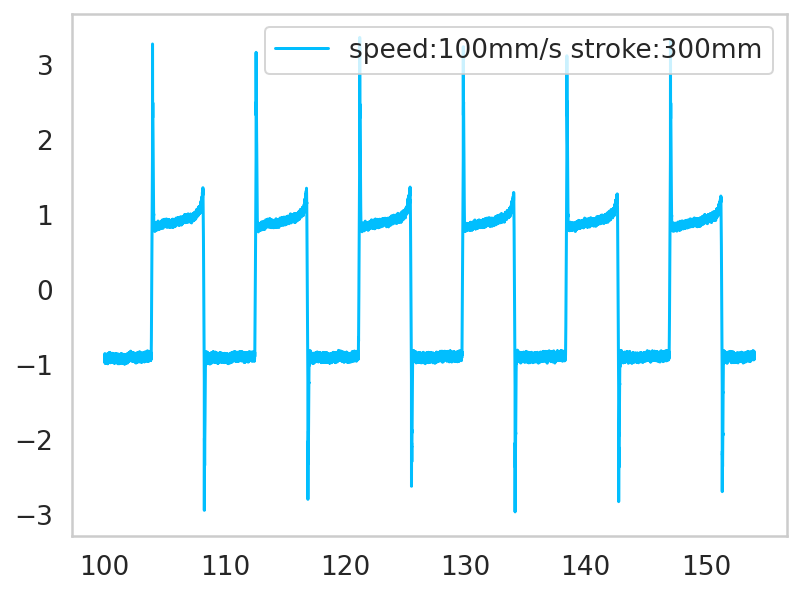

In [90]:
# speed:100mm/s stroke:300mm
start = 50000
end = 77000
plt.plot(df1['time'].values[start:end], df1['values'].values[start:end], label='speed:100mm/s stroke:300mm')
plt.grid(None)
plt.legend()
plt.show()

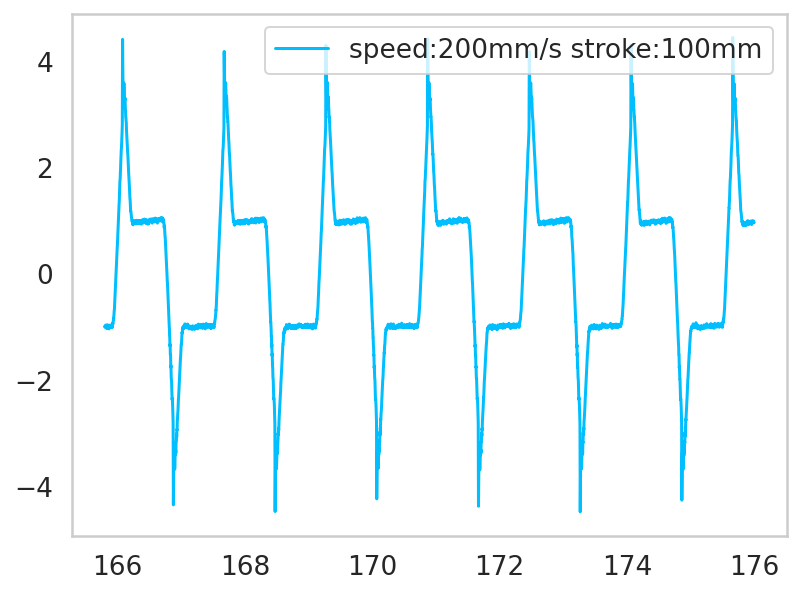

In [91]:
# speed:200mm/s stroke:100mm
start = 82900
end = 88000
plt.plot(df1['time'].values[start:end], df1['values'].values[start:end], label='speed:200mm/s stroke:100mm')
plt.grid(None)
plt.legend()
plt.show()

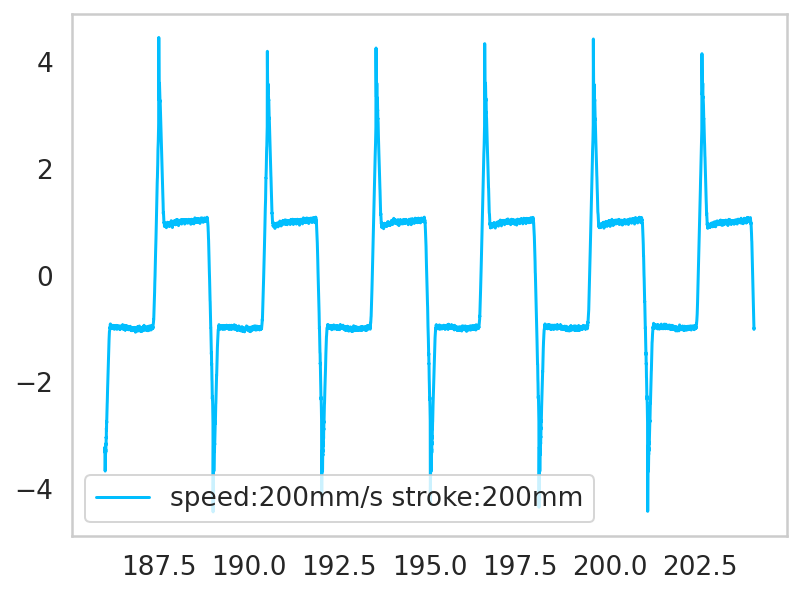

In [92]:
# speed:200mm/s stroke:200mm
start = 93000
end = 102000
plt.plot(df1['time'].values[start:end], df1['values'].values[start:end], label='speed:200mm/s stroke:200mm')
plt.grid(None)
plt.legend()
plt.show()

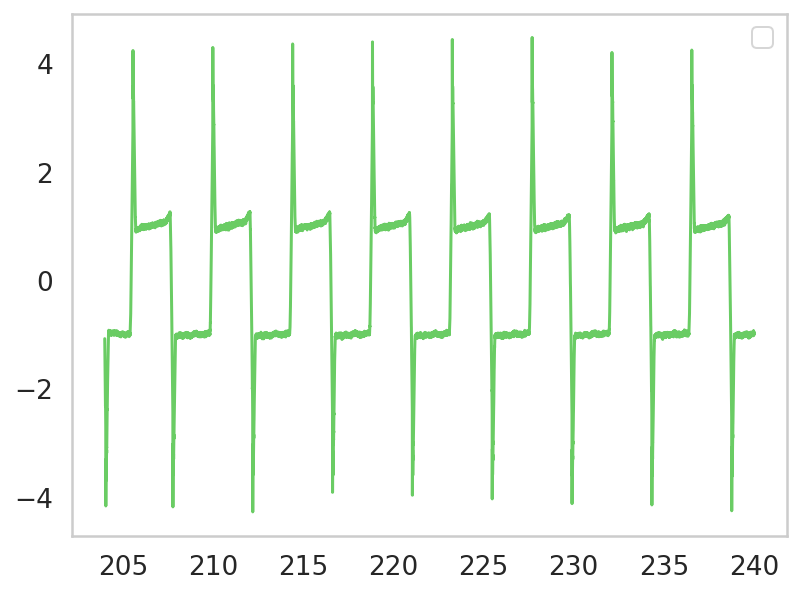

In [93]:
# speed:200mm/s stroke:300mm
start = 102000
end = 120000
# plt.plot(df1['time'].values[start:end], df1['values'].values[start:end], label='speed:200mm/s stroke:300mm')
# plt.plot(df1['time'].values[start:end], df1['values'].values[start:end], c=plt.rcParams['axes.prop_cycle'].by_key()['color'][2])
plt.plot(df1['time'].values[start:end], df1['values'].values[start:end], c='g')
plt.grid(None)
plt.legend()
plt.show()

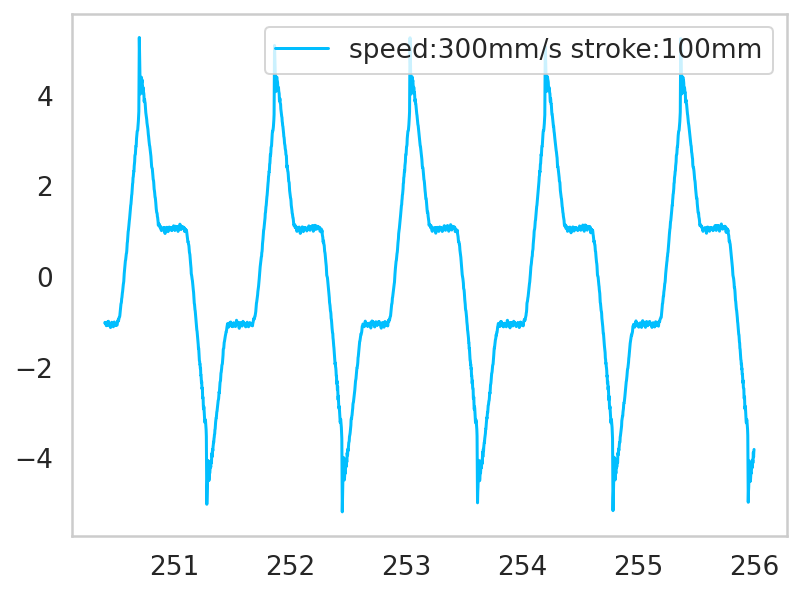

In [94]:
# speed:300mm/s stroke:100mm
start = 125200
end = 128000
plt.plot(df1['time'].values[start:end], df1['values'].values[start:end], label='speed:300mm/s stroke:100mm')
plt.grid(None)
plt.legend()
plt.show()

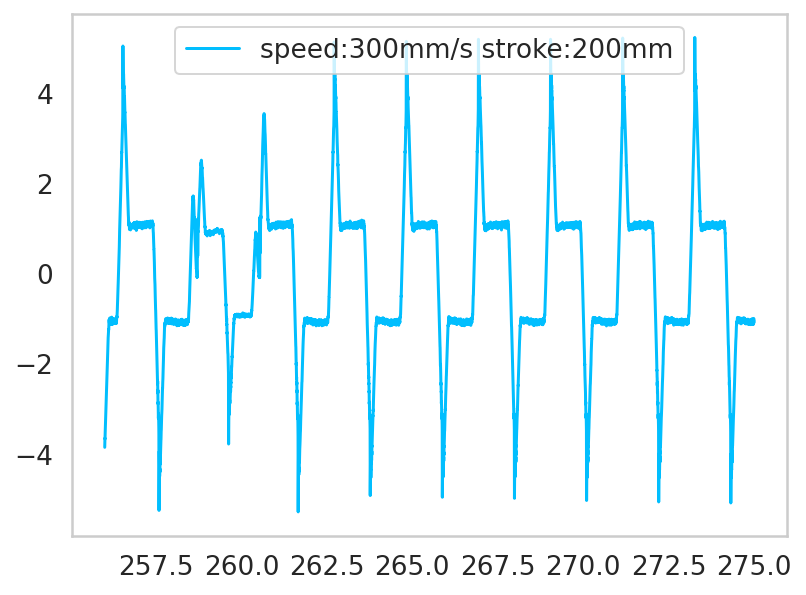

In [95]:
# speed:300mm/s stroke:200mm
start = 128000
end = 137500
plt.plot(df1['time'].values[start:end], df1['values'].values[start:end], label='speed:300mm/s stroke:200mm')
plt.grid(None)
plt.legend()
plt.show()

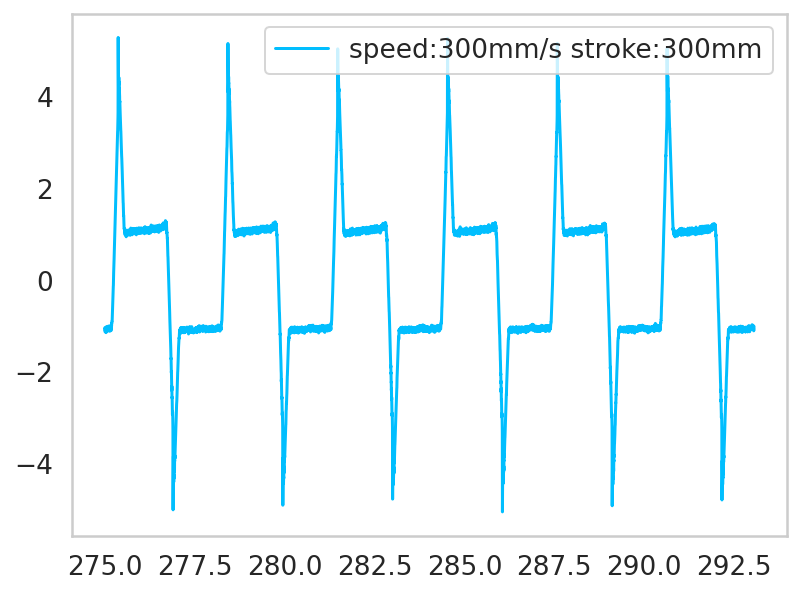

In [96]:
# speed:300mm/s stroke:300mm
start = 137500
end = 158000
plt.plot(df1['time'].values[start:end], df1['values'].values[start:end], label='speed:300mm/s stroke:300mm')
plt.grid(None)
plt.legend()
plt.show()

# split CNC data

<Figure size 960x720 with 0 Axes>

Text(0.5, 0, 'time steps (s)')

Text(0, 0.5, 'normalized current values (A)')

Text(0.5, 1.0, ' data comparision')

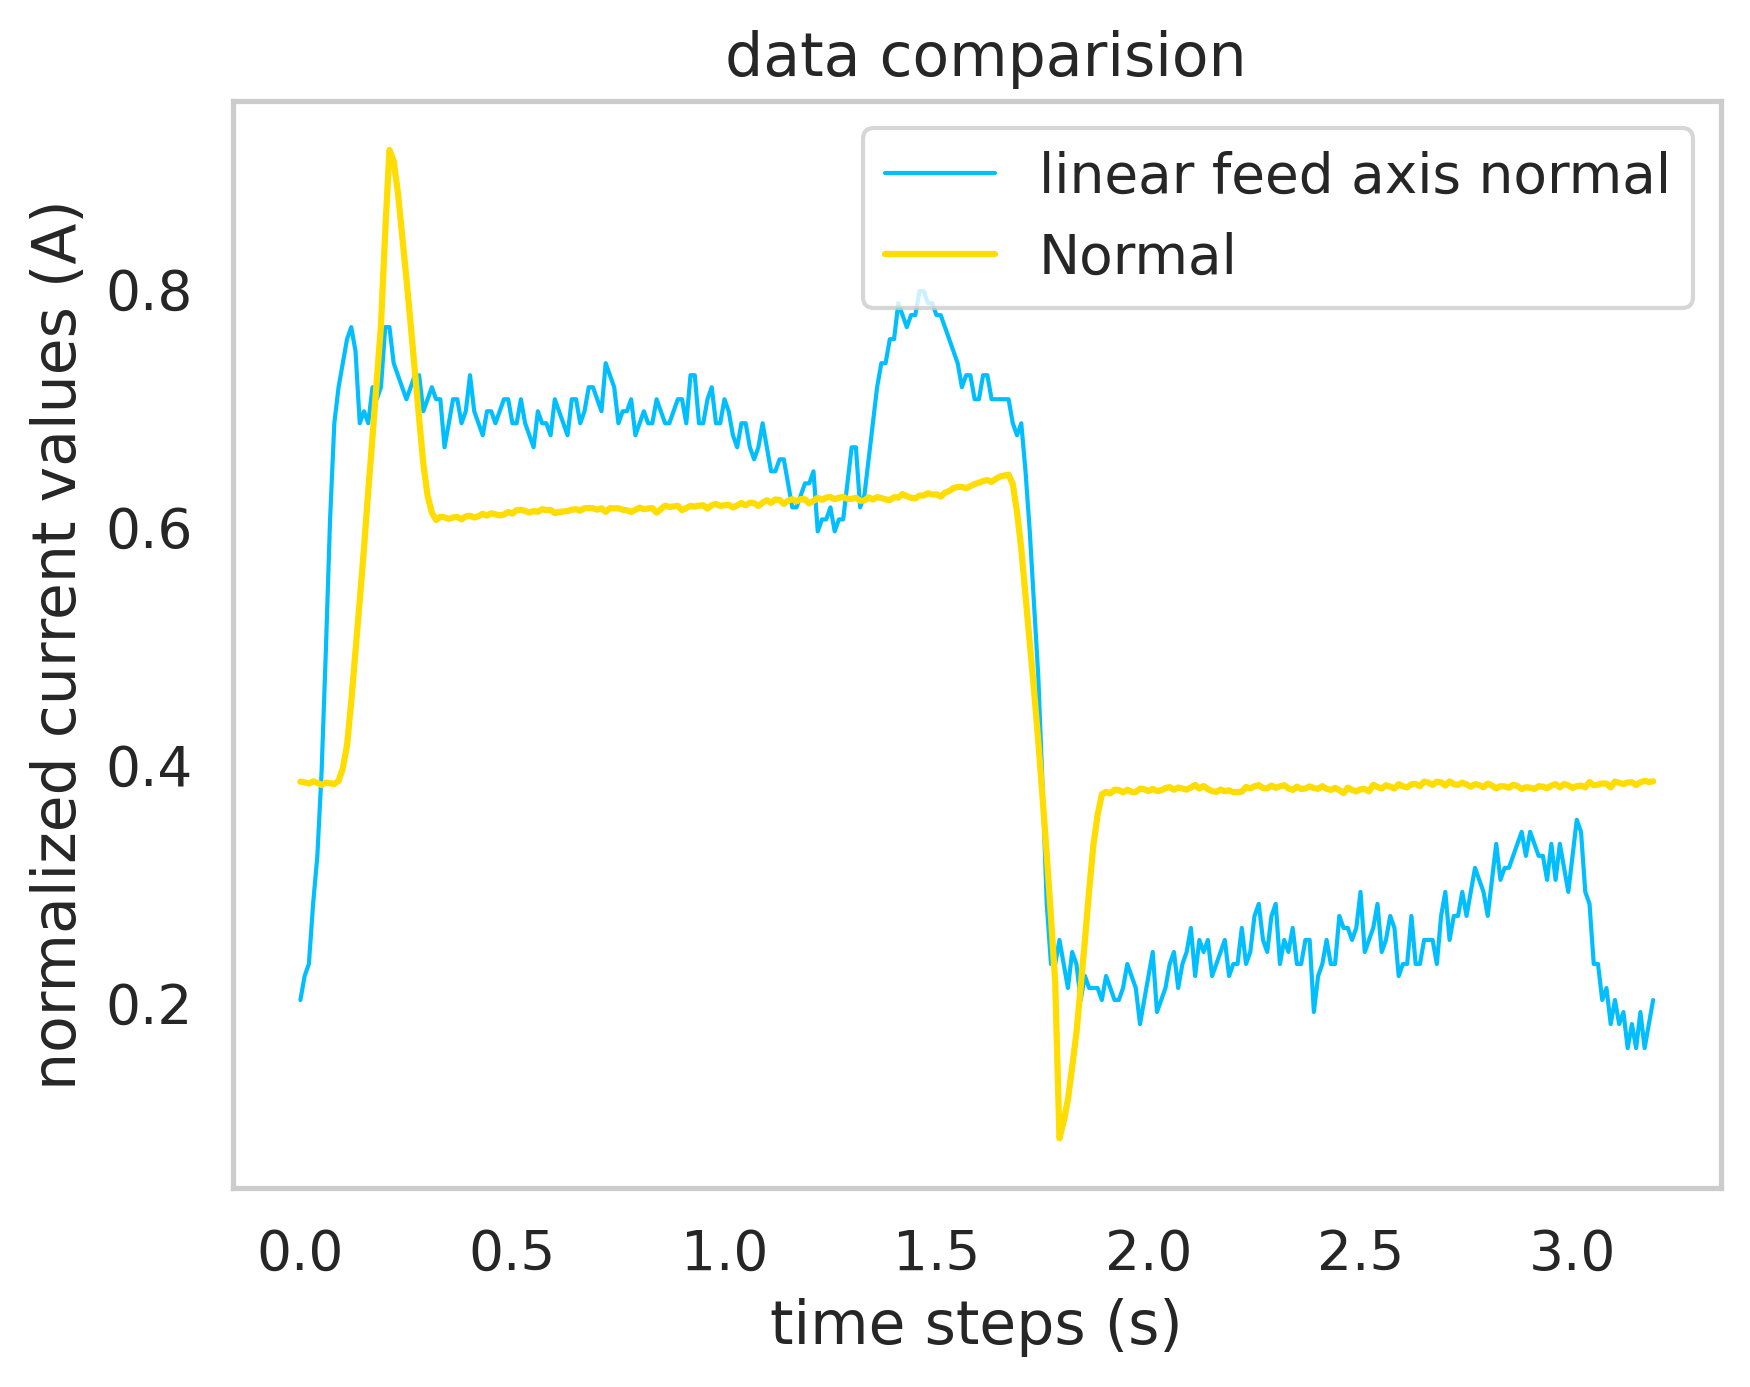

In [97]:
# 尝试降采样
lineWidth = 1
plt.figure(dpi=150, figsize=plt.rcParamsDefault["figure.figsize"])

indexes, values = prepare_axies(real_N_df.iloc[0,:-1], sampling_frequency)
plt.plot(indexes, values, label = 'linear feed axis normal', lw = lineWidth)

start = 104850
end = start + 320*7

values = preprocessing.MinMaxScaler().fit_transform(df[0]['values'].values[start:end].reshape(-1, 1)).reshape(-1)
values = values[:320*7].reshape(-1, 7).mean(axis=1)
plt.plot(indexes, values, label='Normal')

plt.grid(b=None)
plt.legend()
plt.xlabel("time steps (s)")
plt.ylabel("normalized current values (A)")
plt.title(' data comparision')
plt.show()

In [98]:
# # speed:100mm/s stroke:200mm
start_1 = 17300
# # speed:100mm/s stroke:300mm
start_2 = 50000
# # speed:200mm/s stroke:100mm
start_3 = 82900
# # speed:200mm/s stroke:200mm
start_4 = 93650

# speed:200mm/s stroke:300mm
start_5 = 104850

# # speed:300mm/s stroke:100mm
start_6 = 125200
# # speed:300mm/s stroke:200mm
start_7 = 128000
# # speed:300mm/s stroke:300mm
start_8 = 137500


intervall = 2213

start0 = start_5
start1 = start_5+130
start2 = start_5-1080
start3 = start_5-4660
start4 = start_5-595
start5 = start_5+395

start_pos = {
  0: [start0, start0+intervall, start0+intervall*2, start0+intervall*3, start0+intervall*4, start0+intervall*5, start0+intervall*6],
  1: [start1, start1+intervall, start1+intervall*2, start1+intervall*3, start1+intervall*4, start1+intervall*5, start1+intervall*6],
  2: [start2, start2+intervall, start2+intervall*2, start2+intervall*3, start2+intervall*4, start2+intervall*5, start2+intervall*6],
  3: [start3, start3+intervall, start3+intervall*2, start3+intervall*3, start3+intervall*4, start3+intervall*5, start3+intervall*6],
  4: [start4, start4+intervall, start4+intervall*2, start4+intervall*3, start4+intervall*4, start4+intervall*5, start4+intervall*6],
  5: [start5, start5+intervall, start5+intervall*2, start5+intervall*3, start5+intervall*4, start5+intervall*5, start5+intervall*6],
}


<Figure size 960x720 with 0 Axes>

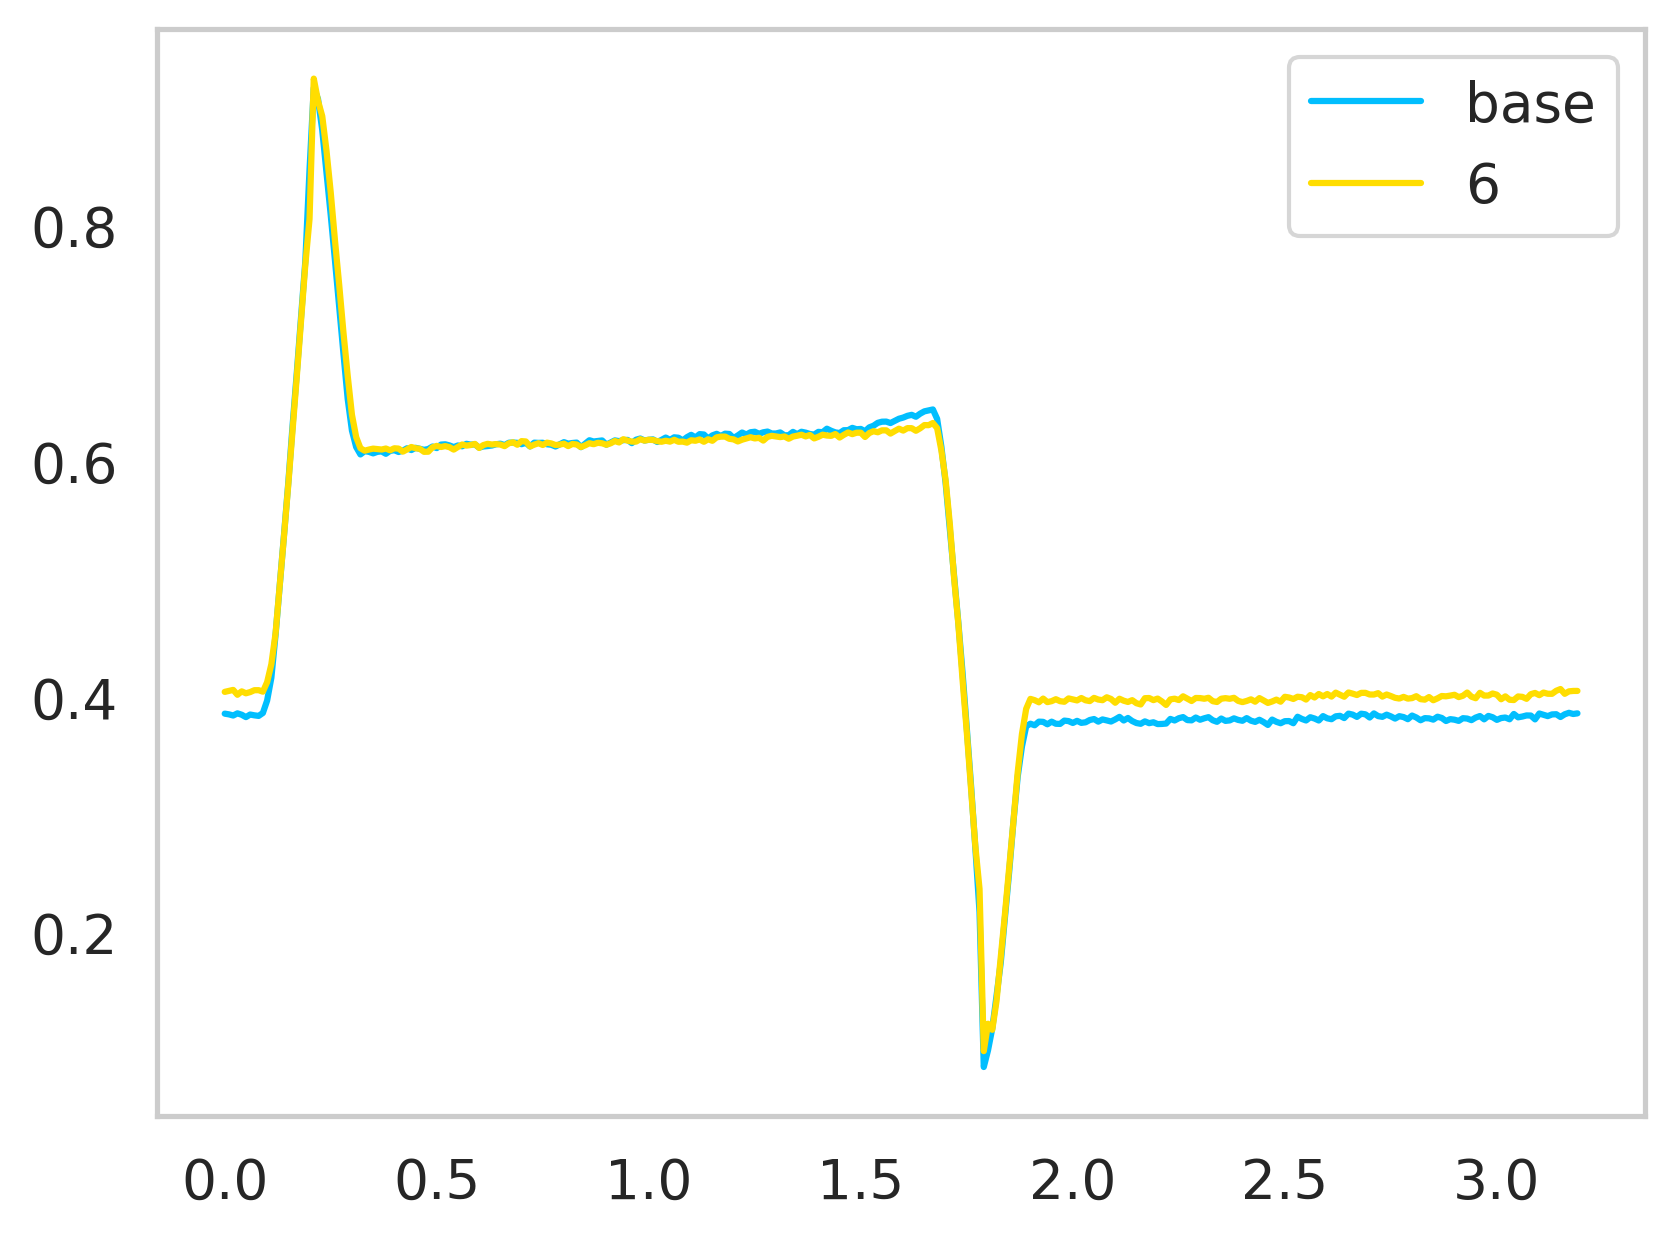

In [99]:
# 一个一个对比找位置

plt.figure(dpi=150, figsize=plt.rcParamsDefault["figure.figsize"])
indexes = np.arange(0, 3.20, 0.01)

i = 0
j = 0
start = start_pos[i][j]
end = start_pos[i][j] + 320*7
values = preprocessing.MinMaxScaler().fit_transform(df[i]['values'].values[start:end].reshape(-1, 1)).reshape(-1)
values = values[:320*7].reshape(-1, 7).mean(axis=1)
plt.plot(indexes, values, label='base')

i = 3
j = 6
start = start_pos[i][j]
end = start_pos[i][j] + 320*7
values = preprocessing.MinMaxScaler().fit_transform(df[i]['values'].values[start:end].reshape(-1, 1)).reshape(-1)
values = values[:320*7].reshape(-1, 7).mean(axis=1)
plt.plot(indexes, values, label=j)


plt.grid(None)
plt.legend()
plt.show()

<Figure size 960x720 with 0 Axes>

Text(0.5, 0, 'time steps (s)')

Text(0, 0.5, 'normalized current values (A)')

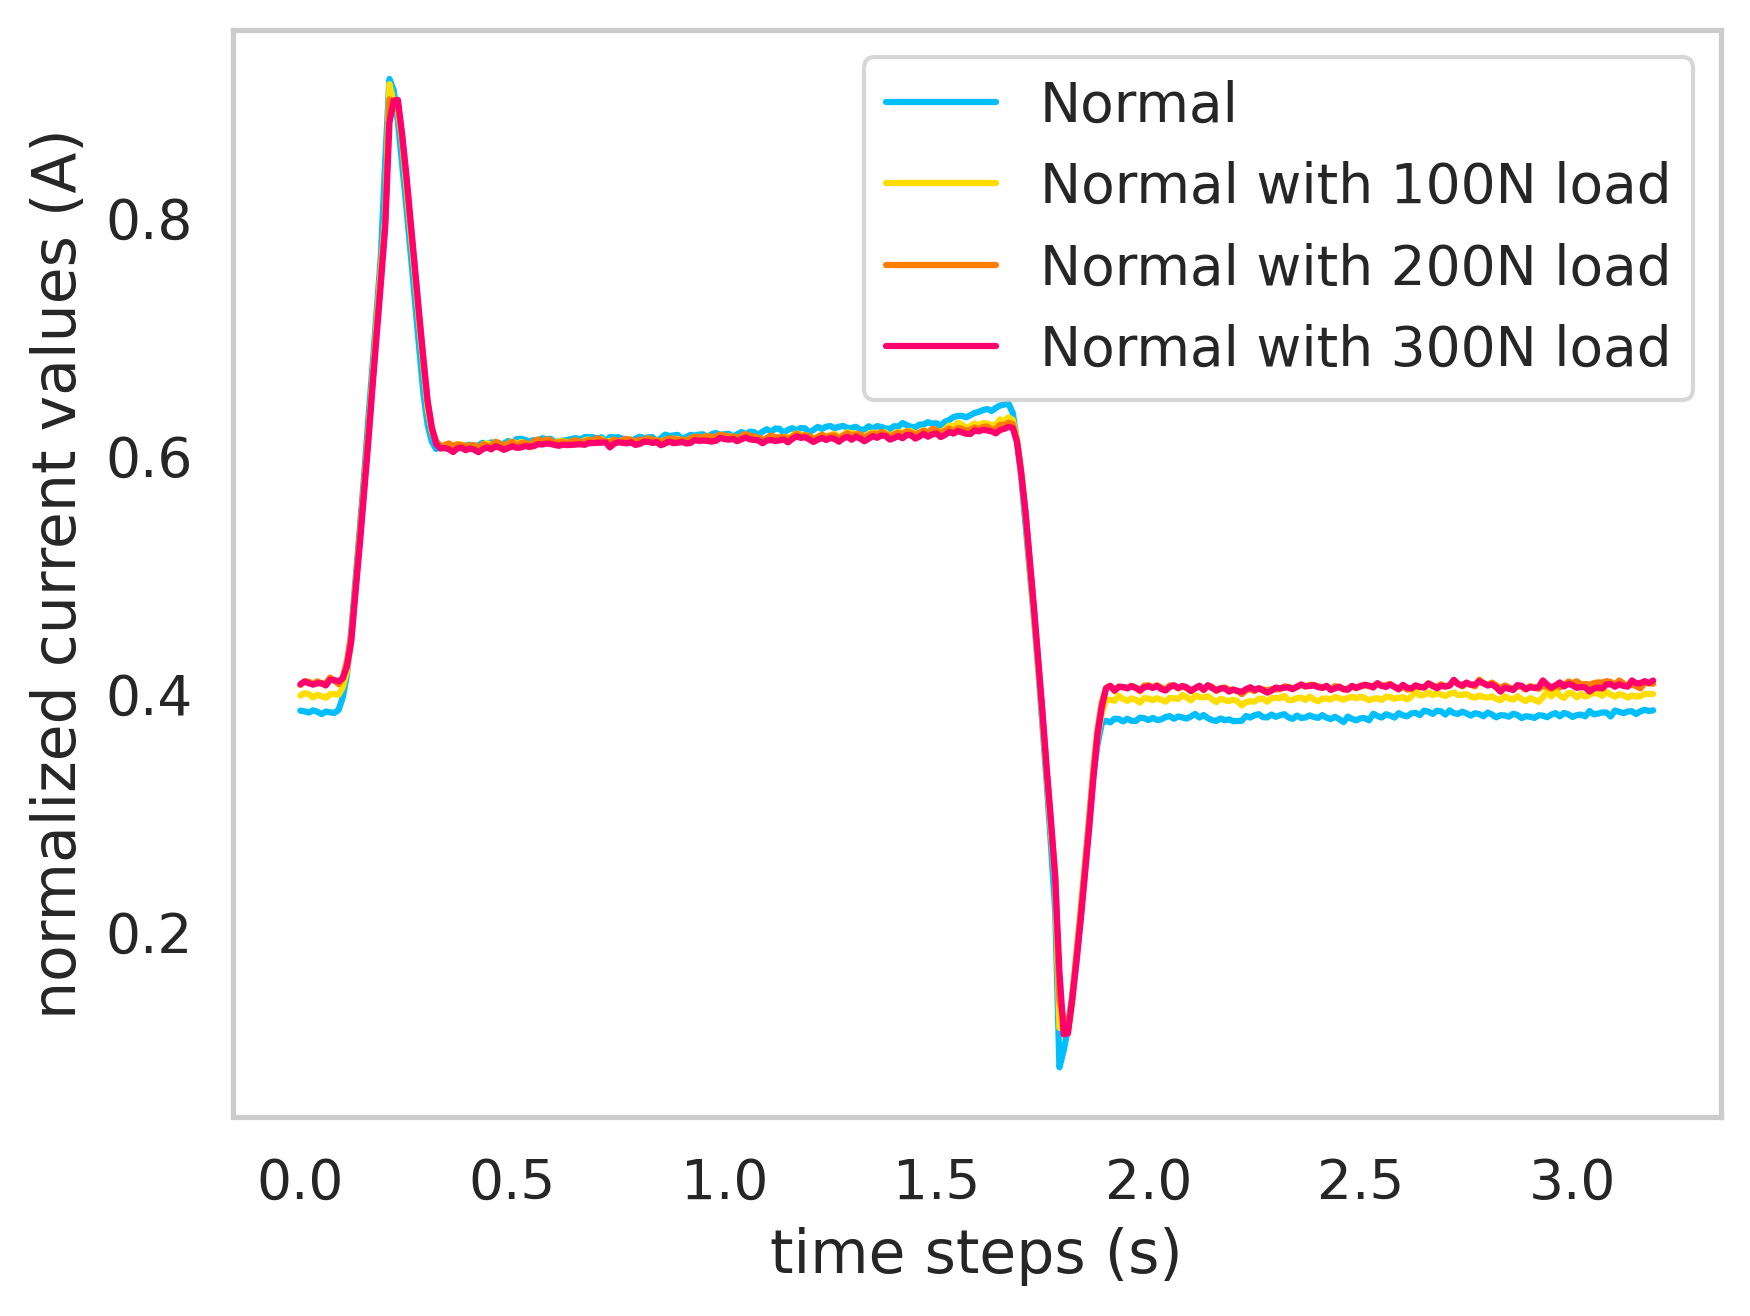

In [100]:
lineWidth = 1
plt.figure(dpi=150, figsize=plt.rcParamsDefault["figure.figsize"])
indexes = np.arange(0, 3.20, 0.01)

i = 0
j = 0
start = start_pos[i][j]
end = start_pos[i][j] + 320*7
values = preprocessing.MinMaxScaler().fit_transform(df[i]['values'].values[start:end].reshape(-1, 1)).reshape(-1)
values = values[:320*7].reshape(-1, 7).mean(axis=1)
plt.plot(indexes, values, label='Normal')

i = 3
j = 0
start = start_pos[i][j]
end = start_pos[i][j] + 320*7
values = preprocessing.MinMaxScaler().fit_transform(df[i]['values'].values[start:end].reshape(-1, 1)).reshape(-1)
values = values[:320*7].reshape(-1, 7).mean(axis=1)
plt.plot(indexes, values, label='Normal with 100N load')

i = 4
j = 0
start = start_pos[i][j]
end = start_pos[i][j] + 320*7
values = preprocessing.MinMaxScaler().fit_transform(df[i]['values'].values[start:end].reshape(-1, 1)).reshape(-1)
values = values[:320*7].reshape(-1, 7).mean(axis=1)
plt.plot(indexes, values, label='Normal with 200N load')

i = 5
j = 0
start = start_pos[i][j]
end = start_pos[i][j] + 320*7
values = preprocessing.MinMaxScaler().fit_transform(df[i]['values'].values[start:end].reshape(-1, 1)).reshape(-1)
values = values[:320*7].reshape(-1, 7).mean(axis=1)
plt.plot(indexes, values, label='Normal with 300N load')


plt.grid(b=None)
plt.legend()
plt.xlabel("time steps (s)")
plt.ylabel("normalized current values (A)")
# plt.title(' data comparision')
plt.show()

<Figure size 960x720 with 0 Axes>

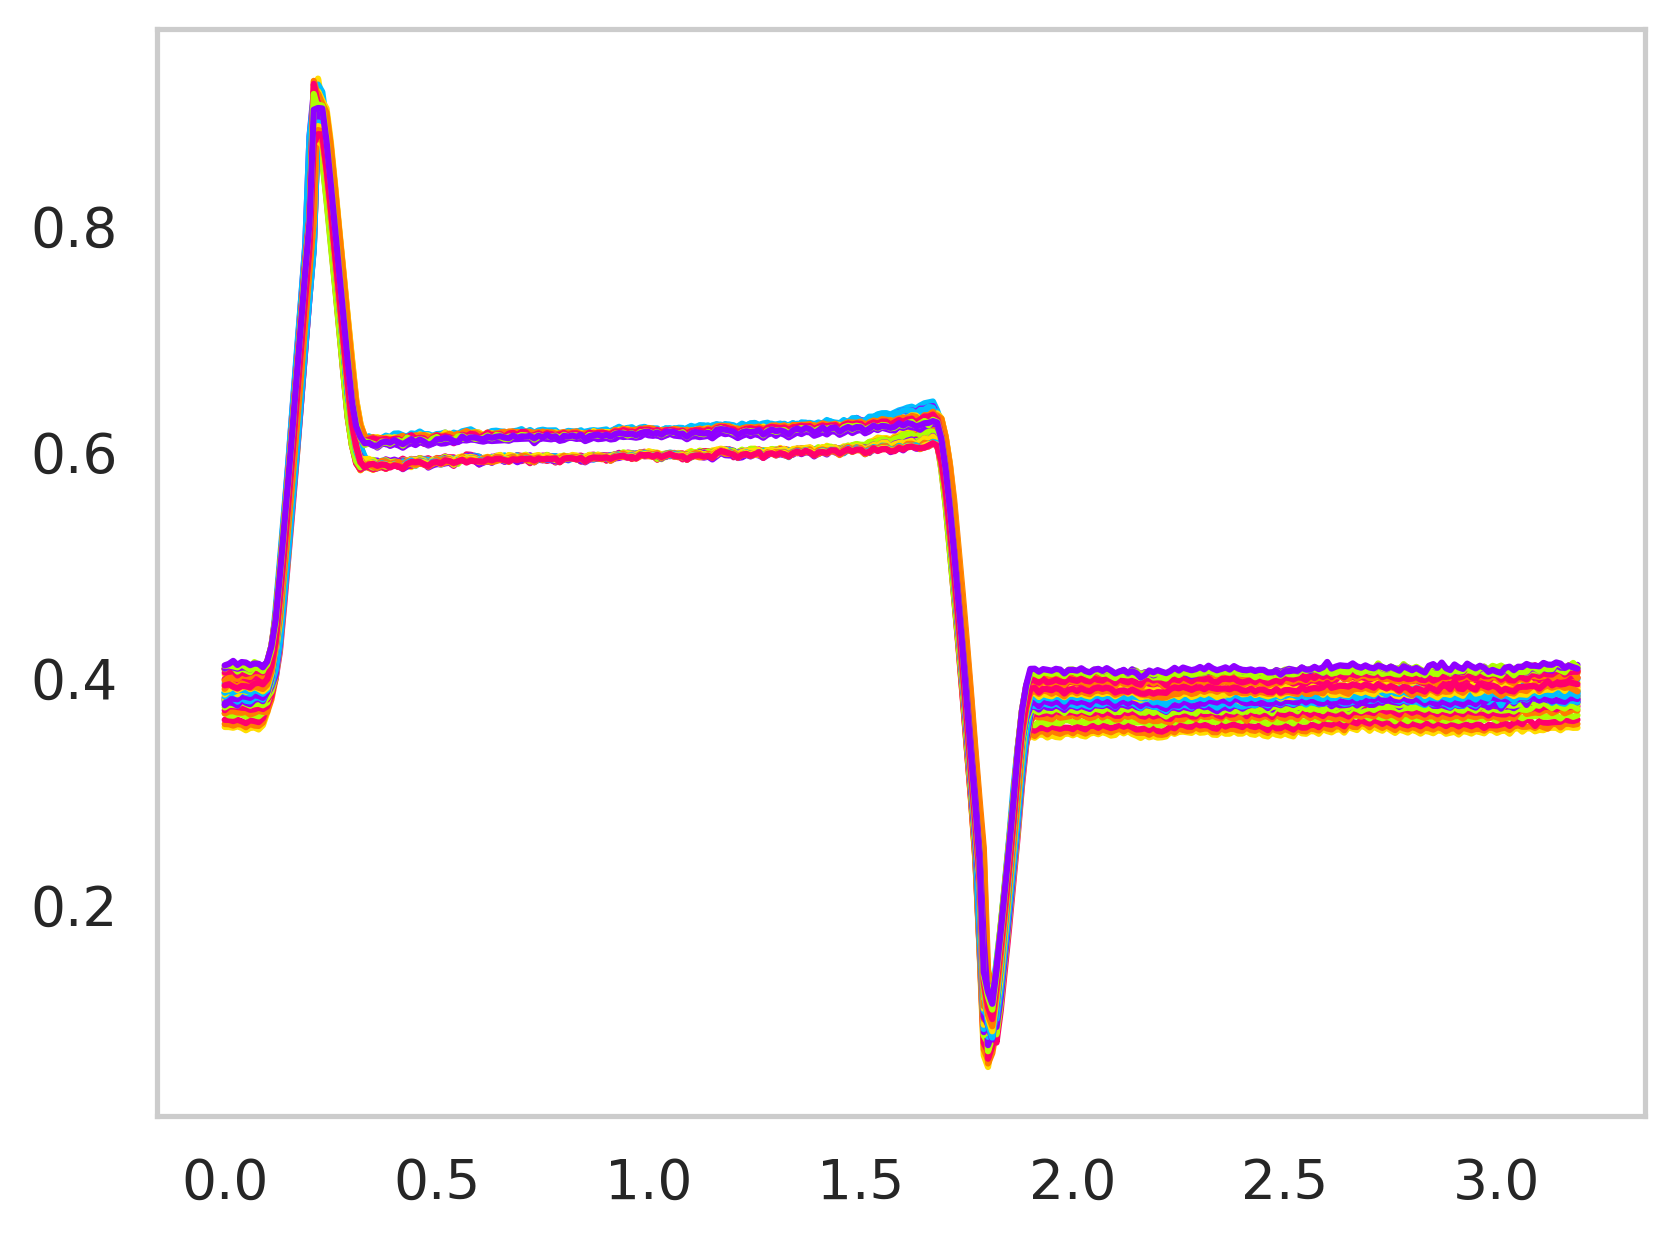

In [101]:
# 所有42个数据放在一起

plt.figure(dpi=150, figsize=plt.rcParamsDefault["figure.figsize"])
for i in range(len(df)):
  for j in range(len(start_pos[i])):
    start = start_pos[i][j]
    end = start_pos[i][j] + 320*7
    indexes = np.arange(0, 3.20, 0.01)
    values = preprocessing.MinMaxScaler().fit_transform(df[i]['values'].values[start:end].reshape(-1, 1)).reshape(-1)
    values = values[:320*7].reshape(-1, 7).mean(axis=1)
    plt.plot(indexes, values, label=i)

plt.grid(None)
# plt.legend()
plt.show()

In [102]:
# write circle into csv
def write_circle2csv(path):
  result_df = pd.DataFrame()
  for i in range(len(df)):
    for j in range(len(start_pos[i])):
      start = start_pos[i][j]
      end = start + 320*7
      indexes = np.arange(0, 3.20, 0.01)
      values = preprocessing.MinMaxScaler().fit_transform(df[i]['values'].values[start:end].reshape(-1, 1)).reshape(-1)
      values = values[:320*7].reshape(-1, 7).mean(axis=1)

      result_df = result_df.append(pd.DataFrame(np.append(values, class_to_id['Normal'])).T, ignore_index=True)

  result_df.to_csv(path, index=False, header=False, mode='w+')

In [103]:
# write_circle2csv(real_cnc_N_path)

In [104]:
real_cnc_N_df = pd.read_csv(real_cnc_N_path, header=None)
real_cnc_N_df.rename(columns={320: 'target'}, inplace=True)
real_cnc_N_df

0         1         2         3         4         5         6  \
0   0.385580  0.384982  0.384012  0.385837  0.384668  0.382644  0.384839   
1   0.356050  0.356021  0.355401  0.356582  0.355312  0.353157  0.355224   
2   0.358676  0.358472  0.357274  0.358647  0.358121  0.355872  0.358735   
3   0.362345  0.362316  0.361278  0.362460  0.361106  0.359434  0.361941   
4   0.368276  0.366345  0.366004  0.367850  0.367197  0.365266  0.367282   
5   0.381050  0.380260  0.379119  0.380611  0.379733  0.376836  0.380348   
6   0.386815  0.384775  0.384200  0.386211  0.385234  0.382590  0.386240   
7   0.393543  0.394815  0.394787  0.396398  0.396313  0.396879  0.394815   
8   0.367886  0.369815  0.370020  0.368850  0.368646  0.369523  0.367009   
9   0.370815  0.374143  0.374287  0.373651  0.373101  0.372812  0.371220   
10  0.375637  0.377573  0.377516  0.376776  0.377403  0.377801  0.375125   
11  0.378229  0.380342  0.379356  0.379272  0.380145  0.381497  0.378708   
12  0.394805  0.398442  0.400375  0.398644  0.398355  0.398644  0.397114   
13  0.397860  0.401076  0.400250  0.399027  0.399055  0.398827  0.395582   
14  0.406854  0.404556  0.407583  0.406182  0.404724  0.407667  0.405789   
15  0.380054  0.378693  0.380837  0.379186  0.377361  0.379099  0.380750   
16  0.379011  0.377955  0.380895  0.380753  0.379411  0.381580  0.381266   
17  0.381973  0.379734  0.383418  0.384042  0.383192  0.386253  0.384467   
18  0.386436  0.384366  0.387667  0.386520  0.385009  0.387136  0.388087   
19  0.402328  0.401523  0.404513  0.403938  0.401753  0.404053  0.402213   
20  0.407026  0.406117  0.408760  0.407026  0.405577  0.408050  0.406060   
21  0.398259  0.400274  0.399547  0.396720  0.398903  0.397755  0.396440   
22  0.373339  0.375568  0.375597  0.374960  0.378116  0.376523  0.374931   
23  0.375246  0.377985  0.377129  0.374932  0.379868  0.377443  0.376159   
24  0.380143  0.382882  0.381329  0.378420  0.381837  0.379268  0.378703   
25  0.381120  0.383827  0.384051  0.382376  0.385921  0.384804  0.386088   
26  0.396889  0.399931  0.399042  0.398496  0.401567  0.401108  0.400304   
27  0.404059  0.404908  0.405729  0.401596  0.404512  0.402870  0.403889   
28  0.407205  0.410254  0.409893  0.407787  0.410198  0.408341  0.408591   
29  0.376670  0.381172  0.381029  0.380599  0.383151  0.382721  0.381746   
30  0.382935  0.385910  0.386136  0.384777  0.387751  0.386335  0.385315   
31  0.384738  0.387851  0.387403  0.385019  0.388833  0.387150  0.387487   
32  0.391920  0.393780  0.391948  0.391531  0.394502  0.393086  0.391337   
33  0.407603  0.409677  0.411950  0.407859  0.410331  0.408796  0.408257   
34  0.408010  0.410633  0.409308  0.405020  0.407926  0.406261  0.404513   
35  0.407795  0.410042  0.408599  0.407517  0.408599  0.408571  0.406768   
36  0.386370  0.388309  0.386598  0.388537  0.388794  0.388338  0.386855   
37  0.388746  0.389395  0.391990  0.388690  0.390721  0.392074  0.389451   
38  0.389758  0.394095  0.393536  0.390765  0.392892  0.392332  0.390346   
39  0.392816  0.393813  0.391569  0.390046  0.392234  0.391957  0.391237   
40  0.410051  0.410505  0.409711  0.408718  0.411328  0.409144  0.406761   
41  0.410468  0.411818  0.414432  0.410862  0.413420  0.412970  0.410665   

           7         8         9  ...       311       312       313       314  \
0   0.384155  0.383670  0.386150  ...  0.384554  0.383499  0.384925  0.385096   
1   0.355548  0.353865  0.357615  ...  0.353245  0.355076  0.355401  0.355312   
2   0.357304  0.356982  0.359991  ...  0.355843  0.354587  0.358589  0.358881   
3   0.361307  0.360356  0.363815  ...  0.360010  0.359780  0.360241  0.360443   
4   0.366515  0.365436  0.368617  ...  0.365010  0.365294  0.365720  0.366004   
5   0.379089  0.378211  0.382367  ...  0.380084  0.379148  0.380465  0.380260   
6   0.385091  0.384775  0.387677  ...  0.385550  0.384200  0.385321  0.385464   
7   0.396087  0.397161  0.396229  ...  0.395946  0.395550  0.396540  0.396342   
8   0.368441 

<Figure size 960x720 with 0 Axes>

Text(0.5, 0, 'time steps (s)')

Text(0, 0.5, 'normalized current values (A)')

Text(0.5, 1.0, ' Artificially generated cnc anomaly data')

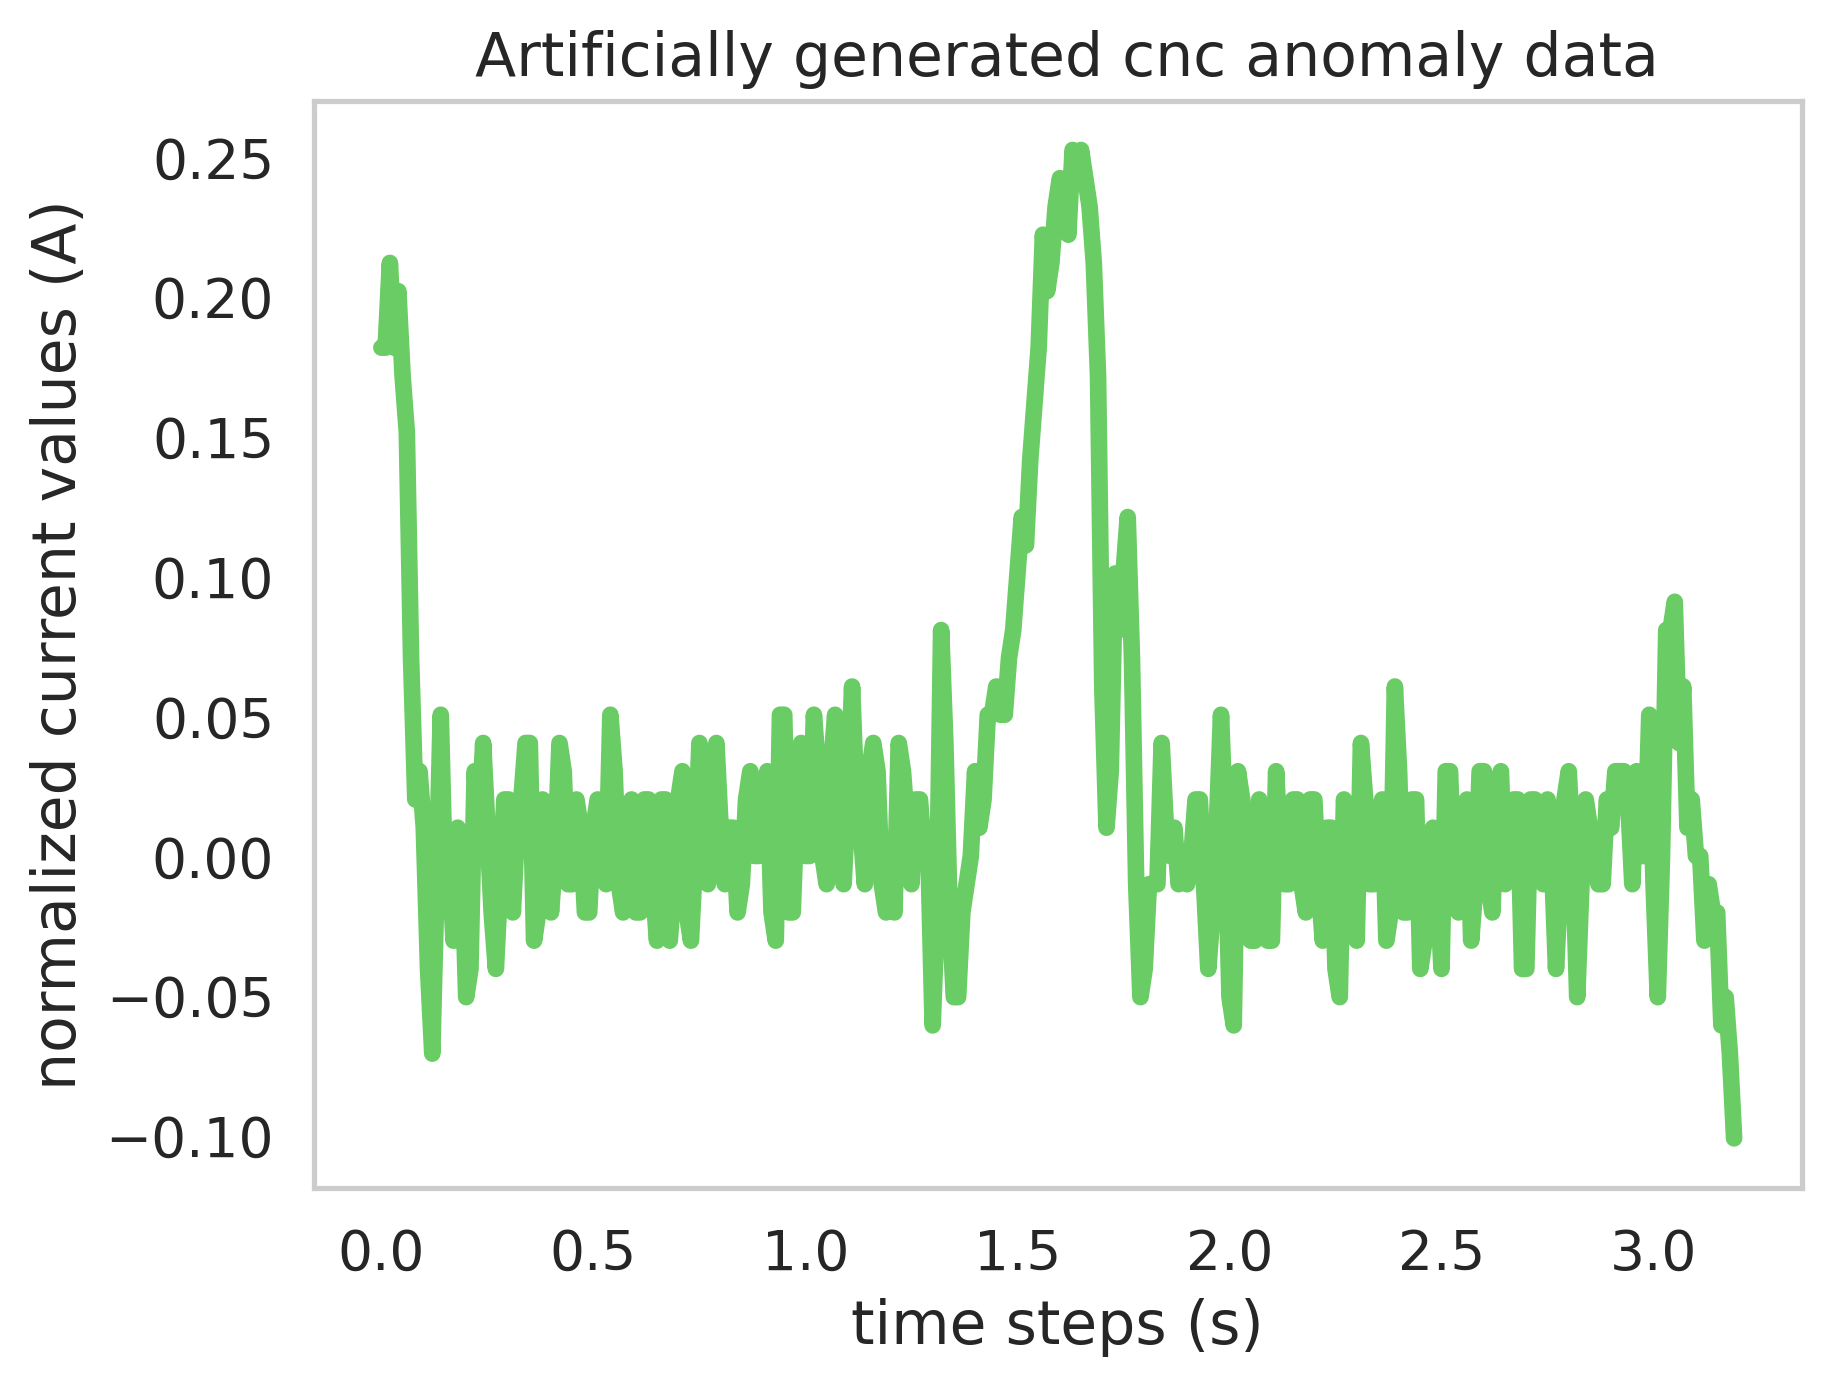

In [122]:
# 用差值加到CNC normal上生成CNC anomaly 以及 CNC N with force
lineWidth = 4
plt.figure(dpi=150)

start_id = 0
indexes, values = prepare_axies(real_N_df.iloc[start_id,:-1], sampling_frequency)
# plt.plot(indexes, values, label = 'normal', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], lw = lineWidth)

left = real_025_df
indexes, values = prepare_axies(left.iloc[start_id+0,:-1], sampling_frequency)
# plt.plot(indexes, values, label = 'left 0.10mm', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][3], lw = lineWidth)

substracted = left.iloc[start_id+0,:-1] - real_N_df.iloc[start_id,:-1]

indexes, values = prepare_axies(substracted, sampling_frequency)
# plt.plot(indexes, values, label = 'substracted signal', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][2], lw = lineWidth)
plt.plot(indexes, values, label = 'substracted signal', c='g', lw = lineWidth)

indexes, values = prepare_axies(real_cnc_N_df.iloc[start_id,:-1], sampling_frequency)
# plt.plot(indexes, values, label = 'cnc normal', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], lw = lineWidth)

indexes, values = prepare_axies(real_cnc_N_df.iloc[start_id,:-1] + substracted, sampling_frequency)
# plt.plot(indexes, values, label = 'cnc anomaly', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][3], lw = lineWidth)
# plt.plot(indexes, values, label = 'cnc anomaly', c='g', lw = lineWidth)

plt.grid(b=None)
# plt.legend()
plt.xlabel("time steps (s)")
plt.ylabel("normalized current values (A)")
plt.title(' Artificially generated cnc anomaly data')
plt.show()

In [ ]:
# 把差值每个与cnc normal 加一遍用来生成
def create_cnc_anomaly_data(data_label): 
  if data_label == '005':
    left_path =  real_005_path
    save_path = real_cnc_005_path
    label = class_to_id['Left']
  elif data_label == '010':
    left_path =  real_010_path
    save_path = real_cnc_010_path
    label = class_to_id['Left']
  elif data_label == '015':
    left_path =  real_015_path
    save_path = real_cnc_015_path
    label = class_to_id['Left']
  elif data_label == '020':
    left_path =  real_020_path
    save_path = real_cnc_020_path
    label = class_to_id['Left']
  elif data_label == '025':
    left_path =  real_025_path
    save_path = real_cnc_025_path
    label = class_to_id['Left']
  elif data_label == 'N_p005':
    left_path =  real_N_p005_path
    save_path = real_cnc_N_p005_path
    label = class_to_id['Normal']
  elif data_label == 'N_p010':
    left_path =  real_N_p010_path
    save_path = real_cnc_N_p010_path
    label = class_to_id['Normal']

  left_df = pd.read_csv(left_path, header=None)
  N_df = pd.read_csv(real_N_path, header=None)

  res_df = pd.DataFrame()

  for i in range(len(left_df)):
    diff = left_df.iloc[i,:-1] - N_df.iloc[0,:-1]
    for k in range(len(real_cnc_N_df)):
      values = (diff + real_cnc_N_df.iloc[k,:-1]).values.reshape(-1)
      res_df = res_df.append(pd.DataFrame(np.append(values, label)).T, ignore_index=True)
  res_df.reset_index(drop=True, inplace=True)
  res_df.to_csv(save_path, index=False, header=False)
  # result_df.to_csv(real_cnc_anomaly_path, index=False, header=False, mode='w+')

In [ ]:
# create_cnc_anomaly_data('005')
# create_cnc_anomaly_data('010')
# create_cnc_anomaly_data('015')
# create_cnc_anomaly_data('020')
# create_cnc_anomaly_data('025')
# create_cnc_anomaly_data('N_p005')
# create_cnc_anomaly_data('N_p010')

In [ ]:
real_cnc_005_df = pd.read_csv(real_cnc_005_path, header=None)
real_cnc_010_df = pd.read_csv(real_cnc_010_path, header=None)
real_cnc_015_df = pd.read_csv(real_cnc_015_path, header=None)
real_cnc_020_df = pd.read_csv(real_cnc_020_path, header=None)
real_cnc_025_df = pd.read_csv(real_cnc_025_path, header=None)
real_cnc_N_df = pd.read_csv(real_cnc_N_path, header=None)
real_cnc_N_p005_df = pd.read_csv(real_cnc_N_p005_path, header=None)
real_cnc_N_p010_df = pd.read_csv(real_cnc_N_p010_path, header=None)

In [ ]:
real_cnc_normal_df = pd.concat([real_cnc_N_df, real_cnc_N_p005_df, real_cnc_N_p010_df],axis = 0, ignore_index= True)
real_cnc_normal_df.rename(columns={320: 'target'}, inplace=True)
real_cnc_normal_df

0         1         2         3         4         5         6  \
0     0.385580  0.384982  0.384012  0.385837  0.384668  0.382644  0.384839   
1     0.356050  0.356021  0.355401  0.356582  0.355312  0.353157  0.355224   
2     0.358676  0.358472  0.357274  0.358647  0.358121  0.355872  0.358735   
3     0.362345  0.362316  0.361278  0.362460  0.361106  0.359434  0.361941   
4     0.368276  0.366345  0.366004  0.367850  0.367197  0.365266  0.367282   
...        ...       ...       ...       ...       ...       ...       ...   
1801  0.671575  0.652021  0.674818  0.671518  0.673549  0.674903  0.621775   
1802  0.672586  0.656722  0.676364  0.673594  0.675720  0.675161  0.622669   
1803  0.675644  0.656439  0.674398  0.672874  0.675062  0.674785  0.623560   
1804  0.692880  0.673131  0.692539  0.691547  0.694156  0.691972  0.639085   
1805  0.693297  0.674444  0.697260  0.693690  0.696248  0.695798  0.642988   

             7         8         9  ...       311       312       313  \
0     0.384155  0.383670  0.386150  ...  0.384554  0.383499  0.384925   
1     0.355548  0.353865  0.357615  ...  0.353245  0.355076  0.355401   
2     0.357304  0.356982  0.359991  ...  0.355843  0.354587  0.358589   
3     0.361307  0.360356  0.363815  ...  0.360010  0.359780  0.360241   
4     0.366515  0.365436  0.368617  ...  0.365010  0.365294  0.365720   
...        ...       ...       ...  ...       ...       ...       ...   
1801  0.512722  0.420065  0.377461  ...  0.499716  0.490179  0.520116   
1802  0.513097  0.421012  0.379489  ...  0.502464  0.493594  0.522107   
1803  0.515634  0.425473  0.383656  ...  0.504065  0.497537  0.524156   
1804  0.530299  0.438653  0.396575  ...  0.519376  0.508169  0.538613   
1805  0.533367  0.442149  0.398737  ...  0.523744  0.512153  0.542344   

           314       315       316       317       318       319  target  
0     0.385096  0.382758  0.385039  0.386293  0.385295  0.385837     1.0  
1     0.355312  0.353186  0.355785  0.355932  0.355283  0.355371     1.0  
2     0.358881  0.355639  0.358793  0.358939  0.357975  0.358676     1.0  
3     0.360443  0.360644  0.363036  0.361740  0.361307  0.362489     1.0  
4     0.366004  0.363590  0.366856  0.366629  0.365010  0.366345     1.0  
...        ...       ...       ...       ...       ...       ...     ...  
1801  0.502283  0.502368  0.468708  0.503665  0.483407  0.450452     1.0  
1802  0.503024  0.503332  0.471378  0.502380  0.480275  0.448097     1.0  
1803  0.505782  0.504702  0.474953  0.506724  0.485663  0.454391     1.0  
1804  0.523545  0.521900  0.489498  0.521134  0.502861  0.469835     1.0  
1805  0.524194  0.523154  0.489084  0.521298  0.499859  0.468235     1.0  

[1806 rows x 321 columns]

In [ ]:
real_cnc_anomaly_df = pd.concat([real_cnc_005_df, real_cnc_010_df, real_cnc_015_df, real_cnc_020_df, real_cnc_025_df],axis = 0, ignore_index= True)
real_cnc_anomaly_df.rename(columns={320: 'target'}, inplace=True)
real_cnc_anomaly_df

0         1         2         3         4         5         6  \
0      0.617904  0.617305  0.626437  0.597958  0.566486  0.524058  0.465647   
1      0.588374  0.588344  0.597825  0.568703  0.537130  0.494571  0.436032   
2      0.591000  0.590795  0.599699  0.570768  0.539940  0.497286  0.439543   
3      0.594668  0.594639  0.603703  0.574581  0.542924  0.500848  0.442749   
4      0.600599  0.598668  0.608428  0.579971  0.549015  0.506680  0.448090   
...         ...       ...       ...       ...       ...       ...       ...   
16039  0.509958  0.520708  0.553606  0.540205  0.562438  0.553691  0.540967   
16040  0.510970  0.525409  0.555152  0.542281  0.564609  0.553949  0.541861   
16041  0.514028  0.525126  0.553185  0.541561  0.563951  0.553573  0.542752   
16042  0.531264  0.541818  0.571327  0.560234  0.583045  0.570760  0.558277   
16043  0.531680  0.543131  0.576048  0.562377  0.585137  0.574586  0.562180   

              7         8         9  ...       311       312       313  \
0      0.404357  0.383670  0.386150  ...  0.354251  0.322893  0.324319   
1      0.375750  0.353865  0.357615  ...  0.322942  0.294470  0.294795   
2      0.377506  0.356982  0.359991  ...  0.325540  0.293981  0.297983   
3      0.381509  0.360356  0.363815  ...  0.329707  0.299174  0.299635   
4      0.386717  0.365436  0.368617  ...  0.334707  0.304688  0.305114   
...         ...       ...       ...  ...       ...       ...       ...   
16039  0.462217  0.440267  0.438067  ...  0.368403  0.368967  0.368601   
16040  0.462592  0.441214  0.440095  ...  0.371151  0.372382  0.370591   
16041  0.465129  0.445675  0.444262  ...  0.372752  0.376325  0.372641   
16042  0.479794  0.458855  0.457181  ...  0.388063  0.386956  0.387098   
16043  0.482862  0.462351  0.459343  ...  0.392431  0.390941  0.390828   

            314       315       316       317       318       319  target  
0      0.294187  0.301950  0.263827  0.285283  0.243881  0.234322     0.0  
1      0.264403  0.272378  0.234572  0.254922  0.213868  0.203856     0.0  
2      0.267972  0.274831  0.237581  0.257929  0.216561  0.207161     0.0  
3      0.269534  0.279836  0.241824  0.260729  0.219893  0.210974     0.0  
4      0.275095  0.282782  0.245644  0.265619  0.223596  0.214830     0.0  
...         ...       ...       ...       ...       ...       ...     ...  
16039  0.350768  0.360953  0.317193  0.352150  0.321790  0.288836     0.0  
16040  0.351509  0.361918  0.319862  0.350865  0.318659  0.286481     0.0  
16041  0.354267  0.363288  0.323438  0.355209  0.324047  0.292775     0.0  
16042  0.372030  0.380486  0.337983  0.369619  0.341245  0.308219     0.0  
16043  0.372679  0.381739  0.337569  0.369783  0.338243  0.306619     0.0  

[16044 rows x 321 columns]

<Figure size 960x720 with 0 Axes>

Text(0.5, 0, 'time steps (s)')

Text(0, 0.5, 'normalized current values (A)')

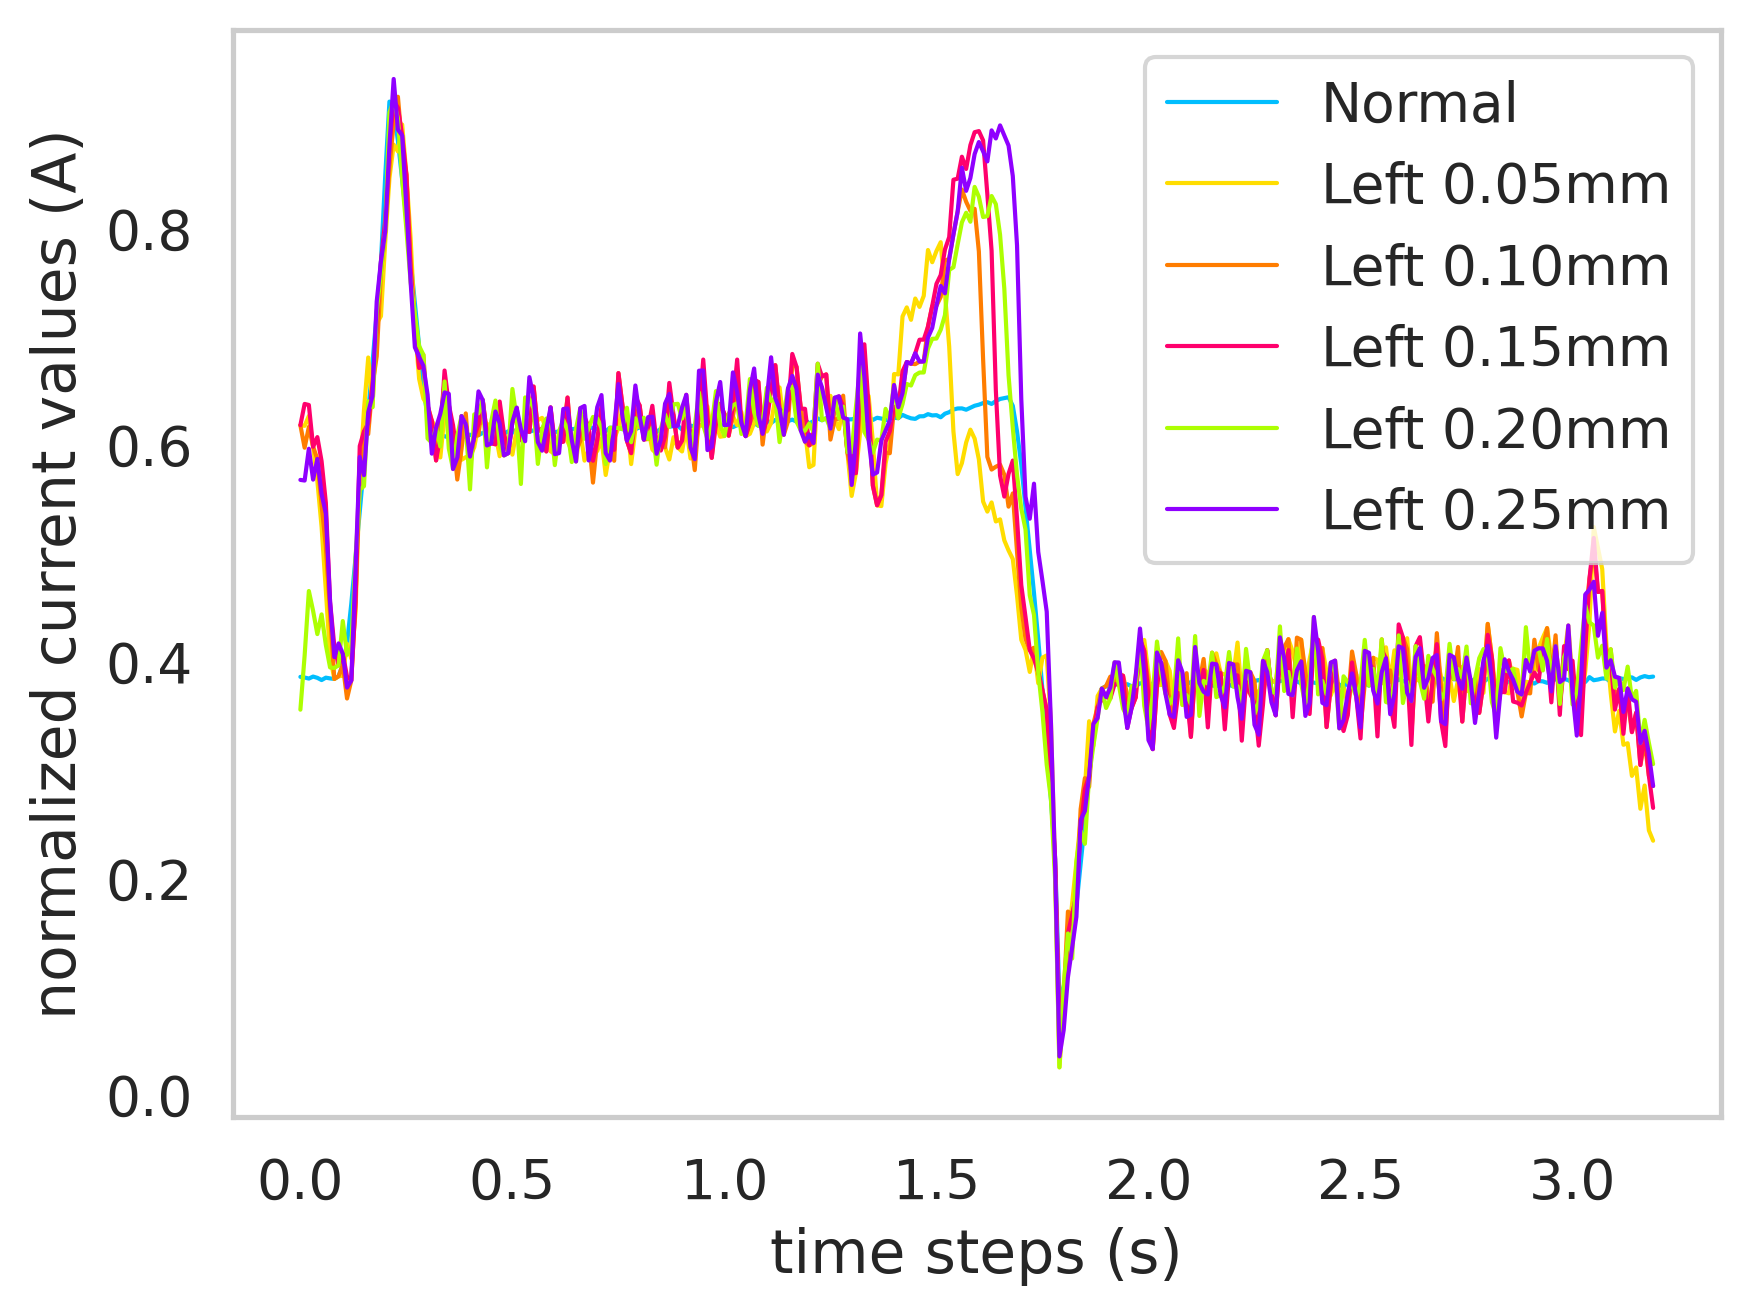

In [ ]:
lineWidth = 1
plt.figure(dpi=150)

indexes, values = prepare_axies(real_cnc_N_df.iloc[0,:-1], sampling_frequency)
plt.plot(indexes, values, label = 'Normal', lw = lineWidth)

# indexes, values = prepare_axies(real_cnc_N_p005_df.iloc[100,:-1], sampling_frequency)
# plt.plot(indexes, values, label = 'Normal with 10N', lw = lineWidth)

# indexes, values = prepare_axies(real_cnc_N_p010_df.iloc[0,:-1], sampling_frequency)
# plt.plot(indexes, values, label = 'Normal with 25N', lw = lineWidth)

indexes, values = prepare_axies(real_cnc_005_df.iloc[0,:-1], sampling_frequency)
plt.plot(indexes, values, label = 'Left 0.05mm', lw = lineWidth)

indexes, values = prepare_axies(real_cnc_010_df.iloc[0,:-1], sampling_frequency)
plt.plot(indexes, values, label = 'Left 0.10mm', lw = lineWidth)

indexes, values = prepare_axies(real_cnc_015_df.iloc[0,:-1], sampling_frequency)
plt.plot(indexes, values, label = 'Left 0.15mm', lw = lineWidth)

indexes, values = prepare_axies(real_cnc_020_df.iloc[0,:-1], sampling_frequency)
plt.plot(indexes, values, label = 'Left 0.20mm', lw = lineWidth)

indexes, values = prepare_axies(real_cnc_025_df.iloc[0,:-1], sampling_frequency)
plt.plot(indexes, values, label = 'Left 0.25mm', lw = lineWidth)

plt.grid(b=None)
plt.legend()
plt.xlabel("time steps (s)")
plt.ylabel("normalized current values (A)")
# plt.title(' fake data')
plt.show()

In [ ]:
real_cnc_df = pd.concat([real_cnc_normal_df, real_cnc_anomaly_df],axis = 0, ignore_index= True)

In [ ]:
real_cnc_df.target.value_counts()

0.0    16044
1.0     1806
Name: target, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'anomaly'), Text(0, 0, 'normal')]

Text(-0.050000000000000044, 16044.05, '16044.0')

Text(0.95, 1806.05, '1806.0')

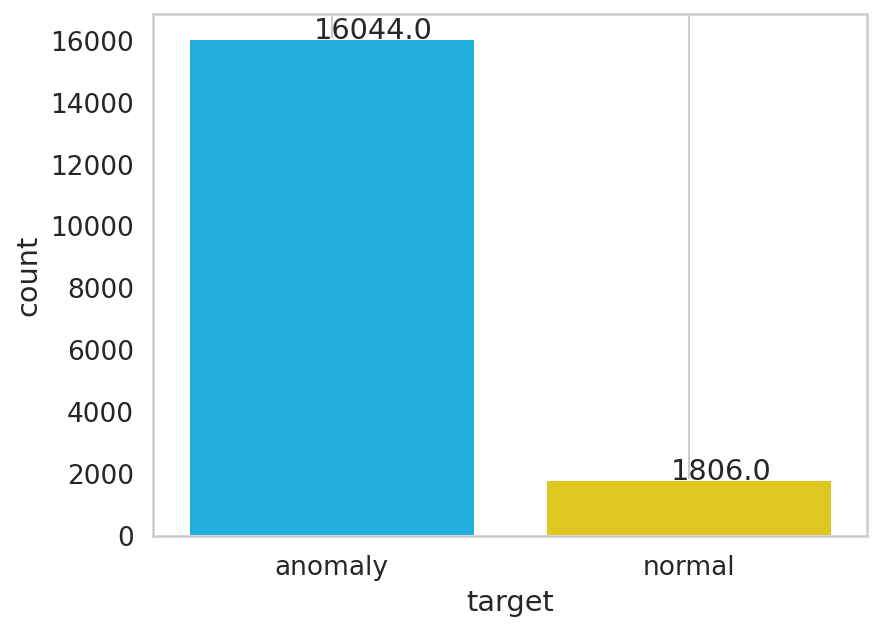

In [ ]:
ax = sns.countplot(real_cnc_df.target)
ax.set_xticklabels(['anomaly','normal'])
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.05))
plt.grid(None)
plt.show()

# CNC GAN

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Discriminator(nn.Module):
    def __init__(self, num_kernal=32):
      self.num_kernal = num_kernal
      super().__init__()
      self.conv_1 = self._block(1, self.num_kernal, 4, 2, 1)
      self.conv_2 = self._block(self.num_kernal, self.num_kernal*2, 4, 2, 1)
      self.conv_3 = self._block(self.num_kernal*2, self.num_kernal*4, 4, 2, 1)
      self.conv_4 = self._block(self.num_kernal*4, self.num_kernal*8, 4, 2, 1)
      self.conv_5 = self._block(self.num_kernal*8, self.num_kernal*16, 4, 2, 1)
      self.conv_6 = nn.Conv1d(self.num_kernal*16, 1, kernel_size=10, stride=1, padding=0, bias=False)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv1d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )
    def forward(self, x, y=None):
        output = x.permute(0, 2, 1)
        output = self.conv_1(output)
        # print(output.shape)
        output = self.conv_2(output)
        # print(output.shape)
        output = self.conv_3(output)
        # print(output.shape)
        output = self.conv_4(output)
        # print(output.shape)
        output = self.conv_5(output)
        # print(output.shape)
        output = self.conv_6(output)
        # print(output.shape)
        return output

class Generator(nn.Module):
    def __init__(self, nz=100, num_kernal=32):
      self.nz = nz
      self.num_kernal = num_kernal
      super().__init__()
      self.conv_1 = self._block(self.nz, self.num_kernal*16, 10, 1, 0)
      self.conv_2 = self._block(self.num_kernal*16, self.num_kernal*8, 4, 2, 1)
      self.conv_3 = self._block(self.num_kernal*8, self.num_kernal*4, 4, 2, 1)
      self.conv_4 = self._block(self.num_kernal*4, self.num_kernal*2, 4, 2, 1)
      self.conv_5 = self._block(self.num_kernal*2, self.num_kernal, 4, 2, 1)
      self.conv_6 = nn.ConvTranspose1d(self.num_kernal, 1, kernel_size=4, stride=2, padding=1, bias=False)
      self.sigmoid =  nn.Sigmoid()

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose1d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        output = self.conv_1(x)
        # print(output.shape)
        output = self.conv_2(output)
        # print(output.shape)
        output = self.conv_3(output)
        # print(output.shape)
        output = self.conv_4(output)
        # print(output.shape)
        output = self.conv_5(output)
        # print(output.shape)
        output = self.conv_6(output)
        # print(output.shape)
        output = self.sigmoid(output)
        # print(output.shape)
        output = output.permute(0, 2, 1)
        # print(output.shape)
        return output

In [ ]:
class Trainer_CNC:
  def __init__(
    self,
    generator,
    discriminator,
    batch_size,
    num_epochs,
    n_critic,
    clip_value,
    nz,
    data_path,
    lr,
    label,
    label_name,
    id,
    patience,
    makeGIF
  ):
    self.n_critic = n_critic
    self.clip_value = clip_value
    self.lr = lr
    self.num_epochs = num_epochs
    self.batch_size = batch_size
    self.nz = nz
    self.data_path = data_path
    self.label = label
    self.label_name = label_name
    self.id = id
    self.patience = patience
    self.makeGIF = makeGIF
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.netD = discriminator.to(self.device)
    self.netD.apply(weights_init)
    self.netG = generator.to(self.device)
    self.netG.apply(weights_init)

    self.fixed_noise = torch.randn(self.batch_size, self.nz, 1, device=self.device)
    self.dataloader = get_dataloader(path=self.data_path, label_name=self.label_name, batch_size=self.batch_size)
    
    self.optimizerD = optim.RMSprop(self.netD.parameters(), lr=self.lr)
    self.optimizerG = optim.RMSprop(self.netG.parameters(), lr=self.lr)
    
    self.early_stopping = EarlyStopping(verbose = True, patience = self.patience)
    
    self.lossD = []
    self.lossG = []
    self.best_diff = 10000.0
    self.netD_best_state = None
    self.netG_best_state = None

  def _one_epoch(self):
    for step, (data, labels) in enumerate(self.dataloader):
      # training netD
      real = data.to(self.device)
      b_size = real.size(0)
      self.netD.zero_grad()

      noise = torch.randn(b_size, self.nz, 1, device=self.device)
      fake = self.netG(noise)

      loss_disc = -torch.mean(self.netD(real)) + torch.mean(self.netD(fake))
      loss_disc.backward()
      self.optimizerD.step()

      for p in self.netD.parameters():
        p.data.clamp_(-self.clip_value, self.clip_value)

      if step % self.n_critic == 0:
        # training netG
        noise = torch.randn(b_size, self.nz, 1, device=self.device)
        self.netG.zero_grad()
        fake = self.netG(noise)
        loss_gen = -torch.mean(self.netD(fake))

        self.netD.zero_grad()
        self.netG.zero_grad()
        loss_gen.backward()
        self.optimizerG.step()
    return step, loss_disc.item(), loss_gen.item()

  def run(self):
    for epoch in range(self.num_epochs + 1):
      step, loss_disc, loss_gen = self._one_epoch()
      self.lossG.append(loss_gen)
      self.lossD.append(loss_disc)

      fake = self.netG(self.fixed_noise).detach().cpu()
      real = next(iter(self.dataloader))[0]

      diff = np.array(fake.view(-1)) - np.array(real.view(-1))
      diff = np.sum(diff ** 2) / self.batch_size
      print('[%d/%d][%d/%d]\tloss_netD: %.4f\tloss_netG: %.4f\tdiff: %.4f\tbest_diff: %.4f'
        % (epoch, self.num_epochs, step, len(self.dataloader), loss_disc, loss_gen, diff, self.best_diff))
      
      # early_stopping needs the diff to check if it has decresed, 
      # and if it has, it will make a checkpoint of the current model
      self.early_stopping(diff, self.netG)
      if self.early_stopping.early_stop:
        print("Early stopping")
        break

      if diff <= self.best_diff:
        self.best_diff = diff
        with torch.no_grad():
          if self.makeGIF == True:
            fig, ax = plt.subplots()
            line_width = 2

            indexes = []
            values = []
            for index,value in enumerate(fake[self.id].view(-1)):
              indexes.append(index/sampling_frequency)
              values.append(value)
            ax.plot(indexes, values, label='fake', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][3], linewidth=line_width)
            
            indexes = []
            values = []
            for index,value in enumerate(real[self.id].view(-1)):
              indexes.append(index/sampling_frequency)
              values.append(value)
            ax.plot(indexes, values, label='real', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], linewidth=line_width)
            # ax.set_title(f'{" mean square error"} (loss: {np.around(diff, 2)})')
            ax.set_title('epoch:{} for CNC 0.1mm misalignment'.format(epoch))
            # ax.set_title('epoch:{} for CNC normal condition'.format(epoch))
            ax.set_xlabel("time steps (S)")
            ax.set_ylabel("normalized current value (A)")
            plt.legend()
            plt.savefig('drive/MyDrive/dataset/checkpoint/WGAN_OLD/GIF/%d.png' % epoch)
            plt.close()
          if self.best_diff < 1.0:
            self.netD_best_state = self.netD.state_dict()
            self.netG_best_state = self.netG.state_dict()

            if self.label == 'cnc_N':
              netD_path = 'drive/MyDrive/dataset/checkpoint/WGAN_OLD/CNC_Normal/'+ self.label_name + '/netD/'
              netG_path = 'drive/MyDrive/dataset/checkpoint/WGAN_OLD/CNC_Normal/'+ self.label_name + '/netG/'
            elif self.label == 'cnc_anomaly':
              netD_path = 'drive/MyDrive/dataset/checkpoint/WGAN_OLD/CNC_Anomaly/'+ self.label_name + '/netD/'
              netG_path = 'drive/MyDrive/dataset/checkpoint/WGAN_OLD/CNC_Anomaly/'+ self.label_name + '/netG/'
           
            netD_path = os.path.join(netD_path, 'netD_{}_{}.pt'.format(self.label_name, round(diff*10)))
            netG_path = os.path.join(netG_path, 'netG_{}_{}.pt'.format(self.label_name, round(diff*10)))
            torch.save(self.netD_best_state, netD_path)
            torch.save(self.netG_best_state, netG_path)

    # print(self.best_diff)
    # plot the loss
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(self.lossG, label="G")
    plt.plot(self.lossD, label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [ ]:
# import shutil  
# shutil.rmtree('drive/MyDrive/dataset/checkpoint/WGAN_OLD/GIF')  
# os.mkdir('drive/MyDrive/dataset/checkpoint/WGAN_OLD/GIF')  

In [ ]:
# nz = 100

# # early stopping patience; how long to wait after last time validation loss improved.
# patience = 300

# trainer = Trainer_CNC(
#     generator=Generator(nz, 32),
#     discriminator=Discriminator(32),
#     batch_size=128,
#     num_epochs=5000,
#     n_critic=5,
#     clip_value=0.01, # 0.005,  
#     nz = nz,
#     data_path = real_cnc_N_p010_path,  # real_cnc_005_path   real_cnc_N_path  real_cnc_N_p005_path
#     lr=5e-5,
#     label='cnc_N',  # 'cnc_anomaly' 'cnc_N',
#     label_name = 'N_p010', # '005' 'N',  'N_p005'
#     id=0,
#     patience = patience,
#     makeGIF = True
# )
# trainer.run()



# # 020 0.7

In [ ]:
# png_dir = 'drive/MyDrive/dataset/checkpoint/WGAN_OLD/GIF/'
# gif_path = 'drive/MyDrive/dataset/checkpoint/WGAN_OLD/GIF/movie.gif'
# images = []

# for file_name in sorted(os.listdir(png_dir), key=len):
#   if file_name.endswith('.png'):
#     file_path = os.path.join(png_dir, file_name)
#     images.append(imageio.imread(file_path))
# imageio.mimsave(gif_path, images, format='GIF', duration=0.001)

In [ ]:
# def cnc_generation_perform(label_name, label_class):
#   nz = 100
#   fig, ax = plt.subplots(dpi=150, figsize=plt.rcParamsDefault["figure.figsize"])
#   line_width = 2

#   if label_class == 'N':
#     real_data_path = real_cnc_N_path
#   elif label_class == '005':
#     real_data_path = real_cnc_anomaly_005_path
#   elif label_class == '010':
#     real_data_path = real_cnc_anomaly_010_path
#   elif label_class == '015':
#     real_data_path = real_cnc_anomaly_015_path
#   elif label_class == '020':
#     real_data_path = real_cnc_anomaly_020_path
#   elif label_class == '025':
#     real_data_path = real_cnc_anomaly_025_path

#   real_dataloader = get_dataloader(path=real_data_path, label_name=label_name, batch_size=32)
#   real = next(iter(real_dataloader))[0]

#   generator_dir = None
#   if label_name =='CNC_N':
#     generator_dir = '/content/drive/MyDrive/dataset/checkpoint/WGAN_OLD/CNC_Normal/' + label_class + '/netG/'

#   elif label_name =='CNC_Anomaly':
#     generator_dir = '/content/drive/MyDrive/dataset/checkpoint/WGAN_OLD/CNC_Anomaly/' + label_class + '/netG/'

#   generator_paths = os.listdir(generator_dir)
#   generator_paths.sort(key = lambda x:int(x[7:-3]))
#   generator_path = generator_paths[0]

#   g = Generator(nz)
#   g.load_state_dict(torch.load(generator_dir+generator_path))
#   fixed_noise = torch.randn(1, nz, 1)
#   fake = g(fixed_noise).detach().cpu()

#   # for i in range(real.shape[0]):
#   #   diff = np.array(fake.detach().cpu().view(-1)) - np.array(real[i].detach().cpu().view(-1))
#   #   diff = diff ** 2
#   #   diff_sum += diff
#   # diff_sum = np.sum(diff_sum) / real.shape[0]   
#   # print(diff_sum)

#   indexes, values = prepare_axies(fake[0].view(-1), sampling_frequency)
#   ax.plot(indexes, values, label='fake', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][3], linewidth=line_width)

#   indexes, values = prepare_axies(real[0].view(-1), sampling_frequency)
#   ax.plot(indexes, values, label='real', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], linewidth=line_width)

#   ax.set_xlabel("time steps (S)")
#   ax.set_ylabel("normalized current values (A)")
#   ax.set_title(label_name+'_'+label_class)
#   plt.grid(b=None)
#   plt.legend()
#   plt.show()

In [ ]:
# # cnc_generation_perform('CNC_N', 'N')
# # cnc_generation_perform('CNC_Anomaly', '005') 
# # cnc_generation_perform('CNC_Anomaly', '010') 
# # cnc_generation_perform('CNC_Anomaly', '015') 
# # cnc_generation_perform('CNC_Anomaly', '020') 
# cnc_generation_perform('CNC_Anomaly', '025')  

In [ ]:
# compare different mse levels of generation performances
import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)
    
def cnc_generation_compare(label_name, label_class):
  nz = 100
  # line_width = 1
  # fig, ax = plt.subplots(dpi=150)

  num_x = 3
  num_y = 2
  line_width = 2
  
  fig, axs = plt.subplots(nrows=num_x, ncols=num_y, sharey=True, sharex=True, constrained_layout=True, figsize=(12,12))

  if label_class == 'N':
    real_data_path = real_cnc_N_path
    # fig.suptitle('The training process of the GAN model on normal condition data', fontsize='large')
  elif label_class == 'N_p005':
    real_data_path = real_cnc_N_p005_path
    # fig.suptitle('The training process of the GAN model on left side 0.05mm misalignment data', fontsize='large')
  elif label_class == 'N_p010':
    real_data_path = real_cnc_N_p010_path
    # fig.suptitle('The training process of the GAN model on left side 0.05mm misalignment data', fontsize='large')
  elif label_class == '005':
    real_data_path = real_cnc_005_path
    # fig.suptitle('The training process of the GAN model on left side 0.05mm misalignment data', fontsize='large')
  elif label_class == '010':
    real_data_path = real_cnc_010_path
    # fig.suptitle('The training process of the GAN model on left side 0.10mm misalignment data', fontsize='large')
  elif label_class == '015':
    real_data_path = real_cnc_015_path
    # fig.suptitle('The training process of the GAN model on left side 0.15mm misalignment data', fontsize='large')
  elif label_class == '020':
    real_data_path = real_cnc_020_path
    # fig.suptitle('The training process of the GAN model on left side 0.20mm misalignment data', fontsize='large')
  elif label_class == '025':
    real_data_path = real_cnc_025_path

  real_dataloader = get_dataloader(path=real_data_path, label_name=label_class, batch_size=32)
  real = next(iter(real_dataloader))[0]


  if label_name =='CNC_N':
    generator_dir = '/content/drive/MyDrive/dataset/checkpoint/WGAN_OLD/CNC_Normal/' + label_class + '/netG/'

  elif label_name =='CNC_Anomaly':
    generator_dir = '/content/drive/MyDrive/dataset/checkpoint/WGAN_OLD/CNC_Anomaly/' + label_class + '/netG/'

  generator_paths = sorted_alphanumeric(os.listdir(generator_dir))

  # generator_paths = os.listdir(generator_dir)
  # generator_paths.sort(key = lambda x:int(x[7:-3]), reverse=True)
 
  x = 2
  y = 1
  titles = ['The 300th epoch', 'The 280th epoch', 'The 260th epoch', 
        'The 240th epoch', 'The 220th epoch', 'The 200th epoch']
  for generator_path, title in zip(generator_paths, titles):
    if y < 0:
      x -= 1
      y = 1
    if x < 0:
      break

    if not generator_path.endswith('.pt'):
      continue
    # if generator_path == generator_paths[0]:
    #   title = 'The 200th epoch'
    # elif generator_path == generator_paths[1]:
    #   title = 'The 220th epoch'
    # elif generator_path == generator_paths[2]:
    #   title = 'The 240th epoch'
    # elif generator_path == generator_paths[3]:
    #   title = 'The 260th epoch'
    # elif generator_path == generator_paths[4]:
    #   title = 'The 280th epoch'
    # elif generator_path == generator_paths[5]:
    #   title = 'The 300th epoch'
    # else:
    #   continue

    g = Generator(nz)
    g.load_state_dict(torch.load(generator_dir+generator_path))
    fixed_noise = torch.randn(1, nz, 1)
    fake = g(fixed_noise).detach().cpu()

    indexes, values = prepare_axies(fake[0].view(-1), sampling_frequency)
    axs[x][y].plot(indexes, values, label='fake', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][3], linewidth=line_width)
    indexes, values = prepare_axies(real[0].view(-1), sampling_frequency)
    axs[x][y].plot(indexes, values, label='real', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], linewidth=line_width)
    axs[x][y].set_title(title)
    axs[x][y].grid(None) 
  
    y -= 1

  fig.text(0.5,-0.02, "time steps (s)", ha="center", va="center", fontsize='large')
  fig.text(-0.02,0.5, "normalized current values (A)", ha="center", va="center", rotation=90, fontsize='large')
  plt.legend()
  plt.show()

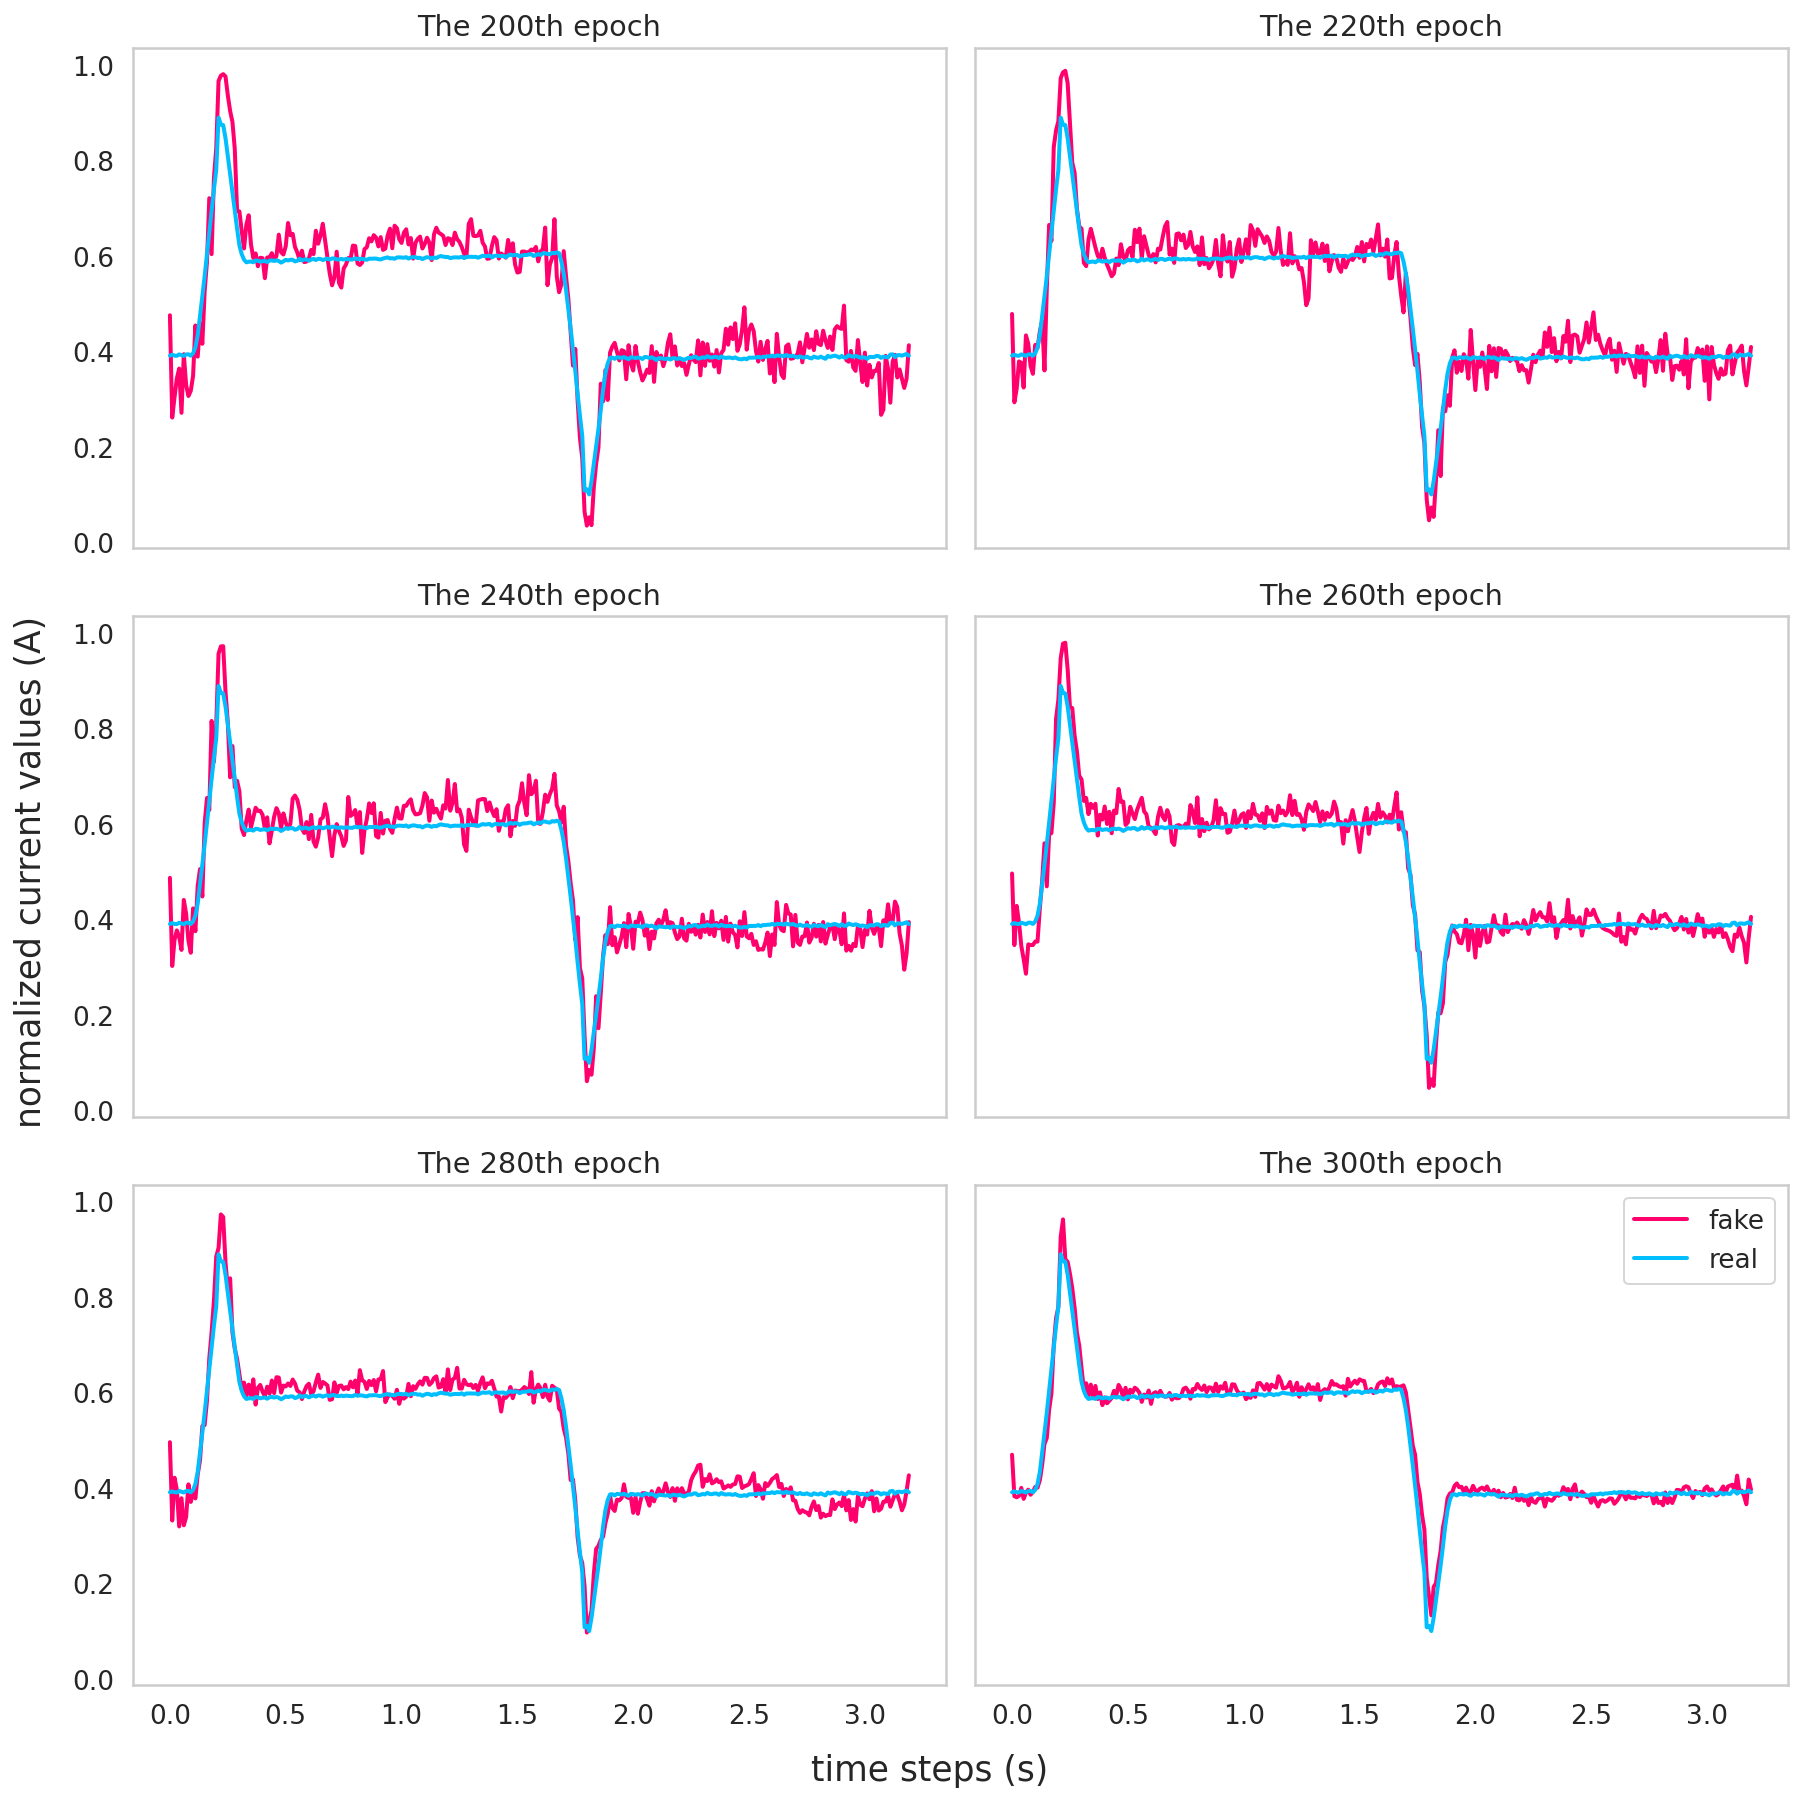

In [ ]:
# cnc_generation_compare('CNC_Anomaly', '005') 
# cnc_generation_compare('CNC_Anomaly', '010') 
# cnc_generation_compare('CNC_Anomaly', '015') 
# cnc_generation_compare('CNC_Anomaly', '020') 
# cnc_generation_compare('CNC_Anomaly', '025') 
cnc_generation_compare('CNC_N', 'N')
# cnc_generation_compare('CNC_N', 'N_p005')
# cnc_generation_compare('CNC_N', 'N_p010')

In [ ]:
# generate fake data and save to csv
def generate_data(label_name):
  nz = 100
  if label_name == 'N':
    real_data_path = real_N_path
    fake_data_path = fake_N_path
    num2generate = len(real_005_df) * 5
  elif label_name == 'N_p005':
    real_data_path = real_N_p005_path
    fake_data_path = fake_N_p005_path
    num2generate = len(real_005_df) * 5
  elif label_name == 'N_p010':
    real_data_path = real_N_p010_path
    fake_data_path = fake_N_p010_path
    num2generate = len(real_005_df) * 5
  elif label_name == '005':
    real_data_path = real_005_path
    fake_data_path = fake_005_path
    num2generate = len(real_005_df) * 5
  elif label_name == '010':
    real_data_path = real_010_path
    fake_data_path = fake_010_path
    num2generate = len(real_005_df) * 5
  elif label_name == '015':
    real_data_path = real_015_path
    fake_data_path = fake_015_path
    num2generate = len(real_005_df) * 5
  elif label_name == '020':
    real_data_path = real_020_path
    fake_data_path = fake_020_path
    num2generate = len(real_005_df) * 5
  elif label_name == '025':
    real_data_path = real_025_path
    fake_data_path = fake_025_path
    num2generate = len(real_005_df) * 5

  real_dataloader = get_dataloader(path=real_data_path, label_name=label_name, batch_size=32)
  real = next(iter(real_dataloader))[0]  # 12

  if label_name.startswith('N'):
    generator_dir = '/content/drive/MyDrive/dataset/checkpoint/WGAN_OLD/LinearFeedAxis_Normal/' + label_name + '/netG/'
  else:
    generator_dir = '/content/drive/MyDrive/dataset/checkpoint/WGAN_OLD/LinearFeedAxis_Anomaly/' + label_name + '/netG/'
  generator_paths = sorted_alphanumeric(os.listdir(generator_dir))

  res_df = pd.DataFrame()

  for generator_path in generator_paths[0:5]:
    if not generator_path.endswith('.pt'):
      continue
    # if generator_path.endswith('1.pt'):
    #   level = 1
    # elif generator_path.endswith('2.pt'):
    #   level = 2
    # elif generator_path.endswith('3.pt'):
    #   level = 3
    # elif generator_path.endswith('4.pt'):
    #   level = 4
    # elif generator_path.endswith('5.pt'):
    #   level = 5
    # else:
    #   continue

    g = Generator(nz)
    g.load_state_dict(torch.load(generator_dir+generator_path))
    tmp_df = pd.DataFrame()

    for i in range(num2generate):
      diff_sum = 999
      while diff_sum > 0.9:
        diff_sum = 0
        fixed_noise = torch.randn(1, 100, 1)
        fake = g(fixed_noise).detach().cpu()

        for i in range(real.shape[0]):
          diff = np.array(fake.detach().cpu().view(-1)) - np.array(real[i].detach().cpu().view(-1))
          diff = diff ** 2
          diff_sum += diff
        diff_sum = np.sum(diff_sum) / real.shape[0]

      tmp_df = tmp_df.append(pd.DataFrame(fake.detach().cpu().view(-1)).T, ignore_index=True)

    target = pd.DataFrame(data=int(next(iter(real_dataloader))[1][0]), index=range(num2generate), columns=range(1))
    tmp_df = pd.concat([tmp_df,target],axis = 1, ignore_index= True)
    res_df = pd.concat([res_df,tmp_df],axis = 0, ignore_index= True)
  res_df.reset_index(drop=True, inplace=True)
  res_df.to_csv(fake_data_path, index=False, header=False)

  return res_df

In [ ]:
# generate fake data and save to csv
def generate_cnc_data(label_name, label_class):
  nz = 100

  if label_class == 'N':
    real_data_path = real_cnc_N_path
    fake_data_path = fake_cnc_N_path
  elif label_class == 'N_p005':
    real_data_path = real_cnc_N_p005_path
    fake_data_path = fake_cnc_N_p005_path
  elif label_class == 'N_p010':
    real_data_path = real_cnc_N_p010_path
    fake_data_path = fake_cnc_N_p010_path
  elif label_class == '005':
    real_data_path = real_cnc_005_path
    fake_data_path = fake_cnc_005_path
  elif label_class == '010':
    real_data_path = real_cnc_010_path
    fake_data_path = fake_cnc_010_path
  elif label_class == '015':
    real_data_path = real_cnc_015_path
    fake_data_path = fake_cnc_015_path
  elif label_class == '020':
    real_data_path = real_cnc_020_path
    fake_data_path = fake_cnc_020_path
  elif label_class == '025':
    real_data_path = real_cnc_025_path
    fake_data_path = fake_cnc_025_path

  if label_name =='CNC_N':
    generator_dir = '/content/drive/MyDrive/dataset/checkpoint/WGAN_OLD/CNC_Normal/' + label_class + '/netG/'
    num2generate = 800
    target_id = 1
  elif label_name =='CNC_Anomaly':
    generator_dir = '/content/drive/MyDrive/dataset/checkpoint/WGAN_OLD/CNC_Anomaly/' + label_class + '/netG/'
    num2generate = 400
    target_id = 0
  generator_paths = sorted_alphanumeric(os.listdir(generator_dir))

  res_df = pd.DataFrame()
  for generator_path in generator_paths[:5]:
    if not generator_path.endswith('.pt'):
      continue

    g = Generator(nz)
    g.load_state_dict(torch.load(generator_dir+generator_path))
    tmp_df = pd.DataFrame()

    fixed_noise = torch.randn(num2generate, 100, 1)
    fake = g(fixed_noise).detach().cpu().view(num2generate,-1).numpy()
    tmp_df = tmp_df.append(pd.DataFrame(fake), ignore_index=True)

    target = pd.DataFrame(data=target_id, index=range(num2generate), columns=range(1))
    tmp_df = pd.concat([tmp_df,target],axis = 1, ignore_index= True)
    res_df = pd.concat([res_df,tmp_df],axis = 0, ignore_index= True)
  res_df.reset_index(drop=True, inplace=True)
  res_df.to_csv(fake_data_path, index=False, header=False)

  return res_df

In [ ]:
# generate_cnc_data('CNC_N', 'N')
# generate_cnc_data('CNC_N', 'N_p005')
# generate_cnc_data('CNC_N', 'N_p010')
# generate_cnc_data('CNC_Anomaly', '005') 
# generate_cnc_data('CNC_Anomaly', '010') 
# generate_cnc_data('CNC_Anomaly', '015') 
# generate_cnc_data('CNC_Anomaly', '020') 
# generate_cnc_data('CNC_Anomaly', '025')  

In [ ]:
fake_cnc_N_df = pd.read_csv(fake_cnc_N_path, header=None)
fake_cnc_N_p005_df = pd.read_csv(fake_cnc_N_p005_path, header=None)
fake_cnc_N_p010_df = pd.read_csv(fake_cnc_N_p010_path, header=None)
fake_cnc_005_df = pd.read_csv(fake_cnc_005_path, header=None)
fake_cnc_010_df = pd.read_csv(fake_cnc_010_path, header=None)
fake_cnc_015_df = pd.read_csv(fake_cnc_015_path, header=None)
fake_cnc_020_df = pd.read_csv(fake_cnc_020_path, header=None)
fake_cnc_025_df = pd.read_csv(fake_cnc_025_path, header=None)

In [ ]:
fake_cnc_normal_df = pd.concat([fake_cnc_N_df, fake_cnc_N_p005_df, fake_cnc_N_p010_df],axis = 0, ignore_index= True)
fake_cnc_normal_df.rename(columns={320: 'target'}, inplace=True)

In [ ]:
cnc_normal_df = pd.concat([real_cnc_normal_df, fake_cnc_normal_df],axis = 0, ignore_index= True)
cnc_normal_df

0         1         2         3         4         5         6  \
0      0.385580  0.384982  0.384012  0.385837  0.384668  0.382644  0.384839   
1      0.356050  0.356021  0.355401  0.356582  0.355312  0.353157  0.355224   
2      0.358676  0.358472  0.357274  0.358647  0.358121  0.355872  0.358735   
3      0.362345  0.362316  0.361278  0.362460  0.361106  0.359434  0.361941   
4      0.368276  0.366345  0.366004  0.367850  0.367197  0.365266  0.367282   
...         ...       ...       ...       ...       ...       ...       ...   
13801  0.554341  0.723853  0.710221  0.669336  0.677687  0.587544  0.611387   
13802  0.557233  0.733863  0.709942  0.678076  0.665341  0.590170  0.622717   
13803  0.560084  0.731080  0.709242  0.671375  0.675057  0.580976  0.608778   
13804  0.567310  0.753942  0.731829  0.689121  0.708637  0.608853  0.626688   
13805  0.556812  0.732175  0.716271  0.682337  0.699746  0.612754  0.636566   

              7         8         9  ...       311       312       313  \
0      0.384155  0.383670  0.386150  ...  0.384554  0.383499  0.384925   
1      0.355548  0.353865  0.357615  ...  0.353245  0.355076  0.355401   
2      0.357304  0.356982  0.359991  ...  0.355843  0.354587  0.358589   
3      0.361307  0.360356  0.363815  ...  0.360010  0.359780  0.360241   
4      0.366515  0.365436  0.368617  ...  0.365010  0.365294  0.365720   
...         ...       ...       ...  ...       ...       ...       ...   
13801  0.423582  0.434349  0.315215  ...  0.517208  0.537957  0.485591   
13802  0.421342  0.414859  0.326981  ...  0.501197  0.526871  0.471752   
13803  0.417786  0.425143  0.318454  ...  0.502624  0.505964  0.470503   
13804  0.447209  0.425993  0.321644  ...  0.508405  0.527543  0.486769   
13805  0.469656  0.456360  0.358435  ...  0.506341  0.521562  0.474936   

            314       315       316       317       318       319  target  
0      0.385096  0.382758  0.385039  0.386293  0.385295  0.385837     1.0  
1      0.355312  0.353186  0.355785  0.355932  0.355283  0.355371     1.0  
2      0.358881  0.355639  0.358793  0.358939  0.357975  0.358676     1.0  
3      0.360443  0.360644  0.363036  0.361740  0.361307  0.362489     1.0  
4      0.366004  0.363590  0.366856  0.366629  0.365010  0.366345     1.0  
...         ...       ...       ...       ...       ...       ...     ...  
13801  0.514801  0.435876  0.474256  0.484514  0.534899  0.492477     1.0  
13802  0.493104  0.424433  0.462425  0.474533  0.508786  0.491811     1.0  
13803  0.493101  0.446425  0.462131  0.475333  0.504170  0.492594     1.0  
13804  0.518174  0.453047  0.480233  0.489620  0.517891  0.493188     1.0  
13805  0.501560  0.440262  0.450749  0.479112  0.506747  0.492732     1.0  

[13806 rows x 321 columns]

In [ ]:
fake_cnc_anomaly_df = pd.concat([fake_cnc_005_df, fake_cnc_010_df,fake_cnc_015_df,fake_cnc_020_df,fake_cnc_025_df],axis = 0, ignore_index= True)
fake_cnc_anomaly_df.rename(columns={320: 'target'}, inplace=True)

In [ ]:
cnc_anomaly_df = pd.concat([real_cnc_anomaly_df, fake_cnc_anomaly_df],axis = 0, ignore_index= True)
cnc_anomaly_df

0         1         2         3         4         5         6  \
0      0.617904  0.617305  0.626437  0.597958  0.566486  0.524058  0.465647   
1      0.588374  0.588344  0.597825  0.568703  0.537130  0.494571  0.436032   
2      0.591000  0.590795  0.599699  0.570768  0.539940  0.497286  0.439543   
3      0.594668  0.594639  0.603703  0.574581  0.542924  0.500848  0.442749   
4      0.600599  0.598668  0.608428  0.579971  0.549015  0.506680  0.448090   
...         ...       ...       ...       ...       ...       ...       ...   
26039  0.514124  0.544967  0.569384  0.560809  0.609283  0.567090  0.540752   
26040  0.512485  0.547797  0.583515  0.568764  0.614274  0.570764  0.546161   
26041  0.511902  0.536877  0.565460  0.556117  0.590846  0.560971  0.528126   
26042  0.509498  0.528520  0.553679  0.542298  0.578747  0.549782  0.521119   
26043  0.513276  0.536122  0.562549  0.549692  0.583952  0.557828  0.520057   

              7         8         9  ...       311       312       313  \
0      0.404357  0.383670  0.386150  ...  0.354251  0.322893  0.324319   
1      0.375750  0.353865  0.357615  ...  0.322942  0.294470  0.294795   
2      0.377506  0.356982  0.359991  ...  0.325540  0.293981  0.297983   
3      0.381509  0.360356  0.363815  ...  0.329707  0.299174  0.299635   
4      0.386717  0.365436  0.368617  ...  0.334707  0.304688  0.305114   
...         ...       ...       ...  ...       ...       ...       ...   
26039  0.476943  0.432123  0.406706  ...  0.364214  0.399988  0.357459   
26040  0.495719  0.448015  0.432167  ...  0.278935  0.340745  0.293536   
26041  0.475520  0.420453  0.391782  ...  0.355490  0.381217  0.342041   
26042  0.474001  0.410916  0.377064  ...  0.332522  0.373066  0.326532   
26043  0.457967  0.412851  0.383546  ...  0.368788  0.394689  0.340305   

            314       315       316       317       318       319  target  
0      0.294187  0.301950  0.263827  0.285283  0.243881  0.234322     0.0  
1      0.264403  0.272378  0.234572  0.254922  0.213868  0.203856     0.0  
2      0.267972  0.274831  0.237581  0.257929  0.216561  0.207161     0.0  
3      0.269534  0.279836  0.241824  0.260729  0.219893  0.210974     0.0  
4      0.275095  0.282782  0.245644  0.265619  0.223596  0.214830     0.0  
...         ...       ...       ...       ...       ...       ...     ...  
26039  0.380404  0.359028  0.350992  0.350436  0.385978  0.475864     0.0  
26040  0.328689  0.301988  0.314929  0.321050  0.364656  0.469087     0.0  
26041  0.361802  0.337457  0.338249  0.340210  0.373911  0.471337     0.0  
26042  0.352680  0.319302  0.338771  0.345269  0.380637  0.466940     0.0  
26043  0.360072  0.352667  0.360455  0.355598  0.384095  0.470733     0.0  

[26044 rows x 321 columns]

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'anomaly'), Text(0, 0, 'normal')]

Text(-0.050000000000000044, 26044.05, '26044.0')

Text(0.95, 13806.05, '13806.0')

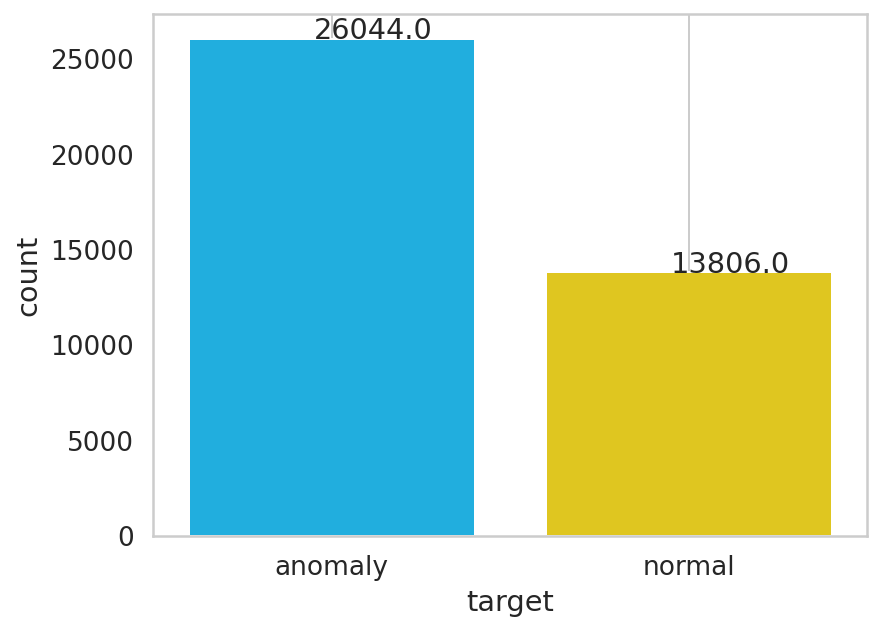

In [ ]:
cnc_all_df = pd.concat([cnc_normal_df, cnc_anomaly_df],axis = 0, ignore_index= True)
ax = sns.countplot(cnc_all_df.target)
ax.set_xticklabels(['anomaly', 'normal'])
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.05))
plt.grid(None)
plt.show()

In [ ]:
# # compare all real and fake data in one figure
# def data_compare_all():
#   real_N_dataloader = get_dataloader(path=real_cnc_N_path, label_name='N', batch_size=32)
#   fake_N_dataloader = get_dataloader(path=fake_cnc_N_path, label_name='N', batch_size=32)

#   real_005_dataloader = get_dataloader(path=real_cnc_anomaly_005_path, label_name='005', batch_size=32)
#   fake_005_dataloader = get_dataloader(path=fake_cnc_anomaly_005_path, label_name='005', batch_size=32)

#   real_010_dataloader = get_dataloader(path=real_cnc_anomaly_010_path, label_name='010', batch_size=32)
#   fake_010_dataloader = get_dataloader(path=fake_cnc_anomaly_010_path, label_name='010', batch_size=32)

#   real_015_dataloader = get_dataloader(path=real_cnc_anomaly_015_path, label_name='015', batch_size=32)
#   fake_015_dataloader = get_dataloader(path=fake_cnc_anomaly_015_path, label_name='015', batch_size=32)

#   real_020_dataloader = get_dataloader(path=real_cnc_anomaly_020_path, label_name='020', batch_size=32)
#   fake_020_dataloader = get_dataloader(path=fake_cnc_anomaly_020_path, label_name='020', batch_size=32)

#   real_025_dataloader = get_dataloader(path=real_cnc_anomaly_025_path, label_name='025', batch_size=32)
#   fake_025_dataloader = get_dataloader(path=fake_cnc_anomaly_025_path, label_name='025', batch_size=32)

#   num_x = 3
#   num_y = 2
#   line_width = 2
  
#   # fig, axs = plt.subplots(nrows=num_x, ncols=num_y, sharey=True, sharex=True, constrained_layout=True, figsize=(12,8))
#   fig, axs = plt.subplots(nrows=num_x, ncols=num_y, sharey=True, sharex=True, constrained_layout=True, figsize=(12,12))
#   fig.suptitle('Generation performances', fontsize='large')

#   real = next(iter(real_N_dataloader))[0]
#   fake = next(iter(fake_N_dataloader))[0]
#   indexes, values = prepare_axies(real[0], sampling_frequency)
#   axs[0][0].plot(indexes, values, label='fake', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][3], linewidth=line_width)
#   indexes, values = prepare_axies(fake[0], sampling_frequency)
#   axs[0][0].plot(indexes, values, label='real', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], linewidth=line_width)
#   axs[0][0].grid(None)
#   axs[0][0].set_title('N')

#   real = next(iter(real_005_dataloader))[0]
#   fake = next(iter(fake_005_dataloader))[0]
#   indexes, values = prepare_axies(real[0], sampling_frequency)
#   axs[0][1].plot(indexes, values, label='fake', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][3], linewidth=line_width)
#   indexes, values = prepare_axies(fake[0], sampling_frequency)
#   axs[0][1].plot(indexes, values, label='real', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], linewidth=line_width)
#   axs[0][1].grid(None)
#   axs[0][1].set_title('005')

#   real = next(iter(real_010_dataloader))[0]
#   fake = next(iter(fake_010_dataloader))[0]
#   indexes, values = prepare_axies(real[0], sampling_frequency)
#   axs[1][0].plot(indexes, values, label='fake', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][3], linewidth=line_width)
#   indexes, values = prepare_axies(fake[0], sampling_frequency)
#   axs[1][0].plot(indexes, values, label='real', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], linewidth=line_width)
#   axs[1][0].grid(None)
#   axs[1][0].set_title('010')

#   real = next(iter(real_015_dataloader))[0]
#   fake = next(iter(fake_015_dataloader))[0]
#   indexes, values = prepare_axies(real[0], sampling_frequency)
#   axs[1][1].plot(indexes, values, label='fake', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][3], linewidth=line_width)
#   indexes, values = prepare_axies(fake[0], sampling_frequency)
#   axs[1][1].plot(indexes, values, label='real', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], linewidth=line_width)
#   axs[1][1].grid(None)
#   axs[1][1].set_title('015')

#   real = next(iter(real_020_dataloader))[0]
#   fake = next(iter(fake_020_dataloader))[0]
#   indexes, values = prepare_axies(real[0], sampling_frequency)
#   axs[2][0].plot(indexes, values, label='fake', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][3], linewidth=line_width)
#   indexes, values = prepare_axies(fake[0], sampling_frequency)
#   axs[2][0].plot(indexes, values, label='real', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], linewidth=line_width)
#   axs[2][0].grid(None)
#   axs[2][0].set_title('020')

#   real = next(iter(real_025_dataloader))[0]
#   fake = next(iter(fake_025_dataloader))[0]
#   indexes, values = prepare_axies(real[0], sampling_frequency)
#   axs[2][1].plot(indexes, values, label='fake', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][3], linewidth=line_width)
#   indexes, values = prepare_axies(fake[0], sampling_frequency)
#   axs[2][1].plot(indexes, values, label='real', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], linewidth=line_width)
#   axs[2][1].grid(None)
#   axs[2][1].set_title('025')


#   fig.text(0.5,-0.02, "time steps (s)", ha="center", va="center")
#   fig.text(-0.02,0.5, "normalized current values (A)", ha="center", va="center", rotation=90)
#   plt.legend()
#   plt.show()

In [ ]:
# data_compare_all()

In [ ]:
def visualization_one_kind(label_name, analysis_type, ax):
  batch_size = 50

  if label_name == 'N':
    real_df = real_cnc_N_df
    fake_df = fake_cnc_N_df
    show_label = 'Normal'
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
  elif label_name == 'N_100':
    real_df = real_cnc_N_df
    fake_df = fake_cnc_N_df
    show_label = 'Normal with vertical 100N'
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
  elif label_name == 'N_200':
    real_df = real_cnc_N_df
    fake_df = fake_cnc_N_df
    show_label = 'Normal with vertical 200N'
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
  elif label_name == 'N_300':
    real_df = real_cnc_N_df
    fake_df = fake_cnc_N_df
    show_label = 'Normal with vertical 300N'
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
  elif label_name == 'N_p005':
    real_df = real_cnc_N_p005_df
    fake_df = fake_cnc_N_p005_df
    show_label = 'Normal with horizontal 10N'
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
  elif label_name == 'N_p010':
    real_df = real_cnc_N_p010_df
    fake_df = fake_cnc_N_p010_df
    show_label = 'Normal with horizontal 25N'
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
  elif label_name == '005':
    real_df = real_cnc_005_df
    fake_df = fake_cnc_005_df
    show_label = 'left 0.05mm'
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
  elif label_name == '010':
    real_df = real_cnc_010_df
    fake_df = fake_cnc_010_df
    show_label = 'left 0.10mm'
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
  elif label_name == '015':
    real_df = real_cnc_015_df
    fake_df = fake_cnc_015_df
    show_label = 'left 0.15mm'
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
  elif label_name == '020':
    real_df = real_cnc_020_df
    fake_df = fake_cnc_020_df
    show_label = 'left 0.20mm'
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][4]
  elif label_name == '025':
    real_df = real_cnc_025_df
    fake_df = fake_cnc_025_df
    show_label = 'left 0.25mm'
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][5]

  df = pd.concat([real_df, fake_df],axis = 0, ignore_index= True)
  df.rename(columns={320: 'target'}, inplace=True)
  # df = df.drop(labels='target', axis=1).iloc[:batch_size,:]
  df = df.drop(labels='target', axis=1)
  if label_name == 'N_100':
    df = df.iloc[batch_size:2*batch_size,:]
  elif label_name == 'N_200':
    df = df.iloc[2*batch_size:3*batch_size,:]
  elif label_name == 'N_300':
    df = df.iloc[3*batch_size:4*batch_size,:]
  else:
    df = df.iloc[:batch_size,:]

  rgb = (random.random(), random.random(), random.random())
  rgb = np.array([rgb])

  if analysis_type == 'pca':
      pca = PCA(n_components=2, random_state=RANDOM_SEED)
      pca_results = pca.fit_transform(df)

      ax.scatter(pca_results[:, 0],
            pca_results[:, 1],
            c=color,
            label=show_label)

  elif analysis_type == 'tsne':
      tsne = TSNE(n_components=2, random_state=RANDOM_SEED, n_jobs=-1,
                  init='random', learning_rate='auto')
      tsne_results = tsne.fit_transform(df)

      ax.scatter(tsne_results[:, 0],
            tsne_results[:, 1],
            c=color,
            label=show_label)
        
def visualization_compare_all_kinds(analysis_type, visualization_type):
    if visualization_type == '3d':
      plt.figure(dpi=150)
      ax = plt.axes(projection='3d')
    elif visualization_type == '2d':
      fig, ax = plt.subplots(dpi=150)
    visualization_one_kind('005', analysis_type, ax)
    visualization_one_kind('010', analysis_type, ax)
    visualization_one_kind('015', analysis_type, ax)
    visualization_one_kind('020', analysis_type, ax)
    visualization_one_kind('025', analysis_type, ax)
    visualization_one_kind('N', analysis_type, ax)
    visualization_one_kind('N_p005', analysis_type, ax)
    visualization_one_kind('N_p010', analysis_type, ax)
    visualization_one_kind('N_100', analysis_type, ax)
    visualization_one_kind('N_200', analysis_type, ax)
    visualization_one_kind('N_300', analysis_type, ax)

    plt.title(analysis_type)
    # plt.axis('off')
    plt.grid(None)
    plt.legend(loc=2,prop={'size': 8})
    plt.show()

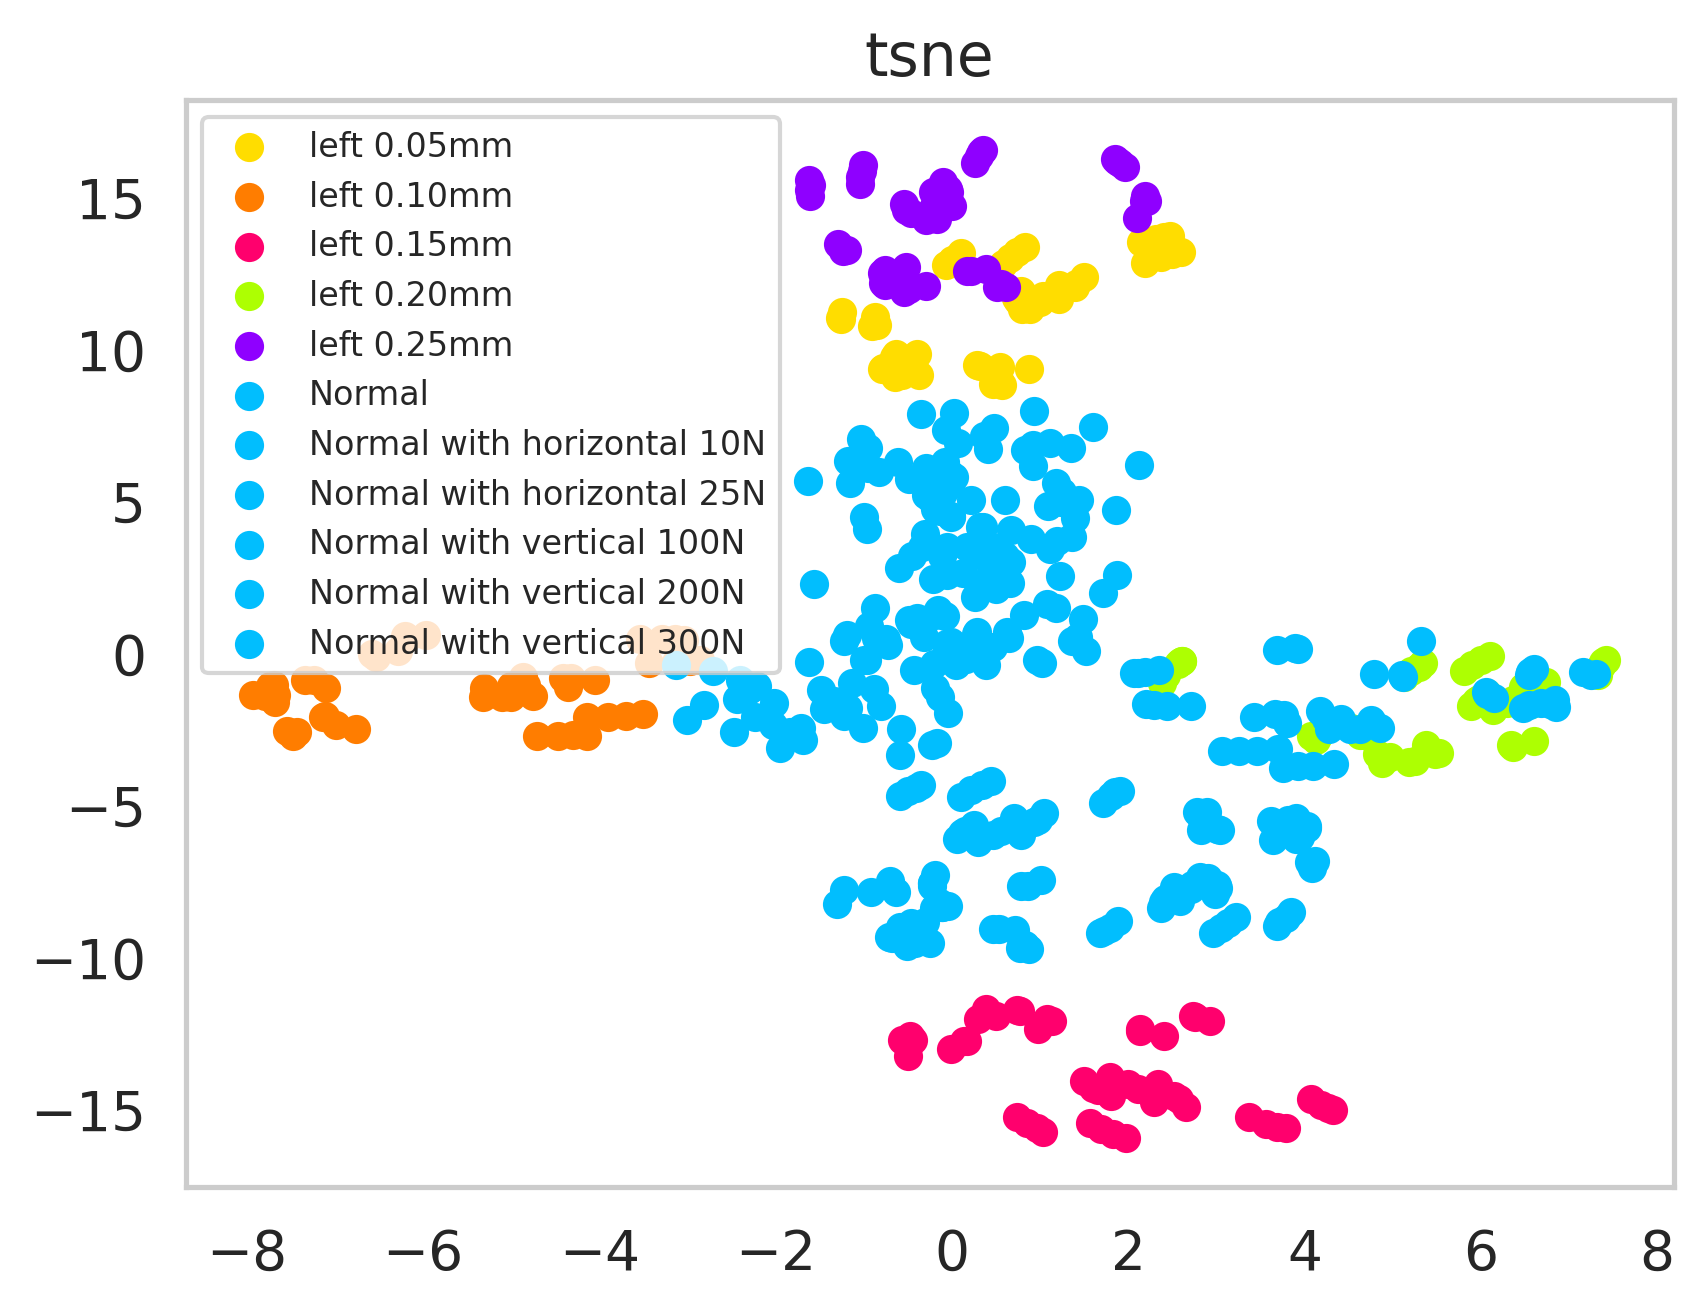

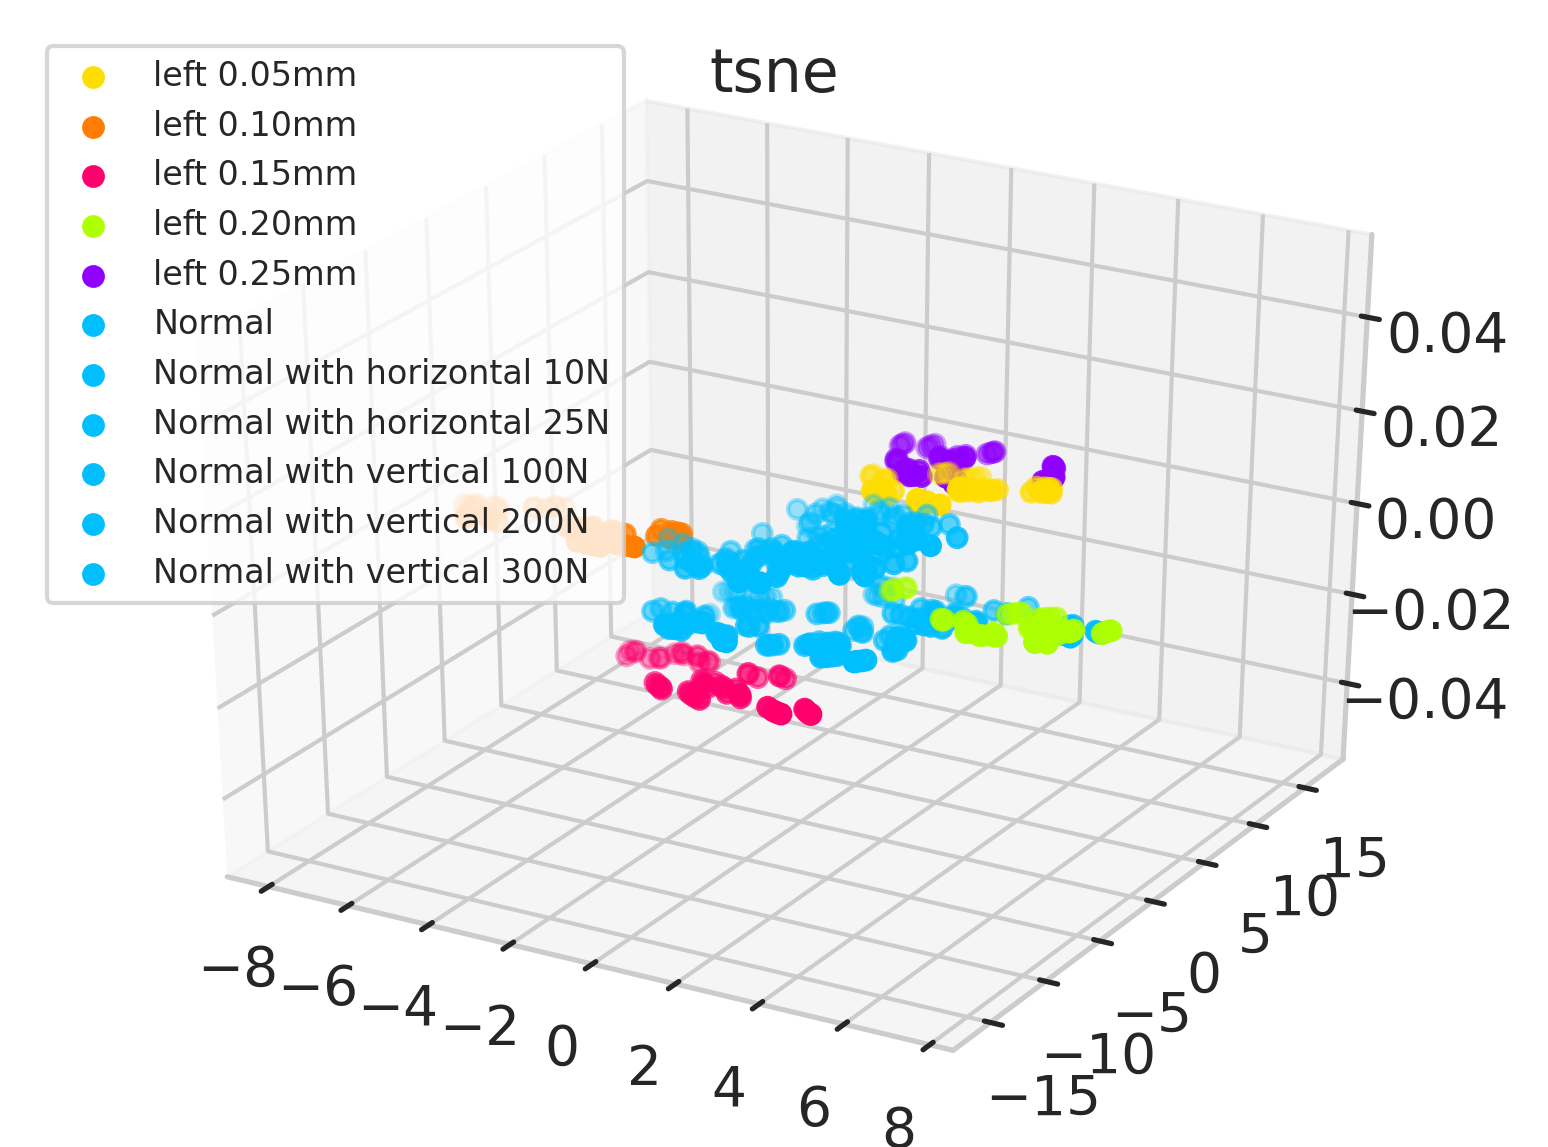

In [ ]:
# visualization_compare_all_kinds('pca', '2d')
# visualization_compare_all_kinds('pca', '3d')

visualization_compare_all_kinds('tsne', '2d')
visualization_compare_all_kinds('tsne', '3d')

In [ ]:
def visualization_compare_normal_anomaly(df_type, analysis_type, visualization_type):
    if visualization_type == '3d':
      plt.figure(dpi=150)
      ax = plt.axes(projection='3d')
    elif visualization_type == '2d':
      fig, ax = plt.subplots(dpi=150)
    if df_type == 'all':
      df = cnc_all_df
    elif df_type == 'real':
      df = real_df
    else:
      df = fake_df
    normal_data = df[df.target==class_to_id['Normal']].drop(labels='target', axis=1)
    normal_data = normal_data.iloc[:3600,:]
    anomaly_data = df[df.target==class_to_id['Left']].drop(labels='target', axis=1)
    anomaly_data = anomaly_data.iloc[:3600,:]

    normal_no = len(normal_data)
    anomaly_no = len(anomaly_data)
    colors = [plt.rcParams['axes.prop_cycle'].by_key()['color'][0] for i in range(normal_no)] + [plt.rcParams['axes.prop_cycle'].by_key()['color'][3] for i in range(anomaly_no)]

    if analysis_type == 'pca':       
        all = np.concatenate((normal_data, anomaly_data), axis=0)
        pca = PCA(n_components=2, random_state=RANDOM_SEED)

        pca_results = pca.fit_transform(all)

        ax.scatter(pca_results[:normal_no, 0],
              pca_results[:normal_no, 1],
              c=colors[:normal_no],
              label='normal')
        ax.scatter(pca_results[normal_no:, 0],
              pca_results[normal_no:, 1],
              c=colors[normal_no:],
              label="anomaly")
        
        # pca_normal_results = pca.fit_transform(normal_data)
        # pca_anomaly_results = pca.transform(anomaly_data)
        
        # ax.scatter(pca_normal_results[:, 0],
        #       pca_normal_results[:, 1],
        #       c=colors[:normal_no],
        #       label="normal")
        # ax.scatter(pca_anomaly_results[:, 0],
        #       pca_anomaly_results[:, 1],
        #       c=colors[normal_no:],
        #       label="anomaly")

    elif analysis_type == 'tsne':
        all = np.concatenate((normal_data, anomaly_data), axis=0)
        tsne = TSNE(n_components=2, random_state=RANDOM_SEED, n_jobs=-1,
               init='random', learning_rate='auto')
        tsne_results = tsne.fit_transform(all)

        ax.scatter(tsne_results[:normal_no, 0],
              tsne_results[:normal_no, 1],
              c=colors[:normal_no],
              label='normal')
        ax.scatter(tsne_results[normal_no:, 0],
              tsne_results[normal_no:, 1],
              c=colors[normal_no:],
              label="anomaly")

    plt.title(analysis_type)
    # plt.axis('off')
    plt.grid(None)
    plt.legend(loc=2,prop={'size': 8})
    plt.show()

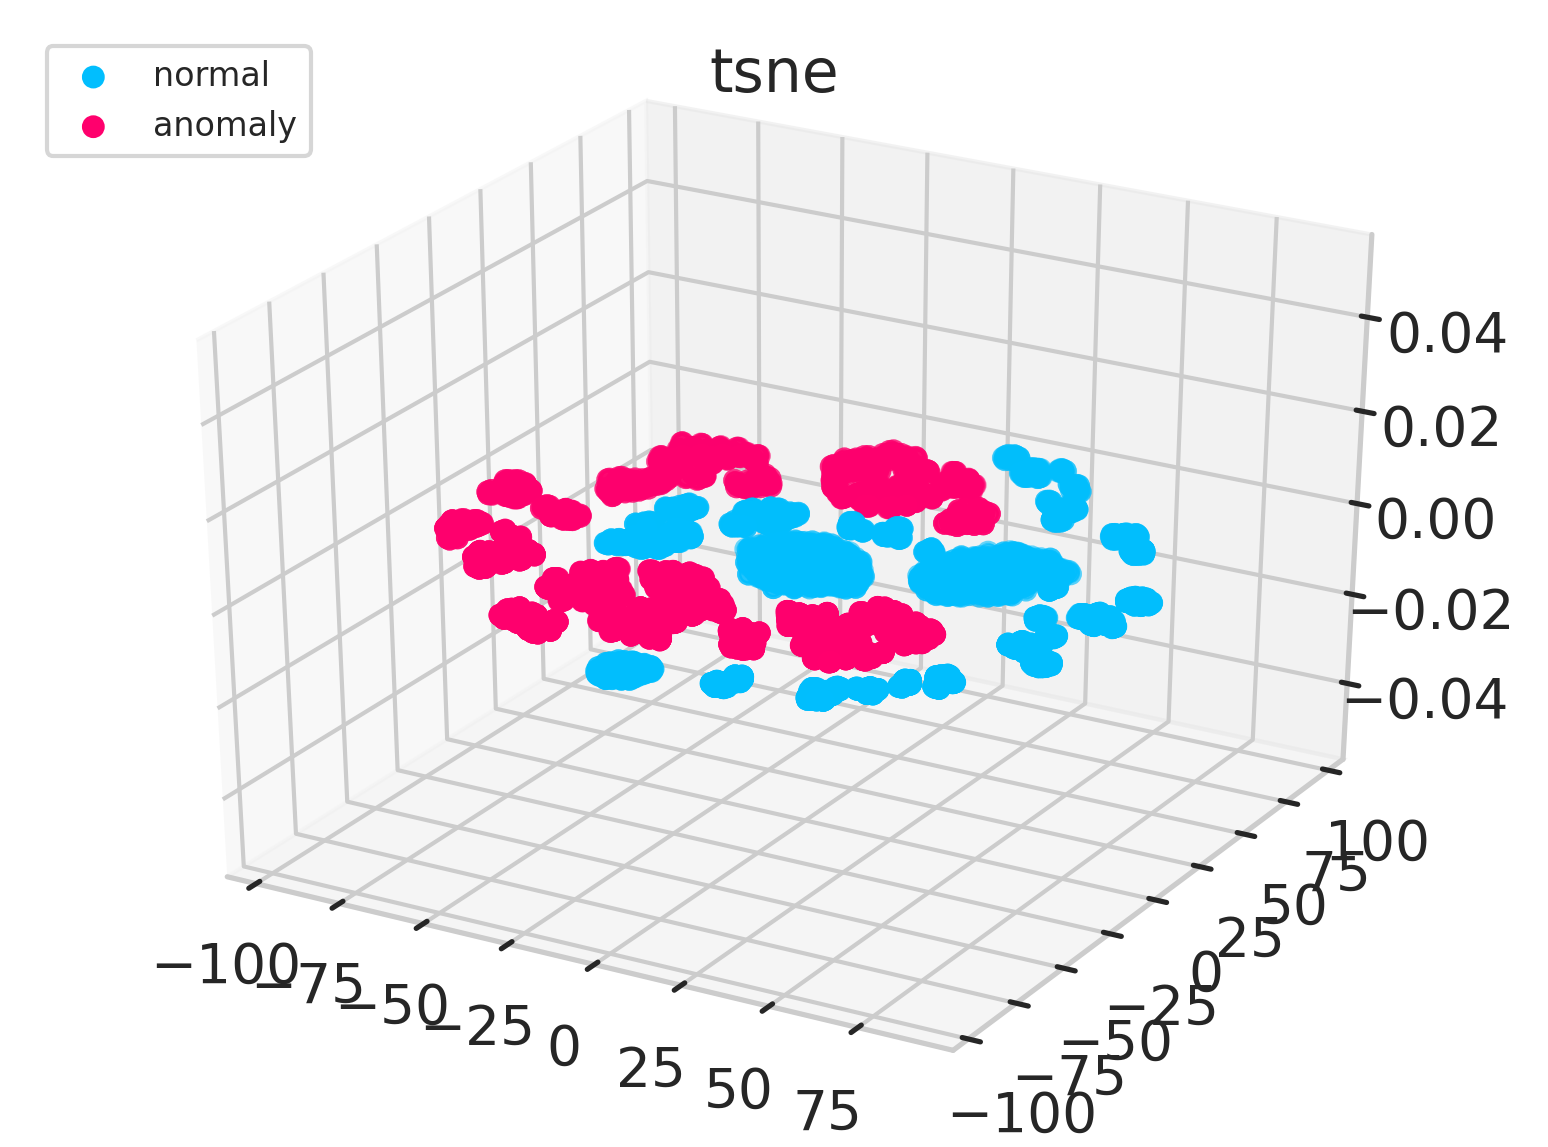

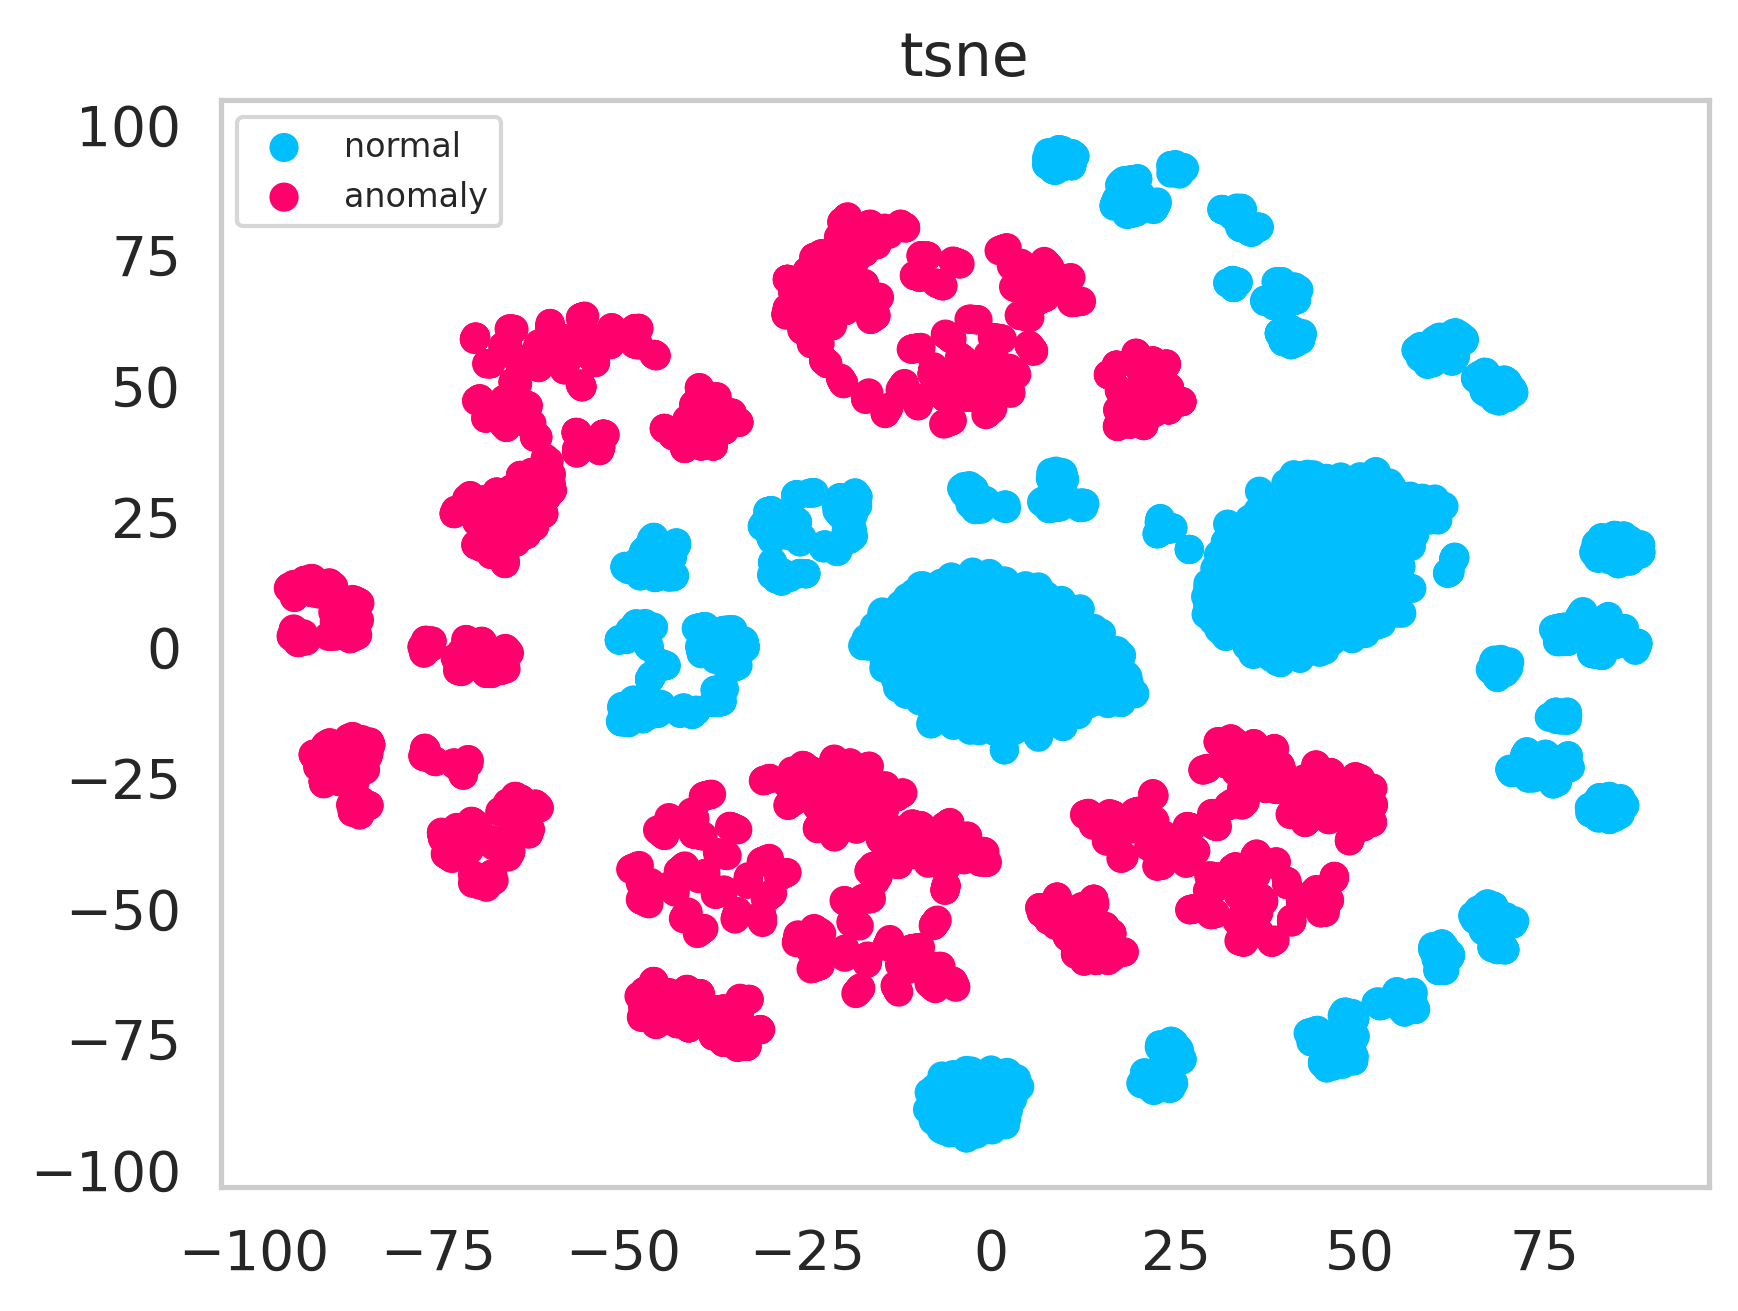

In [ ]:
# visualization_compare_normal_anomaly('all', 'pca', '2d')
# visualization_compare_normal_anomaly('all', 'pca', '3d')

visualization_compare_normal_anomaly('all', 'tsne', '3d')
visualization_compare_normal_anomaly('all', 'tsne', '2d')

In [ ]:
2882/39850*100

7.232120451693852

# Transfer Learning

In [ ]:
cnc_real_df=pd.concat([real_cnc_N_df,real_cnc_N_p005_df,real_cnc_N_p010_df,real_cnc_005_df,real_cnc_010_df,real_cnc_015_df,real_cnc_020_df,real_cnc_025_df],axis = 0, ignore_index= True)
cnc_real_df.rename(columns={320: 'target'}, inplace=True)
cnc_fake_df=pd.concat([fake_cnc_N_df,fake_cnc_N_p005_df,fake_cnc_N_p010_df,fake_cnc_005_df,fake_cnc_010_df,fake_cnc_015_df,fake_cnc_020_df,fake_cnc_025_df],axis = 0, ignore_index= True)
cnc_fake_df.rename(columns={320: 'target'}, inplace=True)
cnc_all_df = pd.concat([cnc_real_df, cnc_fake_df],axis = 0, ignore_index= True)

In [ ]:
######################################################
train_process = 'TRTR'

# TATA
if train_process == 'TATA':
  cnc_train_normal_df = cnc_all_df[cnc_all_df.target == CLASS_NORMAL]

  cnc_test_normal_df = cnc_all_df[cnc_all_df.target == CLASS_NORMAL]
  cnc_test_anomaly_df = cnc_all_df[cnc_all_df.target == CLASS_LEFT]

# TRTR
elif train_process == 'TRTR':
  cnc_train_normal_df = cnc_real_df[cnc_real_df.target == CLASS_NORMAL]

  cnc_test_normal_df = cnc_real_df[cnc_real_df.target == CLASS_NORMAL]
  cnc_test_anomaly_df = cnc_real_df[cnc_real_df.target == CLASS_LEFT]

# TSTS
elif train_process == 'TSTS':
  cnc_train_normal_df = cnc_fake_df[cnc_fake_df.target == CLASS_NORMAL]

  cnc_test_normal_df = cnc_fake_df[cnc_fake_df.target == CLASS_NORMAL]
  cnc_test_anomaly_df = cnc_fake_df[cnc_fake_df.target == CLASS_LEFT]

# TRTS
elif train_process == 'TRTS':
  cnc_train_normal_df = cnc_real_df[cnc_real_df.target == CLASS_NORMAL]

  cnc_test_normal_df = cnc_fake_df[cnc_fake_df.target == CLASS_NORMAL]
  cnc_test_anomaly_df = cnc_fake_df[cnc_fake_df.target == CLASS_LEFT]

# TSTR
elif train_process == 'TSTR':
  cnc_train_normal_df = cnc_fake_df[cnc_fake_df.target == CLASS_NORMAL]

  cnc_test_normal_df = cnc_real_df[cnc_real_df.target == CLASS_NORMAL]
  cnc_test_anomaly_df = cnc_real_df[cnc_real_df.target == CLASS_LEFT]

##############################################

cnc_train_normal_df, cnc_val_normal_df = train_test_split(
  cnc_train_normal_df,
  test_size=0.33,       #0.15
  random_state=RANDOM_SEED
)

print(cnc_train_normal_df.shape)
print(cnc_val_normal_df.shape)

print(cnc_test_normal_df.shape)
print(cnc_test_anomaly_df.shape)


def create_cycle_dataset(df):
  x_values = []
  y_values = []
  for i in range(len(df)):
    x = df.iloc[i,:-1].values
    y = df.iloc[i,-1]
    x_values.append(x)
    y_values.append(y)

  x = [torch.tensor(x).unsqueeze(1).float() for x in x_values]
  y = [torch.tensor(y).unsqueeze(0).float() for y in y_values]
  x = torch.stack(x)
  y = torch.stack(y)

  n_seq, seq_len, n_features = x.shape
  return x, y, seq_len, n_features


cnc_trainX, cnc_trainY, seq_len, n_features = create_cycle_dataset(cnc_train_normal_df)
print(cnc_trainX.shape)
cnc_valX, cnc_valY, _, _ = create_cycle_dataset(cnc_val_normal_df)
print(cnc_valX.shape)

cnc_test_normal_X, cnc_test_normal_Y, _, _ = create_cycle_dataset(cnc_test_normal_df)
print(cnc_test_normal_X.shape)
cnc_test_anomaly_X, cnc_test_anomaly_Y, _, _ = create_cycle_dataset(cnc_test_anomaly_df)
print(cnc_test_anomaly_X.shape)



batch_size = 128

cnc_train_dataset = TensorDataset(cnc_trainX, cnc_trainY)
cnc_train_dataloader = DataLoader(cnc_train_dataset, batch_size=batch_size, shuffle=True)

cnc_val_dataset = TensorDataset(cnc_valX, cnc_valY)
cnc_val_dataloader = DataLoader(cnc_val_dataset, batch_size=batch_size, shuffle=True)


cnc_test_anomaly_dataset = TensorDataset(cnc_test_anomaly_X, cnc_test_anomaly_Y)
cnc_test_anomaly_dataloader = DataLoader(cnc_test_anomaly_dataset, batch_size=batch_size, shuffle=True)

cnc_test_normal_dataset = TensorDataset(cnc_test_normal_X, cnc_test_normal_Y)
cnc_test_normal_dataloader = DataLoader(cnc_test_normal_dataset, batch_size=batch_size, shuffle=True)

(1210, 321)
(596, 321)
(1806, 321)
(16044, 321)
torch.Size([1210, 320, 1])
torch.Size([596, 320, 1])
torch.Size([1806, 320, 1])
torch.Size([16044, 320, 1])


In [ ]:
# model = CnnAutoencoder(num_kernal=96).to(device).apply(weights_init)

# model = TcnAutoencoder().to(device)

model = LstmAutoencoder1(embedding_dim=16).to(device)

# model = CnnLstmAutoencoder(num_kernal=16, kernel_size=5, dropout=0.2).to(device) 
# model = CnnLstmAutoencoder(num_kernal=48, kernel_size=3, dropout=0.0).to(device)  # 用这个

In [ ]:
# MODEL_PATH = '/content/drive/MyDrive/dataset/checkpoint/cnn_ae_all.pth'
# MODEL_PATH = '/content/drive/MyDrive/dataset/checkpoint/tcn_ae_all.pth'
MODEL_PATH = '/content/drive/MyDrive/dataset/checkpoint/lstm1_ae_all.pth'
# MODEL_PATH = '/content/drive/MyDrive/dataset/checkpoint/cnn_lstm_ae_all.pth'

model.eval()
# model = torch.load(MODEL_PATH)

LstmAutoencoder1(
  (lstm1): LSTM(1, 16, batch_first=True)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=5120, out_features=320, bias=True)
  (bn4): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.060046	) # cnn-ae
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.059346) # tcn-ae
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.004684)  # cnn-lstm-ae

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

# criterion = nn.L1Loss(reduction='sum').to(device)
criterion = nn.MSELoss(reduction='sum').to(device)

In [ ]:
def train_model(model, train_dataset, val_dataset, n_epochs, patience):
  # to track the average training loss and validation loss per epoch as the model trains
  history = dict(train=[], val=[])
  # to save the current best model states
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  best_correct = 0
  best_threshold = 0

  # initialize the early_stopping object
  early_stopping = EarlyStopping(verbose = True, patience = patience)

  for epoch in range(1, n_epochs + 1):
    ###################
    # train the model #
    ###################
    model = model.train()
    train_losses = []
    for id_batch, (x_batch, y_batch) in enumerate(cnc_train_dataloader):
      # clear the gradients of all optimized variables
      optimizer.zero_grad()
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      seq_pred = model(x_batch)
      # calculate the loss
      loss = criterion(seq_pred, x_batch)
      loss = loss / x_batch.shape[0]
      # backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      # perform a single optimization step (parameter update)
      optimizer.step()
      # record training loss
      loss = loss.item()
      train_losses.append(loss)
    train_loss = np.mean(train_losses)

    ######################    
    # validate the model #
    ######################
    model = model.eval()
    val_losses = []
    with torch.no_grad():
      for id_batch, (x_batch, y_batch) in enumerate(cnc_val_dataloader):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        seq_pred = model(x_batch)
        #  calculate the loss
        loss = criterion(seq_pred, x_batch)
        # record validation loss
        loss = loss / x_batch.shape[0]
        loss = loss.item()
        val_losses.append(loss)
      val_loss = np.mean(val_losses)

      if val_loss < best_loss:
        best_loss = val_loss
        correct = 0
        originals_normal, predictions_normal, pred_losses_normal = predict(model, cnc_test_normal_dataloader)
        originals_left, predictions_left, pred_losses_left = predict(model, cnc_test_anomaly_dataloader)
        num_all_sammples = len(pred_losses_left) + len(pred_losses_normal)
        THRESHOLD = linspace(0.0,0.5,500)
        for threshold in THRESHOLD:
          correct = sum(i > threshold for i in pred_losses_left) + sum(i <= threshold for i in pred_losses_normal)
          correct = correct / num_all_sammples

          if correct >= best_correct:
            best_correct = correct
            best_threshold = threshold
            best_model_wts = copy.deepcopy(model.state_dict())

    # calculate average loss over an epoch
    history['train'].append(train_loss)
    history['val'].append(val_loss)

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
      print("Early stopping")
      break
    
    # if best_correct == 1.0:
    #   break

    # if val_loss < best_loss:
    #   best_loss = val_loss
    #   best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch: {epoch} train loss {train_loss} val loss {val_loss} best_correct {best_correct}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history, best_threshold

In [ ]:
# number of epochs.
n_epochs=1000

# early stopping patience; how long to wait after last time validation loss improved.
patience = 50

model, history, best_threshold = train_model(
  model, 
  cnc_trainX,
  cnc_valX,
  n_epochs=n_epochs,
  patience=patience
)

Validation loss decreased (inf --> 0.304888).  Saving model ...
Epoch: 1 train loss 0.3286418318748474 val loss 0.3048881649971008 best_correct 0.9932773109243698


KeyboardInterrupt: ignored

In [ ]:
# # MODEL_PATH = '/content/drive/MyDrive/dataset/checkpoint/cnn_ae_all_transfered.pth'
# # MODEL_PATH = '/content/drive/MyDrive/dataset/checkpoint/tcn_ae_all_transfered.pth'
# # MODEL_PATH = '/content/drive/MyDrive/dataset/checkpoint/lstm1_ae_all_transfered.pth'
# MODEL_PATH = '/content/drive/MyDrive/dataset/checkpoint/cnn_lstm_ae_all_transfered.pth'

# model.eval()
# # torch.save(model, MODEL_PATH)

In [ ]:
def predict(model, dataloader):
  losses = []
  with torch.no_grad():
    model = model.eval()
    for id_batch, (x_batch, _) in enumerate(dataloader):
      x_batch = x_batch.to(device)
      x_pred = model(x_batch)
      diff = ((x_pred - x_batch)**2).sum(1)
      losses.append(diff.squeeze().tolist())

      if id_batch == 0 :
        predictions = x_pred
        originals = x_batch
      else:
        predictions = torch.cat((predictions,x_pred), 0)
        originals = torch.cat((originals,x_batch), 0)

  losses = [x for xs in losses for x in xs]
  return originals, predictions, losses

In [ ]:
def plot_prediction(dataloader, model, title, ax):
  originals, predictions, pred_losses = predict(model, dataloader)
  
  id = 0
  line_width = 2
  # if title == 'normal':
  #   color1 = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
  #   color2 = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
  # else:
  #   color1 = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
  #   color2 = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
  
  color1 = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
  color2 = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
 
  # indexes = []
  # values = []
  # for index,value in enumerate(originals.squeeze().cpu()[id]):
  #   values.append(value)
  #   indexes.append(index*64/sampling_frequency)
  indexes, values = prepare_axies(originals.squeeze().cpu()[id], sampling_frequency)
  ax.plot(indexes,
      values, 
      label='true',
      linewidth = line_width,
      color=color1)
  
  indexes = []
  values = []
  for index,value in enumerate(predictions.squeeze().cpu()[id]):
    values.append(value)
    indexes.append(index*64/sampling_frequency)
  indexes, values = prepare_axies(predictions.squeeze().cpu()[id], sampling_frequency)  
  ax.plot(indexes,
      values,
      label='reconstructed',
      linewidth = line_width,
      color=color2)

  # ax.set_title(f'{title} (loss: {np.around(pred_losses[id], 3)})',fontsize = 15)
  # ax.legend(prop={"size":15})
  ax.set_title(f'{title} (loss: {np.around(pred_losses[id], 3)})')
  ax.grid(None)
  ax.legend()

Text(0.5, 0.06, 'time steps (s)')

Text(0.06, 0.5, 'normalized current value (A)')

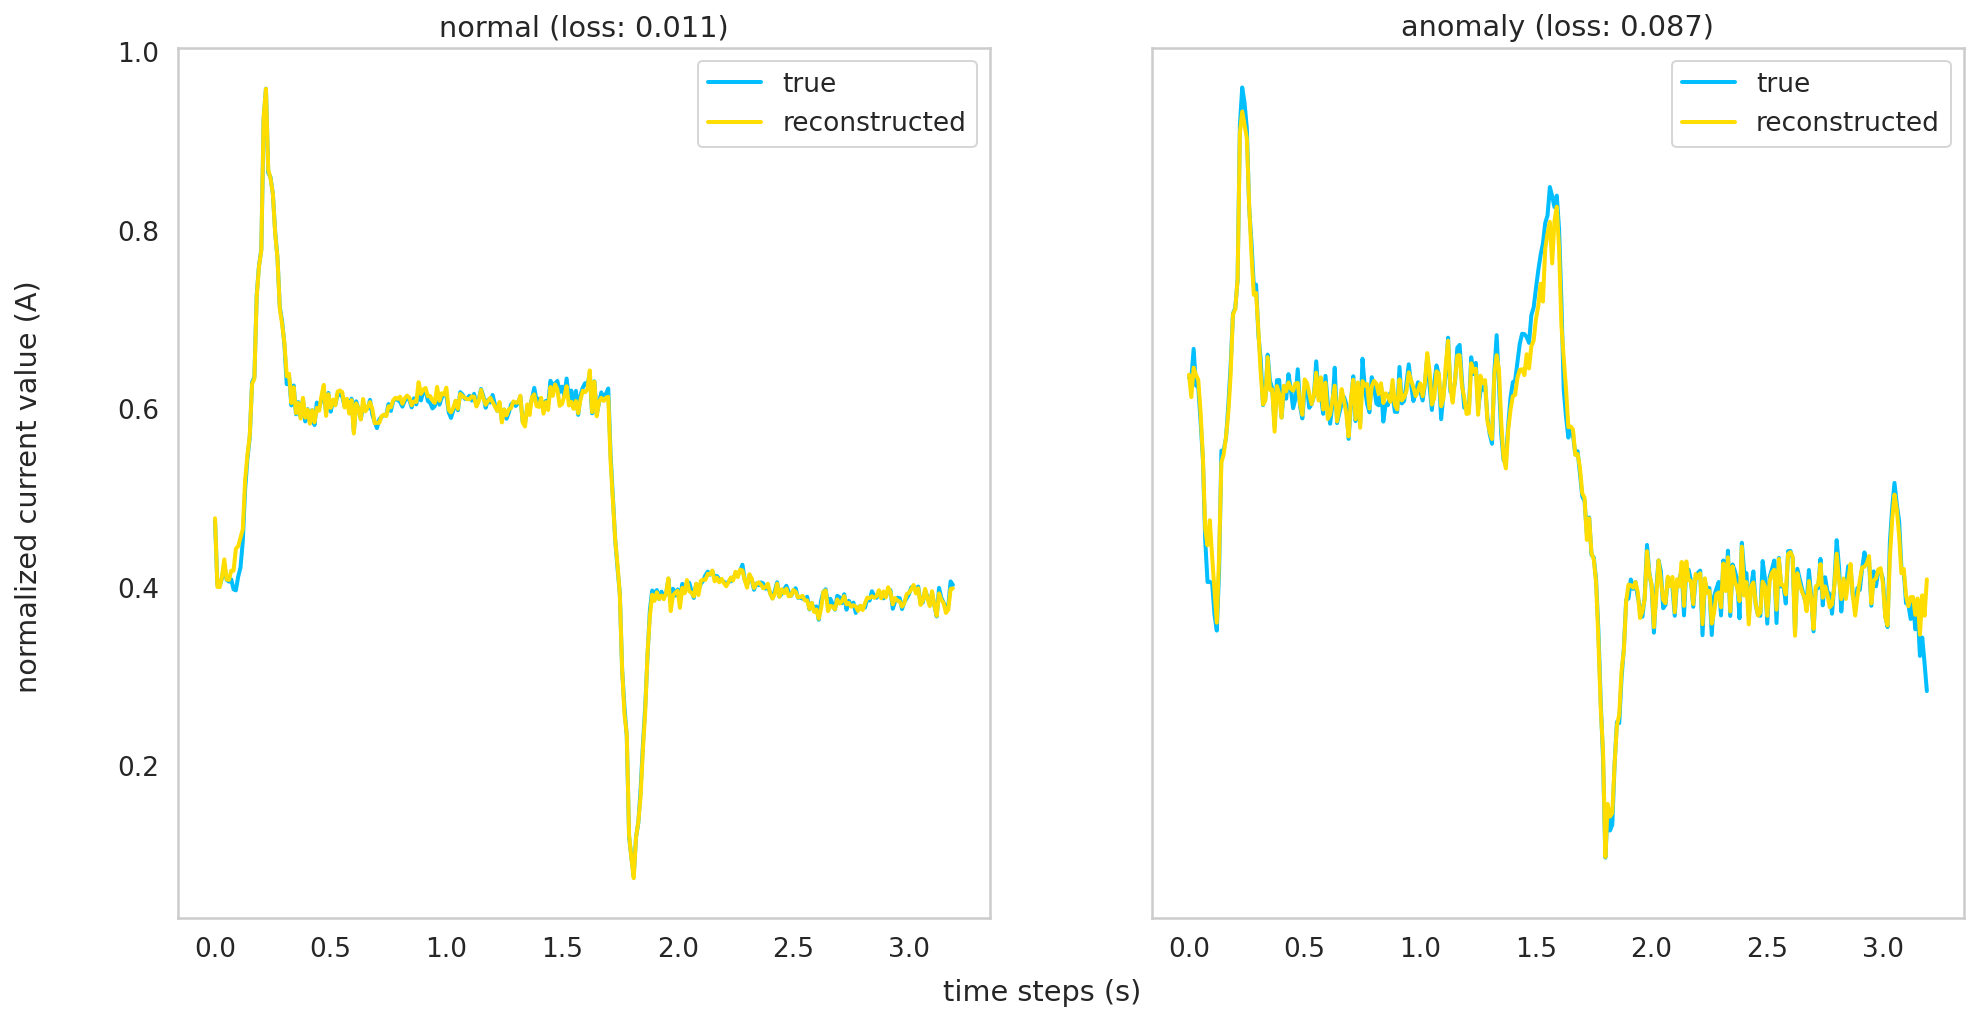

In [ ]:
fig, axs = plt.subplots(
  nrows=1,
  ncols=2,
  sharey=True,
  sharex=True,
  figsize=(16, 8)
  )

plot_prediction(cnc_test_anomaly_dataloader, model, title='anomaly', ax=axs[1])
plot_prediction(cnc_test_normal_dataloader, model, title='normal', ax=axs[0])


# fig.suptitle('(a)reconstruction performance of CNN-AE')
# fig.suptitle('(b)reconstruction performance of TCN-AE')
# fig.suptitle('(c)reconstruction performance of LSTM-AE')
# fig.suptitle('(d)reconstruction performance of CNN-LSTM-AE')

fig.text(0.5,0.06, "time steps (s)", ha="center", va="center")
fig.text(0.06,0.5, "normalized current value (A)", ha="center", va="center", rotation=90)

In [ ]:
class Meter:
  def __init__(self, n_classes=2):
    self.targets = []
    self.predictions = []
    self.metrics = {}
    self.confusion = np.zeros((n_classes, n_classes))

  def init_metrics(self):
    self.metrics['accuracy'] = 0
    self.metrics['f1'] = 0
    self.metrics['precision'] = 0
    self.metrics['recall'] = 0

  def update(self, x, y):
    self._compute_cm(x, y)

    self.targets = np.hstack((self.targets, x))
    self.predictions = np.hstack((self.predictions, y)) 

  def _compute_cm(self, x, y):
    for prob, target in zip(x, y):
      self.confusion[int(target)][int(prob)] += 1
  
  def _compute_metric(self):
    self.metrics['accuracy'] += round(accuracy_score(self.targets, self.predictions),5)
    self.metrics['f1'] += round(f1_score(self.targets, self.predictions,average='macro'),5)
    self.metrics['precision'] += round(precision_score(self.targets, self.predictions, average='macro', zero_division=1),5)
    self.metrics['recall'] += round(recall_score(self.targets, self.predictions, average='macro', zero_division=1),5)
      
  def get_metrics(self):
    return self.metrics
  
  def get_accuracy(self):
    return self.metrics['accuracy']
  
  def get_f1(self):
    return self.metrics['f1']

  def get_precision(self):
    return self.metrics['precision']

  def get_recall(self):
    return self.metrics['recall']
    
  def get_confusion_matrix(self):
    return self.confusion

  def plot_confusion_matrix(self, classes=class_names, title='Confusion matrix', color_map='Blues'):
    disp = ConfusionMatrixDisplay(confusion_matrix=self.confusion, display_labels=class_names)
    disp.plot(cmap=color_map, values_format='')
    plt.grid(False)
    # plt.title(title)
    plt.show()

meter = Meter()
meter.init_metrics()

Correct threshold: 0.2725450901803607
Correct predictions rate: 1.0


Text(0.5, 0, 'values')

Text(0, 0.5, 'counts')

Text(0.5, 1.0, 'reconstruction loss of normal data')

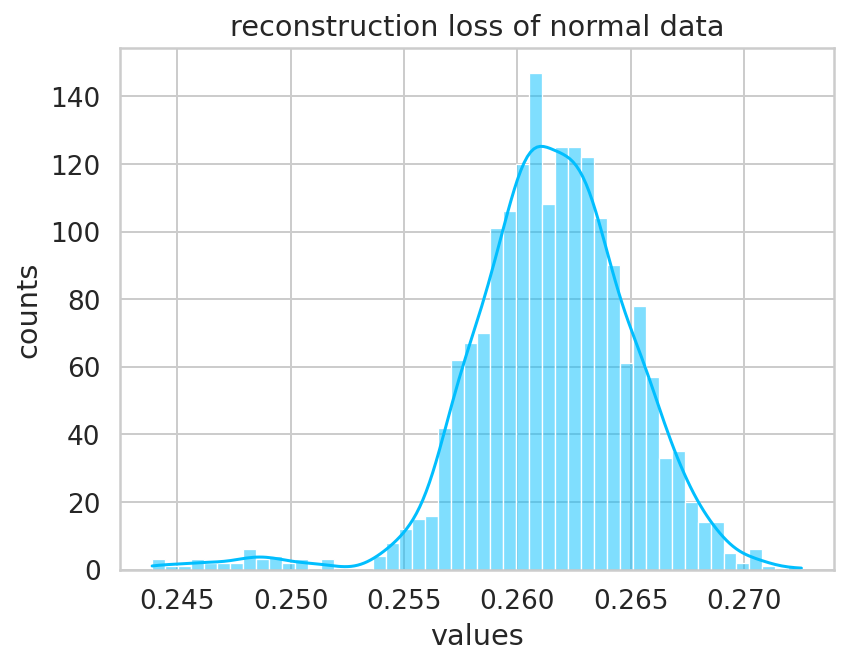

Correct normal predictions: 1806/1806
0.2438940852880478
0.27253586053848267


Text(0.5, 0, 'values')

Text(0, 0.5, 'counts')

Text(0.5, 1.0, 'reconstruction loss of anomaly data')

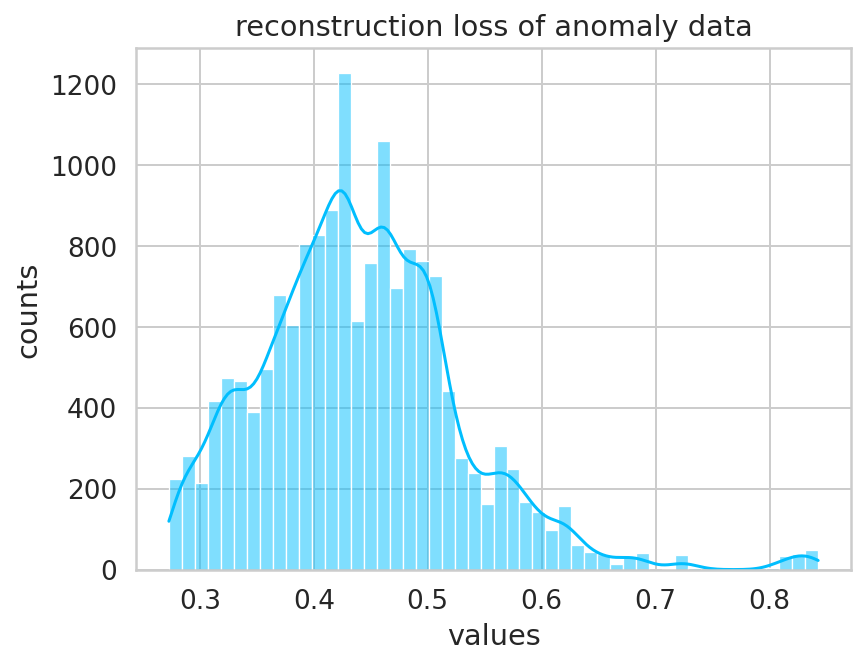

Correct left side anomaly predictions: 16044/16044
0.2727948725223541
0.8427208065986633


In [ ]:
originals_normal, predictions_normal, pred_losses_normal = predict(model, cnc_test_normal_dataloader)
originals_left, predictions_left, pred_losses_left = predict(model, cnc_test_anomaly_dataloader)

num_all_sammples = len(pred_losses_left) + len(pred_losses_normal)
THRESHOLD = linspace(0.0,1.0,500)
best_threshold = 0
best_accuracy = 0
for threshold in THRESHOLD:
  correct = sum(i > threshold for i in pred_losses_left) + sum(i <= threshold for i in pred_losses_normal)
  correct = correct / num_all_sammples
  if correct > best_accuracy:
    best_accuracy = correct
    best_threshold = threshold

print(f'Correct threshold: {best_threshold}')
print(f'Correct predictions rate: {best_accuracy}')



fig = sns.histplot(pred_losses_normal, bins=50, kde=True);
plt.xlabel("values")
plt.ylabel("counts")
plt.title("reconstruction loss of normal data")
plt.show(fig)


correct = sum(l <= best_threshold for l in pred_losses_normal)
print(f'Correct normal predictions: {correct}/{len(cnc_test_normal_X)}')
print(min(pred_losses_normal))
print(max(pred_losses_normal))

target_normal = np.full_like(pred_losses_normal, CLASS_NORMAL)
pred_normal = np.full_like(pred_losses_normal, CLASS_NORMAL)
for id, i in enumerate(pred_losses_normal):
  if i > best_threshold:
    pred_normal[id] = CLASS_LEFT
meter.update(target_normal, pred_normal)


originals_left, predictions_left, pred_losses_left = predict(model, cnc_test_anomaly_dataloader)
fig = sns.histplot(pred_losses_left, bins=50, kde=True)
plt.xlabel("values")
plt.ylabel("counts")
plt.title("reconstruction loss of anomaly data")
plt.show(fig)

correct = sum(l > best_threshold for l in pred_losses_left)
print(f'Correct left side anomaly predictions: {correct}/{len(cnc_test_anomaly_X)}')
print(min(pred_losses_left))
print(max(pred_losses_left))

target_left = np.full_like(pred_losses_left, CLASS_LEFT)
pred_left = np.full_like(pred_losses_left, CLASS_LEFT)
for id, i in enumerate(pred_losses_left):
  if i <= best_threshold:
    pred_left[id] = CLASS_NORMAL
meter.update(target_left, pred_left)

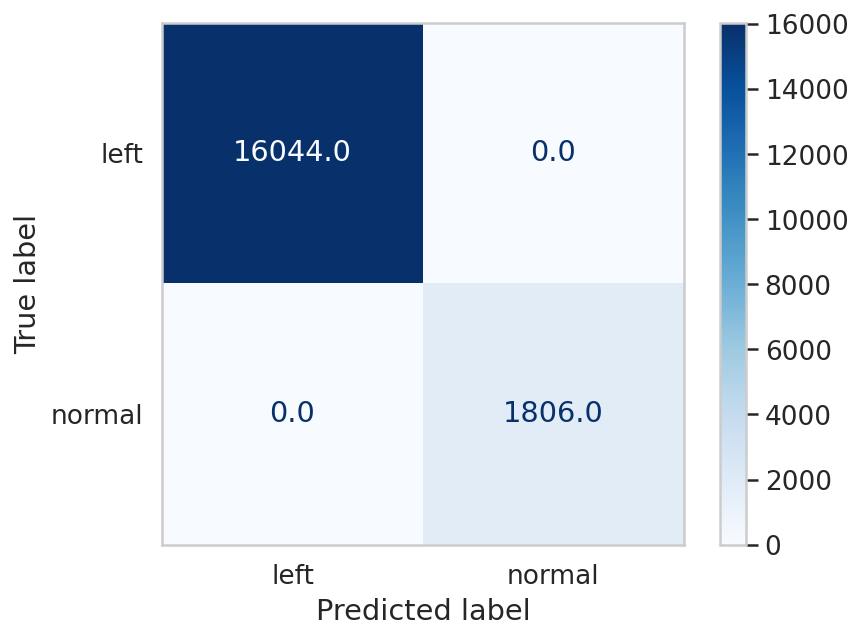

{'accuracy': 1.0, 'f1': 1.0, 'precision': 1.0, 'recall': 1.0}


In [ ]:
meter._compute_metric()

meter.plot_confusion_matrix(title='(a) CNN-AE')
# meter.plot_confusion_matrix(title='(b) TCN-AE')
# meter.plot_confusion_matrix(title='(c) LSTM-AE')
# meter.plot_confusion_matrix(title='(d) CNN-LSTM-AE')

print(meter.get_metrics())

<Figure size 960x720 with 0 Axes>

Text(0.5, 0, 'counts')

Text(0, 0.5, 'reconstruction loss')

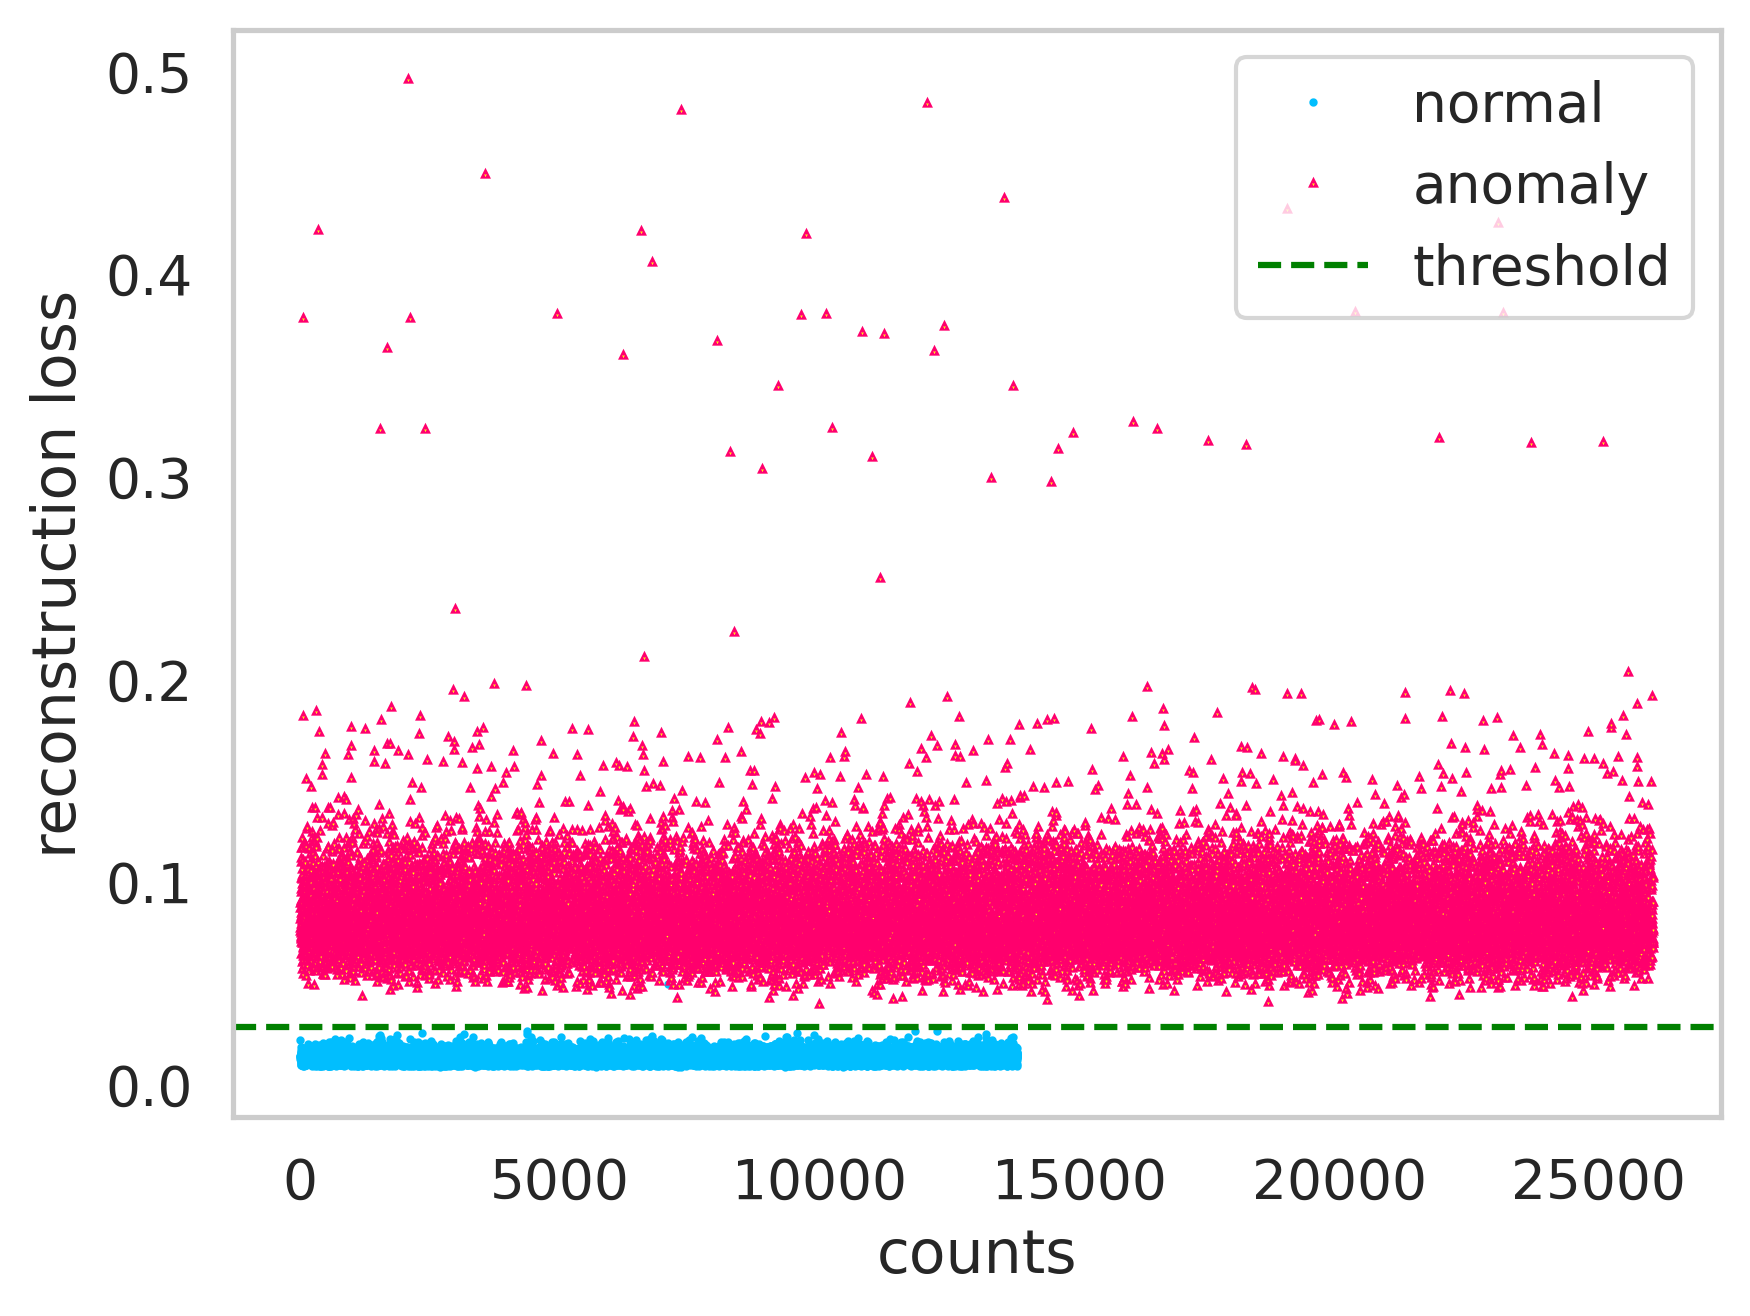

In [ ]:
plt.figure(dpi=150)
plt.plot(pred_losses_normal,
    color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0],
    label='normal',
    marker='o',
    markerfacecolor='blue',
    linestyle='dashed',
    linewidth=0.00,
    markersize=1)
plt.plot(pred_losses_left,
    color=plt.rcParams['axes.prop_cycle'].by_key()['color'][3],
    label='anomaly',
    marker='^',
    markerfacecolor='yellow',
    linestyle='dashed',
    linewidth=0.00,
    markersize=1)
plt.axhline(y = best_threshold, color='green', ls='--', label='threshold')


plt.xlabel('counts')
plt.ylabel('reconstruction loss')

plt.grid(None)
plt.legend()